<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [55]</a>'.</span>

In [1]:
import logging
logger = logging.getLogger('retrain_ipynb')
logger.setLevel(logging.DEBUG)


ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
formatter = logging.Formatter('%(levelname)s - %(asctime)s - %(name)s - %(message)s')
ch.setFormatter(formatter)
logger.addHandler(ch)
logger.debug('--=logging started=--')



# Config

In [2]:
import sys
TRAIN = True
TRAIN_MODEL_3 = False
IN_COLAB = 'google.colab' in sys.modules
print ('Running in colab:', IN_COLAB)

Running in colab: False


In [3]:
import os

if not IN_COLAB:
  nb_dir = os.path.split(os.getcwd())[0]
  if nb_dir not in sys.path:
      sys.path.append(nb_dir)
else:
  %tensorflow_version 1.x
  import tensorflow as tf
  print(tf.__version__)

In [4]:
if IN_COLAB:
  !pip install --upgrade pip
  !pip --version
  !pip install --no-deps --upgrade git+https://www.github.com/nemoware/analyser.git@uber-models
  !pip install -q pyjarowinkler overrides
  

In [5]:
import os
import random
import math
import json
import warnings

from os import path
from pathlib import Path
import analyser.hyperparams

training_reports_path = Path(analyser.hyperparams.__file__).parent.parent / 'training_reports/'

if not IN_COLAB:
    _work_dir_default = os.path.realpath(os.path.join(  analyser.hyperparams.__file__, '..', '..', '..', 'work'))
    work_dir = os.environ.get('GPN_WORK_DIR', _work_dir_default)

    if not os.path.isdir(work_dir):
        os.mkdir(work_dir)

    analyser.hyperparams.work_dir = work_dir
else:

    from google.colab import drive
    drive.mount('/content/drive')
    os.environ['GPN_WORK_DIR']='/content/drive/My Drive/GazpromOil/trainsets/uber_2'
    analyser.hyperparams.work_dir = os.environ['GPN_WORK_DIR']

print('work_dir=', analyser.hyperparams.work_dir)


assert os.path.isdir(analyser.hyperparams.work_dir)

Nemoware Analyser v23.1.27.1
USING WORKDIR: [/root/artem/work]
 set ENV GPN_WORK_DIR to override
datasets_dir: [/root/artem/work/datasets]
reports_dir: [/root/artem/work/reports]
work_dir= /root/artem/work


/root/artem/analyser/analyser/hyperparams.py:15: UserWarning: please set GPN_WORK_DIR environment variable
  warnings.warn('please set GPN_WORK_DIR environment variable')


# Imports

In [6]:
%matplotlib inline
import tensorflow as tf
print(tf.__version__)

 


import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

from colab_support.renderer import *

import pickle
import numpy as np
import pandas as pd

from bson import json_util

from analyser.legal_docs import LegalDocument, make_headline_attention_vector
from analyser.headers_detector import make_predicted_headline_attention_vector, get_tokens_features
from analyser.hyperparams import models_path
from analyser.text_tools import find_top_spans
from analyser.persistence import DbJsonDoc

from trainsets.trainset_tools import TrainsetBalancer, SubjectTrainsetManager
from trainsets.retrain_contract_uber_model import UberModelTrainsetManager

from tf_support import super_contract_model
from tf_support.super_contract_model import get_base_model, semantic_map_keys_contract
from tf_support.super_contract_model import uber_detection_model_005_1_1
from tf_support.tf_subject_model import decode_subj_prediction
from tf_support.tools import KerasTrainingContext
# from tf_support.embedder_elmo import ElmoEmbedder


from keras.utils.vis_utils import model_to_dot
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
 
from keras.models import load_model


from tensorflow import keras
import keras.backend as K
from keras.layers import Conv1D, LSTM, GRU, BatchNormalization, TimeDistributed, Dense, Bidirectional, Input, Dropout, Lambda
from keras.layers import concatenate, SpatialDropout1D, ActivityRegularization
from keras.layers import MaxPooling1D, Activation, ThresholdedReLU, GaussianNoise

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.models import Sequential, Model

# from keras.utils import plot_model
from keras.preprocessing.sequence import pad_sequences


2023-02-04 15:58:45.597865: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


2.5.0


/tmp/ipykernel_991188/3340962001.py:10: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


HyperParameters.subsidiary_name_match_min_jaro_similarity 0.9649122807017544


[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_USER environment variable! defaulting to None


[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_PASSWORD environment variable! defaulting to None


[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_URL environment variable! defaulting to None


[documents.py:270 -             __init__() ] loading word cases stats model from: /root/artem/analyser/analyser/vocab/word_cases_stats.pickle


[tools.py:29 -             __init__() ] model_checkpoint_path: /root/artem/analyser/analyser/vocab


In [7]:
print('training_reports_path=', training_reports_path)

training_reports_path= /root/artem/analyser/training_reports


In [8]:
# gpu_devices = tf.config.experimental.list_physical_devices('GPU')

# for device in gpu_devices:
#     print(device)
#     tf.config.experimental.set_memory_growth(device, True)

# Prepare trainset


In [9]:
if not IN_COLAB:
  from integration.db import get_mongodb_connection
  from bson.objectid import ObjectId

  def get_doc(objid):
    db = get_mongodb_connection()
    documents_collection = db['documents']
    jdata = documents_collection.find_one({'_id': ObjectId(objid)})
    return DbJsonDoc(jdata)

In [10]:
if False:
    jdoc = get_doc('5df1f44dec85d861954efc47')
    doc = jdoc.asLegalDoc()
    doc.tokens
    

work_dir = Path(analyser.hyperparams.work_dir)
print(work_dir)

/root/artem/work


In [11]:
# xx = stats.loc[stats['user_correction_date'].notnull()]
# xx = xx[ (xx.version=='3.0.0') | (xx.version=='22.12.7')].sort_values(['score'])
# xx.to_csv('contracts_to_re-analyze.csv')
# xx

In [12]:
# xx = stats.loc[stats['user_correction_date'].notnull()]
# xx['user_correction_date'] = pd.to_datetime(xx['user_correction_date'], utc=True)


# xx['user_correction_date'] = xx['user_correction_date'].astype('datetime64[ns]')


# xx.to_datetime(df_res['DateTime'], utc=True)

# xx['user_correction_date'] = xx['user_correction_date'].dt.tz_localize(None)

# xx.sort_values(['user_correction_date'])

In [13]:
# yy = xx.sort_values(['user_correction_date'])[xx.version!='22.12.7'][xx.source=='db'].sort_values(['score'])
# yy

In [14]:
# stats['user_correction_date'] = stats['user_correction_date'].dt.tz_localize(None)
# stats.sort_values(['user_correction_date'])

In [15]:
# yy.to_csv('contracts_to_review.csv')

In [16]:
umtm = UberModelTrainsetManager (work_dir, reports_dir=training_reports_path)

umtm.load_contract_trainset_meta() # 'contract_trainset_meta.csv'
stats = umtm.stats
stats

source                          checksum    version  \
_id                                                                            
6340244c9d08c565cfa12341     db  bc7d70a32aed6af4ef6c7752a1b7674d      3.0.0   
5ec2b8da665f7603e03b1255     db  3187bfac60ea578221c5d9357756c6c1      1.6.5   
5edbc62eda3678279fbcadf3   file  027a7c30f74ff8ffe684378e9883dd8e      2.0.2   
5ded4e284ddc27bcf92dd6ce   file  9a44591c17d2b8f34dc8f1c3600c8c3a     1.11.2   
63ce49f8e83d1ee490f3f21c     db  25d924fc09b7291d964f464f9c3ec8c3  23.1.27.1   
...                         ...                               ...        ...   
638085ba6a07f3e980b2c8a3     db  e763076767ebfba9c4f9b19c8b56577f      3.0.0   
638085b86a07f3e980b2c865     db  f48f275cfea2e513e0903e51018a0393      3.0.0   
63c506bbe2456d59975e10d3     db  874cd51371532aced3062000ca3f5334   23.01.04   
63c506d5e2456d59975e1389     db  2628dbfa46813bc351104e1ebdc6d6a2   23.01.04   
63ce4b0be83d1ee490f4009d     db  a35591663822c05db4729b91ed3a9276   23.01.23   

                                         export_date      len  \
_id                                                             
6340244c9d08c565cfa12341  2023-01-31 18:37:33.526517   6740.0   
5ec2b8da665f7603e03b1255  2023-02-01 17:26:52.044394   5840.0   
5edbc62eda3678279fbcadf3  2023-02-04 11:26:06.198066   1370.0   
5ded4e284ddc27bcf92dd6ce  2023-02-04 11:26:02.945815    460.0   
63ce49f8e83d1ee490f3f21c  2023-02-03 16:19:06.576376   8530.0   
...                                              ...      ...   
638085ba6a07f3e980b2c8a3  2023-01-31 18:36:14.385120  14510.0   
638085b86a07f3e980b2c865  2023-01-31 18:36:14.021955   6970.0   
63c506bbe2456d59975e10d3  2023-01-31 21:42:32.301540   6540.0   
63c506d5e2456d59975e1389  2023-01-31 21:42:26.523639   2170.0   
63ce4b0be83d1ee490f4009d  2023-01-31 21:43:37.191817  11690.0   

                                             analyze_date         value  \
_id                                                                       
6340244c9d08c565cfa12341 2022-10-07 16:09:15.340000+00:00  2.000000e+09   
5ec2b8da665f7603e03b1255 2020-05-18 17:16:38.114000+00:00  2.523632e+07   
5edbc62eda3678279fbcadf3 2020-07-18 20:24:58.934000+00:00  2.400000e+04   
5ded4e284ddc27bcf92dd6ce 2020-06-12 21:09:19.574000+00:00  5.900000e+05   
63ce49f8e83d1ee490f3f21c 2023-01-28 09:34:50.691000+00:00  3.000000e+09   
...                                                   ...           ...   
638085ba6a07f3e980b2c8a3 2022-11-25 20:49:51.884000+00:00           NaN   
638085b86a07f3e980b2c865 2022-11-25 20:42:05.633000+00:00           NaN   
63c506bbe2456d59975e10d3 2023-01-16 12:51:04.442000+00:00           NaN   
63c506d5e2456d59975e1389 2023-01-16 11:21:48.816000+00:00           NaN   
63ce4b0be83d1ee490f4009d 2023-01-26 07:15:10.062000+00:00           NaN   

                          value_log1p  value_span currency  ... documentType  \
_id                                                         ...                
6340244c9d08c565cfa12341    21.416413       909.0      RUB  ...    AGREEMENT   
5ec2b8da665f7603e03b1255    17.043795      5674.0      BRL  ...     CONTRACT   
5edbc62eda3678279fbcadf3    10.085851       747.0      RUB  ...     CONTRACT   
5ded4e284ddc27bcf92dd6ce    13.287880       150.0      RUB  ...     CONTRACT   
63ce49f8e83d1ee490f3f21c    21.821878       337.0      RUB  ...     CONTRACT   
...                               ...         ...      ...  ...          ...   
638085ba6a07f3e980b2c8a3          NaN         NaN      NaN  ...     CONTRACT   
638085b86a07f3e980b2c865          NaN         NaN      NaN  ...     CONTRACT   
63c506bbe2456d59975e10d3          NaN         NaN      NaN  ...     CONTRACT   
63c506d5e2456d59975e1389          NaN         NaN      NaN  ...    AGREEMENT   
63ce4b0be83d1ee490f4009d          NaN         NaN      NaN  ...     CONTRACT   

                         subj_len headers  \
_id                                         
6340244c9d08c565cfa12341    130

In [17]:
# stats[ ['org-1-alias', 'org-2-alias'] ]

user_dataset = stats[ stats['unseen']==False]
len(user_dataset)


1216

In [18]:
print(len(stats))

2708


In [19]:
user_dataset[user_dataset.subj_len>=150]

source                          checksum  version  \
_id                                                                          
6391b4771864c6df4d29f332     db  22f701119d81787cd423f79f0f9fd9db  22.12.7   
639316f61002115a6029f3c8     db  670b730e664306d9e1e7f19a358cc0ab  22.12.7   
63908ca4a1bded13e629f2e4     db  665a638dc4f2c42ce670679ca76cff77  22.12.6   
62838b2e4d1bfe5e5b297ddb     db  c81664bbc202b2a143fe57dfcb950348    3.0.0   
5fb399dd39d5e82e90818477     db  44d1c22fb92ce75663dc046c184df359    2.0.5   
62d149464ae369b4976e31f3     db  31b2973970123953ebc9074a4dfaa421    3.0.0   
6380859e6a07f3e980b2c5c4     db  5d8d2a674adffa2c30fa1254e1047e40    3.0.0   
638085646a07f3e980b2c0e5     db  43519987735b5d2180168facc4404545    3.0.0   
6380857e6a07f3e980b2c343     db  24195a650ec51184b0b507d73fd67b7a    3.0.0   
638085686a07f3e980b2c124     db  0330bc8b29d42453fb0350e80da94743    3.0.0   
638085976a07f3e980b2c561     db  ec297f3094591fbad5418b2167357d4d    3.0.0   
638085ac6a07f3e980b2c733     db  7440524bbf921c898bfc35d1885bda2f    3.0.0   
638085a36a07f3e980b2c623     db  85bd0228e9e167ca8a7eb78c0ba8c305    3.0.0   
5fb3d7a178df3635f5441d6a     db  5e410fc2e9e1068575cf860ad7a4a632    2.0.5   
5fe4821fb770574a00555741     db  8dceb00aaefe9c38b75de9d170b212f5   2.3.13   
62c54895e599c73b751b7974     db  9756e819859af5192b5e44806f173d8c    3.0.0   
638085976a07f3e980b2c575     db  d7756a8860dee9f6d2c4e825566aaa6c    3.0.0   
638085b16a07f3e980b2c7e1     db  9ad16aad3ee3f858d3cd3462a8138488  22.12.7   

                                         export_date      len  \
_id                                                             
6391b4771864c6df4d29f332  2023-02-04 11:26:24.239638   1990.0   
639316f61002115a6029f3c8  2023-01-31 21:26:42.950175   1260.0   
63908ca4a1bded13e629f2e4  2023-02-04 11:26:24.220406   2020.0   
62838b2e4d1bfe5e5b297ddb  2023-01-31 18:32:43.216593  25010.0   
5fb399dd39d5e82e90818477  2023-02-04 11:26:22.006244   5210.0   
62d149464ae369b4976e31f3  2023-02-04 11:26:23.137047   2050.0   
6380859e6a07f3e980b2c5c4  2023-01-31 18:32:52.073085   4180.0   
638085646a07f3e980b2c0e5  2023-01-31 18:32:45.290596  28200.0   
6380857e6a07f3e980b2c343  2023-01-31 18:32:46.337373   5020.0   
638085686a07f3e980b2c124  2023-01-31 18:32:45.969271   2970.0   
638085976a07f3e980b2c561  2023-01-31 18:32:48.530026   4480.0   
638085ac6a07f3e980b2c733  2023-01-31 18:32:48.969831   1980.0   
638085a36a07f3e980b2c623  2023-01-31 18:32:48.780383   4090.0   
5fb3d7a178df3635f5441d6a  2023-01-31 18:36:01.135666   2030.0   
5fe4821fb770574a00555741  2023-01-31 18:36:06.228625   2030.0   
62c54895e599c73b751b7974  2023-01-31 18:32:26.584587   1950.0   
638085976a07f3e980b2c575  2023-01-31 18:32:48.568796   6460.0   
638085b16a07f3e980b2c7e1  2023-01-31 18:36:14.692907   3660.0   

                                             analyze_date         value  \
_id                                                                       
6391b4771864c6df4d29f332 2022-12-08 22:25:50.608000+00:00  1.000000e+11   
639316f61002115a6029f3c8 2022-12-09 14:08:03.016000+00:00  3.433397e+09   
63908ca4a1bded13e629f2e4 2022-12-07 15:55:04.590000+00:00  1.500000e+10   
62838b2e4d1bfe5e5b297ddb 2022-05-17 14:47:43.209000+00:00  3.050000e+09   
5fb399dd39d5e82e90818477 2020-11-17 09:58:23.635000+00:00  4.338600e+05   
62d149464ae369b4976e31f3 2022-07-15 14:09:08.607000+00:00  1.000000e+04   
6380859e6a07f3e980b2c5c4 2022-11-25 20:00:26.236000+00:00  1.705600e+06   
638085646a07f3e980b2c0e5 2022-11-25 12:30:29.763000+00:00  3.147910e+05   
6380857e6a07f3e980b2c343 2022-11-25 12:31:32.455000+00:00  2.923300e+07   
638085686a07f3e980b2c124 2022-11-25 12:30:38.681000+00:00  5.897600e+05   
638085976a07f3e980b2c561 2022-11-25 12:33:11.663000+00:00  4.949780e+05   
638085ac6a07f3e980b2c733 2022-11-25 12:34:24.346000+00:00  1.230600e+05   
638085a36a07f3e980b2c623 2022-11-25 12:34:06.806000+00:00  5.085000e+04   
5fb3d7a178df3635f5441d6a 2020-11-17 15

# Weights: вычисление весов samples  

чтобы всех запутать, 
 - вес пропорционален логорифму цены контракта (чтобы было меньше ошибок в контрактах на большие суммы)
 - more weight for user-corrected datapoints
 - normalize weights, so the sum == Number of samples

In [20]:
from trainsets.trainset_tools import get_feature_log_weights
stats = umtm.stats
stats = stats[stats.documentType != 'ANNEX']
stats = stats[stats.documentType != 'undefined']

print(len(stats))
get_feature_log_weights(stats, 'documentType')

2708


CONTRACT                   0.640694
SUPPLEMENTARY_AGREEMENT    1.086982
AGREEMENT                  1.272324
Name: documentType, dtype: float64

In [21]:
# from trainsets.trainset_tools import get_feature_log_weights
# _w=get_feature_log_weights(umtm.stats, 'subject')
# _w*_w*_w

In [22]:
%time

subject_weights = get_feature_log_weights(stats, 'subject')
subject_weights = subject_weights * subject_weights * subject_weights

for i, row in stats.iterrows():
  subj_name = row['subject']

  sample_weight = 0.5 
  if not pd.isna(row['user_correction_date']):  # more weight for user-corrected datapoints
    sample_weight = 5.0   # TODO: must be estimated anyhow smartly

  value_weight = 1.0
  if not pd.isna(row['value_log1p']):
    # чтобы всех запутать, вес пропорционален логорифму цены контракта
    # (чтобы было меньше ошибок в контрактах на большие суммы)
    value_weight = 1.0 + row['value_log1p']

  sample_weight *=  value_weight 
  subject_weight =  subject_weights[subj_name] 
  stats.at[i, 'subject_weight'] = subject_weight + random.random()
  stats.at[i, 'sample_weight'] = sample_weight + random.random()

# normalize weights, so the sum == Number of samples
stats.sample_weight /= stats.sample_weight.mean()
stats.subject_weight /= stats.subject_weight.mean()

print(stats.sample_weight.mean())
print(stats.subject_weight.mean())
print(stats.sample_weight.min())
print(stats.subject_weight.min())
print(stats.sample_weight.max())
print(stats.subject_weight.max())

stats.to_csv( work_dir / 'contract_trainset_meta.csv', index=True)

subject_weights

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.01 µs


1.0000000000000002
1.0
0.020280565345202745
0.1525860286869909
6.098525932254691
6.774641686286223


Service                              0.122217
Deal                                 0.239273
Renting                              0.396895
GeneralContract                      0.418887
Other                                0.442567
Loans                                0.479243
AgencyContract                       0.584182
DealIntellectualProperty             0.664118
Charity                              0.794769
Insurance                            0.860775
RealEstate                           1.192965
RealEstateTransactions               2.124153
BankGuarantees                       2.628313
PledgeEncumbrance                    2.862775
ParticipationInOtherOrganizations    3.148425
SecuritiesTransactions               4.554075
Name: subject, dtype: float64

In [23]:
from tf_support.super_contract_model import make_xyw


# Validating training set

In [24]:
%time


from tf_support.super_contract_model import  validate_datapoint

stats['valid'] = True
stats['error'] = ''

for i in stats.index:
  
  try:
    validate_datapoint(str(i), stats)

  except Exception as e:
    logger.error(e)

    stats.at[i, 'valid'] = False
    stats.at[i, 'error'] = str(e)
    
stats

 


umtm.stats = umtm.stats[  pd.isna(umtm.stats.value_span) + (umtm.stats.value_span < 10000) ] #remove big docs from TS
stats_valid = stats[stats['valid']]

del stats
print(len(stats_valid))
stats = stats_valid
umtm.stats = stats_valid

CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 4.77 µs


2708


/root/artem/env/lib/python3.8/site-packages/pandas/core/computation/expressions.py:203: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  warnings.warn(


In [25]:

len(stats_valid)

2708

In [26]:
print(stats.sample_weight.mean())
print(stats.subject_weight.mean())

stats.sample_weight /= stats.sample_weight.mean()
stats.subject_weight /= stats.subject_weight.mean()


print(stats.subject_weight.mean())
print(stats.subject_weight.min())

print('\n\nsample_weight')
print('MIN\t', stats.sample_weight.min())
print('MEAN\t', stats.sample_weight.mean())


1.0000000000000002
1.0
1.0
0.1525860286869909


sample_weight
MIN	 0.020280565345202742
MEAN	 0.9999999999999998


/root/artem/env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


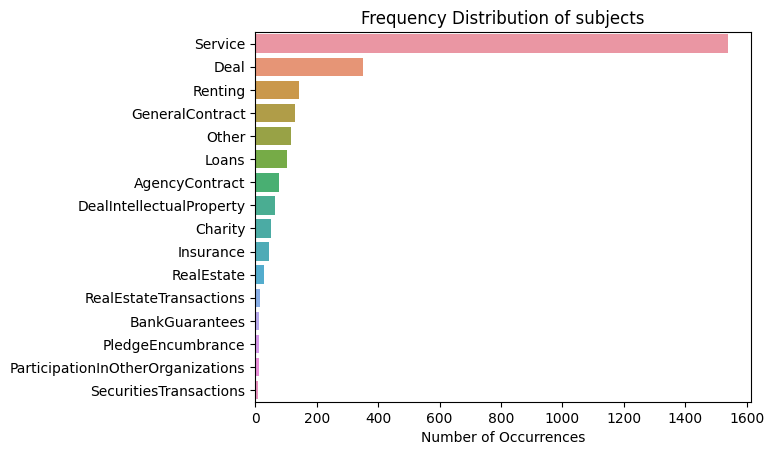


min 8
max 1538
total 2708


In [27]:
%matplotlib inline

subj_count = stats_valid['subject'].value_counts()

#plot distribution---------------------
sns.barplot(subj_count.values, subj_count.index)
plt.title('Frequency Distribution of subjects')
plt.xlabel('Number of Occurrences')
plt.show()


print ('\nmin', min (subj_count.values))
print ('max', max (subj_count.values))
print ('total', sum (subj_count.values))

In [28]:
from sklearn.utils import class_weight
from trainsets.trainset_tools import get_feature_log_weights

_classes = stats_valid['subject'].unique().tolist()

print(f'classes: {_classes}')

# class_weights = class_weight.compute_class_weight('balanced', _classes, umtm.stats['subject'])
# class_weights = dict(zip(_classes, class_weights))


class_weights = get_feature_log_weights(stats_valid, 'subject')
class_weights

classes: ['Loans', 'Service', 'AgencyContract', 'Charity', 'BankGuarantees', 'SecuritiesTransactions', 'Renting', 'PledgeEncumbrance', 'DealIntellectualProperty', 'Deal', 'GeneralContract', 'Insurance', 'ParticipationInOtherOrganizations', 'RealEstateTransactions', 'RealEstate', 'Other']


Service                              0.496262
Deal                                 0.620818
Renting                              0.734895
GeneralContract                      0.748225
Other                                0.762067
Loans                                0.782562
AgencyContract                       0.835955
DealIntellectualProperty             0.872466
Charity                              0.926290
Insurance                            0.951254
RealEstate                           1.060578
RealEstateTransactions               1.285470
BankGuarantees                       1.380042
PledgeEncumbrance                    1.419915
ParticipationInOtherOrganizations    1.465653
SecuritiesTransactions               1.657550
Name: subject, dtype: float64

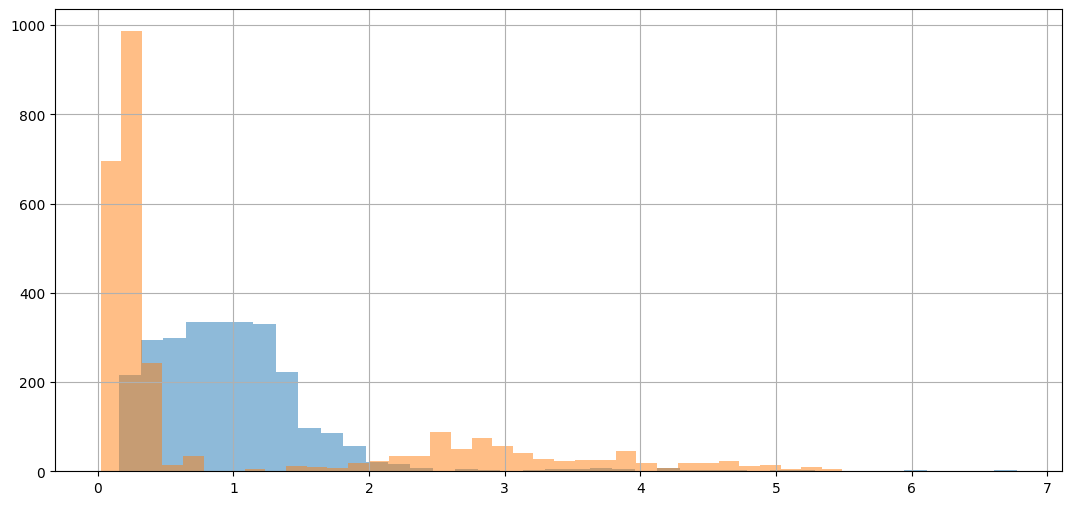

In [29]:
from trainsets.trainset_tools import get_feature_log_weights
 

plt.figure(figsize=(13, 6))

stats_valid['subject_weight'].hist(bins=40, alpha=0.5)
stats_valid['sample_weight'].hist(bins=40, alpha=0.5)

plt.xscale('linear') # log?
plt.show()

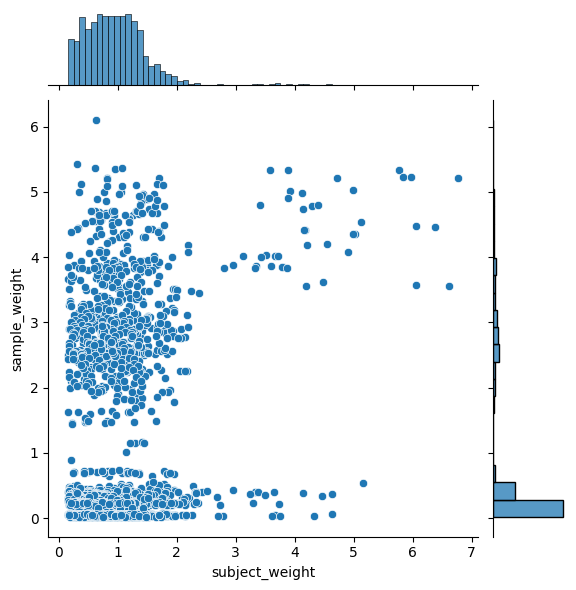

In [30]:
sns.jointplot(x="subject_weight", y="sample_weight", data=stats_valid)
plt.show()

# look into trainset (take a sample)

SAMPLE_DOC_ID 5fe34f62b770574a005553be
semantic map shape is: (759, 30)


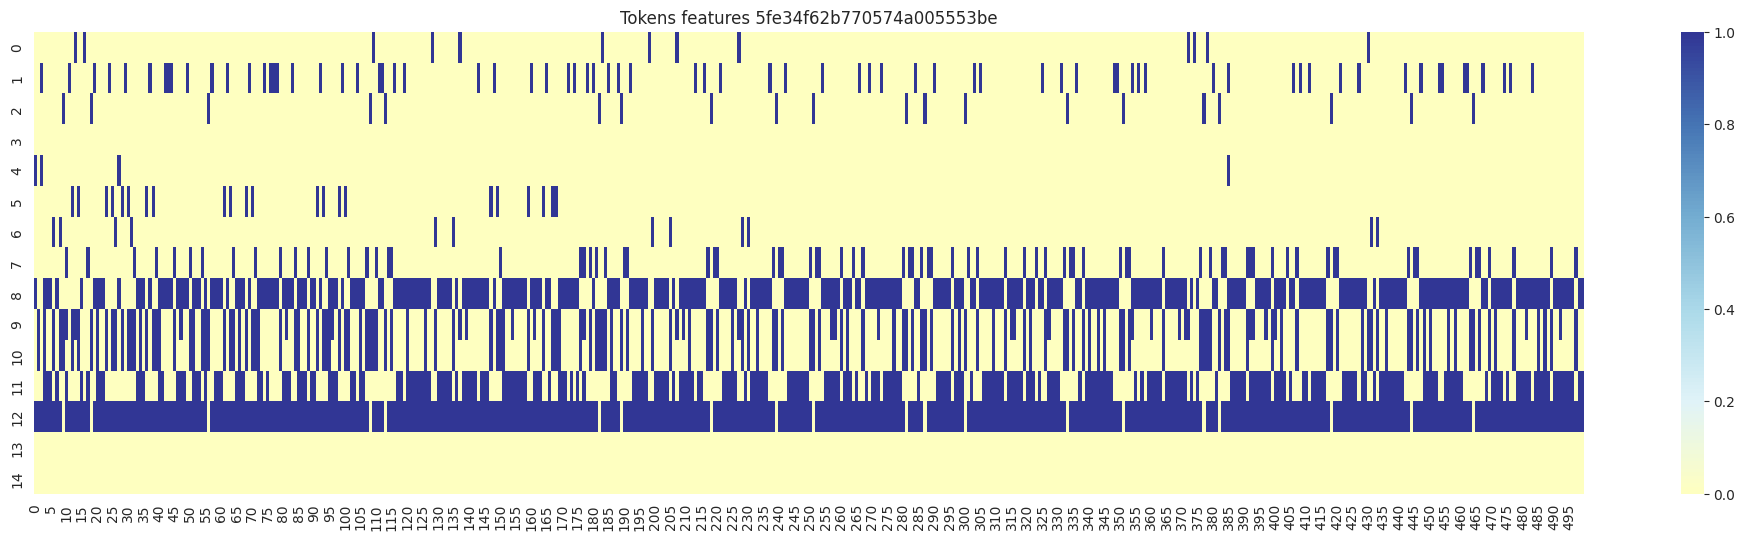

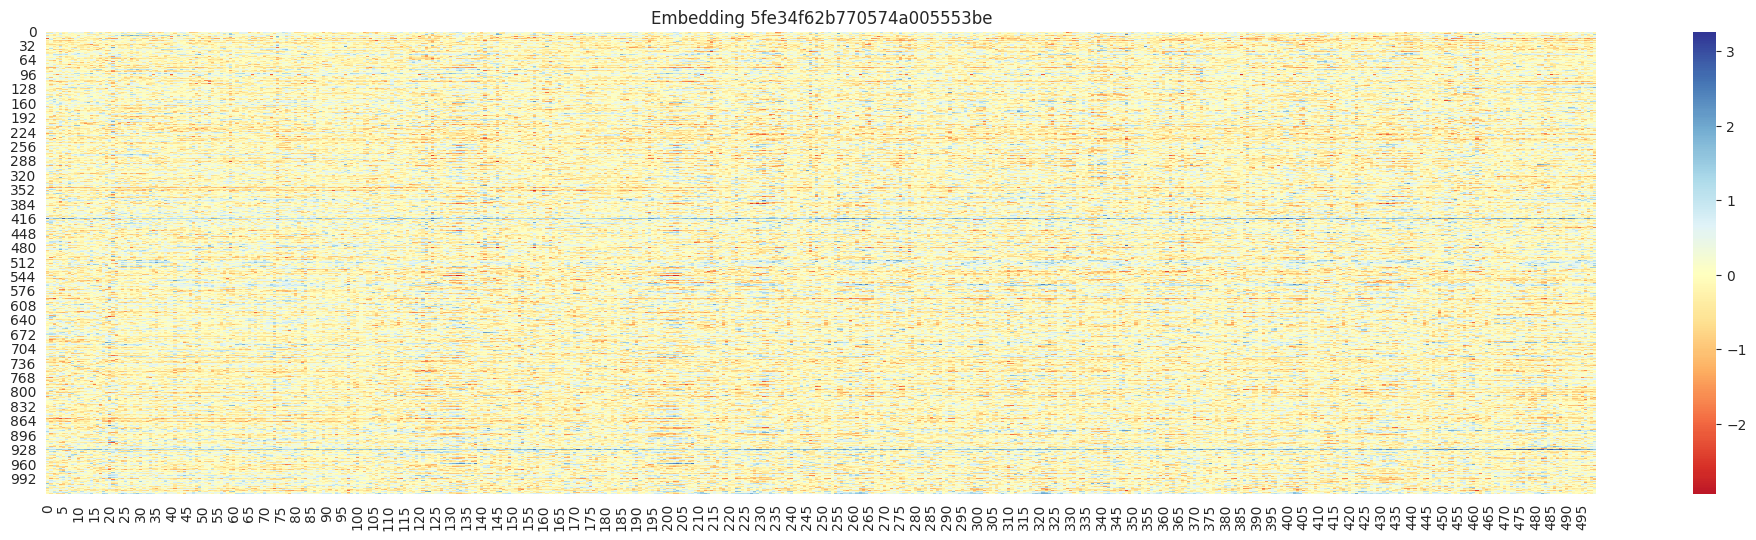

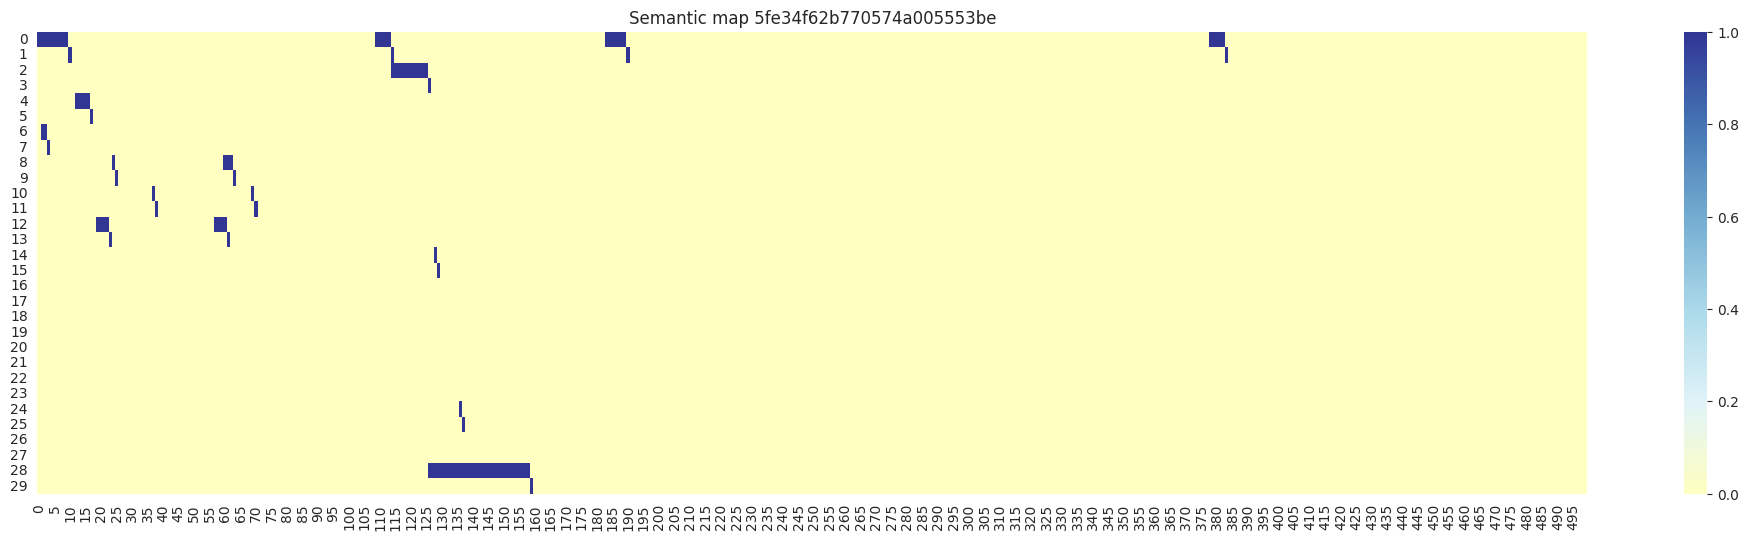

In [31]:
%matplotlib inline
# umtm.calculate_samples_weights()
SAMPLE_DOC_ID = '5fe34f62b770574a005553be' #stats_valid.index[1]

print('SAMPLE_DOC_ID', SAMPLE_DOC_ID)
(emb, tok_f), (sm, subj), (sample_weight, subject_weight) = make_xyw(SAMPLE_DOC_ID, stats)
 
    
print('semantic map shape is:', sm.shape)
_crop = 500
plot_embedding(tok_f[:_crop], title=f'Tokens features {SAMPLE_DOC_ID}') 
plot_embedding(emb[:_crop], title=f'Embedding {SAMPLE_DOC_ID}') 
plot_embedding(sm[:_crop], title=f'Semantic map {SAMPLE_DOC_ID}')



# Batch generator & TODOs 🙏


- [X] TODO: add outliers to the trainset ?
- [ ] TODO: try sparse_categorical_entropy instead of one-hot encodings
- [ ] TODO: model 5.2, 5.1: bipolar concat layer is wrong because we concatenate thongs of different magnitudes. Add a Sigmoid activation layer
- [ ] TODO: chechk what is better: to pad with zeros or to pad with means
- [X] TODO: add weights to samples
- [ ] TODO: sum semantic map alongside vertical axis, and mutiply it (as a mask) by the subject detection seq
- [ ] TODO: introduce individual per tag threshosholds, also, the current 0.3 threshold is strange.

3
semantic map shape is: (14, 433, 30)


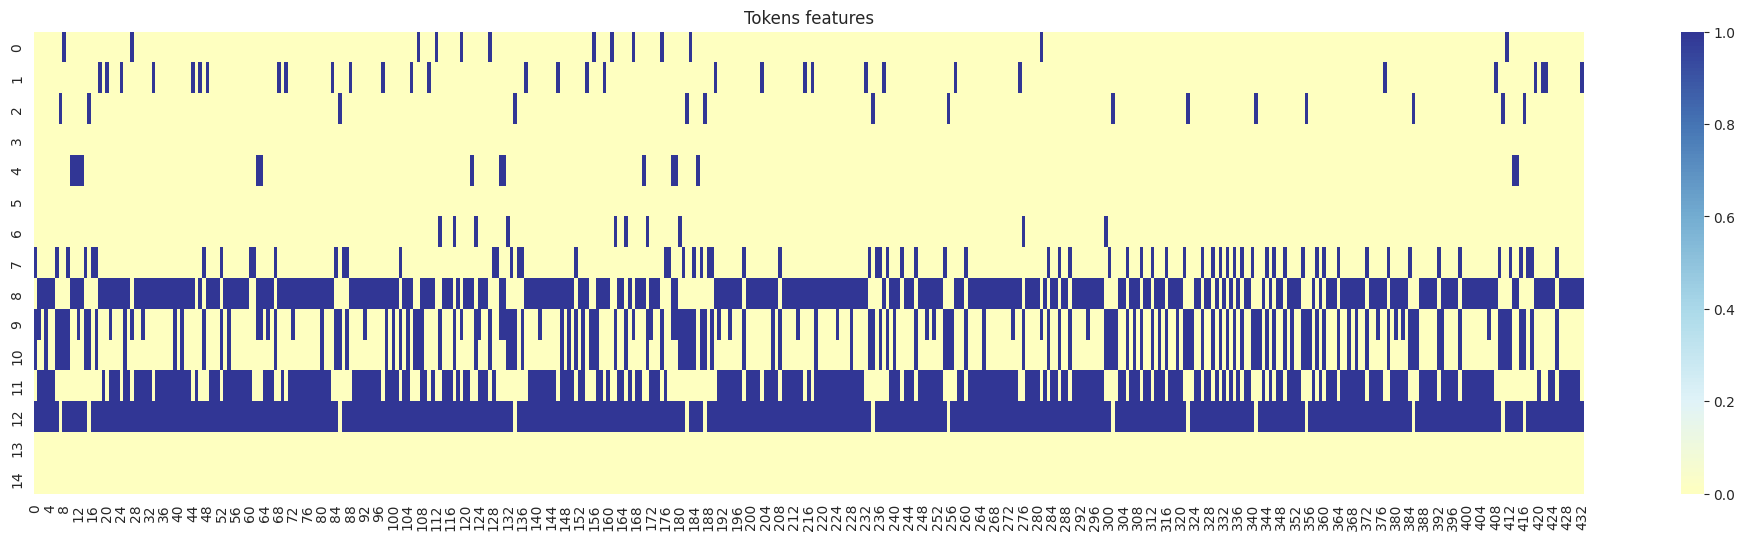

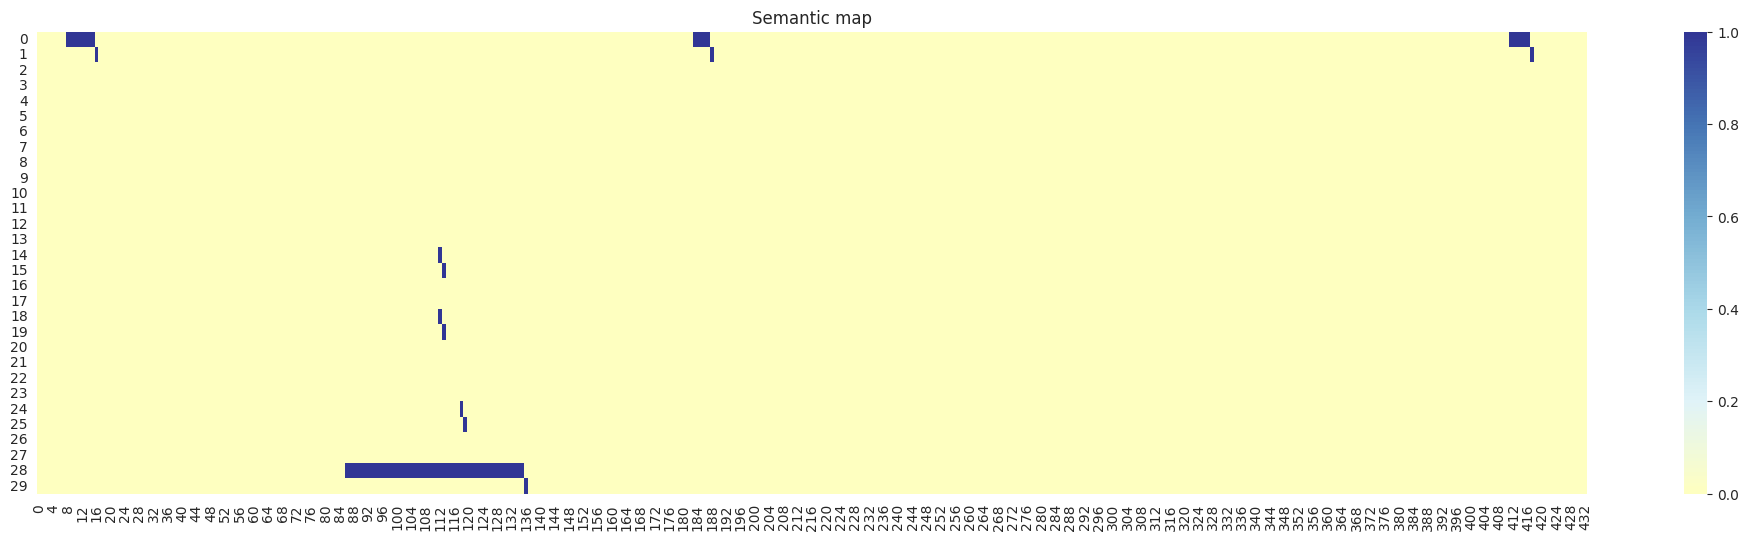

In [32]:
import numpy as np
import random
import pandas as pd

def make_generator(self, indices: [int], batch_size: int, augment_samples=False):
  np.random.seed(43)

  while True:
    # next batch
    batch_indices = np.random.choice(a=indices, size=batch_size)

    max_len = 128 * 12
    start_from = 0

    if augment_samples:
      max_len = random.randint(300, 1400)

    batch_input_emb = []
    batch_input_token_f = []
    batch_output_sm = []
    batch_output_subj = []

    weights = []
    weights_subj = []

    # Read in each input, perform preprocessing and get labels
    for doc_id in batch_indices:

      dp = make_xyw(doc_id, stats)
      (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp
        
#       print(dp)
    
      subject_weight_K = 1.0
      if augment_samples:
        start_from = 0

        row = stats_valid.loc[doc_id]
        if random.random() < 0.4:  # 40% of samples
          segment_center = random.randint(0, len(emb) - 1)  ##select random token as a center
          if not pd.isna(row['value_span']) and random.random() < 0.7:
            segment_center = int(row['value_span'])

          _off = random.randint(max_len // 4, max_len // 2)
          start_from = segment_center - _off
          if start_from < 0:
            start_from = 0
          subject_weight_K = 0.1  # lower subject weight because there mighе be no information about subject around doc. value
        
      dp = self.trim_maxlen(dp, start_from, max_len)
      
      # TODO: find samples maxlen

      (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp
#       print((sample_weight, subject_weight))
      subject_weight *= subject_weight_K

      batch_input_emb.append(emb)
      batch_input_token_f.append(tok_f)

      batch_output_sm.append(sm)
      batch_output_subj.append(subj)

      if np.isnan(sample_weight):
        raise ValueError()

      if np.isnan(subject_weight):
        raise ValueError()
      
      weights.append(sample_weight)
      weights_subj.append(subject_weight)
      # end if emb
    # end for loop

    # Returns a tuple of (input, output, weights) to feed the network
#     print('batch_output_subj', len(batch_output_subj))
#     print('batch_output_sm', len(batch_output_subj))

    yield ([np.array(batch_input_emb), np.array(batch_input_token_f)],
           [np.array(batch_output_sm), np.array(batch_output_subj)],
           [np.array(weights), np.array(weights_subj)])
    

    
_train, _test = train_test_split(stats_valid, test_size=0.10, stratify=stats_valid[['subject']])

train_indices = list(_train.index)
test_indices = list(_test.index)

    
####---test
_gen = make_generator(umtm, train_indices, 14, augment_samples=True)

sample = next(_gen)
print(len(sample))
del _gen
 


(emb, tok_f), (sm, subj), (sample_weight, subject_weight) = sample
 
    
print('semantic map shape is:', sm.shape)
_crop = 500
plot_embedding(tok_f[0][:_crop], title=f'Tokens features') 
# plot_embedding(emb[:_crop],   title=f'Embedding {SAMPLE_DOC_ID}') 
plot_embedding(sm[0][:_crop],    title=f'Semantic map')

In [33]:
SAMPLE_DOC_ID

'5fe34f62b770574a005553be'

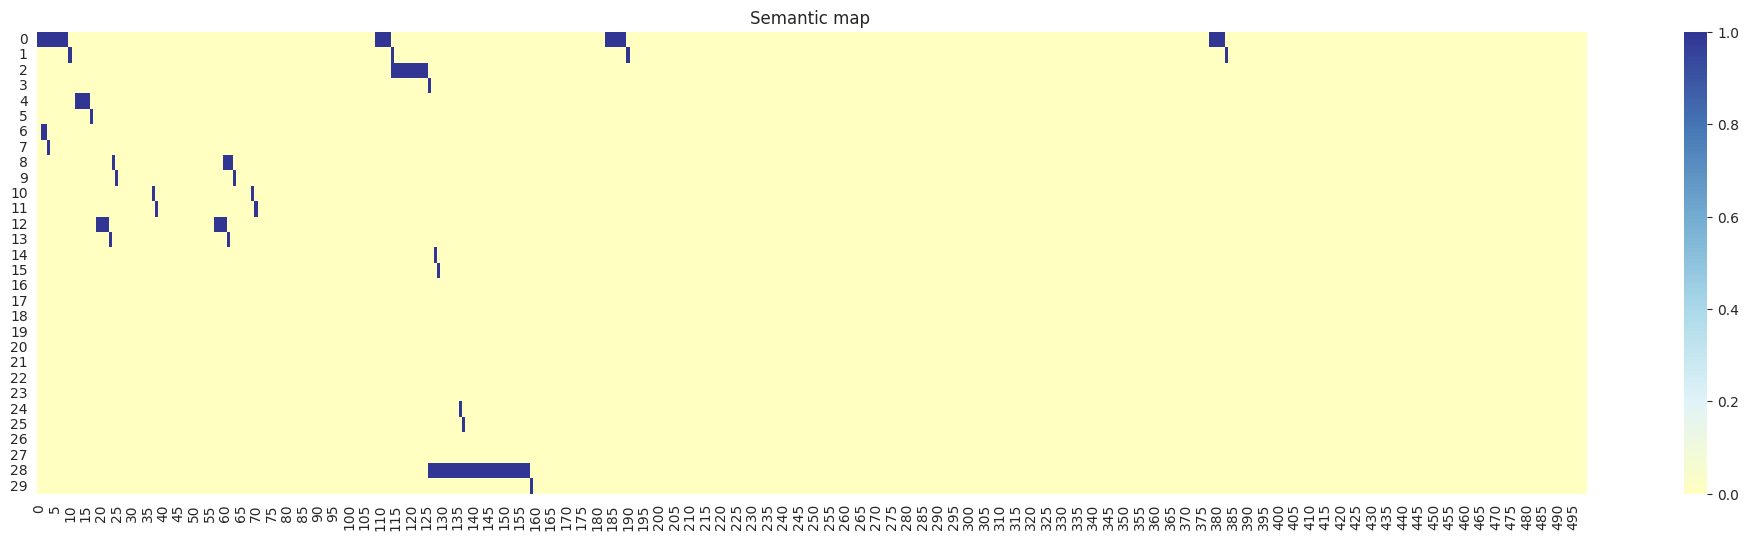

In [34]:
dp = make_xyw('5fe34f62b770574a005553be', stats_valid)

(emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp

plot_embedding(sm[:500],    title=f'Semantic map ')

train_indices[0]: 63ce4a2ee83d1ee490f3f503
test_indices[0]: 5fb3d49e78df3635f5441bc3


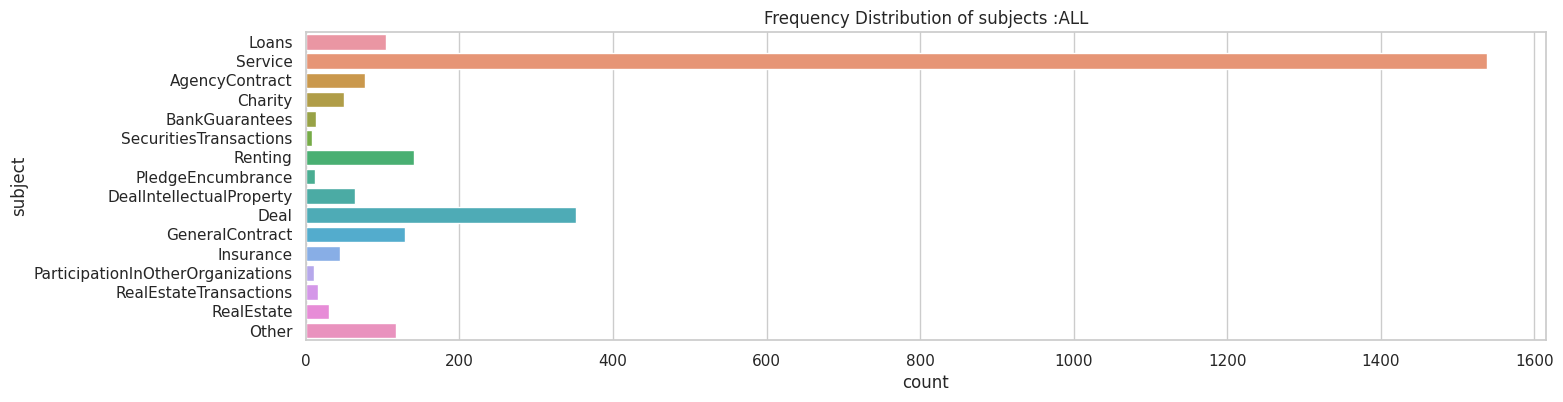

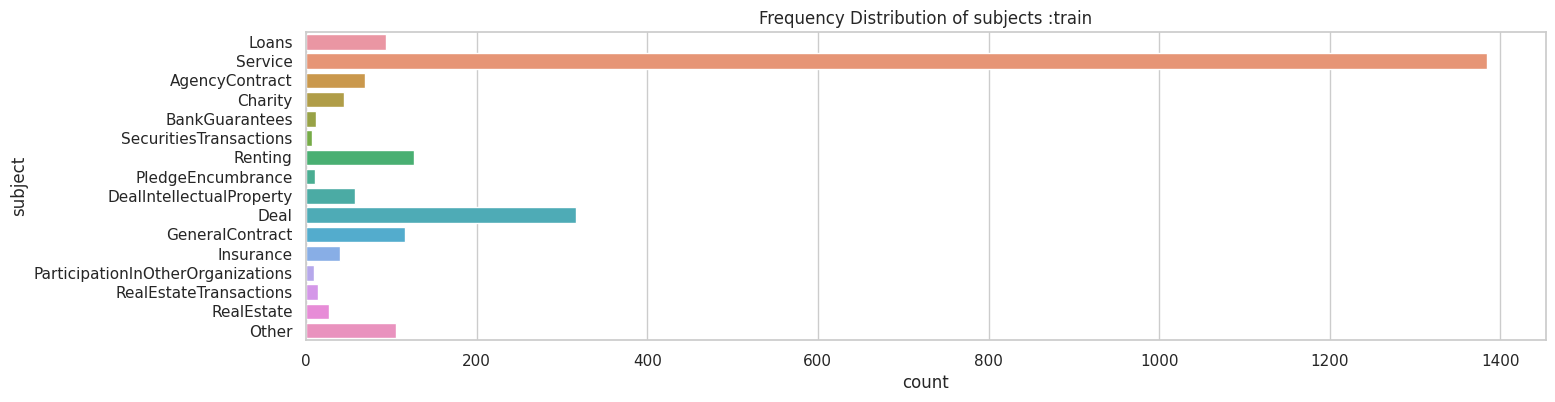

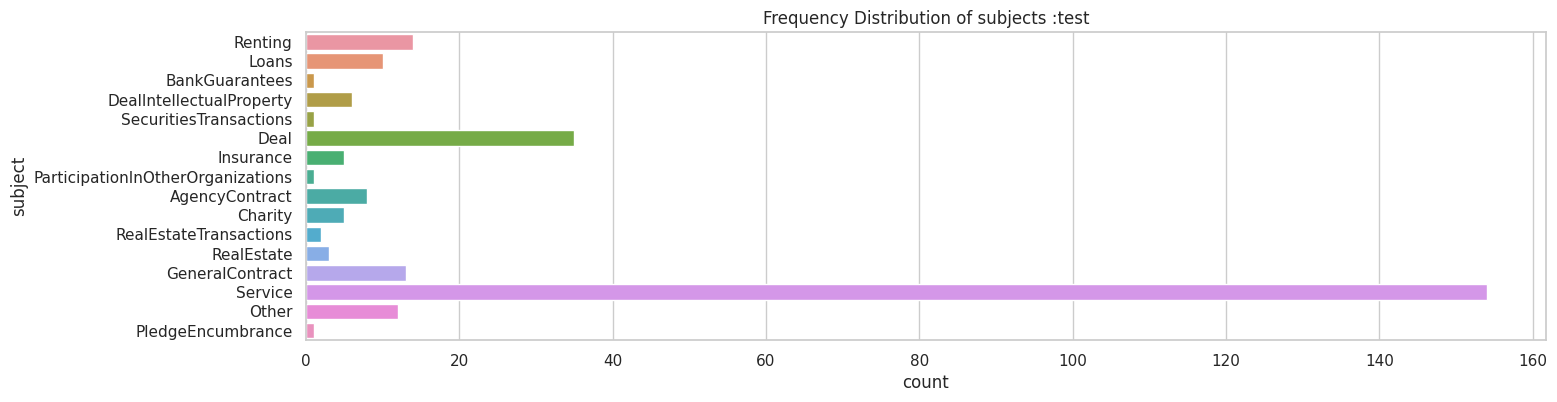

In [35]:
EPOCHS = 50
BATCH_SIZE = 96
EMB =  1024
 
_SELFTEST = True


print('train_indices[0]:', train_indices[0])
print('test_indices[0]:', test_indices[0])


def plot_subject_distr(df, title):  
  target='subject'
  plt.figure(figsize=(16,4))   
  sns.set(style="whitegrid")
  chart = sns.countplot(data=df, y=target)
  plt.title(f'Frequency Distribution of subjects :{title}')

 
plot_subject_distr(stats_valid, 'ALL')
plot_subject_distr(stats_valid[stats_valid.index.isin(train_indices)], 'train')
plot_subject_distr(stats_valid[stats_valid.index.isin(test_indices)], 'test')


if _SELFTEST:
  # test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True)
  
  x, y, w = next(train_gen)
  
#   print('X:', len(x), 'X[0]=', x[0].shape, 'X[1]=', x[1].shape)
#   print('Y:', len(y), 'Y[0]=', y[0].shape, 'Y[1]=', y[1].shape)
  

#   plot_embedding(x[0][0], 'X2: Token Embeddings')
#   plot_embedding(x[1][0], 'X1: Token Features')
#   plot_embedding(y[0][0], 'Y: Semantic Map')
  
#   print(y[0][1])

#   del x
#   del w
#   del y
#   del train_gen

In [36]:

ctx = KerasTrainingContext(checkpoints_path=umtm.reports_dir, session_index=1)

ctx.set_batch_size_and_trainset_size(BATCH_SIZE, 
                                     len(test_indices), 
                                     4 * len(train_indices))

DEFAULT_TRAIN_CTX = ctx
CLASSES = 43
FEATURES = 14

metrics = ['kullback_leibler_divergence', 'mse', 'binary_crossentropy']


def train(umodel):
  test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 
  ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen)

def overtrain(umodel):
  test_gen = make_generator(umtm, list(train_indices) + list(test_indices), BATCH_SIZE)
  train_gen = make_generator(umtm, list(train_indices) + list(test_indices), BATCH_SIZE, augment_samples=True) 
  ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen)


[tools.py:29 -             __init__() ] model_checkpoint_path: /root/artem/analyser/training_reports


batch_size:	96
train_samples:	9748
test_samples:	271
steps_per_epoch:	101
validation_steps:	50


# Models 🦖

In [37]:
def get_weights_filename(model_factory_fn):
    weights = ctx.model_checkpoint_path / f'{model_factory_fn.__name__}.h5'
    print(weights.is_file(), weights)
    if not weights.is_file():
        weights = Path(analyser.hyperparams.models_path) / f'{model_factory_fn.__name__}.h5'
        print(weights.is_file(), weights)
    
    return weights

# get_weights_filename(uber_detection_model_005_1_1)

## Train from 0 uber_detection_model_003

In [38]:
if TRAIN_MODEL_3:
    from tf_support.super_contract_model import uber_detection_model_003
    
    model_factory_fn = uber_detection_model_003
    umodel = ctx.init_model(model_factory_fn, trained=True, trainable=True, load_weights=False )

    umodel.summary()

    if TRAIN:
      test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
      train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 

      ctx.EPOCHS = 10
      ctx.EVALUATE_ONLY = False
      ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen, retrain=True)

## Continue training 003 from checkpoint

In [39]:
analyser.hyperparams.models_path

'/root/artem/analyser/analyser/vocab'

In [40]:
if TRAIN_MODEL_3:
    
    model_factory_fn = uber_detection_model_003

    weights = get_weights_filename(model_factory_fn)
    umodel = ctx.init_model(model_factory_fn, trained=True, trainable=True, weights=weights)

    if TRAIN:
      test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
      train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 

      ctx.EPOCHS = 25
      ctx.EVALUATE_ONLY = False
      ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen, retrain=True)

## Overtrain 003

In [41]:
if TRAIN_MODEL_3:
    if TRAIN:
      ctx.unfreezeModel(umodel)
      umodel.compile(loss=super_contract_model.losses, optimizer='Adam', metrics=super_contract_model.metrics)
      print(super_contract_model.losses)
      umodel.summary()

      ctx.EPOCHS = 12
      ctx.EVALUATE_ONLY = False

      test_gen = make_generator(umtm, train_indices, BATCH_SIZE)
      train_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE, augment_samples=True) 

      ctx.train_and_evaluate_model(umodel, train_gen, test_generator=test_gen, retrain=False, lr=2e-5)

## 005 model
- 0.0233: last val subject loss
- 0.0016: last tagging loss
- 0.0248: last val loss


In [42]:
if TRAIN_MODEL_3:
    model_factory_fn = uber_detection_model_005_1_1
    umodel = ctx.init_model(model_factory_fn, trained=True, trainable=True, load_weights=False )

    umodel.summary()

    if TRAIN:
      test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
      train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 

      ctx.EPOCHS = 20
      ctx.EVALUATE_ONLY = False
      ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen, retrain=True)

### 5.1.1 💕💕 uber_detection_model_005_1_1

In [43]:
from tf_support.super_contract_model import FEATURES 
from analyser.headers_detector import TOKEN_FEATURES

from tf_support.super_contract_model import sigmoid_focal_crossentropy, losses

import numpy as np
from pandas import DataFrame 



model_factory_fn = uber_detection_model_005_1_1
weights = get_weights_filename(model_factory_fn)
umodel = ctx.init_model(model_factory_fn, trained=True, trainable=True, weights=weights)
# umodel = ctx.init_model(model_factory_fn, trained=True, trainable=True, load_weights=False )

True /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5


2023-02-04 15:59:11.850562: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-02-04 15:59:12.353876: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-04 15:59:12.354574: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: A100-PCIE-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-02-04 15:59:12.354591: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-02-04 15:59:12.354625: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-02-04 15:59:12.354641: I tensorflow/stream_executor/platform/defa

[tools.py:121 -           init_model() ] weights loaded: /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5


In [44]:
######################
# Phase I retraining
# ❄️ frozen bottom layers
######################
if False:
    if TRAIN:
      test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
      train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 

      ctx.EPOCHS = 10
      ctx.EVALUATE_ONLY = False
      ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen, retrain=True)

In [45]:
23

23

#### Phase II finetuning
all unfrozen, entire trainset, low LR
 

In [46]:
######################
## Phase II finetuning
#  all unfrozen, entire trainset, low LR
######################
if TRAIN and False:
  ctx.unfreezeModel(umodel)
  umodel.compile(loss=super_contract_model.losses, optimizer='Adam', metrics=super_contract_model.metrics)
  umodel.summary()
  
  ctx.EPOCHS = 30
  ctx.EVALUATE_ONLY = False
  ctx.EPOCHS *= 2

  test_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE, augment_samples=True) 
  
  ctx.train_and_evaluate_model(umodel, train_gen, test_generator=test_gen, retrain=True, lr=1e-5)

## 🥰 Att model

In [47]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from dataclasses import dataclass
import pandas as pd
import numpy as np
import glob
import re
from pprint import pprint

from analyser.headers_detector import TOKEN_FEATURES
from tf_support.super_contract_model import EMB, CLASSES, DEFAULT_TRAIN_CTX, FEATURES
from functools import lru_cache
from pathlib import Path

import numpy as np
from pandas import DataFrame
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv1D, Dropout, LSTM, Bidirectional, Dense, MaxPooling1D, ReLU
from tensorflow.keras.layers import concatenate

from analyser.headers_detector import TOKEN_FEATURES
from analyser.hyperparams import work_dir

from analyser.structures import ContractSubject
from tf_support.addons import sigmoid_focal_crossentropy
from tf_support.tools import KerasTrainingContext


@dataclass
class Config:
  # MAX_LEN = 256
  # BATCH_SIZE = 32
  LR = 0.001

  EMBED_DIM = EMB
  NUM_HEAD = 4  # used in bert model
  FF_DIM = 128  # used in bert model
  NUM_LAYERS = 1


config = Config()


def bert_module(query, key, value, i, height):
  # Multi headed self-attention
  attention_output = layers.MultiHeadAttention(
    num_heads=config.NUM_HEAD,
    key_dim=config.EMBED_DIM // config.NUM_HEAD,
    name="encoder_{}/multiheadattention".format(i),
  )(query, key, value)
  attention_output = layers.Dropout(0.1, name="encoder_{}/att_dropout".format(i))(
    attention_output
  )
  attention_output = layers.LayerNormalization(
    epsilon=1e-6, name=f"encoder_{i}/att_layernormalization"
  )(query + attention_output)

  # Feed-forward layer
  ffn = keras.Sequential(
    [
      layers.Dense(config.FF_DIM, activation="relu"),
      layers.Dense(height),
    ],
    name=f"encoder_{i}/ffn",
  )
  ffn_output = ffn(attention_output)
  ffn_output = layers.Dropout(0.1, name=f"encoder_{i}/ffn_dropout")(
    ffn_output
  )
  sequence_output = layers.LayerNormalization(
    epsilon=1e-6, name=f"encoder_{i}/ffn_layernormalization"
  )(attention_output + ffn_output)
  return sequence_output


metrics = ['mse', 'binary_crossentropy']

losses = {
  "O1_tagging": "binary_crossentropy",
  "O2_subject": "binary_crossentropy",
}


def make_att_model(name='make_att_model', ctx: KerasTrainingContext = DEFAULT_TRAIN_CTX, trained=False):
  

  input_text_emb = layers.Input(shape=[None, config.EMBED_DIM], dtype='float32', name="input_text_emb")
  _out = layers.BatchNormalization(name="bn1")(input_text_emb)
  _out = layers.Dropout(0.2, name="drops")(_out)  # small_drops_of_poison

  token_features = layers.Input(shape=[None, TOKEN_FEATURES], dtype='float32', name="token_features")
  token_features_n = layers.BatchNormalization(name="bn2")(token_features)

  _out = layers.concatenate([input_text_emb, token_features_n], axis=-1)

  for i in range(config.NUM_LAYERS):
    _out = bert_module(_out, _out, _out, i, height=config.EMBED_DIM + TOKEN_FEATURES)

  _out = layers.BatchNormalization(name="bn1")(_out)
  _out = LSTM(FEATURES, return_sequences=True, activation='tanh', name='O1_tagging_tanh')(_out)
  _out1 = ReLU(name='O1_tagging')(_out)

  #   _out = Conv1D(filters=FEATURES * 4, kernel_size=(2), padding='same', activation='relu' , name='embedding_reduced')(_out)
  _out = Bidirectional(LSTM(16, return_sequences=False, name='narcissisism'), name='embedding_reduced')(_out)
  _out = layers.BatchNormalization(name="bn_bi_2")(_out)
  _out = layers.Dropout(0.1)(_out)

  _out2 = Dense(CLASSES, activation='softmax', name='O2_subject')(_out)

  base_model_inputs = [input_text_emb, token_features]
  model = Model(inputs=base_model_inputs, outputs=[_out1, _out2], name=name)
  model.compile(loss=losses, optimizer='Adam', metrics=metrics)
  return model


 

    
weights = get_weights_filename(model_factory_fn)
# model_name = make_att_model.__name__
umodel = make_att_model()

# umodel.load_weights(weights, by_name=True, skip_mismatch=True)
# ctx.init_model(make_att_model, trained=True, trainable=True, weights=weights)



True /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5


In [48]:

if TRAIN:
#   ctx.unfreezeModel(umodel)
  umodel.summary()
  
  ctx.EPOCHS = 50
  ctx.EVALUATE_ONLY = False
#   ctx.EPOCHS *= 2

  test_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE, augment_samples=True) 
  
  ctx.train_and_evaluate_model(umodel, train_gen, test_generator=test_gen, retrain=True, lr=config.LR)

Model: "make_att_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
token_features (InputLayer)     [(None, None, 15)]   0                                            
__________________________________________________________________________________________________
input_text_emb (InputLayer)     [(None, None, 1024)] 0                                            
__________________________________________________________________________________________________
bn2 (BatchNormalization)        (None, None, 15)     60          token_features[0][0]             
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, None, 1039)   0           input_text_emb[0][0]             
                                                                 bn2[0][0]           

/root/artem/env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


2023-02-04 15:59:15.602658: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-02-04 15:59:15.621917: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3699850000 Hz


Epoch 1/50


2023-02-04 15:59:18.389424: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11


2023-02-04 15:59:19.512380: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-02-04 15:59:19.512429: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-02-04 15:59:19.602265: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8


2023-02-04 15:59:19.849191: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8500


  1/101 [..............................] - ETA: 8:07 - loss: 0.6921 - O1_tagging_loss: 0.2401 - O2_subject_loss: 0.4520 - O1_tagging_mse: 0.0512 - O1_tagging_binary_crossentropy: 0.2049 - O2_subject_mse: 0.0232 - O2_subject_binary_crossentropy: 0.7900

  2/101 [..............................] - ETA: 41s - loss: 0.6569 - O1_tagging_loss: 0.1949 - O2_subject_loss: 0.4620 - O1_tagging_mse: 0.0467 - O1_tagging_binary_crossentropy: 0.1840 - O2_subject_mse: 0.0231 - O2_subject_binary_crossentropy: 0.7881 

  3/101 [..............................] - ETA: 52s - loss: 0.6643 - O1_tagging_loss: 0.1938 - O2_subject_loss: 0.4705 - O1_tagging_mse: 0.0446 - O1_tagging_binary_crossentropy: 0.1771 - O2_subject_mse: 0.0229 - O2_subject_binary_crossentropy: 0.7847

  4/101 [>.............................] - ETA: 1:03 - loss: 0.6257 - O1_tagging_loss: 0.1696 - O2_subject_loss: 0.4560 - O1_tagging_mse: 0.0425 - O1_tagging_binary_crossentropy: 0.1685 - O2_subject_mse: 0.0228 - O2_subject_binary_crossentropy: 0.7836

  5/101 [>.............................] - ETA: 59s - loss: 0.6252 - O1_tagging_loss: 0.1622 - O2_subject_loss: 0.4629 - O1_tagging_mse: 0.0410 - O1_tagging_binary_crossentropy: 0.1632 - O2_subject_mse: 0.0228 - O2_subject_binary_crossentropy: 0.7810 

  6/101 [>.............................] - ETA: 1:03 - loss: 0.6142 - O1_tagging_loss: 0.1529 - O2_subject_loss: 0.4614 - O1_tagging_mse: 0.0396 - O1_tagging_binary_crossentropy: 0.1583 - O2_subject_mse: 0.0228 - O2_subject_binary_crossentropy: 0.7809

  7/101 [=>............................] - ETA: 1:11 - loss: 0.5945 - O1_tagging_loss: 0.1453 - O2_subject_loss: 0.4492 - O1_tagging_mse: 0.0371 - O1_tagging_binary_crossentropy: 0.1493 - O2_subject_mse: 0.0228 - O2_subject_binary_crossentropy: 0.7793

  8/101 [=>............................] - ETA: 1:11 - loss: 0.5927 - O1_tagging_loss: 0.1418 - O2_subject_loss: 0.4509 - O1_tagging_mse: 0.0357 - O1_tagging_binary_crossentropy: 0.1448 - O2_subject_mse: 0.0228 - O2_subject_binary_crossentropy: 0.7787

  9/101 [=>............................] - ETA: 1:14 - loss: 0.5807 - O1_tagging_loss: 0.1363 - O2_subject_loss: 0.4444 - O1_tagging_mse: 0.0343 - O1_tagging_binary_crossentropy: 0.1401 - O2_subject_mse: 0.0228 - O2_subject_binary_crossentropy: 0.7783

 10/101 [=>............................] - ETA: 1:19 - loss: 0.5709 - O1_tagging_loss: 0.1312 - O2_subject_loss: 0.4397 - O1_tagging_mse: 0.0326 - O1_tagging_binary_crossentropy: 0.1343 - O2_subject_mse: 0.0228 - O2_subject_binary_crossentropy: 0.7777

 11/101 [==>...........................] - ETA: 1:20 - loss: 0.5599 - O1_tagging_loss: 0.1268 - O2_subject_loss: 0.4331 - O1_tagging_mse: 0.0312 - O1_tagging_binary_crossentropy: 0.1292 - O2_subject_mse: 0.0228 - O2_subject_binary_crossentropy: 0.7772

 12/101 [==>...........................] - ETA: 1:18 - loss: 0.5645 - O1_tagging_loss: 0.1255 - O2_subject_loss: 0.4390 - O1_tagging_mse: 0.0305 - O1_tagging_binary_crossentropy: 0.1267 - O2_subject_mse: 0.0228 - O2_subject_binary_crossentropy: 0.7773

 13/101 [==>...........................] - ETA: 1:19 - loss: 0.5569 - O1_tagging_loss: 0.1210 - O2_subject_loss: 0.4359 - O1_tagging_mse: 0.0290 - O1_tagging_binary_crossentropy: 0.1218 - O2_subject_mse: 0.0228 - O2_subject_binary_crossentropy: 0.7771

 14/101 [===>..........................] - ETA: 1:18 - loss: 0.5540 - O1_tagging_loss: 0.1184 - O2_subject_loss: 0.4357 - O1_tagging_mse: 0.0287 - O1_tagging_binary_crossentropy: 0.1208 - O2_subject_mse: 0.0227 - O2_subject_binary_crossentropy: 0.7776

 15/101 [===>..........................] - ETA: 1:20 - loss: 0.5527 - O1_tagging_loss: 0.1157 - O2_subject_loss: 0.4370 - O1_tagging_mse: 0.0280 - O1_tagging_binary_crossentropy: 0.1184 - O2_subject_mse: 0.0227 - O2_subject_binary_crossentropy: 0.7776

 16/101 [===>..........................] - ETA: 1:19 - loss: 0.5490 - O1_tagging_loss: 0.1121 - O2_subject_loss: 0.4369 - O1_tagging_mse: 0.0274 - O1_tagging_binary_crossentropy: 0.1162 - O2_subject_mse: 0.0228 - O2_subject_binary_crossentropy: 0.7780

 17/101 [====>.........................] - ETA: 1:20 - loss: 0.5440 - O1_tagging_loss: 0.1104 - O2_subject_loss: 0.4337 - O1_tagging_mse: 0.0270 - O1_tagging_binary_crossentropy: 0.1152 - O2_subject_mse: 0.0228 - O2_subject_binary_crossentropy: 0.7786

 18/101 [====>.........................] - ETA: 1:21 - loss: 0.5381 - O1_tagging_loss: 0.1072 - O2_subject_loss: 0.4309 - O1_tagging_mse: 0.0261 - O1_tagging_binary_crossentropy: 0.1117 - O2_subject_mse: 0.0227 - O2_subject_binary_crossentropy: 0.7790

 19/101 [====>.........................] - ETA: 1:22 - loss: 0.5324 - O1_tagging_loss: 0.1034 - O2_subject_loss: 0.4291 - O1_tagging_mse: 0.0250 - O1_tagging_binary_crossentropy: 0.1076 - O2_subject_mse: 0.0227 - O2_subject_binary_crossentropy: 0.7797

 20/101 [====>.........................] - ETA: 1:20 - loss: 0.5276 - O1_tagging_loss: 0.1015 - O2_subject_loss: 0.4261 - O1_tagging_mse: 0.0243 - O1_tagging_binary_crossentropy: 0.1053 - O2_subject_mse: 0.0227 - O2_subject_binary_crossentropy: 0.7801

 21/101 [=====>........................] - ETA: 1:18 - loss: 0.5217 - O1_tagging_loss: 0.0994 - O2_subject_loss: 0.4223 - O1_tagging_mse: 0.0239 - O1_tagging_binary_crossentropy: 0.1038 - O2_subject_mse: 0.0227 - O2_subject_binary_crossentropy: 0.7811

 22/101 [=====>........................] - ETA: 1:17 - loss: 0.5153 - O1_tagging_loss: 0.0972 - O2_subject_loss: 0.4181 - O1_tagging_mse: 0.0236 - O1_tagging_binary_crossentropy: 0.1030 - O2_subject_mse: 0.0227 - O2_subject_binary_crossentropy: 0.7821

 23/101 [=====>........................] - ETA: 1:15 - loss: 0.5084 - O1_tagging_loss: 0.0952 - O2_subject_loss: 0.4131 - O1_tagging_mse: 0.0233 - O1_tagging_binary_crossentropy: 0.1015 - O2_subject_mse: 0.0227 - O2_subject_binary_crossentropy: 0.7832

 24/101 [======>.......................] - ETA: 1:15 - loss: 0.5025 - O1_tagging_loss: 0.0933 - O2_subject_loss: 0.4092 - O1_tagging_mse: 0.0228 - O1_tagging_binary_crossentropy: 0.0999 - O2_subject_mse: 0.0227 - O2_subject_binary_crossentropy: 0.7843

 25/101 [======>.......................] - ETA: 1:14 - loss: 0.4988 - O1_tagging_loss: 0.0915 - O2_subject_loss: 0.4073 - O1_tagging_mse: 0.0224 - O1_tagging_binary_crossentropy: 0.0983 - O2_subject_mse: 0.0227 - O2_subject_binary_crossentropy: 0.7855

 26/101 [======>.......................] - ETA: 1:15 - loss: 0.4949 - O1_tagging_loss: 0.0892 - O2_subject_loss: 0.4056 - O1_tagging_mse: 0.0216 - O1_tagging_binary_crossentropy: 0.0953 - O2_subject_mse: 0.0227 - O2_subject_binary_crossentropy: 0.7863

 27/101 [=======>......................] - ETA: 1:15 - loss: 0.4880 - O1_tagging_loss: 0.0872 - O2_subject_loss: 0.4008 - O1_tagging_mse: 0.0211 - O1_tagging_binary_crossentropy: 0.0935 - O2_subject_mse: 0.0227 - O2_subject_binary_crossentropy: 0.7878

 28/101 [=======>......................] - ETA: 1:13 - loss: 0.4856 - O1_tagging_loss: 0.0858 - O2_subject_loss: 0.3998 - O1_tagging_mse: 0.0209 - O1_tagging_binary_crossentropy: 0.0924 - O2_subject_mse: 0.0228 - O2_subject_binary_crossentropy: 0.7892

 29/101 [=======>......................] - ETA: 1:15 - loss: 0.4818 - O1_tagging_loss: 0.0840 - O2_subject_loss: 0.3978 - O1_tagging_mse: 0.0200 - O1_tagging_binary_crossentropy: 0.0895 - O2_subject_mse: 0.0228 - O2_subject_binary_crossentropy: 0.7903

 30/101 [=======>......................] - ETA: 1:14 - loss: 0.4783 - O1_tagging_loss: 0.0822 - O2_subject_loss: 0.3961 - O1_tagging_mse: 0.0196 - O1_tagging_binary_crossentropy: 0.0876 - O2_subject_mse: 0.0228 - O2_subject_binary_crossentropy: 0.7910

 31/101 [========>.....................] - ETA: 1:15 - loss: 0.4760 - O1_tagging_loss: 0.0813 - O2_subject_loss: 0.3947 - O1_tagging_mse: 0.0191 - O1_tagging_binary_crossentropy: 0.0860 - O2_subject_mse: 0.0227 - O2_subject_binary_crossentropy: 0.7918

 32/101 [========>.....................] - ETA: 1:16 - loss: 0.4699 - O1_tagging_loss: 0.0797 - O2_subject_loss: 0.3902 - O1_tagging_mse: 0.0186 - O1_tagging_binary_crossentropy: 0.0838 - O2_subject_mse: 0.0227 - O2_subject_binary_crossentropy: 0.7935

 33/101 [========>.....................] - ETA: 1:15 - loss: 0.4649 - O1_tagging_loss: 0.0782 - O2_subject_loss: 0.3867 - O1_tagging_mse: 0.0181 - O1_tagging_binary_crossentropy: 0.0821 - O2_subject_mse: 0.0227 - O2_subject_binary_crossentropy: 0.7945

 34/101 [=========>....................] - ETA: 1:14 - loss: 0.4595 - O1_tagging_loss: 0.0766 - O2_subject_loss: 0.3829 - O1_tagging_mse: 0.0179 - O1_tagging_binary_crossentropy: 0.0812 - O2_subject_mse: 0.0227 - O2_subject_binary_crossentropy: 0.7963

 35/101 [=========>....................] - ETA: 1:14 - loss: 0.4561 - O1_tagging_loss: 0.0754 - O2_subject_loss: 0.3807 - O1_tagging_mse: 0.0174 - O1_tagging_binary_crossentropy: 0.0796 - O2_subject_mse: 0.0227 - O2_subject_binary_crossentropy: 0.7972

 36/101 [=========>....................] - ETA: 1:16 - loss: 0.4540 - O1_tagging_loss: 0.0744 - O2_subject_loss: 0.3796 - O1_tagging_mse: 0.0169 - O1_tagging_binary_crossentropy: 0.0776 - O2_subject_mse: 0.0227 - O2_subject_binary_crossentropy: 0.7986

 37/101 [=========>....................] - ETA: 1:15 - loss: 0.4527 - O1_tagging_loss: 0.0737 - O2_subject_loss: 0.3790 - O1_tagging_mse: 0.0164 - O1_tagging_binary_crossentropy: 0.0758 - O2_subject_mse: 0.0227 - O2_subject_binary_crossentropy: 0.7989

 38/101 [==========>...................] - ETA: 1:13 - loss: 0.4510 - O1_tagging_loss: 0.0735 - O2_subject_loss: 0.3775 - O1_tagging_mse: 0.0163 - O1_tagging_binary_crossentropy: 0.0755 - O2_subject_mse: 0.0227 - O2_subject_binary_crossentropy: 0.8011

 39/101 [==========>...................] - ETA: 1:12 - loss: 0.4486 - O1_tagging_loss: 0.0722 - O2_subject_loss: 0.3764 - O1_tagging_mse: 0.0160 - O1_tagging_binary_crossentropy: 0.0744 - O2_subject_mse: 0.0227 - O2_subject_binary_crossentropy: 0.8025

 40/101 [==========>...................] - ETA: 1:12 - loss: 0.4454 - O1_tagging_loss: 0.0710 - O2_subject_loss: 0.3744 - O1_tagging_mse: 0.0156 - O1_tagging_binary_crossentropy: 0.0727 - O2_subject_mse: 0.0227 - O2_subject_binary_crossentropy: 0.8041

 41/101 [===========>..................] - ETA: 1:10 - loss: 0.4436 - O1_tagging_loss: 0.0703 - O2_subject_loss: 0.3733 - O1_tagging_mse: 0.0153 - O1_tagging_binary_crossentropy: 0.0718 - O2_subject_mse: 0.0227 - O2_subject_binary_crossentropy: 0.8058

 42/101 [===========>..................] - ETA: 1:10 - loss: 0.4400 - O1_tagging_loss: 0.0692 - O2_subject_loss: 0.3708 - O1_tagging_mse: 0.0150 - O1_tagging_binary_crossentropy: 0.0707 - O2_subject_mse: 0.0227 - O2_subject_binary_crossentropy: 0.8079

 43/101 [===========>..................] - ETA: 1:08 - loss: 0.4362 - O1_tagging_loss: 0.0685 - O2_subject_loss: 0.3676 - O1_tagging_mse: 0.0149 - O1_tagging_binary_crossentropy: 0.0701 - O2_subject_mse: 0.0227 - O2_subject_binary_crossentropy: 0.8103

 44/101 [============>.................] - ETA: 1:07 - loss: 0.4346 - O1_tagging_loss: 0.0679 - O2_subject_loss: 0.3667 - O1_tagging_mse: 0.0148 - O1_tagging_binary_crossentropy: 0.0696 - O2_subject_mse: 0.0227 - O2_subject_binary_crossentropy: 0.8123

 45/101 [============>.................] - ETA: 1:06 - loss: 0.4314 - O1_tagging_loss: 0.0673 - O2_subject_loss: 0.3641 - O1_tagging_mse: 0.0145 - O1_tagging_binary_crossentropy: 0.0687 - O2_subject_mse: 0.0227 - O2_subject_binary_crossentropy: 0.8144

 46/101 [============>.................] - ETA: 1:05 - loss: 0.4288 - O1_tagging_loss: 0.0664 - O2_subject_loss: 0.3624 - O1_tagging_mse: 0.0143 - O1_tagging_binary_crossentropy: 0.0676 - O2_subject_mse: 0.0227 - O2_subject_binary_crossentropy: 0.8161

 47/101 [============>.................] - ETA: 1:04 - loss: 0.4261 - O1_tagging_loss: 0.0656 - O2_subject_loss: 0.3605 - O1_tagging_mse: 0.0140 - O1_tagging_binary_crossentropy: 0.0666 - O2_subject_mse: 0.0227 - O2_subject_binary_crossentropy: 0.8181

 48/101 [=============>................] - ETA: 1:03 - loss: 0.4228 - O1_tagging_loss: 0.0646 - O2_subject_loss: 0.3582 - O1_tagging_mse: 0.0138 - O1_tagging_binary_crossentropy: 0.0656 - O2_subject_mse: 0.0227 - O2_subject_binary_crossentropy: 0.8202

 49/101 [=============>................] - ETA: 1:01 - loss: 0.4206 - O1_tagging_loss: 0.0639 - O2_subject_loss: 0.3568 - O1_tagging_mse: 0.0136 - O1_tagging_binary_crossentropy: 0.0649 - O2_subject_mse: 0.0227 - O2_subject_binary_crossentropy: 0.8221

 50/101 [=============>................] - ETA: 1:00 - loss: 0.4188 - O1_tagging_loss: 0.0633 - O2_subject_loss: 0.3555 - O1_tagging_mse: 0.0135 - O1_tagging_binary_crossentropy: 0.0643 - O2_subject_mse: 0.0227 - O2_subject_binary_crossentropy: 0.8248

 51/101 [==============>...............] - ETA: 1:00 - loss: 0.4169 - O1_tagging_loss: 0.0625 - O2_subject_loss: 0.3545 - O1_tagging_mse: 0.0132 - O1_tagging_binary_crossentropy: 0.0632 - O2_subject_mse: 0.0227 - O2_subject_binary_crossentropy: 0.8264

 52/101 [==============>...............] - ETA: 59s - loss: 0.4148 - O1_tagging_loss: 0.0617 - O2_subject_loss: 0.3531 - O1_tagging_mse: 0.0130 - O1_tagging_binary_crossentropy: 0.0622 - O2_subject_mse: 0.0227 - O2_subject_binary_crossentropy: 0.8286 

 53/101 [==============>...............] - ETA: 58s - loss: 0.4119 - O1_tagging_loss: 0.0611 - O2_subject_loss: 0.3508 - O1_tagging_mse: 0.0128 - O1_tagging_binary_crossentropy: 0.0617 - O2_subject_mse: 0.0227 - O2_subject_binary_crossentropy: 0.8311

 54/101 [===============>..............] - ETA: 56s - loss: 0.4091 - O1_tagging_loss: 0.0610 - O2_subject_loss: 0.3481 - O1_tagging_mse: 0.0128 - O1_tagging_binary_crossentropy: 0.0615 - O2_subject_mse: 0.0227 - O2_subject_binary_crossentropy: 0.8337

 55/101 [===============>..............] - ETA: 55s - loss: 0.4067 - O1_tagging_loss: 0.0605 - O2_subject_loss: 0.3462 - O1_tagging_mse: 0.0126 - O1_tagging_binary_crossentropy: 0.0609 - O2_subject_mse: 0.0227 - O2_subject_binary_crossentropy: 0.8360

 56/101 [===============>..............] - ETA: 54s - loss: 0.4050 - O1_tagging_loss: 0.0600 - O2_subject_loss: 0.3450 - O1_tagging_mse: 0.0125 - O1_tagging_binary_crossentropy: 0.0607 - O2_subject_mse: 0.0227 - O2_subject_binary_crossentropy: 0.8382

 57/101 [===============>..............] - ETA: 53s - loss: 0.4023 - O1_tagging_loss: 0.0597 - O2_subject_loss: 0.3426 - O1_tagging_mse: 0.0124 - O1_tagging_binary_crossentropy: 0.0605 - O2_subject_mse: 0.0227 - O2_subject_binary_crossentropy: 0.8407

 58/101 [================>.............] - ETA: 52s - loss: 0.3993 - O1_tagging_loss: 0.0592 - O2_subject_loss: 0.3401 - O1_tagging_mse: 0.0123 - O1_tagging_binary_crossentropy: 0.0602 - O2_subject_mse: 0.0226 - O2_subject_binary_crossentropy: 0.8429

 59/101 [================>.............] - ETA: 51s - loss: 0.3973 - O1_tagging_loss: 0.0589 - O2_subject_loss: 0.3384 - O1_tagging_mse: 0.0122 - O1_tagging_binary_crossentropy: 0.0598 - O2_subject_mse: 0.0226 - O2_subject_binary_crossentropy: 0.8449

 60/101 [================>.............] - ETA: 50s - loss: 0.3959 - O1_tagging_loss: 0.0587 - O2_subject_loss: 0.3372 - O1_tagging_mse: 0.0121 - O1_tagging_binary_crossentropy: 0.0597 - O2_subject_mse: 0.0226 - O2_subject_binary_crossentropy: 0.8472

 61/101 [=================>............] - ETA: 49s - loss: 0.3935 - O1_tagging_loss: 0.0583 - O2_subject_loss: 0.3352 - O1_tagging_mse: 0.0120 - O1_tagging_binary_crossentropy: 0.0592 - O2_subject_mse: 0.0226 - O2_subject_binary_crossentropy: 0.8493

 62/101 [=================>............] - ETA: 47s - loss: 0.3912 - O1_tagging_loss: 0.0580 - O2_subject_loss: 0.3333 - O1_tagging_mse: 0.0120 - O1_tagging_binary_crossentropy: 0.0591 - O2_subject_mse: 0.0226 - O2_subject_binary_crossentropy: 0.8512

 63/101 [=================>............] - ETA: 46s - loss: 0.3897 - O1_tagging_loss: 0.0581 - O2_subject_loss: 0.3316 - O1_tagging_mse: 0.0120 - O1_tagging_binary_crossentropy: 0.0591 - O2_subject_mse: 0.0226 - O2_subject_binary_crossentropy: 0.8536

 64/101 [==================>...........] - ETA: 44s - loss: 0.3874 - O1_tagging_loss: 0.0578 - O2_subject_loss: 0.3296 - O1_tagging_mse: 0.0118 - O1_tagging_binary_crossentropy: 0.0588 - O2_subject_mse: 0.0226 - O2_subject_binary_crossentropy: 0.8560

 65/101 [==================>...........] - ETA: 43s - loss: 0.3865 - O1_tagging_loss: 0.0577 - O2_subject_loss: 0.3289 - O1_tagging_mse: 0.0117 - O1_tagging_binary_crossentropy: 0.0584 - O2_subject_mse: 0.0226 - O2_subject_binary_crossentropy: 0.8578

 66/101 [==================>...........] - ETA: 42s - loss: 0.3852 - O1_tagging_loss: 0.0573 - O2_subject_loss: 0.3279 - O1_tagging_mse: 0.0116 - O1_tagging_binary_crossentropy: 0.0579 - O2_subject_mse: 0.0226 - O2_subject_binary_crossentropy: 0.8596

 67/101 [==================>...........] - ETA: 41s - loss: 0.3831 - O1_tagging_loss: 0.0569 - O2_subject_loss: 0.3262 - O1_tagging_mse: 0.0114 - O1_tagging_binary_crossentropy: 0.0572 - O2_subject_mse: 0.0226 - O2_subject_binary_crossentropy: 0.8619

 68/101 [===================>..........] - ETA: 40s - loss: 0.3809 - O1_tagging_loss: 0.0566 - O2_subject_loss: 0.3243 - O1_tagging_mse: 0.0113 - O1_tagging_binary_crossentropy: 0.0569 - O2_subject_mse: 0.0226 - O2_subject_binary_crossentropy: 0.8647

 69/101 [===================>..........] - ETA: 38s - loss: 0.3788 - O1_tagging_loss: 0.0562 - O2_subject_loss: 0.3226 - O1_tagging_mse: 0.0112 - O1_tagging_binary_crossentropy: 0.0564 - O2_subject_mse: 0.0226 - O2_subject_binary_crossentropy: 0.8672

 70/101 [===================>..........] - ETA: 37s - loss: 0.3775 - O1_tagging_loss: 0.0560 - O2_subject_loss: 0.3215 - O1_tagging_mse: 0.0112 - O1_tagging_binary_crossentropy: 0.0563 - O2_subject_mse: 0.0226 - O2_subject_binary_crossentropy: 0.8697

 71/101 [====================>.........] - ETA: 36s - loss: 0.3758 - O1_tagging_loss: 0.0556 - O2_subject_loss: 0.3202 - O1_tagging_mse: 0.0111 - O1_tagging_binary_crossentropy: 0.0559 - O2_subject_mse: 0.0226 - O2_subject_binary_crossentropy: 0.8723

 72/101 [====================>.........] - ETA: 35s - loss: 0.3739 - O1_tagging_loss: 0.0552 - O2_subject_loss: 0.3187 - O1_tagging_mse: 0.0109 - O1_tagging_binary_crossentropy: 0.0553 - O2_subject_mse: 0.0226 - O2_subject_binary_crossentropy: 0.8741

 73/101 [====================>.........] - ETA: 34s - loss: 0.3728 - O1_tagging_loss: 0.0552 - O2_subject_loss: 0.3176 - O1_tagging_mse: 0.0109 - O1_tagging_binary_crossentropy: 0.0551 - O2_subject_mse: 0.0226 - O2_subject_binary_crossentropy: 0.8763

 74/101 [====================>.........] - ETA: 33s - loss: 0.3719 - O1_tagging_loss: 0.0549 - O2_subject_loss: 0.3170 - O1_tagging_mse: 0.0108 - O1_tagging_binary_crossentropy: 0.0547 - O2_subject_mse: 0.0225 - O2_subject_binary_crossentropy: 0.8783

 75/101 [=====================>........] - ETA: 31s - loss: 0.3704 - O1_tagging_loss: 0.0548 - O2_subject_loss: 0.3155 - O1_tagging_mse: 0.0107 - O1_tagging_binary_crossentropy: 0.0545 - O2_subject_mse: 0.0225 - O2_subject_binary_crossentropy: 0.8800

 76/101 [=====================>........] - ETA: 30s - loss: 0.3692 - O1_tagging_loss: 0.0546 - O2_subject_loss: 0.3146 - O1_tagging_mse: 0.0106 - O1_tagging_binary_crossentropy: 0.0541 - O2_subject_mse: 0.0225 - O2_subject_binary_crossentropy: 0.8817

 77/101 [=====================>........] - ETA: 29s - loss: 0.3679 - O1_tagging_loss: 0.0547 - O2_subject_loss: 0.3133 - O1_tagging_mse: 0.0106 - O1_tagging_binary_crossentropy: 0.0539 - O2_subject_mse: 0.0225 - O2_subject_binary_crossentropy: 0.8841

 78/101 [======================>.......] - ETA: 28s - loss: 0.3661 - O1_tagging_loss: 0.0543 - O2_subject_loss: 0.3118 - O1_tagging_mse: 0.0104 - O1_tagging_binary_crossentropy: 0.0533 - O2_subject_mse: 0.0225 - O2_subject_binary_crossentropy: 0.8861

 79/101 [======================>.......] - ETA: 27s - loss: 0.3646 - O1_tagging_loss: 0.0540 - O2_subject_loss: 0.3106 - O1_tagging_mse: 0.0103 - O1_tagging_binary_crossentropy: 0.0528 - O2_subject_mse: 0.0225 - O2_subject_binary_crossentropy: 0.8888

 80/101 [======================>.......] - ETA: 25s - loss: 0.3634 - O1_tagging_loss: 0.0538 - O2_subject_loss: 0.3096 - O1_tagging_mse: 0.0102 - O1_tagging_binary_crossentropy: 0.0525 - O2_subject_mse: 0.0225 - O2_subject_binary_crossentropy: 0.8911

 81/101 [=======================>......] - ETA: 24s - loss: 0.3616 - O1_tagging_loss: 0.0535 - O2_subject_loss: 0.3081 - O1_tagging_mse: 0.0102 - O1_tagging_binary_crossentropy: 0.0523 - O2_subject_mse: 0.0225 - O2_subject_binary_crossentropy: 0.8940

 82/101 [=======================>......] - ETA: 23s - loss: 0.3604 - O1_tagging_loss: 0.0534 - O2_subject_loss: 0.3070 - O1_tagging_mse: 0.0102 - O1_tagging_binary_crossentropy: 0.0523 - O2_subject_mse: 0.0225 - O2_subject_binary_crossentropy: 0.8964

 83/101 [=======================>......] - ETA: 22s - loss: 0.3594 - O1_tagging_loss: 0.0534 - O2_subject_loss: 0.3060 - O1_tagging_mse: 0.0101 - O1_tagging_binary_crossentropy: 0.0521 - O2_subject_mse: 0.0225 - O2_subject_binary_crossentropy: 0.8987

 84/101 [=======================>......] - ETA: 20s - loss: 0.3582 - O1_tagging_loss: 0.0532 - O2_subject_loss: 0.3050 - O1_tagging_mse: 0.0101 - O1_tagging_binary_crossentropy: 0.0519 - O2_subject_mse: 0.0225 - O2_subject_binary_crossentropy: 0.9010

 85/101 [========================>.....] - ETA: 19s - loss: 0.3564 - O1_tagging_loss: 0.0531 - O2_subject_loss: 0.3033 - O1_tagging_mse: 0.0101 - O1_tagging_binary_crossentropy: 0.0519 - O2_subject_mse: 0.0224 - O2_subject_binary_crossentropy: 0.9033

 86/101 [========================>.....] - ETA: 18s - loss: 0.3551 - O1_tagging_loss: 0.0529 - O2_subject_loss: 0.3022 - O1_tagging_mse: 0.0100 - O1_tagging_binary_crossentropy: 0.0515 - O2_subject_mse: 0.0224 - O2_subject_binary_crossentropy: 0.9053

 87/101 [========================>.....] - ETA: 17s - loss: 0.3534 - O1_tagging_loss: 0.0526 - O2_subject_loss: 0.3008 - O1_tagging_mse: 0.0099 - O1_tagging_binary_crossentropy: 0.0512 - O2_subject_mse: 0.0224 - O2_subject_binary_crossentropy: 0.9076

 88/101 [=========================>....] - ETA: 16s - loss: 0.3519 - O1_tagging_loss: 0.0523 - O2_subject_loss: 0.2996 - O1_tagging_mse: 0.0098 - O1_tagging_binary_crossentropy: 0.0509 - O2_subject_mse: 0.0224 - O2_subject_binary_crossentropy: 0.9096

 89/101 [=========================>....] - ETA: 14s - loss: 0.3509 - O1_tagging_loss: 0.0520 - O2_subject_loss: 0.2989 - O1_tagging_mse: 0.0097 - O1_tagging_binary_crossentropy: 0.0505 - O2_subject_mse: 0.0224 - O2_subject_binary_crossentropy: 0.9110

 90/101 [=========================>....] - ETA: 13s - loss: 0.3496 - O1_tagging_loss: 0.0519 - O2_subject_loss: 0.2978 - O1_tagging_mse: 0.0097 - O1_tagging_binary_crossentropy: 0.0502 - O2_subject_mse: 0.0224 - O2_subject_binary_crossentropy: 0.9130

 91/101 [==========================>...] - ETA: 12s - loss: 0.3484 - O1_tagging_loss: 0.0517 - O2_subject_loss: 0.2967 - O1_tagging_mse: 0.0096 - O1_tagging_binary_crossentropy: 0.0500 - O2_subject_mse: 0.0224 - O2_subject_binary_crossentropy: 0.9156

 92/101 [==========================>...] - ETA: 11s - loss: 0.3472 - O1_tagging_loss: 0.0514 - O2_subject_loss: 0.2958 - O1_tagging_mse: 0.0096 - O1_tagging_binary_crossentropy: 0.0497 - O2_subject_mse: 0.0224 - O2_subject_binary_crossentropy: 0.9173

 93/101 [==========================>...] - ETA: 9s - loss: 0.3461 - O1_tagging_loss: 0.0512 - O2_subject_loss: 0.2948 - O1_tagging_mse: 0.0095 - O1_tagging_binary_crossentropy: 0.0496 - O2_subject_mse: 0.0224 - O2_subject_binary_crossentropy: 0.9190 

 94/101 [==========================>...] - ETA: 8s - loss: 0.3445 - O1_tagging_loss: 0.0510 - O2_subject_loss: 0.2935 - O1_tagging_mse: 0.0095 - O1_tagging_binary_crossentropy: 0.0494 - O2_subject_mse: 0.0223 - O2_subject_binary_crossentropy: 0.9212

 95/101 [===========================>..] - ETA: 7s - loss: 0.3430 - O1_tagging_loss: 0.0507 - O2_subject_loss: 0.2923 - O1_tagging_mse: 0.0094 - O1_tagging_binary_crossentropy: 0.0491 - O2_subject_mse: 0.0223 - O2_subject_binary_crossentropy: 0.9234

 96/101 [===========================>..] - ETA: 6s - loss: 0.3416 - O1_tagging_loss: 0.0504 - O2_subject_loss: 0.2912 - O1_tagging_mse: 0.0094 - O1_tagging_binary_crossentropy: 0.0488 - O2_subject_mse: 0.0223 - O2_subject_binary_crossentropy: 0.9253

 97/101 [===========================>..] - ETA: 4s - loss: 0.3405 - O1_tagging_loss: 0.0502 - O2_subject_loss: 0.2903 - O1_tagging_mse: 0.0093 - O1_tagging_binary_crossentropy: 0.0484 - O2_subject_mse: 0.0223 - O2_subject_binary_crossentropy: 0.9264

 98/101 [============================>.] - ETA: 3s - loss: 0.3392 - O1_tagging_loss: 0.0499 - O2_subject_loss: 0.2893 - O1_tagging_mse: 0.0092 - O1_tagging_binary_crossentropy: 0.0480 - O2_subject_mse: 0.0223 - O2_subject_binary_crossentropy: 0.9277

 99/101 [============================>.] - ETA: 2s - loss: 0.3381 - O1_tagging_loss: 0.0497 - O2_subject_loss: 0.2884 - O1_tagging_mse: 0.0092 - O1_tagging_binary_crossentropy: 0.0479 - O2_subject_mse: 0.0223 - O2_subject_binary_crossentropy: 0.9286

100/101 [============================>.] - ETA: 1s - loss: 0.3370 - O1_tagging_loss: 0.0495 - O2_subject_loss: 0.2875 - O1_tagging_mse: 0.0091 - O1_tagging_binary_crossentropy: 0.0475 - O2_subject_mse: 0.0223 - O2_subject_binary_crossentropy: 0.9296

101/101 [==============================] - ETA: 0s - loss: 0.3357 - O1_tagging_loss: 0.0494 - O2_subject_loss: 0.2863 - O1_tagging_mse: 0.0090 - O1_tagging_binary_crossentropy: 0.0472 - O2_subject_mse: 0.0223 - O2_subject_binary_crossentropy: 0.9307

101/101 [==============================] - 223s 2s/step - loss: 0.3357 - O1_tagging_loss: 0.0494 - O2_subject_loss: 0.2863 - O1_tagging_mse: 0.0090 - O1_tagging_binary_crossentropy: 0.0472 - O2_subject_mse: 0.0223 - O2_subject_binary_crossentropy: 0.9307 - val_loss: 0.4447 - val_O1_tagging_loss: 0.0306 - val_O2_subject_loss: 0.4142 - val_O1_tagging_mse: 0.0038 - val_O1_tagging_binary_crossentropy: 0.0293 - val_O2_subject_mse: 0.0214 - val_O2_subject_binary_crossentropy: 0.4098



Epoch 00001: val_loss improved from inf to 0.44475, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 2/50


  1/101 [..............................] - ETA: 23s - loss: 0.2200 - O1_tagging_loss: 0.0316 - O2_subject_loss: 0.1885 - O1_tagging_mse: 0.0047 - O1_tagging_binary_crossentropy: 0.0293 - O2_subject_mse: 0.0214 - O2_subject_binary_crossentropy: 1.0352

  2/101 [..............................] - ETA: 2:34 - loss: 0.2202 - O1_tagging_loss: 0.0261 - O2_subject_loss: 0.1941 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0238 - O2_subject_mse: 0.0213 - O2_subject_binary_crossentropy: 1.0396

  3/101 [..............................] - ETA: 2:15 - loss: 0.2314 - O1_tagging_loss: 0.0267 - O2_subject_loss: 0.2047 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0247 - O2_subject_mse: 0.0212 - O2_subject_binary_crossentropy: 1.0526

  4/101 [>.............................] - ETA: 2:22 - loss: 0.2298 - O1_tagging_loss: 0.0258 - O2_subject_loss: 0.2040 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0239 - O2_subject_mse: 0.0211 - O2_subject_binary_crossentropy: 1.0657

  5/101 [>.............................] - ETA: 2:04 - loss: 0.2270 - O1_tagging_loss: 0.0271 - O2_subject_loss: 0.1999 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0242 - O2_subject_mse: 0.0211 - O2_subject_binary_crossentropy: 1.0758

  6/101 [>.............................] - ETA: 2:12 - loss: 0.2277 - O1_tagging_loss: 0.0254 - O2_subject_loss: 0.2023 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0235 - O2_subject_mse: 0.0211 - O2_subject_binary_crossentropy: 1.0782

  7/101 [=>............................] - ETA: 2:11 - loss: 0.2274 - O1_tagging_loss: 0.0251 - O2_subject_loss: 0.2023 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0234 - O2_subject_mse: 0.0210 - O2_subject_binary_crossentropy: 1.0828

  8/101 [=>............................] - ETA: 2:07 - loss: 0.2242 - O1_tagging_loss: 0.0252 - O2_subject_loss: 0.1990 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0241 - O2_subject_mse: 0.0210 - O2_subject_binary_crossentropy: 1.0881

  9/101 [=>............................] - ETA: 2:02 - loss: 0.2244 - O1_tagging_loss: 0.0274 - O2_subject_loss: 0.1969 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0249 - O2_subject_mse: 0.0210 - O2_subject_binary_crossentropy: 1.0959

 10/101 [=>............................] - ETA: 1:59 - loss: 0.2245 - O1_tagging_loss: 0.0278 - O2_subject_loss: 0.1966 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0252 - O2_subject_mse: 0.0210 - O2_subject_binary_crossentropy: 1.1011

 11/101 [==>...........................] - ETA: 2:02 - loss: 0.2224 - O1_tagging_loss: 0.0275 - O2_subject_loss: 0.1949 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0249 - O2_subject_mse: 0.0209 - O2_subject_binary_crossentropy: 1.1034

 12/101 [==>...........................] - ETA: 1:58 - loss: 0.2208 - O1_tagging_loss: 0.0269 - O2_subject_loss: 0.1939 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0249 - O2_subject_mse: 0.0209 - O2_subject_binary_crossentropy: 1.1055

 13/101 [==>...........................] - ETA: 1:59 - loss: 0.2223 - O1_tagging_loss: 0.0273 - O2_subject_loss: 0.1950 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0247 - O2_subject_mse: 0.0209 - O2_subject_binary_crossentropy: 1.1071

 14/101 [===>..........................] - ETA: 2:01 - loss: 0.2223 - O1_tagging_loss: 0.0270 - O2_subject_loss: 0.1953 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0244 - O2_subject_mse: 0.0209 - O2_subject_binary_crossentropy: 1.1074

 15/101 [===>..........................] - ETA: 2:01 - loss: 0.2249 - O1_tagging_loss: 0.0277 - O2_subject_loss: 0.1971 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0245 - O2_subject_mse: 0.0208 - O2_subject_binary_crossentropy: 1.1079

 16/101 [===>..........................] - ETA: 1:58 - loss: 0.2241 - O1_tagging_loss: 0.0277 - O2_subject_loss: 0.1964 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0246 - O2_subject_mse: 0.0208 - O2_subject_binary_crossentropy: 1.1099

 17/101 [====>.........................] - ETA: 1:56 - loss: 0.2221 - O1_tagging_loss: 0.0277 - O2_subject_loss: 0.1945 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0245 - O2_subject_mse: 0.0208 - O2_subject_binary_crossentropy: 1.1114

 18/101 [====>.........................] - ETA: 1:54 - loss: 0.2220 - O1_tagging_loss: 0.0284 - O2_subject_loss: 0.1935 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0247 - O2_subject_mse: 0.0208 - O2_subject_binary_crossentropy: 1.1128

 19/101 [====>.........................] - ETA: 1:53 - loss: 0.2230 - O1_tagging_loss: 0.0281 - O2_subject_loss: 0.1950 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0246 - O2_subject_mse: 0.0208 - O2_subject_binary_crossentropy: 1.1083

 20/101 [====>.........................] - ETA: 1:51 - loss: 0.2216 - O1_tagging_loss: 0.0279 - O2_subject_loss: 0.1936 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0247 - O2_subject_mse: 0.0207 - O2_subject_binary_crossentropy: 1.1089

 21/101 [=====>........................] - ETA: 1:50 - loss: 0.2201 - O1_tagging_loss: 0.0279 - O2_subject_loss: 0.1921 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0247 - O2_subject_mse: 0.0207 - O2_subject_binary_crossentropy: 1.1101

 22/101 [=====>........................] - ETA: 1:47 - loss: 0.2199 - O1_tagging_loss: 0.0282 - O2_subject_loss: 0.1916 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0249 - O2_subject_mse: 0.0207 - O2_subject_binary_crossentropy: 1.1059

 23/101 [=====>........................] - ETA: 1:46 - loss: 0.2208 - O1_tagging_loss: 0.0284 - O2_subject_loss: 0.1924 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0250 - O2_subject_mse: 0.0207 - O2_subject_binary_crossentropy: 1.1053

 24/101 [======>.......................] - ETA: 1:46 - loss: 0.2221 - O1_tagging_loss: 0.0284 - O2_subject_loss: 0.1937 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0250 - O2_subject_mse: 0.0207 - O2_subject_binary_crossentropy: 1.1019

 25/101 [======>.......................] - ETA: 1:44 - loss: 0.2219 - O1_tagging_loss: 0.0288 - O2_subject_loss: 0.1931 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0250 - O2_subject_mse: 0.0207 - O2_subject_binary_crossentropy: 1.1032

 26/101 [======>.......................] - ETA: 1:41 - loss: 0.2227 - O1_tagging_loss: 0.0295 - O2_subject_loss: 0.1932 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0252 - O2_subject_mse: 0.0207 - O2_subject_binary_crossentropy: 1.1058

 27/101 [=======>......................] - ETA: 1:42 - loss: 0.2226 - O1_tagging_loss: 0.0295 - O2_subject_loss: 0.1931 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0249 - O2_subject_mse: 0.0207 - O2_subject_binary_crossentropy: 1.1053

 28/101 [=======>......................] - ETA: 1:40 - loss: 0.2217 - O1_tagging_loss: 0.0295 - O2_subject_loss: 0.1922 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0248 - O2_subject_mse: 0.0207 - O2_subject_binary_crossentropy: 1.1060

 29/101 [=======>......................] - ETA: 1:39 - loss: 0.2228 - O1_tagging_loss: 0.0294 - O2_subject_loss: 0.1933 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0248 - O2_subject_mse: 0.0207 - O2_subject_binary_crossentropy: 1.1055

 30/101 [=======>......................] - ETA: 1:37 - loss: 0.2224 - O1_tagging_loss: 0.0294 - O2_subject_loss: 0.1930 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0247 - O2_subject_mse: 0.0207 - O2_subject_binary_crossentropy: 1.1077

 31/101 [========>.....................] - ETA: 1:35 - loss: 0.2218 - O1_tagging_loss: 0.0293 - O2_subject_loss: 0.1925 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0248 - O2_subject_mse: 0.0207 - O2_subject_binary_crossentropy: 1.1098

 32/101 [========>.....................] - ETA: 1:33 - loss: 0.2217 - O1_tagging_loss: 0.0296 - O2_subject_loss: 0.1921 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0249 - O2_subject_mse: 0.0207 - O2_subject_binary_crossentropy: 1.1120

 33/101 [========>.....................] - ETA: 1:31 - loss: 0.2222 - O1_tagging_loss: 0.0302 - O2_subject_loss: 0.1920 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0251 - O2_subject_mse: 0.0207 - O2_subject_binary_crossentropy: 1.1128

 34/101 [=========>....................] - ETA: 1:29 - loss: 0.2217 - O1_tagging_loss: 0.0303 - O2_subject_loss: 0.1914 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0252 - O2_subject_mse: 0.0207 - O2_subject_binary_crossentropy: 1.1157

 35/101 [=========>....................] - ETA: 1:28 - loss: 0.2211 - O1_tagging_loss: 0.0304 - O2_subject_loss: 0.1907 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0253 - O2_subject_mse: 0.0207 - O2_subject_binary_crossentropy: 1.1173

 36/101 [=========>....................] - ETA: 1:28 - loss: 0.2217 - O1_tagging_loss: 0.0302 - O2_subject_loss: 0.1914 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0251 - O2_subject_mse: 0.0206 - O2_subject_binary_crossentropy: 1.1173

 37/101 [=========>....................] - ETA: 1:27 - loss: 0.2215 - O1_tagging_loss: 0.0300 - O2_subject_loss: 0.1914 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0250 - O2_subject_mse: 0.0206 - O2_subject_binary_crossentropy: 1.1182

 38/101 [==========>...................] - ETA: 1:25 - loss: 0.2214 - O1_tagging_loss: 0.0298 - O2_subject_loss: 0.1916 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0250 - O2_subject_mse: 0.0206 - O2_subject_binary_crossentropy: 1.1182

 39/101 [==========>...................] - ETA: 1:24 - loss: 0.2210 - O1_tagging_loss: 0.0298 - O2_subject_loss: 0.1912 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0250 - O2_subject_mse: 0.0206 - O2_subject_binary_crossentropy: 1.1185

 40/101 [==========>...................] - ETA: 1:22 - loss: 0.2211 - O1_tagging_loss: 0.0298 - O2_subject_loss: 0.1912 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0249 - O2_subject_mse: 0.0206 - O2_subject_binary_crossentropy: 1.1190

 41/101 [===========>..................] - ETA: 1:22 - loss: 0.2217 - O1_tagging_loss: 0.0299 - O2_subject_loss: 0.1918 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0248 - O2_subject_mse: 0.0205 - O2_subject_binary_crossentropy: 1.1191

 42/101 [===========>..................] - ETA: 1:20 - loss: 0.2206 - O1_tagging_loss: 0.0297 - O2_subject_loss: 0.1909 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0247 - O2_subject_mse: 0.0205 - O2_subject_binary_crossentropy: 1.1185

 43/101 [===========>..................] - ETA: 1:20 - loss: 0.2206 - O1_tagging_loss: 0.0295 - O2_subject_loss: 0.1911 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0245 - O2_subject_mse: 0.0205 - O2_subject_binary_crossentropy: 1.1178

 44/101 [============>.................] - ETA: 1:18 - loss: 0.2198 - O1_tagging_loss: 0.0294 - O2_subject_loss: 0.1905 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0244 - O2_subject_mse: 0.0205 - O2_subject_binary_crossentropy: 1.1170

 45/101 [============>.................] - ETA: 1:16 - loss: 0.2200 - O1_tagging_loss: 0.0294 - O2_subject_loss: 0.1905 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0246 - O2_subject_mse: 0.0204 - O2_subject_binary_crossentropy: 1.1149

 46/101 [============>.................] - ETA: 1:16 - loss: 0.2190 - O1_tagging_loss: 0.0293 - O2_subject_loss: 0.1896 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0245 - O2_subject_mse: 0.0204 - O2_subject_binary_crossentropy: 1.1138

 47/101 [============>.................] - ETA: 1:14 - loss: 0.2180 - O1_tagging_loss: 0.0296 - O2_subject_loss: 0.1884 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0246 - O2_subject_mse: 0.0204 - O2_subject_binary_crossentropy: 1.1130

 48/101 [=============>................] - ETA: 1:13 - loss: 0.2174 - O1_tagging_loss: 0.0295 - O2_subject_loss: 0.1879 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0245 - O2_subject_mse: 0.0204 - O2_subject_binary_crossentropy: 1.1123

 49/101 [=============>................] - ETA: 1:11 - loss: 0.2170 - O1_tagging_loss: 0.0294 - O2_subject_loss: 0.1876 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0244 - O2_subject_mse: 0.0203 - O2_subject_binary_crossentropy: 1.1119

 50/101 [=============>................] - ETA: 1:09 - loss: 0.2166 - O1_tagging_loss: 0.0295 - O2_subject_loss: 0.1871 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0245 - O2_subject_mse: 0.0203 - O2_subject_binary_crossentropy: 1.1117

 51/101 [==============>...............] - ETA: 1:08 - loss: 0.2159 - O1_tagging_loss: 0.0298 - O2_subject_loss: 0.1861 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0246 - O2_subject_mse: 0.0203 - O2_subject_binary_crossentropy: 1.1105

 52/101 [==============>...............] - ETA: 1:07 - loss: 0.2159 - O1_tagging_loss: 0.0297 - O2_subject_loss: 0.1862 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0246 - O2_subject_mse: 0.0203 - O2_subject_binary_crossentropy: 1.1087

 53/101 [==============>...............] - ETA: 1:05 - loss: 0.2159 - O1_tagging_loss: 0.0298 - O2_subject_loss: 0.1861 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0247 - O2_subject_mse: 0.0203 - O2_subject_binary_crossentropy: 1.1073

 54/101 [===============>..............] - ETA: 1:04 - loss: 0.2158 - O1_tagging_loss: 0.0301 - O2_subject_loss: 0.1858 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0248 - O2_subject_mse: 0.0202 - O2_subject_binary_crossentropy: 1.1058

 55/101 [===============>..............] - ETA: 1:03 - loss: 0.2155 - O1_tagging_loss: 0.0300 - O2_subject_loss: 0.1854 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0248 - O2_subject_mse: 0.0202 - O2_subject_binary_crossentropy: 1.1043

 56/101 [===============>..............] - ETA: 1:01 - loss: 0.2156 - O1_tagging_loss: 0.0302 - O2_subject_loss: 0.1854 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0250 - O2_subject_mse: 0.0202 - O2_subject_binary_crossentropy: 1.1028

 57/101 [===============>..............] - ETA: 1:00 - loss: 0.2153 - O1_tagging_loss: 0.0301 - O2_subject_loss: 0.1851 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0249 - O2_subject_mse: 0.0202 - O2_subject_binary_crossentropy: 1.1015

 58/101 [================>.............] - ETA: 59s - loss: 0.2151 - O1_tagging_loss: 0.0300 - O2_subject_loss: 0.1851 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0249 - O2_subject_mse: 0.0202 - O2_subject_binary_crossentropy: 1.1000 

 59/101 [================>.............] - ETA: 57s - loss: 0.2153 - O1_tagging_loss: 0.0301 - O2_subject_loss: 0.1853 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0249 - O2_subject_mse: 0.0201 - O2_subject_binary_crossentropy: 1.0997

 60/101 [================>.............] - ETA: 56s - loss: 0.2159 - O1_tagging_loss: 0.0301 - O2_subject_loss: 0.1858 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0249 - O2_subject_mse: 0.0201 - O2_subject_binary_crossentropy: 1.0980

 61/101 [=================>............] - ETA: 54s - loss: 0.2157 - O1_tagging_loss: 0.0300 - O2_subject_loss: 0.1857 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0249 - O2_subject_mse: 0.0201 - O2_subject_binary_crossentropy: 1.0972

 62/101 [=================>............] - ETA: 53s - loss: 0.2162 - O1_tagging_loss: 0.0300 - O2_subject_loss: 0.1861 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0248 - O2_subject_mse: 0.0201 - O2_subject_binary_crossentropy: 1.0959

 63/101 [=================>............] - ETA: 52s - loss: 0.2154 - O1_tagging_loss: 0.0299 - O2_subject_loss: 0.1854 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0248 - O2_subject_mse: 0.0201 - O2_subject_binary_crossentropy: 1.0962

 64/101 [==================>...........] - ETA: 50s - loss: 0.2150 - O1_tagging_loss: 0.0299 - O2_subject_loss: 0.1852 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0248 - O2_subject_mse: 0.0200 - O2_subject_binary_crossentropy: 1.0957

 65/101 [==================>...........] - ETA: 49s - loss: 0.2149 - O1_tagging_loss: 0.0299 - O2_subject_loss: 0.1850 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0248 - O2_subject_mse: 0.0200 - O2_subject_binary_crossentropy: 1.0952

 66/101 [==================>...........] - ETA: 47s - loss: 0.2146 - O1_tagging_loss: 0.0299 - O2_subject_loss: 0.1848 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0248 - O2_subject_mse: 0.0200 - O2_subject_binary_crossentropy: 1.0952

 67/101 [==================>...........] - ETA: 46s - loss: 0.2148 - O1_tagging_loss: 0.0300 - O2_subject_loss: 0.1848 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0249 - O2_subject_mse: 0.0200 - O2_subject_binary_crossentropy: 1.0947

 68/101 [===================>..........] - ETA: 45s - loss: 0.2143 - O1_tagging_loss: 0.0299 - O2_subject_loss: 0.1844 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0249 - O2_subject_mse: 0.0200 - O2_subject_binary_crossentropy: 1.0940

 69/101 [===================>..........] - ETA: 43s - loss: 0.2144 - O1_tagging_loss: 0.0297 - O2_subject_loss: 0.1847 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0250 - O2_subject_mse: 0.0200 - O2_subject_binary_crossentropy: 1.0926

 70/101 [===================>..........] - ETA: 42s - loss: 0.2143 - O1_tagging_loss: 0.0297 - O2_subject_loss: 0.1846 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0249 - O2_subject_mse: 0.0200 - O2_subject_binary_crossentropy: 1.0923

 71/101 [====================>.........] - ETA: 40s - loss: 0.2142 - O1_tagging_loss: 0.0300 - O2_subject_loss: 0.1842 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0250 - O2_subject_mse: 0.0199 - O2_subject_binary_crossentropy: 1.0919

 72/101 [====================>.........] - ETA: 39s - loss: 0.2141 - O1_tagging_loss: 0.0300 - O2_subject_loss: 0.1841 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0250 - O2_subject_mse: 0.0199 - O2_subject_binary_crossentropy: 1.0914

 73/101 [====================>.........] - ETA: 38s - loss: 0.2137 - O1_tagging_loss: 0.0300 - O2_subject_loss: 0.1837 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0250 - O2_subject_mse: 0.0199 - O2_subject_binary_crossentropy: 1.0905

 74/101 [====================>.........] - ETA: 36s - loss: 0.2138 - O1_tagging_loss: 0.0299 - O2_subject_loss: 0.1839 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0249 - O2_subject_mse: 0.0199 - O2_subject_binary_crossentropy: 1.0899

 75/101 [=====================>........] - ETA: 35s - loss: 0.2134 - O1_tagging_loss: 0.0297 - O2_subject_loss: 0.1837 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0248 - O2_subject_mse: 0.0199 - O2_subject_binary_crossentropy: 1.0893

 76/101 [=====================>........] - ETA: 34s - loss: 0.2135 - O1_tagging_loss: 0.0300 - O2_subject_loss: 0.1835 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0249 - O2_subject_mse: 0.0198 - O2_subject_binary_crossentropy: 1.0890

 77/101 [=====================>........] - ETA: 32s - loss: 0.2135 - O1_tagging_loss: 0.0300 - O2_subject_loss: 0.1835 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0249 - O2_subject_mse: 0.0198 - O2_subject_binary_crossentropy: 1.0881

 78/101 [======================>.......] - ETA: 31s - loss: 0.2132 - O1_tagging_loss: 0.0299 - O2_subject_loss: 0.1833 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0248 - O2_subject_mse: 0.0198 - O2_subject_binary_crossentropy: 1.0872

 79/101 [======================>.......] - ETA: 30s - loss: 0.2129 - O1_tagging_loss: 0.0299 - O2_subject_loss: 0.1830 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0249 - O2_subject_mse: 0.0198 - O2_subject_binary_crossentropy: 1.0855

 80/101 [======================>.......] - ETA: 28s - loss: 0.2126 - O1_tagging_loss: 0.0299 - O2_subject_loss: 0.1827 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0248 - O2_subject_mse: 0.0198 - O2_subject_binary_crossentropy: 1.0840

 81/101 [=======================>......] - ETA: 27s - loss: 0.2126 - O1_tagging_loss: 0.0300 - O2_subject_loss: 0.1826 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0249 - O2_subject_mse: 0.0198 - O2_subject_binary_crossentropy: 1.0825

 82/101 [=======================>......] - ETA: 26s - loss: 0.2123 - O1_tagging_loss: 0.0299 - O2_subject_loss: 0.1824 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0248 - O2_subject_mse: 0.0197 - O2_subject_binary_crossentropy: 1.0811

 83/101 [=======================>......] - ETA: 24s - loss: 0.2119 - O1_tagging_loss: 0.0298 - O2_subject_loss: 0.1821 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0247 - O2_subject_mse: 0.0197 - O2_subject_binary_crossentropy: 1.0794

 84/101 [=======================>......] - ETA: 23s - loss: 0.2119 - O1_tagging_loss: 0.0298 - O2_subject_loss: 0.1821 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0246 - O2_subject_mse: 0.0197 - O2_subject_binary_crossentropy: 1.0782

 85/101 [========================>.....] - ETA: 21s - loss: 0.2121 - O1_tagging_loss: 0.0299 - O2_subject_loss: 0.1822 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0247 - O2_subject_mse: 0.0197 - O2_subject_binary_crossentropy: 1.0767

 86/101 [========================>.....] - ETA: 20s - loss: 0.2118 - O1_tagging_loss: 0.0297 - O2_subject_loss: 0.1821 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0246 - O2_subject_mse: 0.0197 - O2_subject_binary_crossentropy: 1.0754

 87/101 [========================>.....] - ETA: 19s - loss: 0.2114 - O1_tagging_loss: 0.0297 - O2_subject_loss: 0.1817 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0246 - O2_subject_mse: 0.0197 - O2_subject_binary_crossentropy: 1.0747

 88/101 [=========================>....] - ETA: 17s - loss: 0.2110 - O1_tagging_loss: 0.0296 - O2_subject_loss: 0.1815 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0245 - O2_subject_mse: 0.0197 - O2_subject_binary_crossentropy: 1.0742

 89/101 [=========================>....] - ETA: 16s - loss: 0.2106 - O1_tagging_loss: 0.0295 - O2_subject_loss: 0.1812 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0245 - O2_subject_mse: 0.0196 - O2_subject_binary_crossentropy: 1.0738

 90/101 [=========================>....] - ETA: 15s - loss: 0.2102 - O1_tagging_loss: 0.0295 - O2_subject_loss: 0.1807 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0245 - O2_subject_mse: 0.0196 - O2_subject_binary_crossentropy: 1.0737

 91/101 [==========================>...] - ETA: 13s - loss: 0.2098 - O1_tagging_loss: 0.0296 - O2_subject_loss: 0.1802 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0245 - O2_subject_mse: 0.0196 - O2_subject_binary_crossentropy: 1.0729

 92/101 [==========================>...] - ETA: 12s - loss: 0.2097 - O1_tagging_loss: 0.0295 - O2_subject_loss: 0.1801 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0245 - O2_subject_mse: 0.0196 - O2_subject_binary_crossentropy: 1.0722

 93/101 [==========================>...] - ETA: 10s - loss: 0.2093 - O1_tagging_loss: 0.0294 - O2_subject_loss: 0.1799 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0244 - O2_subject_mse: 0.0196 - O2_subject_binary_crossentropy: 1.0709

 94/101 [==========================>...] - ETA: 9s - loss: 0.2090 - O1_tagging_loss: 0.0294 - O2_subject_loss: 0.1796 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0244 - O2_subject_mse: 0.0196 - O2_subject_binary_crossentropy: 1.0694 

 95/101 [===========================>..] - ETA: 8s - loss: 0.2086 - O1_tagging_loss: 0.0295 - O2_subject_loss: 0.1791 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0245 - O2_subject_mse: 0.0196 - O2_subject_binary_crossentropy: 1.0682

 96/101 [===========================>..] - ETA: 6s - loss: 0.2086 - O1_tagging_loss: 0.0295 - O2_subject_loss: 0.1792 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0245 - O2_subject_mse: 0.0195 - O2_subject_binary_crossentropy: 1.0657

 97/101 [===========================>..] - ETA: 5s - loss: 0.2085 - O1_tagging_loss: 0.0294 - O2_subject_loss: 0.1791 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0245 - O2_subject_mse: 0.0195 - O2_subject_binary_crossentropy: 1.0639

 98/101 [============================>.] - ETA: 4s - loss: 0.2083 - O1_tagging_loss: 0.0294 - O2_subject_loss: 0.1789 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0244 - O2_subject_mse: 0.0195 - O2_subject_binary_crossentropy: 1.0621

 99/101 [============================>.] - ETA: 2s - loss: 0.2076 - O1_tagging_loss: 0.0293 - O2_subject_loss: 0.1783 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0244 - O2_subject_mse: 0.0195 - O2_subject_binary_crossentropy: 1.0605

100/101 [============================>.] - ETA: 1s - loss: 0.2075 - O1_tagging_loss: 0.0295 - O2_subject_loss: 0.1780 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0245 - O2_subject_mse: 0.0195 - O2_subject_binary_crossentropy: 1.0591

101/101 [==============================] - ETA: 0s - loss: 0.2070 - O1_tagging_loss: 0.0295 - O2_subject_loss: 0.1776 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0245 - O2_subject_mse: 0.0194 - O2_subject_binary_crossentropy: 1.0577

101/101 [==============================] - 218s 2s/step - loss: 0.2070 - O1_tagging_loss: 0.0295 - O2_subject_loss: 0.1776 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0245 - O2_subject_mse: 0.0194 - O2_subject_binary_crossentropy: 1.0577 - val_loss: 0.2231 - val_O1_tagging_loss: 0.0210 - val_O2_subject_loss: 0.2021 - val_O1_tagging_mse: 0.0032 - val_O1_tagging_binary_crossentropy: 0.0210 - val_O2_subject_mse: 0.0169 - val_O2_subject_binary_crossentropy: 0.2005



Epoch 00002: val_loss improved from 0.44475 to 0.22306, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 3/50


  1/101 [..............................] - ETA: 24s - loss: 0.1722 - O1_tagging_loss: 0.0330 - O2_subject_loss: 0.1392 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0218 - O2_subject_mse: 0.0184 - O2_subject_binary_crossentropy: 0.9258

  2/101 [..............................] - ETA: 1:37 - loss: 0.1875 - O1_tagging_loss: 0.0326 - O2_subject_loss: 0.1550 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0234 - O2_subject_mse: 0.0180 - O2_subject_binary_crossentropy: 0.9224

  3/101 [..............................] - ETA: 1:40 - loss: 0.1822 - O1_tagging_loss: 0.0302 - O2_subject_loss: 0.1520 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0240 - O2_subject_mse: 0.0179 - O2_subject_binary_crossentropy: 0.9117

  4/101 [>.............................] - ETA: 1:47 - loss: 0.1777 - O1_tagging_loss: 0.0306 - O2_subject_loss: 0.1471 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0243 - O2_subject_mse: 0.0178 - O2_subject_binary_crossentropy: 0.9154

  5/101 [>.............................] - ETA: 1:47 - loss: 0.1768 - O1_tagging_loss: 0.0293 - O2_subject_loss: 0.1475 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0245 - O2_subject_mse: 0.0181 - O2_subject_binary_crossentropy: 0.9040

  6/101 [>.............................] - ETA: 1:53 - loss: 0.1805 - O1_tagging_loss: 0.0284 - O2_subject_loss: 0.1521 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0235 - O2_subject_mse: 0.0180 - O2_subject_binary_crossentropy: 0.8962

  7/101 [=>............................] - ETA: 1:52 - loss: 0.1886 - O1_tagging_loss: 0.0307 - O2_subject_loss: 0.1578 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0242 - O2_subject_mse: 0.0179 - O2_subject_binary_crossentropy: 0.8873

  8/101 [=>............................] - ETA: 1:55 - loss: 0.1870 - O1_tagging_loss: 0.0292 - O2_subject_loss: 0.1578 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0233 - O2_subject_mse: 0.0178 - O2_subject_binary_crossentropy: 0.8792

  9/101 [=>............................] - ETA: 1:57 - loss: 0.1882 - O1_tagging_loss: 0.0284 - O2_subject_loss: 0.1598 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0232 - O2_subject_mse: 0.0177 - O2_subject_binary_crossentropy: 0.8738

 10/101 [=>............................] - ETA: 1:54 - loss: 0.1853 - O1_tagging_loss: 0.0282 - O2_subject_loss: 0.1571 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0232 - O2_subject_mse: 0.0177 - O2_subject_binary_crossentropy: 0.8724

 11/101 [==>...........................] - ETA: 1:53 - loss: 0.1846 - O1_tagging_loss: 0.0279 - O2_subject_loss: 0.1567 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0233 - O2_subject_mse: 0.0176 - O2_subject_binary_crossentropy: 0.8704

 12/101 [==>...........................] - ETA: 1:57 - loss: 0.1819 - O1_tagging_loss: 0.0275 - O2_subject_loss: 0.1544 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0231 - O2_subject_mse: 0.0175 - O2_subject_binary_crossentropy: 0.8713

 13/101 [==>...........................] - ETA: 1:51 - loss: 0.1816 - O1_tagging_loss: 0.0278 - O2_subject_loss: 0.1538 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0234 - O2_subject_mse: 0.0175 - O2_subject_binary_crossentropy: 0.8730

 14/101 [===>..........................] - ETA: 1:47 - loss: 0.1813 - O1_tagging_loss: 0.0288 - O2_subject_loss: 0.1525 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0236 - O2_subject_mse: 0.0176 - O2_subject_binary_crossentropy: 0.8751

 15/101 [===>..........................] - ETA: 1:49 - loss: 0.1797 - O1_tagging_loss: 0.0279 - O2_subject_loss: 0.1517 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0228 - O2_subject_mse: 0.0176 - O2_subject_binary_crossentropy: 0.8785

 16/101 [===>..........................] - ETA: 1:47 - loss: 0.1812 - O1_tagging_loss: 0.0279 - O2_subject_loss: 0.1533 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0230 - O2_subject_mse: 0.0176 - O2_subject_binary_crossentropy: 0.8790

 17/101 [====>.........................] - ETA: 1:43 - loss: 0.1795 - O1_tagging_loss: 0.0280 - O2_subject_loss: 0.1515 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0230 - O2_subject_mse: 0.0177 - O2_subject_binary_crossentropy: 0.8808

 18/101 [====>.........................] - ETA: 1:41 - loss: 0.1802 - O1_tagging_loss: 0.0283 - O2_subject_loss: 0.1519 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0232 - O2_subject_mse: 0.0177 - O2_subject_binary_crossentropy: 0.8823

 19/101 [====>.........................] - ETA: 1:43 - loss: 0.1813 - O1_tagging_loss: 0.0283 - O2_subject_loss: 0.1531 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0232 - O2_subject_mse: 0.0177 - O2_subject_binary_crossentropy: 0.8791

 20/101 [====>.........................] - ETA: 1:41 - loss: 0.1813 - O1_tagging_loss: 0.0286 - O2_subject_loss: 0.1528 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0235 - O2_subject_mse: 0.0177 - O2_subject_binary_crossentropy: 0.8750

 21/101 [=====>........................] - ETA: 1:41 - loss: 0.1819 - O1_tagging_loss: 0.0286 - O2_subject_loss: 0.1533 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0239 - O2_subject_mse: 0.0177 - O2_subject_binary_crossentropy: 0.8701

 22/101 [=====>........................] - ETA: 1:40 - loss: 0.1831 - O1_tagging_loss: 0.0287 - O2_subject_loss: 0.1544 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0240 - O2_subject_mse: 0.0177 - O2_subject_binary_crossentropy: 0.8646

 23/101 [=====>........................] - ETA: 1:38 - loss: 0.1823 - O1_tagging_loss: 0.0284 - O2_subject_loss: 0.1539 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0238 - O2_subject_mse: 0.0176 - O2_subject_binary_crossentropy: 0.8616

 24/101 [======>.......................] - ETA: 1:36 - loss: 0.1829 - O1_tagging_loss: 0.0283 - O2_subject_loss: 0.1546 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0238 - O2_subject_mse: 0.0176 - O2_subject_binary_crossentropy: 0.8599

 25/101 [======>.......................] - ETA: 1:38 - loss: 0.1816 - O1_tagging_loss: 0.0279 - O2_subject_loss: 0.1536 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0240 - O2_subject_mse: 0.0176 - O2_subject_binary_crossentropy: 0.8608

 26/101 [======>.......................] - ETA: 1:35 - loss: 0.1813 - O1_tagging_loss: 0.0282 - O2_subject_loss: 0.1531 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0241 - O2_subject_mse: 0.0176 - O2_subject_binary_crossentropy: 0.8634

 27/101 [=======>......................] - ETA: 1:34 - loss: 0.1807 - O1_tagging_loss: 0.0278 - O2_subject_loss: 0.1529 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0238 - O2_subject_mse: 0.0176 - O2_subject_binary_crossentropy: 0.8644

 28/101 [=======>......................] - ETA: 1:31 - loss: 0.1801 - O1_tagging_loss: 0.0280 - O2_subject_loss: 0.1520 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0240 - O2_subject_mse: 0.0176 - O2_subject_binary_crossentropy: 0.8658

 29/101 [=======>......................] - ETA: 1:30 - loss: 0.1800 - O1_tagging_loss: 0.0278 - O2_subject_loss: 0.1522 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0239 - O2_subject_mse: 0.0176 - O2_subject_binary_crossentropy: 0.8668

 30/101 [=======>......................] - ETA: 1:28 - loss: 0.1800 - O1_tagging_loss: 0.0278 - O2_subject_loss: 0.1522 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0239 - O2_subject_mse: 0.0176 - O2_subject_binary_crossentropy: 0.8672

 31/101 [========>.....................] - ETA: 1:27 - loss: 0.1807 - O1_tagging_loss: 0.0278 - O2_subject_loss: 0.1529 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0239 - O2_subject_mse: 0.0176 - O2_subject_binary_crossentropy: 0.8667

 32/101 [========>.....................] - ETA: 1:26 - loss: 0.1806 - O1_tagging_loss: 0.0275 - O2_subject_loss: 0.1530 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0240 - O2_subject_mse: 0.0176 - O2_subject_binary_crossentropy: 0.8658

 33/101 [========>.....................] - ETA: 1:24 - loss: 0.1801 - O1_tagging_loss: 0.0274 - O2_subject_loss: 0.1526 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0240 - O2_subject_mse: 0.0176 - O2_subject_binary_crossentropy: 0.8644

 34/101 [=========>....................] - ETA: 1:24 - loss: 0.1794 - O1_tagging_loss: 0.0273 - O2_subject_loss: 0.1521 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0238 - O2_subject_mse: 0.0175 - O2_subject_binary_crossentropy: 0.8623

 35/101 [=========>....................] - ETA: 1:23 - loss: 0.1786 - O1_tagging_loss: 0.0271 - O2_subject_loss: 0.1515 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0235 - O2_subject_mse: 0.0175 - O2_subject_binary_crossentropy: 0.8598

 36/101 [=========>....................] - ETA: 1:21 - loss: 0.1784 - O1_tagging_loss: 0.0269 - O2_subject_loss: 0.1515 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0235 - O2_subject_mse: 0.0175 - O2_subject_binary_crossentropy: 0.8565

 37/101 [=========>....................] - ETA: 1:21 - loss: 0.1777 - O1_tagging_loss: 0.0268 - O2_subject_loss: 0.1509 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0233 - O2_subject_mse: 0.0175 - O2_subject_binary_crossentropy: 0.8544

 38/101 [==========>...................] - ETA: 1:19 - loss: 0.1770 - O1_tagging_loss: 0.0267 - O2_subject_loss: 0.1503 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0233 - O2_subject_mse: 0.0175 - O2_subject_binary_crossentropy: 0.8531

 39/101 [==========>...................] - ETA: 1:18 - loss: 0.1771 - O1_tagging_loss: 0.0267 - O2_subject_loss: 0.1504 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0232 - O2_subject_mse: 0.0174 - O2_subject_binary_crossentropy: 0.8514

 40/101 [==========>...................] - ETA: 1:16 - loss: 0.1767 - O1_tagging_loss: 0.0269 - O2_subject_loss: 0.1498 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0233 - O2_subject_mse: 0.0174 - O2_subject_binary_crossentropy: 0.8503

 41/101 [===========>..................] - ETA: 1:16 - loss: 0.1760 - O1_tagging_loss: 0.0267 - O2_subject_loss: 0.1493 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0232 - O2_subject_mse: 0.0174 - O2_subject_binary_crossentropy: 0.8478

 42/101 [===========>..................] - ETA: 1:14 - loss: 0.1755 - O1_tagging_loss: 0.0267 - O2_subject_loss: 0.1488 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0232 - O2_subject_mse: 0.0174 - O2_subject_binary_crossentropy: 0.8471

 43/101 [===========>..................] - ETA: 1:13 - loss: 0.1753 - O1_tagging_loss: 0.0265 - O2_subject_loss: 0.1488 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0231 - O2_subject_mse: 0.0174 - O2_subject_binary_crossentropy: 0.8462

 44/101 [============>.................] - ETA: 1:11 - loss: 0.1750 - O1_tagging_loss: 0.0263 - O2_subject_loss: 0.1487 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0230 - O2_subject_mse: 0.0174 - O2_subject_binary_crossentropy: 0.8438

 45/101 [============>.................] - ETA: 1:10 - loss: 0.1736 - O1_tagging_loss: 0.0261 - O2_subject_loss: 0.1474 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0231 - O2_subject_mse: 0.0174 - O2_subject_binary_crossentropy: 0.8418

 46/101 [============>.................] - ETA: 1:08 - loss: 0.1733 - O1_tagging_loss: 0.0262 - O2_subject_loss: 0.1471 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0231 - O2_subject_mse: 0.0174 - O2_subject_binary_crossentropy: 0.8409

 47/101 [============>.................] - ETA: 1:07 - loss: 0.1738 - O1_tagging_loss: 0.0262 - O2_subject_loss: 0.1475 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0230 - O2_subject_mse: 0.0173 - O2_subject_binary_crossentropy: 0.8388

 48/101 [=============>................] - ETA: 1:06 - loss: 0.1736 - O1_tagging_loss: 0.0263 - O2_subject_loss: 0.1473 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0231 - O2_subject_mse: 0.0173 - O2_subject_binary_crossentropy: 0.8378

 49/101 [=============>................] - ETA: 1:04 - loss: 0.1732 - O1_tagging_loss: 0.0263 - O2_subject_loss: 0.1469 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0231 - O2_subject_mse: 0.0173 - O2_subject_binary_crossentropy: 0.8364

 50/101 [=============>................] - ETA: 1:03 - loss: 0.1727 - O1_tagging_loss: 0.0263 - O2_subject_loss: 0.1464 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0231 - O2_subject_mse: 0.0173 - O2_subject_binary_crossentropy: 0.8346

 51/101 [==============>...............] - ETA: 1:02 - loss: 0.1723 - O1_tagging_loss: 0.0264 - O2_subject_loss: 0.1459 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0231 - O2_subject_mse: 0.0173 - O2_subject_binary_crossentropy: 0.8329

 52/101 [==============>...............] - ETA: 1:00 - loss: 0.1722 - O1_tagging_loss: 0.0265 - O2_subject_loss: 0.1458 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0232 - O2_subject_mse: 0.0173 - O2_subject_binary_crossentropy: 0.8313

 53/101 [==============>...............] - ETA: 59s - loss: 0.1716 - O1_tagging_loss: 0.0263 - O2_subject_loss: 0.1453 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0231 - O2_subject_mse: 0.0173 - O2_subject_binary_crossentropy: 0.8289 

 54/101 [===============>..............] - ETA: 58s - loss: 0.1711 - O1_tagging_loss: 0.0263 - O2_subject_loss: 0.1448 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0230 - O2_subject_mse: 0.0173 - O2_subject_binary_crossentropy: 0.8262

 55/101 [===============>..............] - ETA: 57s - loss: 0.1710 - O1_tagging_loss: 0.0262 - O2_subject_loss: 0.1447 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0229 - O2_subject_mse: 0.0173 - O2_subject_binary_crossentropy: 0.8233

 56/101 [===============>..............] - ETA: 56s - loss: 0.1708 - O1_tagging_loss: 0.0263 - O2_subject_loss: 0.1445 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0229 - O2_subject_mse: 0.0173 - O2_subject_binary_crossentropy: 0.8210

 57/101 [===============>..............] - ETA: 55s - loss: 0.1704 - O1_tagging_loss: 0.0262 - O2_subject_loss: 0.1442 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0230 - O2_subject_mse: 0.0173 - O2_subject_binary_crossentropy: 0.8185

 58/101 [================>.............] - ETA: 54s - loss: 0.1701 - O1_tagging_loss: 0.0262 - O2_subject_loss: 0.1439 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0230 - O2_subject_mse: 0.0172 - O2_subject_binary_crossentropy: 0.8159

 59/101 [================>.............] - ETA: 52s - loss: 0.1702 - O1_tagging_loss: 0.0263 - O2_subject_loss: 0.1439 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0231 - O2_subject_mse: 0.0172 - O2_subject_binary_crossentropy: 0.8130

 60/101 [================>.............] - ETA: 51s - loss: 0.1697 - O1_tagging_loss: 0.0261 - O2_subject_loss: 0.1436 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0230 - O2_subject_mse: 0.0172 - O2_subject_binary_crossentropy: 0.8101

 61/101 [=================>............] - ETA: 50s - loss: 0.1697 - O1_tagging_loss: 0.0261 - O2_subject_loss: 0.1436 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0231 - O2_subject_mse: 0.0172 - O2_subject_binary_crossentropy: 0.8077

 62/101 [=================>............] - ETA: 49s - loss: 0.1692 - O1_tagging_loss: 0.0260 - O2_subject_loss: 0.1432 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0230 - O2_subject_mse: 0.0172 - O2_subject_binary_crossentropy: 0.8047

 63/101 [=================>............] - ETA: 48s - loss: 0.1687 - O1_tagging_loss: 0.0259 - O2_subject_loss: 0.1428 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0230 - O2_subject_mse: 0.0172 - O2_subject_binary_crossentropy: 0.8023

 64/101 [==================>...........] - ETA: 46s - loss: 0.1683 - O1_tagging_loss: 0.0260 - O2_subject_loss: 0.1423 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0230 - O2_subject_mse: 0.0172 - O2_subject_binary_crossentropy: 0.7998

 65/101 [==================>...........] - ETA: 45s - loss: 0.1682 - O1_tagging_loss: 0.0262 - O2_subject_loss: 0.1420 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0230 - O2_subject_mse: 0.0172 - O2_subject_binary_crossentropy: 0.7971

 66/101 [==================>...........] - ETA: 44s - loss: 0.1678 - O1_tagging_loss: 0.0261 - O2_subject_loss: 0.1417 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0229 - O2_subject_mse: 0.0171 - O2_subject_binary_crossentropy: 0.7947

 67/101 [==================>...........] - ETA: 43s - loss: 0.1675 - O1_tagging_loss: 0.0260 - O2_subject_loss: 0.1416 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0228 - O2_subject_mse: 0.0171 - O2_subject_binary_crossentropy: 0.7930

 68/101 [===================>..........] - ETA: 41s - loss: 0.1675 - O1_tagging_loss: 0.0261 - O2_subject_loss: 0.1413 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0228 - O2_subject_mse: 0.0171 - O2_subject_binary_crossentropy: 0.7910

 69/101 [===================>..........] - ETA: 40s - loss: 0.1673 - O1_tagging_loss: 0.0262 - O2_subject_loss: 0.1411 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0229 - O2_subject_mse: 0.0171 - O2_subject_binary_crossentropy: 0.7894

 70/101 [===================>..........] - ETA: 38s - loss: 0.1668 - O1_tagging_loss: 0.0262 - O2_subject_loss: 0.1407 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0229 - O2_subject_mse: 0.0171 - O2_subject_binary_crossentropy: 0.7876

 71/101 [====================>.........] - ETA: 37s - loss: 0.1668 - O1_tagging_loss: 0.0261 - O2_subject_loss: 0.1406 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0228 - O2_subject_mse: 0.0171 - O2_subject_binary_crossentropy: 0.7858

 72/101 [====================>.........] - ETA: 36s - loss: 0.1661 - O1_tagging_loss: 0.0260 - O2_subject_loss: 0.1401 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0228 - O2_subject_mse: 0.0171 - O2_subject_binary_crossentropy: 0.7843

 73/101 [====================>.........] - ETA: 35s - loss: 0.1658 - O1_tagging_loss: 0.0261 - O2_subject_loss: 0.1397 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0229 - O2_subject_mse: 0.0170 - O2_subject_binary_crossentropy: 0.7825

 74/101 [====================>.........] - ETA: 34s - loss: 0.1655 - O1_tagging_loss: 0.0260 - O2_subject_loss: 0.1394 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0228 - O2_subject_mse: 0.0170 - O2_subject_binary_crossentropy: 0.7806

 75/101 [=====================>........] - ETA: 32s - loss: 0.1653 - O1_tagging_loss: 0.0261 - O2_subject_loss: 0.1392 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0228 - O2_subject_mse: 0.0170 - O2_subject_binary_crossentropy: 0.7786

 76/101 [=====================>........] - ETA: 31s - loss: 0.1650 - O1_tagging_loss: 0.0260 - O2_subject_loss: 0.1390 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0229 - O2_subject_mse: 0.0170 - O2_subject_binary_crossentropy: 0.7767

 77/101 [=====================>........] - ETA: 30s - loss: 0.1647 - O1_tagging_loss: 0.0259 - O2_subject_loss: 0.1388 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0229 - O2_subject_mse: 0.0170 - O2_subject_binary_crossentropy: 0.7739

 78/101 [======================>.......] - ETA: 28s - loss: 0.1646 - O1_tagging_loss: 0.0260 - O2_subject_loss: 0.1386 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0229 - O2_subject_mse: 0.0169 - O2_subject_binary_crossentropy: 0.7711

 79/101 [======================>.......] - ETA: 27s - loss: 0.1641 - O1_tagging_loss: 0.0259 - O2_subject_loss: 0.1382 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0229 - O2_subject_mse: 0.0169 - O2_subject_binary_crossentropy: 0.7686

 80/101 [======================>.......] - ETA: 26s - loss: 0.1638 - O1_tagging_loss: 0.0260 - O2_subject_loss: 0.1378 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0230 - O2_subject_mse: 0.0169 - O2_subject_binary_crossentropy: 0.7660

 81/101 [=======================>......] - ETA: 25s - loss: 0.1637 - O1_tagging_loss: 0.0261 - O2_subject_loss: 0.1376 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0231 - O2_subject_mse: 0.0169 - O2_subject_binary_crossentropy: 0.7631

 82/101 [=======================>......] - ETA: 23s - loss: 0.1632 - O1_tagging_loss: 0.0262 - O2_subject_loss: 0.1370 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0231 - O2_subject_mse: 0.0169 - O2_subject_binary_crossentropy: 0.7602

 83/101 [=======================>......] - ETA: 22s - loss: 0.1633 - O1_tagging_loss: 0.0266 - O2_subject_loss: 0.1367 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0232 - O2_subject_mse: 0.0169 - O2_subject_binary_crossentropy: 0.7572

 84/101 [=======================>......] - ETA: 21s - loss: 0.1633 - O1_tagging_loss: 0.0266 - O2_subject_loss: 0.1367 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0234 - O2_subject_mse: 0.0169 - O2_subject_binary_crossentropy: 0.7546

 85/101 [========================>.....] - ETA: 19s - loss: 0.1630 - O1_tagging_loss: 0.0266 - O2_subject_loss: 0.1364 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0234 - O2_subject_mse: 0.0169 - O2_subject_binary_crossentropy: 0.7518

 86/101 [========================>.....] - ETA: 18s - loss: 0.1627 - O1_tagging_loss: 0.0267 - O2_subject_loss: 0.1360 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0235 - O2_subject_mse: 0.0169 - O2_subject_binary_crossentropy: 0.7486

 87/101 [========================>.....] - ETA: 17s - loss: 0.1622 - O1_tagging_loss: 0.0266 - O2_subject_loss: 0.1356 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0234 - O2_subject_mse: 0.0169 - O2_subject_binary_crossentropy: 0.7454

 88/101 [=========================>....] - ETA: 16s - loss: 0.1620 - O1_tagging_loss: 0.0267 - O2_subject_loss: 0.1353 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0235 - O2_subject_mse: 0.0169 - O2_subject_binary_crossentropy: 0.7430

 89/101 [=========================>....] - ETA: 14s - loss: 0.1616 - O1_tagging_loss: 0.0267 - O2_subject_loss: 0.1349 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0235 - O2_subject_mse: 0.0169 - O2_subject_binary_crossentropy: 0.7405

 90/101 [=========================>....] - ETA: 13s - loss: 0.1612 - O1_tagging_loss: 0.0267 - O2_subject_loss: 0.1346 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0236 - O2_subject_mse: 0.0169 - O2_subject_binary_crossentropy: 0.7384

 91/101 [==========================>...] - ETA: 12s - loss: 0.1608 - O1_tagging_loss: 0.0267 - O2_subject_loss: 0.1341 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0236 - O2_subject_mse: 0.0169 - O2_subject_binary_crossentropy: 0.7360

 92/101 [==========================>...] - ETA: 11s - loss: 0.1607 - O1_tagging_loss: 0.0268 - O2_subject_loss: 0.1339 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0237 - O2_subject_mse: 0.0169 - O2_subject_binary_crossentropy: 0.7335

 93/101 [==========================>...] - ETA: 9s - loss: 0.1609 - O1_tagging_loss: 0.0270 - O2_subject_loss: 0.1339 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0237 - O2_subject_mse: 0.0169 - O2_subject_binary_crossentropy: 0.7312 

 94/101 [==========================>...] - ETA: 8s - loss: 0.1607 - O1_tagging_loss: 0.0269 - O2_subject_loss: 0.1337 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0238 - O2_subject_mse: 0.0169 - O2_subject_binary_crossentropy: 0.7288

 95/101 [===========================>..] - ETA: 7s - loss: 0.1603 - O1_tagging_loss: 0.0269 - O2_subject_loss: 0.1333 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0238 - O2_subject_mse: 0.0169 - O2_subject_binary_crossentropy: 0.7262

 96/101 [===========================>..] - ETA: 6s - loss: 0.1600 - O1_tagging_loss: 0.0270 - O2_subject_loss: 0.1330 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0239 - O2_subject_mse: 0.0169 - O2_subject_binary_crossentropy: 0.7240

 97/101 [===========================>..] - ETA: 4s - loss: 0.1596 - O1_tagging_loss: 0.0269 - O2_subject_loss: 0.1327 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0239 - O2_subject_mse: 0.0169 - O2_subject_binary_crossentropy: 0.7216

 98/101 [============================>.] - ETA: 3s - loss: 0.1593 - O1_tagging_loss: 0.0269 - O2_subject_loss: 0.1325 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0239 - O2_subject_mse: 0.0169 - O2_subject_binary_crossentropy: 0.7195

 99/101 [============================>.] - ETA: 2s - loss: 0.1592 - O1_tagging_loss: 0.0270 - O2_subject_loss: 0.1323 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0239 - O2_subject_mse: 0.0169 - O2_subject_binary_crossentropy: 0.7176

100/101 [============================>.] - ETA: 1s - loss: 0.1590 - O1_tagging_loss: 0.0269 - O2_subject_loss: 0.1320 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0239 - O2_subject_mse: 0.0169 - O2_subject_binary_crossentropy: 0.7156

101/101 [==============================] - ETA: 0s - loss: 0.1589 - O1_tagging_loss: 0.0270 - O2_subject_loss: 0.1319 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0239 - O2_subject_mse: 0.0169 - O2_subject_binary_crossentropy: 0.7136

101/101 [==============================] - 202s 2s/step - loss: 0.1589 - O1_tagging_loss: 0.0270 - O2_subject_loss: 0.1319 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0239 - O2_subject_mse: 0.0169 - O2_subject_binary_crossentropy: 0.7136 - val_loss: 0.1700 - val_O1_tagging_loss: 0.0518 - val_O2_subject_loss: 0.1181 - val_O1_tagging_mse: 0.0070 - val_O1_tagging_binary_crossentropy: 0.0532 - val_O2_subject_mse: 0.0220 - val_O2_subject_binary_crossentropy: 0.1168



Epoch 00003: val_loss improved from 0.22306 to 0.16995, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 4/50


  1/101 [..............................] - ETA: 18s - loss: 0.1127 - O1_tagging_loss: 0.0346 - O2_subject_loss: 0.0781 - O1_tagging_mse: 0.0049 - O1_tagging_binary_crossentropy: 0.0276 - O2_subject_mse: 0.0172 - O2_subject_binary_crossentropy: 0.4429

  2/101 [..............................] - ETA: 1:33 - loss: 0.1364 - O1_tagging_loss: 0.0390 - O2_subject_loss: 0.0973 - O1_tagging_mse: 0.0054 - O1_tagging_binary_crossentropy: 0.0285 - O2_subject_mse: 0.0168 - O2_subject_binary_crossentropy: 0.4698

  3/101 [..............................] - ETA: 1:37 - loss: 0.1369 - O1_tagging_loss: 0.0360 - O2_subject_loss: 0.1010 - O1_tagging_mse: 0.0051 - O1_tagging_binary_crossentropy: 0.0267 - O2_subject_mse: 0.0169 - O2_subject_binary_crossentropy: 0.4676

  4/101 [>.............................] - ETA: 1:53 - loss: 0.1355 - O1_tagging_loss: 0.0324 - O2_subject_loss: 0.1031 - O1_tagging_mse: 0.0047 - O1_tagging_binary_crossentropy: 0.0251 - O2_subject_mse: 0.0169 - O2_subject_binary_crossentropy: 0.4616

  5/101 [>.............................] - ETA: 1:41 - loss: 0.1323 - O1_tagging_loss: 0.0349 - O2_subject_loss: 0.0975 - O1_tagging_mse: 0.0049 - O1_tagging_binary_crossentropy: 0.0266 - O2_subject_mse: 0.0170 - O2_subject_binary_crossentropy: 0.4513

  6/101 [>.............................] - ETA: 1:50 - loss: 0.1286 - O1_tagging_loss: 0.0327 - O2_subject_loss: 0.0959 - O1_tagging_mse: 0.0046 - O1_tagging_binary_crossentropy: 0.0257 - O2_subject_mse: 0.0169 - O2_subject_binary_crossentropy: 0.4458

  7/101 [=>............................] - ETA: 1:54 - loss: 0.1293 - O1_tagging_loss: 0.0319 - O2_subject_loss: 0.0975 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0250 - O2_subject_mse: 0.0167 - O2_subject_binary_crossentropy: 0.4402

  8/101 [=>............................] - ETA: 1:54 - loss: 0.1287 - O1_tagging_loss: 0.0310 - O2_subject_loss: 0.0977 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0245 - O2_subject_mse: 0.0167 - O2_subject_binary_crossentropy: 0.4359

  9/101 [=>............................] - ETA: 1:49 - loss: 0.1296 - O1_tagging_loss: 0.0319 - O2_subject_loss: 0.0977 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0248 - O2_subject_mse: 0.0167 - O2_subject_binary_crossentropy: 0.4357

 10/101 [=>............................] - ETA: 1:52 - loss: 0.1330 - O1_tagging_loss: 0.0314 - O2_subject_loss: 0.1016 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0250 - O2_subject_mse: 0.0164 - O2_subject_binary_crossentropy: 0.4335

 11/101 [==>...........................] - ETA: 1:50 - loss: 0.1353 - O1_tagging_loss: 0.0315 - O2_subject_loss: 0.1038 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0249 - O2_subject_mse: 0.0164 - O2_subject_binary_crossentropy: 0.4299

 12/101 [==>...........................] - ETA: 1:48 - loss: 0.1352 - O1_tagging_loss: 0.0308 - O2_subject_loss: 0.1043 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0249 - O2_subject_mse: 0.0163 - O2_subject_binary_crossentropy: 0.4284

 13/101 [==>...........................] - ETA: 1:44 - loss: 0.1345 - O1_tagging_loss: 0.0309 - O2_subject_loss: 0.1035 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0251 - O2_subject_mse: 0.0163 - O2_subject_binary_crossentropy: 0.4271

 14/101 [===>..........................] - ETA: 1:45 - loss: 0.1313 - O1_tagging_loss: 0.0297 - O2_subject_loss: 0.1016 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0245 - O2_subject_mse: 0.0164 - O2_subject_binary_crossentropy: 0.4257

 15/101 [===>..........................] - ETA: 1:42 - loss: 0.1301 - O1_tagging_loss: 0.0291 - O2_subject_loss: 0.1010 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0244 - O2_subject_mse: 0.0163 - O2_subject_binary_crossentropy: 0.4242

 16/101 [===>..........................] - ETA: 1:39 - loss: 0.1287 - O1_tagging_loss: 0.0289 - O2_subject_loss: 0.0998 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0245 - O2_subject_mse: 0.0163 - O2_subject_binary_crossentropy: 0.4233

 17/101 [====>.........................] - ETA: 1:36 - loss: 0.1284 - O1_tagging_loss: 0.0288 - O2_subject_loss: 0.0997 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0246 - O2_subject_mse: 0.0162 - O2_subject_binary_crossentropy: 0.4228

 18/101 [====>.........................] - ETA: 1:36 - loss: 0.1280 - O1_tagging_loss: 0.0282 - O2_subject_loss: 0.0998 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0243 - O2_subject_mse: 0.0161 - O2_subject_binary_crossentropy: 0.4212

 19/101 [====>.........................] - ETA: 1:33 - loss: 0.1279 - O1_tagging_loss: 0.0283 - O2_subject_loss: 0.0996 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0244 - O2_subject_mse: 0.0161 - O2_subject_binary_crossentropy: 0.4227

 20/101 [====>.........................] - ETA: 1:34 - loss: 0.1264 - O1_tagging_loss: 0.0280 - O2_subject_loss: 0.0984 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0243 - O2_subject_mse: 0.0162 - O2_subject_binary_crossentropy: 0.4210

 21/101 [=====>........................] - ETA: 1:33 - loss: 0.1260 - O1_tagging_loss: 0.0280 - O2_subject_loss: 0.0980 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0242 - O2_subject_mse: 0.0162 - O2_subject_binary_crossentropy: 0.4191

 22/101 [=====>........................] - ETA: 1:32 - loss: 0.1256 - O1_tagging_loss: 0.0281 - O2_subject_loss: 0.0976 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0241 - O2_subject_mse: 0.0161 - O2_subject_binary_crossentropy: 0.4181

 23/101 [=====>........................] - ETA: 1:30 - loss: 0.1256 - O1_tagging_loss: 0.0279 - O2_subject_loss: 0.0977 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0242 - O2_subject_mse: 0.0161 - O2_subject_binary_crossentropy: 0.4175

 24/101 [======>.......................] - ETA: 1:31 - loss: 0.1246 - O1_tagging_loss: 0.0274 - O2_subject_loss: 0.0972 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0240 - O2_subject_mse: 0.0161 - O2_subject_binary_crossentropy: 0.4163

 25/101 [======>.......................] - ETA: 1:31 - loss: 0.1245 - O1_tagging_loss: 0.0273 - O2_subject_loss: 0.0972 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0239 - O2_subject_mse: 0.0160 - O2_subject_binary_crossentropy: 0.4164

 26/101 [======>.......................] - ETA: 1:29 - loss: 0.1245 - O1_tagging_loss: 0.0272 - O2_subject_loss: 0.0972 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0239 - O2_subject_mse: 0.0160 - O2_subject_binary_crossentropy: 0.4154

 27/101 [=======>......................] - ETA: 1:29 - loss: 0.1244 - O1_tagging_loss: 0.0271 - O2_subject_loss: 0.0974 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0238 - O2_subject_mse: 0.0160 - O2_subject_binary_crossentropy: 0.4148

 28/101 [=======>......................] - ETA: 1:27 - loss: 0.1247 - O1_tagging_loss: 0.0270 - O2_subject_loss: 0.0977 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0238 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.4139

 29/101 [=======>......................] - ETA: 1:26 - loss: 0.1245 - O1_tagging_loss: 0.0267 - O2_subject_loss: 0.0977 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0236 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.4125

 30/101 [=======>......................] - ETA: 1:24 - loss: 0.1244 - O1_tagging_loss: 0.0265 - O2_subject_loss: 0.0979 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0233 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.4102

 31/101 [========>.....................] - ETA: 1:23 - loss: 0.1236 - O1_tagging_loss: 0.0263 - O2_subject_loss: 0.0974 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0233 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.4073

 32/101 [========>.....................] - ETA: 1:21 - loss: 0.1234 - O1_tagging_loss: 0.0265 - O2_subject_loss: 0.0969 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0234 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.4057

 33/101 [========>.....................] - ETA: 1:19 - loss: 0.1229 - O1_tagging_loss: 0.0264 - O2_subject_loss: 0.0965 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0235 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.4034

 34/101 [=========>....................] - ETA: 1:19 - loss: 0.1227 - O1_tagging_loss: 0.0262 - O2_subject_loss: 0.0965 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0234 - O2_subject_mse: 0.0159 - O2_subject_binary_crossentropy: 0.4010

 35/101 [=========>....................] - ETA: 1:17 - loss: 0.1223 - O1_tagging_loss: 0.0264 - O2_subject_loss: 0.0959 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0234 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.3989

 36/101 [=========>....................] - ETA: 1:16 - loss: 0.1216 - O1_tagging_loss: 0.0264 - O2_subject_loss: 0.0952 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0233 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.3966

 37/101 [=========>....................] - ETA: 1:14 - loss: 0.1210 - O1_tagging_loss: 0.0262 - O2_subject_loss: 0.0949 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0232 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.3949

 38/101 [==========>...................] - ETA: 1:13 - loss: 0.1207 - O1_tagging_loss: 0.0260 - O2_subject_loss: 0.0947 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0232 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.3936

 39/101 [==========>...................] - ETA: 1:12 - loss: 0.1205 - O1_tagging_loss: 0.0263 - O2_subject_loss: 0.0942 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0232 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.3916

 40/101 [==========>...................] - ETA: 1:11 - loss: 0.1205 - O1_tagging_loss: 0.0265 - O2_subject_loss: 0.0940 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0233 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.3906

 41/101 [===========>..................] - ETA: 1:09 - loss: 0.1207 - O1_tagging_loss: 0.0267 - O2_subject_loss: 0.0940 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0233 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.3895

 42/101 [===========>..................] - ETA: 1:08 - loss: 0.1213 - O1_tagging_loss: 0.0270 - O2_subject_loss: 0.0943 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0234 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.3890

 43/101 [===========>..................] - ETA: 1:08 - loss: 0.1213 - O1_tagging_loss: 0.0271 - O2_subject_loss: 0.0943 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0234 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.3876

 44/101 [============>.................] - ETA: 1:07 - loss: 0.1206 - O1_tagging_loss: 0.0269 - O2_subject_loss: 0.0938 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0234 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.3861

 45/101 [============>.................] - ETA: 1:06 - loss: 0.1201 - O1_tagging_loss: 0.0269 - O2_subject_loss: 0.0932 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0234 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.3845

 46/101 [============>.................] - ETA: 1:04 - loss: 0.1197 - O1_tagging_loss: 0.0267 - O2_subject_loss: 0.0930 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0234 - O2_subject_mse: 0.0158 - O2_subject_binary_crossentropy: 0.3832

 47/101 [============>.................] - ETA: 1:03 - loss: 0.1188 - O1_tagging_loss: 0.0266 - O2_subject_loss: 0.0923 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0234 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.3811

 48/101 [=============>................] - ETA: 1:02 - loss: 0.1185 - O1_tagging_loss: 0.0265 - O2_subject_loss: 0.0921 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0232 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.3796

 49/101 [=============>................] - ETA: 1:01 - loss: 0.1184 - O1_tagging_loss: 0.0264 - O2_subject_loss: 0.0920 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0232 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.3780

 50/101 [=============>................] - ETA: 1:00 - loss: 0.1178 - O1_tagging_loss: 0.0263 - O2_subject_loss: 0.0916 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0230 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.3764

 51/101 [==============>...............] - ETA: 59s - loss: 0.1174 - O1_tagging_loss: 0.0261 - O2_subject_loss: 0.0913 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0228 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.3744 

 52/101 [==============>...............] - ETA: 57s - loss: 0.1170 - O1_tagging_loss: 0.0261 - O2_subject_loss: 0.0909 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0229 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.3729

 53/101 [==============>...............] - ETA: 57s - loss: 0.1166 - O1_tagging_loss: 0.0260 - O2_subject_loss: 0.0906 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0228 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.3707

 54/101 [===============>..............] - ETA: 55s - loss: 0.1160 - O1_tagging_loss: 0.0259 - O2_subject_loss: 0.0901 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0228 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.3690

 55/101 [===============>..............] - ETA: 54s - loss: 0.1158 - O1_tagging_loss: 0.0259 - O2_subject_loss: 0.0899 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0228 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.3675

 56/101 [===============>..............] - ETA: 53s - loss: 0.1154 - O1_tagging_loss: 0.0259 - O2_subject_loss: 0.0895 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0228 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.3660

 57/101 [===============>..............] - ETA: 51s - loss: 0.1150 - O1_tagging_loss: 0.0258 - O2_subject_loss: 0.0892 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0228 - O2_subject_mse: 0.0157 - O2_subject_binary_crossentropy: 0.3647

 58/101 [================>.............] - ETA: 51s - loss: 0.1146 - O1_tagging_loss: 0.0257 - O2_subject_loss: 0.0889 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0227 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.3634

 59/101 [================>.............] - ETA: 49s - loss: 0.1141 - O1_tagging_loss: 0.0256 - O2_subject_loss: 0.0884 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0227 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.3619

 60/101 [================>.............] - ETA: 48s - loss: 0.1139 - O1_tagging_loss: 0.0255 - O2_subject_loss: 0.0884 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0226 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.3612

 61/101 [=================>............] - ETA: 47s - loss: 0.1135 - O1_tagging_loss: 0.0253 - O2_subject_loss: 0.0882 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0225 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.3597

 62/101 [=================>............] - ETA: 46s - loss: 0.1129 - O1_tagging_loss: 0.0251 - O2_subject_loss: 0.0878 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0224 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.3585

 63/101 [=================>............] - ETA: 44s - loss: 0.1129 - O1_tagging_loss: 0.0253 - O2_subject_loss: 0.0876 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0224 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.3571

 64/101 [==================>...........] - ETA: 43s - loss: 0.1127 - O1_tagging_loss: 0.0254 - O2_subject_loss: 0.0873 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0224 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.3556

 65/101 [==================>...........] - ETA: 42s - loss: 0.1125 - O1_tagging_loss: 0.0253 - O2_subject_loss: 0.0872 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0224 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.3541

 66/101 [==================>...........] - ETA: 41s - loss: 0.1122 - O1_tagging_loss: 0.0253 - O2_subject_loss: 0.0869 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0224 - O2_subject_mse: 0.0156 - O2_subject_binary_crossentropy: 0.3529

 67/101 [==================>...........] - ETA: 40s - loss: 0.1119 - O1_tagging_loss: 0.0253 - O2_subject_loss: 0.0866 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0224 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.3518

 68/101 [===================>..........] - ETA: 39s - loss: 0.1116 - O1_tagging_loss: 0.0253 - O2_subject_loss: 0.0863 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0224 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.3503

 69/101 [===================>..........] - ETA: 38s - loss: 0.1115 - O1_tagging_loss: 0.0253 - O2_subject_loss: 0.0862 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0223 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.3494

 70/101 [===================>..........] - ETA: 36s - loss: 0.1113 - O1_tagging_loss: 0.0252 - O2_subject_loss: 0.0861 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0222 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.3481

 71/101 [====================>.........] - ETA: 35s - loss: 0.1108 - O1_tagging_loss: 0.0251 - O2_subject_loss: 0.0857 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0222 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.3470

 72/101 [====================>.........] - ETA: 34s - loss: 0.1106 - O1_tagging_loss: 0.0250 - O2_subject_loss: 0.0856 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0221 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.3459

 73/101 [====================>.........] - ETA: 33s - loss: 0.1103 - O1_tagging_loss: 0.0249 - O2_subject_loss: 0.0854 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0221 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.3448

 74/101 [====================>.........] - ETA: 32s - loss: 0.1101 - O1_tagging_loss: 0.0249 - O2_subject_loss: 0.0852 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0220 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.3435

 75/101 [=====================>........] - ETA: 31s - loss: 0.1097 - O1_tagging_loss: 0.0248 - O2_subject_loss: 0.0849 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0220 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.3423

 76/101 [=====================>........] - ETA: 29s - loss: 0.1093 - O1_tagging_loss: 0.0247 - O2_subject_loss: 0.0846 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0220 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.3411

 77/101 [=====================>........] - ETA: 28s - loss: 0.1091 - O1_tagging_loss: 0.0246 - O2_subject_loss: 0.0844 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0220 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.3402

 78/101 [======================>.......] - ETA: 27s - loss: 0.1090 - O1_tagging_loss: 0.0246 - O2_subject_loss: 0.0844 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0220 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.3392

 79/101 [======================>.......] - ETA: 26s - loss: 0.1087 - O1_tagging_loss: 0.0245 - O2_subject_loss: 0.0841 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0219 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.3379

 80/101 [======================>.......] - ETA: 25s - loss: 0.1083 - O1_tagging_loss: 0.0244 - O2_subject_loss: 0.0839 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0219 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.3365

 81/101 [=======================>......] - ETA: 23s - loss: 0.1080 - O1_tagging_loss: 0.0244 - O2_subject_loss: 0.0835 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0219 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.3352

 82/101 [=======================>......] - ETA: 22s - loss: 0.1077 - O1_tagging_loss: 0.0244 - O2_subject_loss: 0.0834 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0218 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.3337

 83/101 [=======================>......] - ETA: 21s - loss: 0.1074 - O1_tagging_loss: 0.0243 - O2_subject_loss: 0.0831 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0217 - O2_subject_mse: 0.0155 - O2_subject_binary_crossentropy: 0.3324

 84/101 [=======================>......] - ETA: 20s - loss: 0.1073 - O1_tagging_loss: 0.0243 - O2_subject_loss: 0.0830 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0217 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.3311

 85/101 [========================>.....] - ETA: 19s - loss: 0.1069 - O1_tagging_loss: 0.0242 - O2_subject_loss: 0.0827 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0217 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.3299

 86/101 [========================>.....] - ETA: 18s - loss: 0.1066 - O1_tagging_loss: 0.0242 - O2_subject_loss: 0.0825 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0217 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.3286

 87/101 [========================>.....] - ETA: 16s - loss: 0.1063 - O1_tagging_loss: 0.0241 - O2_subject_loss: 0.0822 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0217 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.3273

 88/101 [=========================>....] - ETA: 15s - loss: 0.1060 - O1_tagging_loss: 0.0241 - O2_subject_loss: 0.0819 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0217 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.3262

 89/101 [=========================>....] - ETA: 14s - loss: 0.1057 - O1_tagging_loss: 0.0240 - O2_subject_loss: 0.0817 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0217 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.3249

 90/101 [=========================>....] - ETA: 13s - loss: 0.1053 - O1_tagging_loss: 0.0239 - O2_subject_loss: 0.0813 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0217 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.3236

 91/101 [==========================>...] - ETA: 12s - loss: 0.1049 - O1_tagging_loss: 0.0238 - O2_subject_loss: 0.0811 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0217 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.3227

 92/101 [==========================>...] - ETA: 10s - loss: 0.1048 - O1_tagging_loss: 0.0239 - O2_subject_loss: 0.0809 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0217 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.3213

 93/101 [==========================>...] - ETA: 9s - loss: 0.1046 - O1_tagging_loss: 0.0240 - O2_subject_loss: 0.0806 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0217 - O2_subject_mse: 0.0154 - O2_subject_binary_crossentropy: 0.3202 

 94/101 [==========================>...] - ETA: 8s - loss: 0.1043 - O1_tagging_loss: 0.0239 - O2_subject_loss: 0.0803 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0217 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.3189

 95/101 [===========================>..] - ETA: 7s - loss: 0.1045 - O1_tagging_loss: 0.0239 - O2_subject_loss: 0.0805 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0217 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.3176

 96/101 [===========================>..] - ETA: 6s - loss: 0.1043 - O1_tagging_loss: 0.0239 - O2_subject_loss: 0.0803 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0217 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.3166

 97/101 [===========================>..] - ETA: 4s - loss: 0.1042 - O1_tagging_loss: 0.0239 - O2_subject_loss: 0.0803 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0217 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.3156

 98/101 [============================>.] - ETA: 3s - loss: 0.1040 - O1_tagging_loss: 0.0240 - O2_subject_loss: 0.0800 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0217 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.3145

 99/101 [============================>.] - ETA: 2s - loss: 0.1038 - O1_tagging_loss: 0.0240 - O2_subject_loss: 0.0798 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0217 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.3135

100/101 [============================>.] - ETA: 1s - loss: 0.1036 - O1_tagging_loss: 0.0239 - O2_subject_loss: 0.0797 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0217 - O2_subject_mse: 0.0153 - O2_subject_binary_crossentropy: 0.3126

101/101 [==============================] - ETA: 0s - loss: 0.1033 - O1_tagging_loss: 0.0239 - O2_subject_loss: 0.0794 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0216 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.3116

101/101 [==============================] - 196s 2s/step - loss: 0.1033 - O1_tagging_loss: 0.0239 - O2_subject_loss: 0.0794 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0216 - O2_subject_mse: 0.0152 - O2_subject_binary_crossentropy: 0.3116 - val_loss: 0.0969 - val_O1_tagging_loss: 0.0199 - val_O2_subject_loss: 0.0770 - val_O1_tagging_mse: 0.0031 - val_O1_tagging_binary_crossentropy: 0.0198 - val_O2_subject_mse: 0.0109 - val_O2_subject_binary_crossentropy: 0.0695



Epoch 00004: val_loss improved from 0.16995 to 0.09686, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 5/50
  1/101 [..............................] - ETA: 11s - loss: 0.1116 - O1_tagging_loss: 0.0296 - O2_subject_loss: 0.0820 - O1_tagging_mse: 0.0057 - O1_tagging_binary_crossentropy: 0.0250 - O2_subject_mse: 0.0143 - O2_subject_binary_crossentropy: 0.2136

  2/101 [..............................] - ETA: 2:07 - loss: 0.0926 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0714 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0144 - O2_subject_binary_crossentropy: 0.2063

  3/101 [..............................] - ETA: 1:40 - loss: 0.0845 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0630 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0139 - O2_subject_binary_crossentropy: 0.1977

  4/101 [>.............................] - ETA: 1:33 - loss: 0.0881 - O1_tagging_loss: 0.0242 - O2_subject_loss: 0.0639 - O1_tagging_mse: 0.0048 - O1_tagging_binary_crossentropy: 0.0226 - O2_subject_mse: 0.0140 - O2_subject_binary_crossentropy: 0.1966

  5/101 [>.............................] - ETA: 1:40 - loss: 0.0823 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0603 - O1_tagging_mse: 0.0045 - O1_tagging_binary_crossentropy: 0.0211 - O2_subject_mse: 0.0138 - O2_subject_binary_crossentropy: 0.1967

  6/101 [>.............................] - ETA: 1:45 - loss: 0.0829 - O1_tagging_loss: 0.0224 - O2_subject_loss: 0.0605 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0138 - O2_subject_binary_crossentropy: 0.1982

  7/101 [=>............................] - ETA: 1:48 - loss: 0.0832 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0612 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0207 - O2_subject_mse: 0.0136 - O2_subject_binary_crossentropy: 0.1995

  8/101 [=>............................] - ETA: 1:47 - loss: 0.0815 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0602 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0201 - O2_subject_mse: 0.0136 - O2_subject_binary_crossentropy: 0.1995

  9/101 [=>............................] - ETA: 1:46 - loss: 0.0804 - O1_tagging_loss: 0.0208 - O2_subject_loss: 0.0596 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0199 - O2_subject_mse: 0.0136 - O2_subject_binary_crossentropy: 0.1994

 10/101 [=>............................] - ETA: 1:48 - loss: 0.0797 - O1_tagging_loss: 0.0199 - O2_subject_loss: 0.0598 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0135 - O2_subject_binary_crossentropy: 0.1990

 11/101 [==>...........................] - ETA: 1:48 - loss: 0.0787 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0590 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0200 - O2_subject_mse: 0.0135 - O2_subject_binary_crossentropy: 0.1987

 12/101 [==>...........................] - ETA: 1:47 - loss: 0.0790 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0595 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0136 - O2_subject_binary_crossentropy: 0.1966

 13/101 [==>...........................] - ETA: 1:43 - loss: 0.0789 - O1_tagging_loss: 0.0192 - O2_subject_loss: 0.0597 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0137 - O2_subject_binary_crossentropy: 0.1963

 14/101 [===>..........................] - ETA: 1:42 - loss: 0.0784 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0593 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0137 - O2_subject_binary_crossentropy: 0.1945

 15/101 [===>..........................] - ETA: 1:40 - loss: 0.0782 - O1_tagging_loss: 0.0192 - O2_subject_loss: 0.0590 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0137 - O2_subject_binary_crossentropy: 0.1927

 16/101 [===>..........................] - ETA: 1:39 - loss: 0.0772 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0579 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0137 - O2_subject_binary_crossentropy: 0.1914

 17/101 [====>.........................] - ETA: 1:36 - loss: 0.0763 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0569 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0136 - O2_subject_binary_crossentropy: 0.1894

 18/101 [====>.........................] - ETA: 1:37 - loss: 0.0760 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0564 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0136 - O2_subject_binary_crossentropy: 0.1882

 19/101 [====>.........................] - ETA: 1:37 - loss: 0.0759 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0564 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0195 - O2_subject_mse: 0.0135 - O2_subject_binary_crossentropy: 0.1876

 20/101 [====>.........................] - ETA: 1:36 - loss: 0.0758 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0562 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0195 - O2_subject_mse: 0.0135 - O2_subject_binary_crossentropy: 0.1866

 21/101 [=====>........................] - ETA: 1:34 - loss: 0.0761 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0565 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0135 - O2_subject_binary_crossentropy: 0.1856

 22/101 [=====>........................] - ETA: 1:35 - loss: 0.0755 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0559 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0196 - O2_subject_mse: 0.0135 - O2_subject_binary_crossentropy: 0.1854

 23/101 [=====>........................] - ETA: 1:36 - loss: 0.0757 - O1_tagging_loss: 0.0200 - O2_subject_loss: 0.0558 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0199 - O2_subject_mse: 0.0135 - O2_subject_binary_crossentropy: 0.1848

 24/101 [======>.......................] - ETA: 1:35 - loss: 0.0766 - O1_tagging_loss: 0.0201 - O2_subject_loss: 0.0565 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0199 - O2_subject_mse: 0.0135 - O2_subject_binary_crossentropy: 0.1844

 25/101 [======>.......................] - ETA: 1:32 - loss: 0.0763 - O1_tagging_loss: 0.0202 - O2_subject_loss: 0.0561 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0199 - O2_subject_mse: 0.0136 - O2_subject_binary_crossentropy: 0.1841

 26/101 [======>.......................] - ETA: 1:31 - loss: 0.0757 - O1_tagging_loss: 0.0199 - O2_subject_loss: 0.0557 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0136 - O2_subject_binary_crossentropy: 0.1837

 27/101 [=======>......................] - ETA: 1:30 - loss: 0.0759 - O1_tagging_loss: 0.0201 - O2_subject_loss: 0.0558 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0136 - O2_subject_binary_crossentropy: 0.1829

 28/101 [=======>......................] - ETA: 1:28 - loss: 0.0762 - O1_tagging_loss: 0.0202 - O2_subject_loss: 0.0559 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0136 - O2_subject_binary_crossentropy: 0.1824

 29/101 [=======>......................] - ETA: 1:28 - loss: 0.0757 - O1_tagging_loss: 0.0201 - O2_subject_loss: 0.0556 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0135 - O2_subject_binary_crossentropy: 0.1812

 30/101 [=======>......................] - ETA: 1:27 - loss: 0.0759 - O1_tagging_loss: 0.0203 - O2_subject_loss: 0.0556 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0135 - O2_subject_binary_crossentropy: 0.1804

 31/101 [========>.....................] - ETA: 1:25 - loss: 0.0758 - O1_tagging_loss: 0.0202 - O2_subject_loss: 0.0555 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0135 - O2_subject_binary_crossentropy: 0.1794

 32/101 [========>.....................] - ETA: 1:24 - loss: 0.0753 - O1_tagging_loss: 0.0201 - O2_subject_loss: 0.0552 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0134 - O2_subject_binary_crossentropy: 0.1787

 33/101 [========>.....................] - ETA: 1:23 - loss: 0.0753 - O1_tagging_loss: 0.0201 - O2_subject_loss: 0.0551 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0134 - O2_subject_binary_crossentropy: 0.1781

 34/101 [=========>....................] - ETA: 1:21 - loss: 0.0746 - O1_tagging_loss: 0.0200 - O2_subject_loss: 0.0547 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0134 - O2_subject_binary_crossentropy: 0.1770

 35/101 [=========>....................] - ETA: 1:21 - loss: 0.0746 - O1_tagging_loss: 0.0199 - O2_subject_loss: 0.0547 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0199 - O2_subject_mse: 0.0134 - O2_subject_binary_crossentropy: 0.1763

 36/101 [=========>....................] - ETA: 1:20 - loss: 0.0745 - O1_tagging_loss: 0.0198 - O2_subject_loss: 0.0547 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0133 - O2_subject_binary_crossentropy: 0.1751

 37/101 [=========>....................] - ETA: 1:19 - loss: 0.0750 - O1_tagging_loss: 0.0199 - O2_subject_loss: 0.0551 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0199 - O2_subject_mse: 0.0133 - O2_subject_binary_crossentropy: 0.1743

 38/101 [==========>...................] - ETA: 1:18 - loss: 0.0748 - O1_tagging_loss: 0.0200 - O2_subject_loss: 0.0549 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0133 - O2_subject_binary_crossentropy: 0.1736

 39/101 [==========>...................] - ETA: 1:17 - loss: 0.0747 - O1_tagging_loss: 0.0200 - O2_subject_loss: 0.0548 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0132 - O2_subject_binary_crossentropy: 0.1727

 40/101 [==========>...................] - ETA: 1:15 - loss: 0.0749 - O1_tagging_loss: 0.0201 - O2_subject_loss: 0.0548 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0132 - O2_subject_binary_crossentropy: 0.1716

 41/101 [===========>..................] - ETA: 1:14 - loss: 0.0748 - O1_tagging_loss: 0.0201 - O2_subject_loss: 0.0546 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0132 - O2_subject_binary_crossentropy: 0.1706

 42/101 [===========>..................] - ETA: 1:13 - loss: 0.0744 - O1_tagging_loss: 0.0201 - O2_subject_loss: 0.0544 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0196 - O2_subject_mse: 0.0132 - O2_subject_binary_crossentropy: 0.1697

 43/101 [===========>..................] - ETA: 1:11 - loss: 0.0742 - O1_tagging_loss: 0.0201 - O2_subject_loss: 0.0542 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0196 - O2_subject_mse: 0.0132 - O2_subject_binary_crossentropy: 0.1692

 44/101 [============>.................] - ETA: 1:10 - loss: 0.0744 - O1_tagging_loss: 0.0204 - O2_subject_loss: 0.0539 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0132 - O2_subject_binary_crossentropy: 0.1688

 45/101 [============>.................] - ETA: 1:08 - loss: 0.0745 - O1_tagging_loss: 0.0206 - O2_subject_loss: 0.0539 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0132 - O2_subject_binary_crossentropy: 0.1683

 46/101 [============>.................] - ETA: 1:07 - loss: 0.0746 - O1_tagging_loss: 0.0208 - O2_subject_loss: 0.0539 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0199 - O2_subject_mse: 0.0132 - O2_subject_binary_crossentropy: 0.1676

 47/101 [============>.................] - ETA: 1:06 - loss: 0.0746 - O1_tagging_loss: 0.0209 - O2_subject_loss: 0.0537 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0199 - O2_subject_mse: 0.0132 - O2_subject_binary_crossentropy: 0.1672

 48/101 [=============>................] - ETA: 1:04 - loss: 0.0746 - O1_tagging_loss: 0.0209 - O2_subject_loss: 0.0537 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0199 - O2_subject_mse: 0.0132 - O2_subject_binary_crossentropy: 0.1669

 49/101 [=============>................] - ETA: 1:03 - loss: 0.0747 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0536 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0200 - O2_subject_mse: 0.0132 - O2_subject_binary_crossentropy: 0.1663

 50/101 [=============>................] - ETA: 1:02 - loss: 0.0746 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0536 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0201 - O2_subject_mse: 0.0132 - O2_subject_binary_crossentropy: 0.1659

 51/101 [==============>...............] - ETA: 1:01 - loss: 0.0743 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0533 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0201 - O2_subject_mse: 0.0131 - O2_subject_binary_crossentropy: 0.1654

 52/101 [==============>...............] - ETA: 1:01 - loss: 0.0742 - O1_tagging_loss: 0.0209 - O2_subject_loss: 0.0532 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0200 - O2_subject_mse: 0.0131 - O2_subject_binary_crossentropy: 0.1649

 53/101 [==============>...............] - ETA: 1:00 - loss: 0.0741 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0530 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0201 - O2_subject_mse: 0.0131 - O2_subject_binary_crossentropy: 0.1644

 54/101 [===============>..............] - ETA: 58s - loss: 0.0739 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0529 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0200 - O2_subject_mse: 0.0131 - O2_subject_binary_crossentropy: 0.1636 

 55/101 [===============>..............] - ETA: 57s - loss: 0.0739 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0528 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0201 - O2_subject_mse: 0.0131 - O2_subject_binary_crossentropy: 0.1631

 56/101 [===============>..............] - ETA: 56s - loss: 0.0739 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0527 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0201 - O2_subject_mse: 0.0131 - O2_subject_binary_crossentropy: 0.1627

 57/101 [===============>..............] - ETA: 55s - loss: 0.0739 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0526 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0202 - O2_subject_mse: 0.0131 - O2_subject_binary_crossentropy: 0.1624

 58/101 [================>.............] - ETA: 53s - loss: 0.0738 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0524 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0202 - O2_subject_mse: 0.0131 - O2_subject_binary_crossentropy: 0.1619

 59/101 [================>.............] - ETA: 52s - loss: 0.0736 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0523 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0202 - O2_subject_mse: 0.0131 - O2_subject_binary_crossentropy: 0.1615

 60/101 [================>.............] - ETA: 51s - loss: 0.0735 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0522 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0202 - O2_subject_mse: 0.0131 - O2_subject_binary_crossentropy: 0.1609

 61/101 [=================>............] - ETA: 49s - loss: 0.0735 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0523 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0202 - O2_subject_mse: 0.0131 - O2_subject_binary_crossentropy: 0.1604

 62/101 [=================>............] - ETA: 49s - loss: 0.0734 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0522 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0202 - O2_subject_mse: 0.0131 - O2_subject_binary_crossentropy: 0.1599

 63/101 [=================>............] - ETA: 47s - loss: 0.0735 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0523 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0202 - O2_subject_mse: 0.0131 - O2_subject_binary_crossentropy: 0.1595

 64/101 [==================>...........] - ETA: 46s - loss: 0.0737 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0524 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0202 - O2_subject_mse: 0.0131 - O2_subject_binary_crossentropy: 0.1588

 65/101 [==================>...........] - ETA: 44s - loss: 0.0735 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0522 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0203 - O2_subject_mse: 0.0131 - O2_subject_binary_crossentropy: 0.1585

 66/101 [==================>...........] - ETA: 43s - loss: 0.0733 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0521 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0202 - O2_subject_mse: 0.0130 - O2_subject_binary_crossentropy: 0.1581

 67/101 [==================>...........] - ETA: 42s - loss: 0.0732 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0519 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0202 - O2_subject_mse: 0.0130 - O2_subject_binary_crossentropy: 0.1577

 68/101 [===================>..........] - ETA: 41s - loss: 0.0730 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0519 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0202 - O2_subject_mse: 0.0130 - O2_subject_binary_crossentropy: 0.1573

 69/101 [===================>..........] - ETA: 39s - loss: 0.0730 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0519 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0202 - O2_subject_mse: 0.0130 - O2_subject_binary_crossentropy: 0.1569

 70/101 [===================>..........] - ETA: 38s - loss: 0.0728 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0516 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0202 - O2_subject_mse: 0.0130 - O2_subject_binary_crossentropy: 0.1563

 71/101 [====================>.........] - ETA: 37s - loss: 0.0727 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0516 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0202 - O2_subject_mse: 0.0130 - O2_subject_binary_crossentropy: 0.1557

 72/101 [====================>.........] - ETA: 36s - loss: 0.0727 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0515 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0203 - O2_subject_mse: 0.0130 - O2_subject_binary_crossentropy: 0.1552

 73/101 [====================>.........] - ETA: 34s - loss: 0.0726 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0514 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0203 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.1548

 74/101 [====================>.........] - ETA: 33s - loss: 0.0725 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0513 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0202 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.1544

 75/101 [=====================>........] - ETA: 32s - loss: 0.0722 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0511 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0202 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.1539

 76/101 [=====================>........] - ETA: 31s - loss: 0.0722 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0511 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0203 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.1535

 77/101 [=====================>........] - ETA: 29s - loss: 0.0723 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0511 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0203 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.1531

 78/101 [======================>.......] - ETA: 28s - loss: 0.0723 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0511 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0203 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.1529

 79/101 [======================>.......] - ETA: 27s - loss: 0.0723 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0511 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0203 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.1524

 80/101 [======================>.......] - ETA: 26s - loss: 0.0721 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0509 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0203 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.1519

 81/101 [=======================>......] - ETA: 24s - loss: 0.0720 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0509 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.1514

 82/101 [=======================>......] - ETA: 23s - loss: 0.0718 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0507 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.1511

 83/101 [=======================>......] - ETA: 22s - loss: 0.0719 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0507 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.1507

 84/101 [=======================>......] - ETA: 20s - loss: 0.0717 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0505 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0129 - O2_subject_binary_crossentropy: 0.1503

 85/101 [========================>.....] - ETA: 19s - loss: 0.0717 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0504 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.1500

 86/101 [========================>.....] - ETA: 18s - loss: 0.0716 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0502 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.1496

 87/101 [========================>.....] - ETA: 17s - loss: 0.0718 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0503 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.1494

 88/101 [=========================>....] - ETA: 15s - loss: 0.0718 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0502 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.1490

 89/101 [=========================>....] - ETA: 14s - loss: 0.0718 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0501 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.1485

 90/101 [=========================>....] - ETA: 13s - loss: 0.0717 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0500 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.1480

 91/101 [==========================>...] - ETA: 12s - loss: 0.0718 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0500 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.1477

 92/101 [==========================>...] - ETA: 11s - loss: 0.0718 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0499 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0207 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.1473

 93/101 [==========================>...] - ETA: 9s - loss: 0.0718 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0499 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.1469 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0717 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0499 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.1465

 95/101 [===========================>..] - ETA: 7s - loss: 0.0717 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0498 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.1461

 96/101 [===========================>..] - ETA: 6s - loss: 0.0715 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0497 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.1458

 97/101 [===========================>..] - ETA: 4s - loss: 0.0715 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0497 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.1456

 98/101 [============================>.] - ETA: 3s - loss: 0.0716 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0497 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.1453

 99/101 [============================>.] - ETA: 2s - loss: 0.0715 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0496 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0127 - O2_subject_binary_crossentropy: 0.1450

100/101 [============================>.] - ETA: 1s - loss: 0.0714 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0495 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.1447

101/101 [==============================] - ETA: 0s - loss: 0.0715 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0495 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.1444

101/101 [==============================] - 199s 2s/step - loss: 0.0715 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0495 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0128 - O2_subject_binary_crossentropy: 0.1444 - val_loss: 0.0797 - val_O1_tagging_loss: 0.0209 - val_O2_subject_loss: 0.0587 - val_O1_tagging_mse: 0.0037 - val_O1_tagging_binary_crossentropy: 0.0215 - val_O2_subject_mse: 0.0084 - val_O2_subject_binary_crossentropy: 0.0512



Epoch 00005: val_loss improved from 0.09686 to 0.07965, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 6/50


  1/101 [..............................] - ETA: 47s - loss: 0.0597 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0380 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0203 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.1051

  2/101 [..............................] - ETA: 1:40 - loss: 0.0602 - O1_tagging_loss: 0.0209 - O2_subject_loss: 0.0392 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.1052

  3/101 [..............................] - ETA: 2:06 - loss: 0.0585 - O1_tagging_loss: 0.0207 - O2_subject_loss: 0.0377 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.1037

  4/101 [>.............................] - ETA: 1:46 - loss: 0.0590 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0377 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0110 - O2_subject_binary_crossentropy: 0.1032

  5/101 [>.............................] - ETA: 1:57 - loss: 0.0591 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0394 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0109 - O2_subject_binary_crossentropy: 0.1014

  6/101 [>.............................] - ETA: 1:53 - loss: 0.0569 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0384 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0187 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0996

  7/101 [=>............................] - ETA: 1:47 - loss: 0.0591 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0379 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.1005

  8/101 [=>............................] - ETA: 1:51 - loss: 0.0590 - O1_tagging_loss: 0.0204 - O2_subject_loss: 0.0385 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0187 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0995

  9/101 [=>............................] - ETA: 1:51 - loss: 0.0601 - O1_tagging_loss: 0.0202 - O2_subject_loss: 0.0399 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0188 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0997

 10/101 [=>............................] - ETA: 1:47 - loss: 0.0602 - O1_tagging_loss: 0.0207 - O2_subject_loss: 0.0395 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.1000

 11/101 [==>...........................] - ETA: 1:43 - loss: 0.0614 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0399 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.1002

 12/101 [==>...........................] - ETA: 1:43 - loss: 0.0613 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0402 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0195 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.1001

 13/101 [==>...........................] - ETA: 1:42 - loss: 0.0619 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0405 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0199 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.1003

 14/101 [===>..........................] - ETA: 1:39 - loss: 0.0620 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0404 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0203 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.1004

 15/101 [===>..........................] - ETA: 1:37 - loss: 0.0617 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0403 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.1003

 16/101 [===>..........................] - ETA: 1:36 - loss: 0.0618 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0401 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.1003

 17/101 [====>.........................] - ETA: 1:36 - loss: 0.0610 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0397 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.1001

 18/101 [====>.........................] - ETA: 1:32 - loss: 0.0623 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0406 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0211 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.1001

 19/101 [====>.........................] - ETA: 1:30 - loss: 0.0626 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0406 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0211 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.1000

 20/101 [====>.........................] - ETA: 1:28 - loss: 0.0626 - O1_tagging_loss: 0.0223 - O2_subject_loss: 0.0403 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0213 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.1002

 21/101 [=====>........................] - ETA: 1:28 - loss: 0.0628 - O1_tagging_loss: 0.0225 - O2_subject_loss: 0.0403 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0214 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0997

 22/101 [=====>........................] - ETA: 1:28 - loss: 0.0625 - O1_tagging_loss: 0.0224 - O2_subject_loss: 0.0401 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0212 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0992

 23/101 [=====>........................] - ETA: 1:25 - loss: 0.0618 - O1_tagging_loss: 0.0223 - O2_subject_loss: 0.0395 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0213 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0986

 24/101 [======>.......................] - ETA: 1:26 - loss: 0.0622 - O1_tagging_loss: 0.0223 - O2_subject_loss: 0.0399 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0211 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0981

 25/101 [======>.......................] - ETA: 1:26 - loss: 0.0624 - O1_tagging_loss: 0.0222 - O2_subject_loss: 0.0402 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0211 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0979

 26/101 [======>.......................] - ETA: 1:24 - loss: 0.0628 - O1_tagging_loss: 0.0222 - O2_subject_loss: 0.0405 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0211 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0978

 27/101 [=======>......................] - ETA: 1:22 - loss: 0.0631 - O1_tagging_loss: 0.0223 - O2_subject_loss: 0.0408 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0212 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0978

 28/101 [=======>......................] - ETA: 1:21 - loss: 0.0630 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0409 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0211 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0977

 29/101 [=======>......................] - ETA: 1:20 - loss: 0.0629 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0409 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0212 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0974

 30/101 [=======>......................] - ETA: 1:19 - loss: 0.0628 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0408 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0211 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0970

 31/101 [========>.....................] - ETA: 1:18 - loss: 0.0630 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0410 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0211 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0973

 32/101 [========>.....................] - ETA: 1:18 - loss: 0.0631 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0412 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0212 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0973

 33/101 [========>.....................] - ETA: 1:17 - loss: 0.0633 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0414 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0214 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0973

 34/101 [=========>....................] - ETA: 1:15 - loss: 0.0637 - O1_tagging_loss: 0.0222 - O2_subject_loss: 0.0415 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0216 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0973

 35/101 [=========>....................] - ETA: 1:14 - loss: 0.0634 - O1_tagging_loss: 0.0223 - O2_subject_loss: 0.0412 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0218 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0973

 36/101 [=========>....................] - ETA: 1:12 - loss: 0.0638 - O1_tagging_loss: 0.0227 - O2_subject_loss: 0.0412 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0220 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0975

 37/101 [=========>....................] - ETA: 1:11 - loss: 0.0634 - O1_tagging_loss: 0.0226 - O2_subject_loss: 0.0408 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0221 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0976

 38/101 [==========>...................] - ETA: 1:10 - loss: 0.0633 - O1_tagging_loss: 0.0225 - O2_subject_loss: 0.0407 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0221 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0974

 39/101 [==========>...................] - ETA: 1:09 - loss: 0.0634 - O1_tagging_loss: 0.0227 - O2_subject_loss: 0.0407 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0222 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0973

 40/101 [==========>...................] - ETA: 1:09 - loss: 0.0632 - O1_tagging_loss: 0.0227 - O2_subject_loss: 0.0405 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0220 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0972

 41/101 [===========>..................] - ETA: 1:08 - loss: 0.0634 - O1_tagging_loss: 0.0227 - O2_subject_loss: 0.0408 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0220 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0972

 42/101 [===========>..................] - ETA: 1:06 - loss: 0.0635 - O1_tagging_loss: 0.0226 - O2_subject_loss: 0.0409 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0221 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0972

 43/101 [===========>..................] - ETA: 1:04 - loss: 0.0641 - O1_tagging_loss: 0.0231 - O2_subject_loss: 0.0409 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0222 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0968

 44/101 [============>.................] - ETA: 1:03 - loss: 0.0642 - O1_tagging_loss: 0.0231 - O2_subject_loss: 0.0411 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0222 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0967

 45/101 [============>.................] - ETA: 1:01 - loss: 0.0644 - O1_tagging_loss: 0.0232 - O2_subject_loss: 0.0412 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0223 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0966

 46/101 [============>.................] - ETA: 1:00 - loss: 0.0641 - O1_tagging_loss: 0.0233 - O2_subject_loss: 0.0408 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0224 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0962

 47/101 [============>.................] - ETA: 59s - loss: 0.0641 - O1_tagging_loss: 0.0234 - O2_subject_loss: 0.0406 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0224 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0958 

 48/101 [=============>................] - ETA: 59s - loss: 0.0637 - O1_tagging_loss: 0.0233 - O2_subject_loss: 0.0405 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0224 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0954

 49/101 [=============>................] - ETA: 57s - loss: 0.0638 - O1_tagging_loss: 0.0233 - O2_subject_loss: 0.0405 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0224 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0953

 50/101 [=============>................] - ETA: 56s - loss: 0.0640 - O1_tagging_loss: 0.0237 - O2_subject_loss: 0.0403 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0226 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0951

 51/101 [==============>...............] - ETA: 55s - loss: 0.0641 - O1_tagging_loss: 0.0238 - O2_subject_loss: 0.0402 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0227 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0951

 52/101 [==============>...............] - ETA: 54s - loss: 0.0641 - O1_tagging_loss: 0.0240 - O2_subject_loss: 0.0401 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0228 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0948

 53/101 [==============>...............] - ETA: 52s - loss: 0.0644 - O1_tagging_loss: 0.0244 - O2_subject_loss: 0.0399 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0230 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0946

 54/101 [===============>..............] - ETA: 52s - loss: 0.0644 - O1_tagging_loss: 0.0247 - O2_subject_loss: 0.0397 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0231 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0943

 55/101 [===============>..............] - ETA: 51s - loss: 0.0648 - O1_tagging_loss: 0.0250 - O2_subject_loss: 0.0398 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0233 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0940

 56/101 [===============>..............] - ETA: 50s - loss: 0.0650 - O1_tagging_loss: 0.0252 - O2_subject_loss: 0.0398 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0234 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0939

 57/101 [===============>..............] - ETA: 48s - loss: 0.0655 - O1_tagging_loss: 0.0256 - O2_subject_loss: 0.0398 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0235 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0936

 58/101 [================>.............] - ETA: 47s - loss: 0.0654 - O1_tagging_loss: 0.0256 - O2_subject_loss: 0.0398 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0237 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0934

 59/101 [================>.............] - ETA: 46s - loss: 0.0657 - O1_tagging_loss: 0.0259 - O2_subject_loss: 0.0398 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0238 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0933

 60/101 [================>.............] - ETA: 45s - loss: 0.0660 - O1_tagging_loss: 0.0261 - O2_subject_loss: 0.0399 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0240 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0933

 61/101 [=================>............] - ETA: 44s - loss: 0.0662 - O1_tagging_loss: 0.0262 - O2_subject_loss: 0.0400 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0241 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0933

 62/101 [=================>............] - ETA: 43s - loss: 0.0663 - O1_tagging_loss: 0.0263 - O2_subject_loss: 0.0401 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0242 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0932

 63/101 [=================>............] - ETA: 42s - loss: 0.0664 - O1_tagging_loss: 0.0262 - O2_subject_loss: 0.0401 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0244 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0932

 64/101 [==================>...........] - ETA: 40s - loss: 0.0664 - O1_tagging_loss: 0.0263 - O2_subject_loss: 0.0401 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0245 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0930

 65/101 [==================>...........] - ETA: 39s - loss: 0.0665 - O1_tagging_loss: 0.0265 - O2_subject_loss: 0.0400 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0247 - O2_subject_mse: 0.0115 - O2_subject_binary_crossentropy: 0.0931

 66/101 [==================>...........] - ETA: 38s - loss: 0.0667 - O1_tagging_loss: 0.0266 - O2_subject_loss: 0.0401 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0248 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0931

 67/101 [==================>...........] - ETA: 37s - loss: 0.0667 - O1_tagging_loss: 0.0266 - O2_subject_loss: 0.0401 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0249 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0933

 68/101 [===================>..........] - ETA: 36s - loss: 0.0670 - O1_tagging_loss: 0.0268 - O2_subject_loss: 0.0402 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0250 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0934

 69/101 [===================>..........] - ETA: 35s - loss: 0.0672 - O1_tagging_loss: 0.0269 - O2_subject_loss: 0.0403 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0252 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0933

 70/101 [===================>..........] - ETA: 34s - loss: 0.0673 - O1_tagging_loss: 0.0269 - O2_subject_loss: 0.0404 - O1_tagging_mse: 0.0045 - O1_tagging_binary_crossentropy: 0.0252 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0934

 71/101 [====================>.........] - ETA: 33s - loss: 0.0673 - O1_tagging_loss: 0.0269 - O2_subject_loss: 0.0404 - O1_tagging_mse: 0.0045 - O1_tagging_binary_crossentropy: 0.0254 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0934

 72/101 [====================>.........] - ETA: 31s - loss: 0.0675 - O1_tagging_loss: 0.0270 - O2_subject_loss: 0.0405 - O1_tagging_mse: 0.0045 - O1_tagging_binary_crossentropy: 0.0254 - O2_subject_mse: 0.0116 - O2_subject_binary_crossentropy: 0.0933

 73/101 [====================>.........] - ETA: 30s - loss: 0.0676 - O1_tagging_loss: 0.0271 - O2_subject_loss: 0.0405 - O1_tagging_mse: 0.0045 - O1_tagging_binary_crossentropy: 0.0255 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0932

 74/101 [====================>.........] - ETA: 29s - loss: 0.0675 - O1_tagging_loss: 0.0271 - O2_subject_loss: 0.0404 - O1_tagging_mse: 0.0045 - O1_tagging_binary_crossentropy: 0.0255 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0931

 75/101 [=====================>........] - ETA: 28s - loss: 0.0677 - O1_tagging_loss: 0.0272 - O2_subject_loss: 0.0405 - O1_tagging_mse: 0.0045 - O1_tagging_binary_crossentropy: 0.0256 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0930

 76/101 [=====================>........] - ETA: 27s - loss: 0.0678 - O1_tagging_loss: 0.0272 - O2_subject_loss: 0.0406 - O1_tagging_mse: 0.0045 - O1_tagging_binary_crossentropy: 0.0256 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0928

 77/101 [=====================>........] - ETA: 26s - loss: 0.0678 - O1_tagging_loss: 0.0272 - O2_subject_loss: 0.0406 - O1_tagging_mse: 0.0045 - O1_tagging_binary_crossentropy: 0.0256 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0927

 78/101 [======================>.......] - ETA: 25s - loss: 0.0678 - O1_tagging_loss: 0.0272 - O2_subject_loss: 0.0405 - O1_tagging_mse: 0.0045 - O1_tagging_binary_crossentropy: 0.0256 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0925

 79/101 [======================>.......] - ETA: 24s - loss: 0.0679 - O1_tagging_loss: 0.0273 - O2_subject_loss: 0.0406 - O1_tagging_mse: 0.0045 - O1_tagging_binary_crossentropy: 0.0256 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0923

 80/101 [======================>.......] - ETA: 22s - loss: 0.0677 - O1_tagging_loss: 0.0272 - O2_subject_loss: 0.0405 - O1_tagging_mse: 0.0045 - O1_tagging_binary_crossentropy: 0.0256 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0921

 81/101 [=======================>......] - ETA: 21s - loss: 0.0679 - O1_tagging_loss: 0.0273 - O2_subject_loss: 0.0406 - O1_tagging_mse: 0.0045 - O1_tagging_binary_crossentropy: 0.0257 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0918

 82/101 [=======================>......] - ETA: 20s - loss: 0.0682 - O1_tagging_loss: 0.0275 - O2_subject_loss: 0.0407 - O1_tagging_mse: 0.0045 - O1_tagging_binary_crossentropy: 0.0258 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0916

 83/101 [=======================>......] - ETA: 19s - loss: 0.0685 - O1_tagging_loss: 0.0277 - O2_subject_loss: 0.0408 - O1_tagging_mse: 0.0045 - O1_tagging_binary_crossentropy: 0.0258 - O2_subject_mse: 0.0118 - O2_subject_binary_crossentropy: 0.0913

 84/101 [=======================>......] - ETA: 18s - loss: 0.0684 - O1_tagging_loss: 0.0277 - O2_subject_loss: 0.0407 - O1_tagging_mse: 0.0046 - O1_tagging_binary_crossentropy: 0.0259 - O2_subject_mse: 0.0118 - O2_subject_binary_crossentropy: 0.0912

 85/101 [========================>.....] - ETA: 17s - loss: 0.0686 - O1_tagging_loss: 0.0279 - O2_subject_loss: 0.0407 - O1_tagging_mse: 0.0046 - O1_tagging_binary_crossentropy: 0.0259 - O2_subject_mse: 0.0118 - O2_subject_binary_crossentropy: 0.0910

 86/101 [========================>.....] - ETA: 16s - loss: 0.0687 - O1_tagging_loss: 0.0281 - O2_subject_loss: 0.0407 - O1_tagging_mse: 0.0046 - O1_tagging_binary_crossentropy: 0.0259 - O2_subject_mse: 0.0118 - O2_subject_binary_crossentropy: 0.0907

 87/101 [========================>.....] - ETA: 15s - loss: 0.0686 - O1_tagging_loss: 0.0280 - O2_subject_loss: 0.0406 - O1_tagging_mse: 0.0046 - O1_tagging_binary_crossentropy: 0.0259 - O2_subject_mse: 0.0118 - O2_subject_binary_crossentropy: 0.0905

 88/101 [=========================>....] - ETA: 14s - loss: 0.0684 - O1_tagging_loss: 0.0280 - O2_subject_loss: 0.0404 - O1_tagging_mse: 0.0046 - O1_tagging_binary_crossentropy: 0.0259 - O2_subject_mse: 0.0118 - O2_subject_binary_crossentropy: 0.0904

 89/101 [=========================>....] - ETA: 12s - loss: 0.0684 - O1_tagging_loss: 0.0280 - O2_subject_loss: 0.0404 - O1_tagging_mse: 0.0046 - O1_tagging_binary_crossentropy: 0.0259 - O2_subject_mse: 0.0118 - O2_subject_binary_crossentropy: 0.0903

 90/101 [=========================>....] - ETA: 11s - loss: 0.0685 - O1_tagging_loss: 0.0282 - O2_subject_loss: 0.0403 - O1_tagging_mse: 0.0046 - O1_tagging_binary_crossentropy: 0.0259 - O2_subject_mse: 0.0118 - O2_subject_binary_crossentropy: 0.0901

 91/101 [==========================>...] - ETA: 10s - loss: 0.0684 - O1_tagging_loss: 0.0282 - O2_subject_loss: 0.0402 - O1_tagging_mse: 0.0046 - O1_tagging_binary_crossentropy: 0.0259 - O2_subject_mse: 0.0118 - O2_subject_binary_crossentropy: 0.0899

 92/101 [==========================>...] - ETA: 9s - loss: 0.0683 - O1_tagging_loss: 0.0281 - O2_subject_loss: 0.0403 - O1_tagging_mse: 0.0046 - O1_tagging_binary_crossentropy: 0.0258 - O2_subject_mse: 0.0118 - O2_subject_binary_crossentropy: 0.0898 

 93/101 [==========================>...] - ETA: 8s - loss: 0.0685 - O1_tagging_loss: 0.0282 - O2_subject_loss: 0.0403 - O1_tagging_mse: 0.0046 - O1_tagging_binary_crossentropy: 0.0259 - O2_subject_mse: 0.0118 - O2_subject_binary_crossentropy: 0.0897

 94/101 [==========================>...] - ETA: 7s - loss: 0.0684 - O1_tagging_loss: 0.0281 - O2_subject_loss: 0.0403 - O1_tagging_mse: 0.0046 - O1_tagging_binary_crossentropy: 0.0258 - O2_subject_mse: 0.0118 - O2_subject_binary_crossentropy: 0.0895

 95/101 [===========================>..] - ETA: 6s - loss: 0.0682 - O1_tagging_loss: 0.0280 - O2_subject_loss: 0.0403 - O1_tagging_mse: 0.0046 - O1_tagging_binary_crossentropy: 0.0258 - O2_subject_mse: 0.0118 - O2_subject_binary_crossentropy: 0.0894

 96/101 [===========================>..] - ETA: 5s - loss: 0.0681 - O1_tagging_loss: 0.0280 - O2_subject_loss: 0.0402 - O1_tagging_mse: 0.0045 - O1_tagging_binary_crossentropy: 0.0257 - O2_subject_mse: 0.0118 - O2_subject_binary_crossentropy: 0.0893

 97/101 [===========================>..] - ETA: 4s - loss: 0.0681 - O1_tagging_loss: 0.0279 - O2_subject_loss: 0.0401 - O1_tagging_mse: 0.0045 - O1_tagging_binary_crossentropy: 0.0257 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0891

 98/101 [============================>.] - ETA: 3s - loss: 0.0680 - O1_tagging_loss: 0.0280 - O2_subject_loss: 0.0400 - O1_tagging_mse: 0.0045 - O1_tagging_binary_crossentropy: 0.0257 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0890

 99/101 [============================>.] - ETA: 2s - loss: 0.0679 - O1_tagging_loss: 0.0279 - O2_subject_loss: 0.0399 - O1_tagging_mse: 0.0045 - O1_tagging_binary_crossentropy: 0.0257 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0888

100/101 [============================>.] - ETA: 1s - loss: 0.0677 - O1_tagging_loss: 0.0278 - O2_subject_loss: 0.0399 - O1_tagging_mse: 0.0045 - O1_tagging_binary_crossentropy: 0.0256 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0885

101/101 [==============================] - ETA: 0s - loss: 0.0676 - O1_tagging_loss: 0.0278 - O2_subject_loss: 0.0398 - O1_tagging_mse: 0.0045 - O1_tagging_binary_crossentropy: 0.0255 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0884

101/101 [==============================] - 188s 2s/step - loss: 0.0676 - O1_tagging_loss: 0.0278 - O2_subject_loss: 0.0398 - O1_tagging_mse: 0.0045 - O1_tagging_binary_crossentropy: 0.0255 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0884 - val_loss: 0.0957 - val_O1_tagging_loss: 0.0364 - val_O2_subject_loss: 0.0593 - val_O1_tagging_mse: 0.0063 - val_O1_tagging_binary_crossentropy: 0.0347 - val_O2_subject_mse: 0.0107 - val_O2_subject_binary_crossentropy: 0.0544



Epoch 00006: val_loss did not improve from 0.07965
Epoch 7/50


  1/101 [..............................] - ETA: 26s - loss: 0.0828 - O1_tagging_loss: 0.0318 - O2_subject_loss: 0.0510 - O1_tagging_mse: 0.0045 - O1_tagging_binary_crossentropy: 0.0270 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0760

  2/101 [..............................] - ETA: 1:15 - loss: 0.0690 - O1_tagging_loss: 0.0322 - O2_subject_loss: 0.0368 - O1_tagging_mse: 0.0050 - O1_tagging_binary_crossentropy: 0.0277 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0723

  3/101 [..............................] - ETA: 1:26 - loss: 0.0698 - O1_tagging_loss: 0.0306 - O2_subject_loss: 0.0393 - O1_tagging_mse: 0.0048 - O1_tagging_binary_crossentropy: 0.0264 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0731

  4/101 [>.............................] - ETA: 1:45 - loss: 0.0646 - O1_tagging_loss: 0.0278 - O2_subject_loss: 0.0368 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0233 - O2_subject_mse: 0.0120 - O2_subject_binary_crossentropy: 0.0732

  5/101 [>.............................] - ETA: 1:46 - loss: 0.0627 - O1_tagging_loss: 0.0276 - O2_subject_loss: 0.0351 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0228 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0714

  6/101 [>.............................] - ETA: 1:38 - loss: 0.0625 - O1_tagging_loss: 0.0279 - O2_subject_loss: 0.0346 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0233 - O2_subject_mse: 0.0117 - O2_subject_binary_crossentropy: 0.0710

  7/101 [=>............................] - ETA: 1:37 - loss: 0.0604 - O1_tagging_loss: 0.0264 - O2_subject_loss: 0.0340 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0234 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0705

  8/101 [=>............................] - ETA: 1:36 - loss: 0.0589 - O1_tagging_loss: 0.0260 - O2_subject_loss: 0.0329 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0234 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0699

  9/101 [=>............................] - ETA: 1:39 - loss: 0.0580 - O1_tagging_loss: 0.0255 - O2_subject_loss: 0.0325 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0235 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0696

 10/101 [=>............................] - ETA: 1:36 - loss: 0.0584 - O1_tagging_loss: 0.0258 - O2_subject_loss: 0.0326 - O1_tagging_mse: 0.0043 - O1_tagging_binary_crossentropy: 0.0237 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0694

 11/101 [==>...........................] - ETA: 1:38 - loss: 0.0582 - O1_tagging_loss: 0.0256 - O2_subject_loss: 0.0326 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0238 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0695

 12/101 [==>...........................] - ETA: 1:41 - loss: 0.0574 - O1_tagging_loss: 0.0250 - O2_subject_loss: 0.0324 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0235 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0695

 13/101 [==>...........................] - ETA: 1:38 - loss: 0.0561 - O1_tagging_loss: 0.0241 - O2_subject_loss: 0.0320 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0235 - O2_subject_mse: 0.0113 - O2_subject_binary_crossentropy: 0.0696

 14/101 [===>..........................] - ETA: 1:36 - loss: 0.0569 - O1_tagging_loss: 0.0244 - O2_subject_loss: 0.0325 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0237 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0694

 15/101 [===>..........................] - ETA: 1:36 - loss: 0.0574 - O1_tagging_loss: 0.0242 - O2_subject_loss: 0.0332 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0235 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0697

 16/101 [===>..........................] - ETA: 1:36 - loss: 0.0576 - O1_tagging_loss: 0.0241 - O2_subject_loss: 0.0336 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0234 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0693

 17/101 [====>.........................] - ETA: 1:35 - loss: 0.0571 - O1_tagging_loss: 0.0237 - O2_subject_loss: 0.0334 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0230 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0697

 18/101 [====>.........................] - ETA: 1:33 - loss: 0.0569 - O1_tagging_loss: 0.0238 - O2_subject_loss: 0.0331 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0230 - O2_subject_mse: 0.0112 - O2_subject_binary_crossentropy: 0.0699

 19/101 [====>.........................] - ETA: 1:32 - loss: 0.0573 - O1_tagging_loss: 0.0243 - O2_subject_loss: 0.0330 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0231 - O2_subject_mse: 0.0111 - O2_subject_binary_crossentropy: 0.0695

 20/101 [====>.........................] - ETA: 1:32 - loss: 0.0568 - O1_tagging_loss: 0.0241 - O2_subject_loss: 0.0328 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0232 - O2_subject_mse: 0.0110 - O2_subject_binary_crossentropy: 0.0692

 21/101 [=====>........................] - ETA: 1:34 - loss: 0.0568 - O1_tagging_loss: 0.0238 - O2_subject_loss: 0.0330 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0226 - O2_subject_mse: 0.0110 - O2_subject_binary_crossentropy: 0.0691

 22/101 [=====>........................] - ETA: 1:32 - loss: 0.0570 - O1_tagging_loss: 0.0239 - O2_subject_loss: 0.0331 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0226 - O2_subject_mse: 0.0110 - O2_subject_binary_crossentropy: 0.0690

 23/101 [=====>........................] - ETA: 1:30 - loss: 0.0568 - O1_tagging_loss: 0.0238 - O2_subject_loss: 0.0329 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0226 - O2_subject_mse: 0.0110 - O2_subject_binary_crossentropy: 0.0694

 24/101 [======>.......................] - ETA: 1:28 - loss: 0.0576 - O1_tagging_loss: 0.0246 - O2_subject_loss: 0.0330 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0227 - O2_subject_mse: 0.0110 - O2_subject_binary_crossentropy: 0.0694

 25/101 [======>.......................] - ETA: 1:28 - loss: 0.0578 - O1_tagging_loss: 0.0249 - O2_subject_loss: 0.0330 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0228 - O2_subject_mse: 0.0110 - O2_subject_binary_crossentropy: 0.0693

 26/101 [======>.......................] - ETA: 1:27 - loss: 0.0573 - O1_tagging_loss: 0.0246 - O2_subject_loss: 0.0327 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0225 - O2_subject_mse: 0.0110 - O2_subject_binary_crossentropy: 0.0692

 27/101 [=======>......................] - ETA: 1:26 - loss: 0.0566 - O1_tagging_loss: 0.0244 - O2_subject_loss: 0.0322 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0223 - O2_subject_mse: 0.0109 - O2_subject_binary_crossentropy: 0.0690

 28/101 [=======>......................] - ETA: 1:25 - loss: 0.0560 - O1_tagging_loss: 0.0241 - O2_subject_loss: 0.0319 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0221 - O2_subject_mse: 0.0109 - O2_subject_binary_crossentropy: 0.0689

 29/101 [=======>......................] - ETA: 1:24 - loss: 0.0560 - O1_tagging_loss: 0.0242 - O2_subject_loss: 0.0319 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0220 - O2_subject_mse: 0.0108 - O2_subject_binary_crossentropy: 0.0687

 30/101 [=======>......................] - ETA: 1:22 - loss: 0.0560 - O1_tagging_loss: 0.0238 - O2_subject_loss: 0.0322 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0220 - O2_subject_mse: 0.0109 - O2_subject_binary_crossentropy: 0.0687

 31/101 [========>.....................] - ETA: 1:21 - loss: 0.0561 - O1_tagging_loss: 0.0237 - O2_subject_loss: 0.0323 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0219 - O2_subject_mse: 0.0109 - O2_subject_binary_crossentropy: 0.0688

 32/101 [========>.....................] - ETA: 1:20 - loss: 0.0556 - O1_tagging_loss: 0.0235 - O2_subject_loss: 0.0321 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0219 - O2_subject_mse: 0.0109 - O2_subject_binary_crossentropy: 0.0691

 33/101 [========>.....................] - ETA: 1:18 - loss: 0.0556 - O1_tagging_loss: 0.0236 - O2_subject_loss: 0.0320 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0220 - O2_subject_mse: 0.0109 - O2_subject_binary_crossentropy: 0.0691

 34/101 [=========>....................] - ETA: 1:18 - loss: 0.0555 - O1_tagging_loss: 0.0238 - O2_subject_loss: 0.0318 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0218 - O2_subject_mse: 0.0110 - O2_subject_binary_crossentropy: 0.0692

 35/101 [=========>....................] - ETA: 1:16 - loss: 0.0558 - O1_tagging_loss: 0.0239 - O2_subject_loss: 0.0319 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0220 - O2_subject_mse: 0.0110 - O2_subject_binary_crossentropy: 0.0691

 36/101 [=========>....................] - ETA: 1:16 - loss: 0.0556 - O1_tagging_loss: 0.0238 - O2_subject_loss: 0.0318 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0222 - O2_subject_mse: 0.0110 - O2_subject_binary_crossentropy: 0.0690

 37/101 [=========>....................] - ETA: 1:15 - loss: 0.0555 - O1_tagging_loss: 0.0236 - O2_subject_loss: 0.0319 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0220 - O2_subject_mse: 0.0109 - O2_subject_binary_crossentropy: 0.0689

 38/101 [==========>...................] - ETA: 1:12 - loss: 0.0551 - O1_tagging_loss: 0.0235 - O2_subject_loss: 0.0317 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0220 - O2_subject_mse: 0.0109 - O2_subject_binary_crossentropy: 0.0688

 39/101 [==========>...................] - ETA: 1:11 - loss: 0.0548 - O1_tagging_loss: 0.0234 - O2_subject_loss: 0.0314 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0220 - O2_subject_mse: 0.0109 - O2_subject_binary_crossentropy: 0.0685

 40/101 [==========>...................] - ETA: 1:10 - loss: 0.0547 - O1_tagging_loss: 0.0233 - O2_subject_loss: 0.0314 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0219 - O2_subject_mse: 0.0109 - O2_subject_binary_crossentropy: 0.0684

 41/101 [===========>..................] - ETA: 1:08 - loss: 0.0548 - O1_tagging_loss: 0.0234 - O2_subject_loss: 0.0314 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0220 - O2_subject_mse: 0.0109 - O2_subject_binary_crossentropy: 0.0683

 42/101 [===========>..................] - ETA: 1:07 - loss: 0.0547 - O1_tagging_loss: 0.0233 - O2_subject_loss: 0.0313 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0218 - O2_subject_mse: 0.0108 - O2_subject_binary_crossentropy: 0.0680

 43/101 [===========>..................] - ETA: 1:06 - loss: 0.0548 - O1_tagging_loss: 0.0232 - O2_subject_loss: 0.0316 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0218 - O2_subject_mse: 0.0108 - O2_subject_binary_crossentropy: 0.0679

 44/101 [============>.................] - ETA: 1:05 - loss: 0.0553 - O1_tagging_loss: 0.0233 - O2_subject_loss: 0.0320 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0219 - O2_subject_mse: 0.0108 - O2_subject_binary_crossentropy: 0.0681

 45/101 [============>.................] - ETA: 1:03 - loss: 0.0551 - O1_tagging_loss: 0.0233 - O2_subject_loss: 0.0318 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0219 - O2_subject_mse: 0.0108 - O2_subject_binary_crossentropy: 0.0680

 46/101 [============>.................] - ETA: 1:03 - loss: 0.0551 - O1_tagging_loss: 0.0233 - O2_subject_loss: 0.0318 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0219 - O2_subject_mse: 0.0108 - O2_subject_binary_crossentropy: 0.0678

 47/101 [============>.................] - ETA: 1:01 - loss: 0.0549 - O1_tagging_loss: 0.0233 - O2_subject_loss: 0.0316 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0219 - O2_subject_mse: 0.0108 - O2_subject_binary_crossentropy: 0.0678

 48/101 [=============>................] - ETA: 1:00 - loss: 0.0549 - O1_tagging_loss: 0.0235 - O2_subject_loss: 0.0315 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0219 - O2_subject_mse: 0.0108 - O2_subject_binary_crossentropy: 0.0677

 49/101 [=============>................] - ETA: 59s - loss: 0.0548 - O1_tagging_loss: 0.0234 - O2_subject_loss: 0.0314 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0217 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0676 

 50/101 [=============>................] - ETA: 57s - loss: 0.0549 - O1_tagging_loss: 0.0234 - O2_subject_loss: 0.0315 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0218 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0675

 51/101 [==============>...............] - ETA: 56s - loss: 0.0551 - O1_tagging_loss: 0.0235 - O2_subject_loss: 0.0316 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0218 - O2_subject_mse: 0.0108 - O2_subject_binary_crossentropy: 0.0675

 52/101 [==============>...............] - ETA: 55s - loss: 0.0550 - O1_tagging_loss: 0.0234 - O2_subject_loss: 0.0316 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0218 - O2_subject_mse: 0.0108 - O2_subject_binary_crossentropy: 0.0674

 53/101 [==============>...............] - ETA: 54s - loss: 0.0549 - O1_tagging_loss: 0.0233 - O2_subject_loss: 0.0316 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0216 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0674

 54/101 [===============>..............] - ETA: 53s - loss: 0.0552 - O1_tagging_loss: 0.0233 - O2_subject_loss: 0.0319 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0215 - O2_subject_mse: 0.0108 - O2_subject_binary_crossentropy: 0.0673

 55/101 [===============>..............] - ETA: 52s - loss: 0.0553 - O1_tagging_loss: 0.0234 - O2_subject_loss: 0.0319 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0215 - O2_subject_mse: 0.0108 - O2_subject_binary_crossentropy: 0.0674

 56/101 [===============>..............] - ETA: 51s - loss: 0.0553 - O1_tagging_loss: 0.0233 - O2_subject_loss: 0.0319 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0215 - O2_subject_mse: 0.0108 - O2_subject_binary_crossentropy: 0.0674

 57/101 [===============>..............] - ETA: 50s - loss: 0.0556 - O1_tagging_loss: 0.0235 - O2_subject_loss: 0.0321 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0216 - O2_subject_mse: 0.0108 - O2_subject_binary_crossentropy: 0.0674

 58/101 [================>.............] - ETA: 48s - loss: 0.0554 - O1_tagging_loss: 0.0234 - O2_subject_loss: 0.0320 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0216 - O2_subject_mse: 0.0108 - O2_subject_binary_crossentropy: 0.0673

 59/101 [================>.............] - ETA: 47s - loss: 0.0552 - O1_tagging_loss: 0.0233 - O2_subject_loss: 0.0319 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0215 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0671

 60/101 [================>.............] - ETA: 46s - loss: 0.0552 - O1_tagging_loss: 0.0234 - O2_subject_loss: 0.0319 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0215 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0670

 61/101 [=================>............] - ETA: 45s - loss: 0.0550 - O1_tagging_loss: 0.0233 - O2_subject_loss: 0.0317 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0214 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0668

 62/101 [=================>............] - ETA: 44s - loss: 0.0549 - O1_tagging_loss: 0.0233 - O2_subject_loss: 0.0316 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0214 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0668

 63/101 [=================>............] - ETA: 43s - loss: 0.0549 - O1_tagging_loss: 0.0233 - O2_subject_loss: 0.0316 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0213 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0667

 64/101 [==================>...........] - ETA: 42s - loss: 0.0549 - O1_tagging_loss: 0.0233 - O2_subject_loss: 0.0316 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0213 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0667

 65/101 [==================>...........] - ETA: 41s - loss: 0.0548 - O1_tagging_loss: 0.0233 - O2_subject_loss: 0.0315 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0213 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0665

 66/101 [==================>...........] - ETA: 40s - loss: 0.0547 - O1_tagging_loss: 0.0232 - O2_subject_loss: 0.0315 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0212 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0663

 67/101 [==================>...........] - ETA: 39s - loss: 0.0546 - O1_tagging_loss: 0.0232 - O2_subject_loss: 0.0314 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0211 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0663

 68/101 [===================>..........] - ETA: 37s - loss: 0.0546 - O1_tagging_loss: 0.0232 - O2_subject_loss: 0.0314 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0212 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0662

 69/101 [===================>..........] - ETA: 36s - loss: 0.0544 - O1_tagging_loss: 0.0231 - O2_subject_loss: 0.0313 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0211 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0660

 70/101 [===================>..........] - ETA: 35s - loss: 0.0542 - O1_tagging_loss: 0.0231 - O2_subject_loss: 0.0312 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0212 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0660

 71/101 [====================>.........] - ETA: 34s - loss: 0.0541 - O1_tagging_loss: 0.0230 - O2_subject_loss: 0.0311 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0211 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0659

 72/101 [====================>.........] - ETA: 33s - loss: 0.0541 - O1_tagging_loss: 0.0229 - O2_subject_loss: 0.0312 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0211 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0659

 73/101 [====================>.........] - ETA: 31s - loss: 0.0540 - O1_tagging_loss: 0.0229 - O2_subject_loss: 0.0312 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0210 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0658

 74/101 [====================>.........] - ETA: 30s - loss: 0.0540 - O1_tagging_loss: 0.0229 - O2_subject_loss: 0.0311 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0211 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0657

 75/101 [=====================>........] - ETA: 29s - loss: 0.0539 - O1_tagging_loss: 0.0229 - O2_subject_loss: 0.0310 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0211 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0656

 76/101 [=====================>........] - ETA: 28s - loss: 0.0539 - O1_tagging_loss: 0.0229 - O2_subject_loss: 0.0310 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0210 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0656

 77/101 [=====================>........] - ETA: 27s - loss: 0.0537 - O1_tagging_loss: 0.0228 - O2_subject_loss: 0.0309 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0210 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0655

 78/101 [======================>.......] - ETA: 26s - loss: 0.0537 - O1_tagging_loss: 0.0227 - O2_subject_loss: 0.0310 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0654

 79/101 [======================>.......] - ETA: 25s - loss: 0.0536 - O1_tagging_loss: 0.0227 - O2_subject_loss: 0.0309 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0210 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0653

 80/101 [======================>.......] - ETA: 24s - loss: 0.0536 - O1_tagging_loss: 0.0227 - O2_subject_loss: 0.0309 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0653

 81/101 [=======================>......] - ETA: 22s - loss: 0.0536 - O1_tagging_loss: 0.0226 - O2_subject_loss: 0.0309 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0652

 82/101 [=======================>......] - ETA: 21s - loss: 0.0536 - O1_tagging_loss: 0.0225 - O2_subject_loss: 0.0310 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0652

 83/101 [=======================>......] - ETA: 20s - loss: 0.0535 - O1_tagging_loss: 0.0225 - O2_subject_loss: 0.0310 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0652

 84/101 [=======================>......] - ETA: 19s - loss: 0.0535 - O1_tagging_loss: 0.0224 - O2_subject_loss: 0.0311 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0653

 85/101 [========================>.....] - ETA: 18s - loss: 0.0538 - O1_tagging_loss: 0.0225 - O2_subject_loss: 0.0312 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0652

 86/101 [========================>.....] - ETA: 17s - loss: 0.0536 - O1_tagging_loss: 0.0225 - O2_subject_loss: 0.0311 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0652

 87/101 [========================>.....] - ETA: 15s - loss: 0.0536 - O1_tagging_loss: 0.0225 - O2_subject_loss: 0.0311 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0651

 88/101 [=========================>....] - ETA: 14s - loss: 0.0534 - O1_tagging_loss: 0.0224 - O2_subject_loss: 0.0311 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0651

 89/101 [=========================>....] - ETA: 13s - loss: 0.0533 - O1_tagging_loss: 0.0223 - O2_subject_loss: 0.0310 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0207 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0650

 90/101 [=========================>....] - ETA: 12s - loss: 0.0533 - O1_tagging_loss: 0.0223 - O2_subject_loss: 0.0310 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0207 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0650

 91/101 [==========================>...] - ETA: 11s - loss: 0.0531 - O1_tagging_loss: 0.0222 - O2_subject_loss: 0.0309 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0207 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0649

 92/101 [==========================>...] - ETA: 10s - loss: 0.0532 - O1_tagging_loss: 0.0223 - O2_subject_loss: 0.0309 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0207 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0649

 93/101 [==========================>...] - ETA: 9s - loss: 0.0532 - O1_tagging_loss: 0.0224 - O2_subject_loss: 0.0308 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0648 

 94/101 [==========================>...] - ETA: 7s - loss: 0.0532 - O1_tagging_loss: 0.0224 - O2_subject_loss: 0.0308 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0648

 95/101 [===========================>..] - ETA: 6s - loss: 0.0534 - O1_tagging_loss: 0.0224 - O2_subject_loss: 0.0310 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0647

 96/101 [===========================>..] - ETA: 5s - loss: 0.0534 - O1_tagging_loss: 0.0224 - O2_subject_loss: 0.0310 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0646

 97/101 [===========================>..] - ETA: 4s - loss: 0.0534 - O1_tagging_loss: 0.0224 - O2_subject_loss: 0.0310 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0107 - O2_subject_binary_crossentropy: 0.0645

 98/101 [============================>.] - ETA: 3s - loss: 0.0533 - O1_tagging_loss: 0.0223 - O2_subject_loss: 0.0310 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0644

 99/101 [============================>.] - ETA: 2s - loss: 0.0531 - O1_tagging_loss: 0.0222 - O2_subject_loss: 0.0309 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0643

100/101 [============================>.] - ETA: 1s - loss: 0.0531 - O1_tagging_loss: 0.0222 - O2_subject_loss: 0.0309 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0207 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0642

101/101 [==============================] - ETA: 0s - loss: 0.0532 - O1_tagging_loss: 0.0222 - O2_subject_loss: 0.0310 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0207 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0641

101/101 [==============================] - 188s 2s/step - loss: 0.0532 - O1_tagging_loss: 0.0222 - O2_subject_loss: 0.0310 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0207 - O2_subject_mse: 0.0106 - O2_subject_binary_crossentropy: 0.0641 - val_loss: 0.0736 - val_O1_tagging_loss: 0.0211 - val_O2_subject_loss: 0.0525 - val_O1_tagging_mse: 0.0031 - val_O1_tagging_binary_crossentropy: 0.0203 - val_O2_subject_mse: 0.0078 - val_O2_subject_binary_crossentropy: 0.0444



Epoch 00007: val_loss improved from 0.07965 to 0.07359, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 8/50


  1/101 [..............................] - ETA: 42s - loss: 0.0513 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0317 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0220 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0543

  2/101 [..............................] - ETA: 1:37 - loss: 0.0535 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0339 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0234 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0572

  3/101 [..............................] - ETA: 1:44 - loss: 0.0488 - O1_tagging_loss: 0.0183 - O2_subject_loss: 0.0306 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0229 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0569

  4/101 [>.............................] - ETA: 1:44 - loss: 0.0489 - O1_tagging_loss: 0.0183 - O2_subject_loss: 0.0305 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0220 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0579

  5/101 [>.............................] - ETA: 1:37 - loss: 0.0490 - O1_tagging_loss: 0.0201 - O2_subject_loss: 0.0289 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0222 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0565

  6/101 [>.............................] - ETA: 1:43 - loss: 0.0492 - O1_tagging_loss: 0.0201 - O2_subject_loss: 0.0291 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0577

  7/101 [=>............................] - ETA: 1:38 - loss: 0.0527 - O1_tagging_loss: 0.0225 - O2_subject_loss: 0.0302 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0585

  8/101 [=>............................] - ETA: 2:02 - loss: 0.0521 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0299 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0202 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0578

  9/101 [=>............................] - ETA: 1:57 - loss: 0.0519 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0299 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0200 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0584

 10/101 [=>............................] - ETA: 1:56 - loss: 0.0515 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0302 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0584

 11/101 [==>...........................] - ETA: 1:54 - loss: 0.0508 - O1_tagging_loss: 0.0208 - O2_subject_loss: 0.0300 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0195 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0580

 12/101 [==>...........................] - ETA: 1:54 - loss: 0.0505 - O1_tagging_loss: 0.0206 - O2_subject_loss: 0.0299 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0195 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0576

 13/101 [==>...........................] - ETA: 1:49 - loss: 0.0508 - O1_tagging_loss: 0.0208 - O2_subject_loss: 0.0300 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0196 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0577

 14/101 [===>..........................] - ETA: 1:51 - loss: 0.0501 - O1_tagging_loss: 0.0206 - O2_subject_loss: 0.0295 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0577

 15/101 [===>..........................] - ETA: 1:48 - loss: 0.0496 - O1_tagging_loss: 0.0206 - O2_subject_loss: 0.0290 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0195 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0577

 16/101 [===>..........................] - ETA: 1:45 - loss: 0.0493 - O1_tagging_loss: 0.0207 - O2_subject_loss: 0.0286 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0196 - O2_subject_mse: 0.0104 - O2_subject_binary_crossentropy: 0.0576

 17/101 [====>.........................] - ETA: 1:45 - loss: 0.0489 - O1_tagging_loss: 0.0202 - O2_subject_loss: 0.0287 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0574

 18/101 [====>.........................] - ETA: 1:41 - loss: 0.0496 - O1_tagging_loss: 0.0205 - O2_subject_loss: 0.0291 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0574

 19/101 [====>.........................] - ETA: 1:41 - loss: 0.0501 - O1_tagging_loss: 0.0208 - O2_subject_loss: 0.0293 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0572

 20/101 [====>.........................] - ETA: 1:38 - loss: 0.0504 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0292 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0195 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0572

 21/101 [=====>........................] - ETA: 1:36 - loss: 0.0509 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0293 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0572

 22/101 [=====>........................] - ETA: 1:33 - loss: 0.0516 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0298 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0571

 23/101 [=====>........................] - ETA: 1:32 - loss: 0.0522 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0302 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0199 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0573

 24/101 [======>.......................] - ETA: 1:33 - loss: 0.0524 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0304 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0575

 25/101 [======>.......................] - ETA: 1:31 - loss: 0.0520 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0301 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0573

 26/101 [======>.......................] - ETA: 1:29 - loss: 0.0522 - O1_tagging_loss: 0.0222 - O2_subject_loss: 0.0301 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0199 - O2_subject_mse: 0.0103 - O2_subject_binary_crossentropy: 0.0573

 27/101 [=======>......................] - ETA: 1:29 - loss: 0.0527 - O1_tagging_loss: 0.0222 - O2_subject_loss: 0.0304 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0570

 28/101 [=======>......................] - ETA: 1:30 - loss: 0.0523 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0303 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0571

 29/101 [=======>......................] - ETA: 1:29 - loss: 0.0518 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0301 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0196 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0566

 30/101 [=======>......................] - ETA: 1:28 - loss: 0.0518 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0302 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0195 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0566

 31/101 [========>.....................] - ETA: 1:27 - loss: 0.0515 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0300 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0564

 32/101 [========>.....................] - ETA: 1:25 - loss: 0.0515 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0300 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0565

 33/101 [========>.....................] - ETA: 1:24 - loss: 0.0513 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0299 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0565

 34/101 [=========>....................] - ETA: 1:22 - loss: 0.0511 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0298 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0563

 35/101 [=========>....................] - ETA: 1:22 - loss: 0.0509 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0297 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0562

 36/101 [=========>....................] - ETA: 1:21 - loss: 0.0506 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0295 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0561

 37/101 [=========>....................] - ETA: 1:18 - loss: 0.0504 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0293 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0560

 38/101 [==========>...................] - ETA: 1:17 - loss: 0.0504 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0292 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0561

 39/101 [==========>...................] - ETA: 1:16 - loss: 0.0501 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0291 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0559

 40/101 [==========>...................] - ETA: 1:14 - loss: 0.0507 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0293 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0560

 41/101 [===========>..................] - ETA: 1:12 - loss: 0.0510 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0294 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0560

 42/101 [===========>..................] - ETA: 1:11 - loss: 0.0513 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0293 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0560

 43/101 [===========>..................] - ETA: 1:10 - loss: 0.0510 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0292 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0559

 44/101 [============>.................] - ETA: 1:09 - loss: 0.0510 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0292 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0559

 45/101 [============>.................] - ETA: 1:08 - loss: 0.0509 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0292 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0559

 46/101 [============>.................] - ETA: 1:06 - loss: 0.0509 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0292 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0558

 47/101 [============>.................] - ETA: 1:05 - loss: 0.0509 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0291 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0558

 48/101 [=============>................] - ETA: 1:04 - loss: 0.0506 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0290 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0557

 49/101 [=============>................] - ETA: 1:03 - loss: 0.0503 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0289 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0556

 50/101 [=============>................] - ETA: 1:02 - loss: 0.0501 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0288 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0555

 51/101 [==============>...............] - ETA: 1:01 - loss: 0.0499 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0287 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0553

 52/101 [==============>...............] - ETA: 59s - loss: 0.0502 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0287 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0554 

 53/101 [==============>...............] - ETA: 57s - loss: 0.0503 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0286 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0553

 54/101 [===============>..............] - ETA: 56s - loss: 0.0501 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0285 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0551

 55/101 [===============>..............] - ETA: 56s - loss: 0.0501 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0284 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0551

 56/101 [===============>..............] - ETA: 54s - loss: 0.0501 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0284 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0552

 57/101 [===============>..............] - ETA: 53s - loss: 0.0504 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0285 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0196 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0552

 58/101 [================>.............] - ETA: 52s - loss: 0.0505 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0286 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0553

 59/101 [================>.............] - ETA: 51s - loss: 0.0511 - O1_tagging_loss: 0.0223 - O2_subject_loss: 0.0289 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0201 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0553

 60/101 [================>.............] - ETA: 49s - loss: 0.0513 - O1_tagging_loss: 0.0224 - O2_subject_loss: 0.0289 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0202 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0554

 61/101 [=================>............] - ETA: 48s - loss: 0.0516 - O1_tagging_loss: 0.0225 - O2_subject_loss: 0.0291 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0202 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0555

 62/101 [=================>............] - ETA: 46s - loss: 0.0519 - O1_tagging_loss: 0.0228 - O2_subject_loss: 0.0291 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0203 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0554

 63/101 [=================>............] - ETA: 46s - loss: 0.0519 - O1_tagging_loss: 0.0228 - O2_subject_loss: 0.0291 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0203 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0554

 64/101 [==================>...........] - ETA: 44s - loss: 0.0520 - O1_tagging_loss: 0.0229 - O2_subject_loss: 0.0291 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0555

 65/101 [==================>...........] - ETA: 43s - loss: 0.0521 - O1_tagging_loss: 0.0230 - O2_subject_loss: 0.0291 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0555

 66/101 [==================>...........] - ETA: 42s - loss: 0.0520 - O1_tagging_loss: 0.0230 - O2_subject_loss: 0.0290 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0555

 67/101 [==================>...........] - ETA: 41s - loss: 0.0519 - O1_tagging_loss: 0.0230 - O2_subject_loss: 0.0290 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0554

 68/101 [===================>..........] - ETA: 40s - loss: 0.0520 - O1_tagging_loss: 0.0231 - O2_subject_loss: 0.0289 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0207 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0554

 69/101 [===================>..........] - ETA: 38s - loss: 0.0523 - O1_tagging_loss: 0.0234 - O2_subject_loss: 0.0289 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0207 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0554

 70/101 [===================>..........] - ETA: 37s - loss: 0.0523 - O1_tagging_loss: 0.0234 - O2_subject_loss: 0.0289 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0207 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0554

 71/101 [====================>.........] - ETA: 36s - loss: 0.0522 - O1_tagging_loss: 0.0234 - O2_subject_loss: 0.0288 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0554

 72/101 [====================>.........] - ETA: 35s - loss: 0.0522 - O1_tagging_loss: 0.0234 - O2_subject_loss: 0.0288 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0553

 73/101 [====================>.........] - ETA: 33s - loss: 0.0520 - O1_tagging_loss: 0.0233 - O2_subject_loss: 0.0287 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0552

 74/101 [====================>.........] - ETA: 32s - loss: 0.0519 - O1_tagging_loss: 0.0232 - O2_subject_loss: 0.0287 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0551

 75/101 [=====================>........] - ETA: 31s - loss: 0.0519 - O1_tagging_loss: 0.0232 - O2_subject_loss: 0.0287 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0551

 76/101 [=====================>........] - ETA: 30s - loss: 0.0517 - O1_tagging_loss: 0.0231 - O2_subject_loss: 0.0286 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0550

 77/101 [=====================>........] - ETA: 29s - loss: 0.0517 - O1_tagging_loss: 0.0231 - O2_subject_loss: 0.0286 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0549

 78/101 [======================>.......] - ETA: 28s - loss: 0.0517 - O1_tagging_loss: 0.0231 - O2_subject_loss: 0.0286 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0207 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0549

 79/101 [======================>.......] - ETA: 26s - loss: 0.0515 - O1_tagging_loss: 0.0231 - O2_subject_loss: 0.0285 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0207 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0549

 80/101 [======================>.......] - ETA: 25s - loss: 0.0514 - O1_tagging_loss: 0.0230 - O2_subject_loss: 0.0284 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0548

 81/101 [=======================>......] - ETA: 24s - loss: 0.0517 - O1_tagging_loss: 0.0232 - O2_subject_loss: 0.0285 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0548

 82/101 [=======================>......] - ETA: 22s - loss: 0.0518 - O1_tagging_loss: 0.0233 - O2_subject_loss: 0.0285 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0547

 83/101 [=======================>......] - ETA: 21s - loss: 0.0517 - O1_tagging_loss: 0.0232 - O2_subject_loss: 0.0285 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0546

 84/101 [=======================>......] - ETA: 20s - loss: 0.0516 - O1_tagging_loss: 0.0233 - O2_subject_loss: 0.0284 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0546

 85/101 [========================>.....] - ETA: 19s - loss: 0.0517 - O1_tagging_loss: 0.0233 - O2_subject_loss: 0.0283 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0210 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0545

 86/101 [========================>.....] - ETA: 18s - loss: 0.0516 - O1_tagging_loss: 0.0232 - O2_subject_loss: 0.0284 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0545

 87/101 [========================>.....] - ETA: 16s - loss: 0.0516 - O1_tagging_loss: 0.0232 - O2_subject_loss: 0.0284 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0545

 88/101 [=========================>....] - ETA: 15s - loss: 0.0515 - O1_tagging_loss: 0.0232 - O2_subject_loss: 0.0283 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0545

 89/101 [=========================>....] - ETA: 14s - loss: 0.0516 - O1_tagging_loss: 0.0233 - O2_subject_loss: 0.0284 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0544

 90/101 [=========================>....] - ETA: 13s - loss: 0.0517 - O1_tagging_loss: 0.0233 - O2_subject_loss: 0.0284 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0210 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0544

 91/101 [==========================>...] - ETA: 12s - loss: 0.0516 - O1_tagging_loss: 0.0233 - O2_subject_loss: 0.0283 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0210 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0543

 92/101 [==========================>...] - ETA: 10s - loss: 0.0516 - O1_tagging_loss: 0.0233 - O2_subject_loss: 0.0282 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0210 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0543

 93/101 [==========================>...] - ETA: 9s - loss: 0.0515 - O1_tagging_loss: 0.0234 - O2_subject_loss: 0.0281 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0210 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0543 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0514 - O1_tagging_loss: 0.0234 - O2_subject_loss: 0.0280 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0210 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0542

 95/101 [===========================>..] - ETA: 7s - loss: 0.0513 - O1_tagging_loss: 0.0233 - O2_subject_loss: 0.0280 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0210 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0542

 96/101 [===========================>..] - ETA: 6s - loss: 0.0513 - O1_tagging_loss: 0.0232 - O2_subject_loss: 0.0280 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0541

 97/101 [===========================>..] - ETA: 4s - loss: 0.0512 - O1_tagging_loss: 0.0232 - O2_subject_loss: 0.0280 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0541

 98/101 [============================>.] - ETA: 3s - loss: 0.0511 - O1_tagging_loss: 0.0232 - O2_subject_loss: 0.0280 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0541

 99/101 [============================>.] - ETA: 2s - loss: 0.0511 - O1_tagging_loss: 0.0232 - O2_subject_loss: 0.0279 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0540

100/101 [============================>.] - ETA: 1s - loss: 0.0511 - O1_tagging_loss: 0.0232 - O2_subject_loss: 0.0279 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0540

101/101 [==============================] - ETA: 0s - loss: 0.0510 - O1_tagging_loss: 0.0232 - O2_subject_loss: 0.0279 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0540

101/101 [==============================] - 194s 2s/step - loss: 0.0510 - O1_tagging_loss: 0.0232 - O2_subject_loss: 0.0279 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0099 - O2_subject_binary_crossentropy: 0.0540 - val_loss: 0.0620 - val_O1_tagging_loss: 0.0235 - val_O2_subject_loss: 0.0385 - val_O1_tagging_mse: 0.0031 - val_O1_tagging_binary_crossentropy: 0.0211 - val_O2_subject_mse: 0.0064 - val_O2_subject_binary_crossentropy: 0.0317



Epoch 00008: val_loss improved from 0.07359 to 0.06197, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 9/50


  1/101 [..............................] - ETA: 24s - loss: 0.0505 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0285 - O1_tagging_mse: 0.0044 - O1_tagging_binary_crossentropy: 0.0238 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0541

  2/101 [..............................] - ETA: 2:00 - loss: 0.0515 - O1_tagging_loss: 0.0208 - O2_subject_loss: 0.0307 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0225 - O2_subject_mse: 0.0114 - O2_subject_binary_crossentropy: 0.0546

  3/101 [..............................] - ETA: 2:03 - loss: 0.0484 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0271 - O1_tagging_mse: 0.0042 - O1_tagging_binary_crossentropy: 0.0223 - O2_subject_mse: 0.0105 - O2_subject_binary_crossentropy: 0.0524

  4/101 [>.............................] - ETA: 2:02 - loss: 0.0457 - O1_tagging_loss: 0.0202 - O2_subject_loss: 0.0255 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0102 - O2_subject_binary_crossentropy: 0.0514

  5/101 [>.............................] - ETA: 2:00 - loss: 0.0456 - O1_tagging_loss: 0.0203 - O2_subject_loss: 0.0253 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0196 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0515

  6/101 [>.............................] - ETA: 1:54 - loss: 0.0445 - O1_tagging_loss: 0.0204 - O2_subject_loss: 0.0241 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0200 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0504

  7/101 [=>............................] - ETA: 1:50 - loss: 0.0464 - O1_tagging_loss: 0.0222 - O2_subject_loss: 0.0242 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0505

  8/101 [=>............................] - ETA: 1:44 - loss: 0.0484 - O1_tagging_loss: 0.0231 - O2_subject_loss: 0.0253 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0216 - O2_subject_mse: 0.0101 - O2_subject_binary_crossentropy: 0.0511

  9/101 [=>............................] - ETA: 1:48 - loss: 0.0474 - O1_tagging_loss: 0.0226 - O2_subject_loss: 0.0249 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0100 - O2_subject_binary_crossentropy: 0.0512

 10/101 [=>............................] - ETA: 1:43 - loss: 0.0486 - O1_tagging_loss: 0.0232 - O2_subject_loss: 0.0254 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0213 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0513

 11/101 [==>...........................] - ETA: 1:40 - loss: 0.0486 - O1_tagging_loss: 0.0237 - O2_subject_loss: 0.0249 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0217 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0510

 12/101 [==>...........................] - ETA: 1:41 - loss: 0.0496 - O1_tagging_loss: 0.0244 - O2_subject_loss: 0.0252 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0216 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0511

 13/101 [==>...........................] - ETA: 1:41 - loss: 0.0496 - O1_tagging_loss: 0.0243 - O2_subject_loss: 0.0253 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0215 - O2_subject_mse: 0.0098 - O2_subject_binary_crossentropy: 0.0512

 14/101 [===>..........................] - ETA: 1:39 - loss: 0.0487 - O1_tagging_loss: 0.0240 - O2_subject_loss: 0.0248 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0508

 15/101 [===>..........................] - ETA: 1:39 - loss: 0.0482 - O1_tagging_loss: 0.0237 - O2_subject_loss: 0.0245 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0210 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0503

 16/101 [===>..........................] - ETA: 1:37 - loss: 0.0484 - O1_tagging_loss: 0.0236 - O2_subject_loss: 0.0248 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0503

 17/101 [====>.........................] - ETA: 1:35 - loss: 0.0482 - O1_tagging_loss: 0.0234 - O2_subject_loss: 0.0248 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0210 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0502

 18/101 [====>.........................] - ETA: 1:35 - loss: 0.0478 - O1_tagging_loss: 0.0231 - O2_subject_loss: 0.0247 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0501

 19/101 [====>.........................] - ETA: 1:33 - loss: 0.0483 - O1_tagging_loss: 0.0232 - O2_subject_loss: 0.0251 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0499

 20/101 [====>.........................] - ETA: 1:30 - loss: 0.0483 - O1_tagging_loss: 0.0233 - O2_subject_loss: 0.0250 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0211 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0502

 21/101 [=====>........................] - ETA: 1:29 - loss: 0.0484 - O1_tagging_loss: 0.0233 - O2_subject_loss: 0.0251 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0210 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0500

 22/101 [=====>........................] - ETA: 1:26 - loss: 0.0485 - O1_tagging_loss: 0.0232 - O2_subject_loss: 0.0253 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0211 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0500

 23/101 [=====>........................] - ETA: 1:25 - loss: 0.0487 - O1_tagging_loss: 0.0235 - O2_subject_loss: 0.0252 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0211 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0498

 24/101 [======>.......................] - ETA: 1:24 - loss: 0.0488 - O1_tagging_loss: 0.0237 - O2_subject_loss: 0.0251 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0212 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0496

 25/101 [======>.......................] - ETA: 1:22 - loss: 0.0489 - O1_tagging_loss: 0.0238 - O2_subject_loss: 0.0251 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0214 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0495

 26/101 [======>.......................] - ETA: 1:22 - loss: 0.0489 - O1_tagging_loss: 0.0238 - O2_subject_loss: 0.0251 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0213 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0493

 27/101 [=======>......................] - ETA: 1:20 - loss: 0.0485 - O1_tagging_loss: 0.0235 - O2_subject_loss: 0.0250 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0212 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0491

 28/101 [=======>......................] - ETA: 1:19 - loss: 0.0485 - O1_tagging_loss: 0.0236 - O2_subject_loss: 0.0249 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0212 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0489

 29/101 [=======>......................] - ETA: 1:20 - loss: 0.0481 - O1_tagging_loss: 0.0233 - O2_subject_loss: 0.0248 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0210 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0487

 30/101 [=======>......................] - ETA: 1:18 - loss: 0.0483 - O1_tagging_loss: 0.0233 - O2_subject_loss: 0.0250 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0210 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0488

 31/101 [========>.....................] - ETA: 1:17 - loss: 0.0481 - O1_tagging_loss: 0.0232 - O2_subject_loss: 0.0249 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0210 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0487

 32/101 [========>.....................] - ETA: 1:17 - loss: 0.0480 - O1_tagging_loss: 0.0231 - O2_subject_loss: 0.0249 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0487

 33/101 [========>.....................] - ETA: 1:18 - loss: 0.0479 - O1_tagging_loss: 0.0229 - O2_subject_loss: 0.0250 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0488

 34/101 [=========>....................] - ETA: 1:16 - loss: 0.0477 - O1_tagging_loss: 0.0226 - O2_subject_loss: 0.0251 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0487

 35/101 [=========>....................] - ETA: 1:15 - loss: 0.0476 - O1_tagging_loss: 0.0227 - O2_subject_loss: 0.0250 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0489

 36/101 [=========>....................] - ETA: 1:14 - loss: 0.0474 - O1_tagging_loss: 0.0225 - O2_subject_loss: 0.0249 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0207 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0487

 37/101 [=========>....................] - ETA: 1:13 - loss: 0.0474 - O1_tagging_loss: 0.0225 - O2_subject_loss: 0.0249 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0486

 38/101 [==========>...................] - ETA: 1:12 - loss: 0.0470 - O1_tagging_loss: 0.0224 - O2_subject_loss: 0.0246 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0487

 39/101 [==========>...................] - ETA: 1:11 - loss: 0.0469 - O1_tagging_loss: 0.0223 - O2_subject_loss: 0.0246 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0487

 40/101 [==========>...................] - ETA: 1:10 - loss: 0.0468 - O1_tagging_loss: 0.0223 - O2_subject_loss: 0.0245 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0487

 41/101 [===========>..................] - ETA: 1:09 - loss: 0.0465 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0244 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0203 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0486

 42/101 [===========>..................] - ETA: 1:07 - loss: 0.0467 - O1_tagging_loss: 0.0222 - O2_subject_loss: 0.0245 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0485

 43/101 [===========>..................] - ETA: 1:06 - loss: 0.0471 - O1_tagging_loss: 0.0224 - O2_subject_loss: 0.0247 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0486

 44/101 [============>.................] - ETA: 1:06 - loss: 0.0467 - O1_tagging_loss: 0.0222 - O2_subject_loss: 0.0245 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0484

 45/101 [============>.................] - ETA: 1:04 - loss: 0.0465 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0244 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0203 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0485

 46/101 [============>.................] - ETA: 1:03 - loss: 0.0468 - O1_tagging_loss: 0.0222 - O2_subject_loss: 0.0246 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0484

 47/101 [============>.................] - ETA: 1:02 - loss: 0.0470 - O1_tagging_loss: 0.0223 - O2_subject_loss: 0.0247 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0484

 48/101 [=============>................] - ETA: 1:01 - loss: 0.0469 - O1_tagging_loss: 0.0223 - O2_subject_loss: 0.0246 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0484

 49/101 [=============>................] - ETA: 59s - loss: 0.0473 - O1_tagging_loss: 0.0225 - O2_subject_loss: 0.0248 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0484 

 50/101 [=============>................] - ETA: 58s - loss: 0.0472 - O1_tagging_loss: 0.0224 - O2_subject_loss: 0.0249 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0483

 51/101 [==============>...............] - ETA: 57s - loss: 0.0474 - O1_tagging_loss: 0.0224 - O2_subject_loss: 0.0250 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0483

 52/101 [==============>...............] - ETA: 56s - loss: 0.0474 - O1_tagging_loss: 0.0224 - O2_subject_loss: 0.0249 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0482

 53/101 [==============>...............] - ETA: 54s - loss: 0.0475 - O1_tagging_loss: 0.0226 - O2_subject_loss: 0.0249 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0480

 54/101 [===============>..............] - ETA: 53s - loss: 0.0475 - O1_tagging_loss: 0.0226 - O2_subject_loss: 0.0249 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0480

 55/101 [===============>..............] - ETA: 52s - loss: 0.0476 - O1_tagging_loss: 0.0225 - O2_subject_loss: 0.0250 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0481

 56/101 [===============>..............] - ETA: 51s - loss: 0.0479 - O1_tagging_loss: 0.0228 - O2_subject_loss: 0.0251 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0481

 57/101 [===============>..............] - ETA: 50s - loss: 0.0479 - O1_tagging_loss: 0.0228 - O2_subject_loss: 0.0251 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0481

 58/101 [================>.............] - ETA: 49s - loss: 0.0480 - O1_tagging_loss: 0.0227 - O2_subject_loss: 0.0252 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0481

 59/101 [================>.............] - ETA: 47s - loss: 0.0482 - O1_tagging_loss: 0.0229 - O2_subject_loss: 0.0253 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0480

 60/101 [================>.............] - ETA: 46s - loss: 0.0483 - O1_tagging_loss: 0.0229 - O2_subject_loss: 0.0254 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0481

 61/101 [=================>............] - ETA: 45s - loss: 0.0484 - O1_tagging_loss: 0.0230 - O2_subject_loss: 0.0254 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0481

 62/101 [=================>............] - ETA: 44s - loss: 0.0484 - O1_tagging_loss: 0.0230 - O2_subject_loss: 0.0255 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0482

 63/101 [=================>............] - ETA: 43s - loss: 0.0483 - O1_tagging_loss: 0.0229 - O2_subject_loss: 0.0255 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0482

 64/101 [==================>...........] - ETA: 41s - loss: 0.0484 - O1_tagging_loss: 0.0230 - O2_subject_loss: 0.0255 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0482

 65/101 [==================>...........] - ETA: 40s - loss: 0.0485 - O1_tagging_loss: 0.0229 - O2_subject_loss: 0.0256 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0483

 66/101 [==================>...........] - ETA: 39s - loss: 0.0484 - O1_tagging_loss: 0.0229 - O2_subject_loss: 0.0255 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0483

 67/101 [==================>...........] - ETA: 38s - loss: 0.0483 - O1_tagging_loss: 0.0229 - O2_subject_loss: 0.0255 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0482

 68/101 [===================>..........] - ETA: 37s - loss: 0.0484 - O1_tagging_loss: 0.0228 - O2_subject_loss: 0.0256 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0484

 69/101 [===================>..........] - ETA: 36s - loss: 0.0485 - O1_tagging_loss: 0.0229 - O2_subject_loss: 0.0256 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0207 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0483

 70/101 [===================>..........] - ETA: 35s - loss: 0.0484 - O1_tagging_loss: 0.0229 - O2_subject_loss: 0.0255 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0483

 71/101 [====================>.........] - ETA: 34s - loss: 0.0485 - O1_tagging_loss: 0.0229 - O2_subject_loss: 0.0256 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0207 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0483

 72/101 [====================>.........] - ETA: 33s - loss: 0.0485 - O1_tagging_loss: 0.0230 - O2_subject_loss: 0.0255 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0207 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0483

 73/101 [====================>.........] - ETA: 32s - loss: 0.0484 - O1_tagging_loss: 0.0229 - O2_subject_loss: 0.0255 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0482

 74/101 [====================>.........] - ETA: 31s - loss: 0.0484 - O1_tagging_loss: 0.0229 - O2_subject_loss: 0.0256 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0483

 75/101 [=====================>........] - ETA: 30s - loss: 0.0486 - O1_tagging_loss: 0.0229 - O2_subject_loss: 0.0257 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0483

 76/101 [=====================>........] - ETA: 28s - loss: 0.0490 - O1_tagging_loss: 0.0231 - O2_subject_loss: 0.0259 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0210 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0483

 77/101 [=====================>........] - ETA: 27s - loss: 0.0489 - O1_tagging_loss: 0.0231 - O2_subject_loss: 0.0258 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0482

 78/101 [======================>.......] - ETA: 26s - loss: 0.0489 - O1_tagging_loss: 0.0232 - O2_subject_loss: 0.0257 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0210 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0482

 79/101 [======================>.......] - ETA: 25s - loss: 0.0489 - O1_tagging_loss: 0.0232 - O2_subject_loss: 0.0258 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0210 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0482

 80/101 [======================>.......] - ETA: 24s - loss: 0.0490 - O1_tagging_loss: 0.0233 - O2_subject_loss: 0.0257 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0211 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0482

 81/101 [=======================>......] - ETA: 23s - loss: 0.0490 - O1_tagging_loss: 0.0233 - O2_subject_loss: 0.0257 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0211 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0482

 82/101 [=======================>......] - ETA: 21s - loss: 0.0490 - O1_tagging_loss: 0.0234 - O2_subject_loss: 0.0256 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0211 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0482

 83/101 [=======================>......] - ETA: 20s - loss: 0.0492 - O1_tagging_loss: 0.0235 - O2_subject_loss: 0.0257 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0212 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0482

 84/101 [=======================>......] - ETA: 19s - loss: 0.0494 - O1_tagging_loss: 0.0236 - O2_subject_loss: 0.0258 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0213 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0483

 85/101 [========================>.....] - ETA: 18s - loss: 0.0494 - O1_tagging_loss: 0.0237 - O2_subject_loss: 0.0256 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0213 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0483

 86/101 [========================>.....] - ETA: 17s - loss: 0.0495 - O1_tagging_loss: 0.0237 - O2_subject_loss: 0.0257 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0213 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0483

 87/101 [========================>.....] - ETA: 16s - loss: 0.0495 - O1_tagging_loss: 0.0237 - O2_subject_loss: 0.0257 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0213 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0483

 88/101 [=========================>....] - ETA: 15s - loss: 0.0496 - O1_tagging_loss: 0.0238 - O2_subject_loss: 0.0258 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0213 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0483

 89/101 [=========================>....] - ETA: 13s - loss: 0.0496 - O1_tagging_loss: 0.0238 - O2_subject_loss: 0.0258 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0214 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0483

 90/101 [=========================>....] - ETA: 12s - loss: 0.0496 - O1_tagging_loss: 0.0238 - O2_subject_loss: 0.0258 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0213 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0482

 91/101 [==========================>...] - ETA: 11s - loss: 0.0495 - O1_tagging_loss: 0.0238 - O2_subject_loss: 0.0257 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0213 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0482

 92/101 [==========================>...] - ETA: 10s - loss: 0.0495 - O1_tagging_loss: 0.0237 - O2_subject_loss: 0.0257 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0213 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0482

 93/101 [==========================>...] - ETA: 9s - loss: 0.0493 - O1_tagging_loss: 0.0236 - O2_subject_loss: 0.0257 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0212 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0482 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0494 - O1_tagging_loss: 0.0236 - O2_subject_loss: 0.0258 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0213 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0482

 95/101 [===========================>..] - ETA: 6s - loss: 0.0492 - O1_tagging_loss: 0.0235 - O2_subject_loss: 0.0257 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0212 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0483

 96/101 [===========================>..] - ETA: 5s - loss: 0.0492 - O1_tagging_loss: 0.0235 - O2_subject_loss: 0.0257 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0212 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0482

 97/101 [===========================>..] - ETA: 4s - loss: 0.0492 - O1_tagging_loss: 0.0235 - O2_subject_loss: 0.0257 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0213 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0482

 98/101 [============================>.] - ETA: 3s - loss: 0.0491 - O1_tagging_loss: 0.0235 - O2_subject_loss: 0.0256 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0212 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0482

 99/101 [============================>.] - ETA: 2s - loss: 0.0490 - O1_tagging_loss: 0.0235 - O2_subject_loss: 0.0255 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0212 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0481

100/101 [============================>.] - ETA: 1s - loss: 0.0489 - O1_tagging_loss: 0.0234 - O2_subject_loss: 0.0255 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0212 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0481

101/101 [==============================] - ETA: 0s - loss: 0.0488 - O1_tagging_loss: 0.0233 - O2_subject_loss: 0.0255 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0211 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0481

101/101 [==============================] - 190s 2s/step - loss: 0.0488 - O1_tagging_loss: 0.0233 - O2_subject_loss: 0.0255 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0211 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0481 - val_loss: 0.0585 - val_O1_tagging_loss: 0.0212 - val_O2_subject_loss: 0.0373 - val_O1_tagging_mse: 0.0033 - val_O1_tagging_binary_crossentropy: 0.0209 - val_O2_subject_mse: 0.0063 - val_O2_subject_binary_crossentropy: 0.0319



Epoch 00009: val_loss improved from 0.06197 to 0.05852, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 10/50
  1/101 [..............................] - ETA: 11s - loss: 0.0617 - O1_tagging_loss: 0.0293 - O2_subject_loss: 0.0323 - O1_tagging_mse: 0.0068 - O1_tagging_binary_crossentropy: 0.0282 - O2_subject_mse: 0.0108 - O2_subject_binary_crossentropy: 0.0487

  2/101 [..............................] - ETA: 2:26 - loss: 0.0450 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0235 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0212 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0439

  3/101 [..............................] - ETA: 1:54 - loss: 0.0430 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0215 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0214 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0448

  4/101 [>.............................] - ETA: 1:52 - loss: 0.0410 - O1_tagging_loss: 0.0205 - O2_subject_loss: 0.0206 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0453

  5/101 [>.............................] - ETA: 1:50 - loss: 0.0411 - O1_tagging_loss: 0.0200 - O2_subject_loss: 0.0210 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0453

  6/101 [>.............................] - ETA: 1:43 - loss: 0.0437 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0224 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0462

  7/101 [=>............................] - ETA: 1:52 - loss: 0.0425 - O1_tagging_loss: 0.0207 - O2_subject_loss: 0.0218 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0458

  8/101 [=>............................] - ETA: 1:52 - loss: 0.0411 - O1_tagging_loss: 0.0201 - O2_subject_loss: 0.0210 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0201 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0458

  9/101 [=>............................] - ETA: 1:46 - loss: 0.0421 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0211 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0456

 10/101 [=>............................] - ETA: 1:41 - loss: 0.0419 - O1_tagging_loss: 0.0209 - O2_subject_loss: 0.0210 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0095 - O2_subject_binary_crossentropy: 0.0452

 11/101 [==>...........................] - ETA: 1:38 - loss: 0.0424 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0206 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0211 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0450

 12/101 [==>...........................] - ETA: 1:38 - loss: 0.0419 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0204 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0212 - O2_subject_mse: 0.0093 - O2_subject_binary_crossentropy: 0.0450

 13/101 [==>...........................] - ETA: 1:35 - loss: 0.0425 - O1_tagging_loss: 0.0223 - O2_subject_loss: 0.0202 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0213 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0455

 14/101 [===>..........................] - ETA: 1:37 - loss: 0.0422 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0203 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0207 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0453

 15/101 [===>..........................] - ETA: 1:34 - loss: 0.0432 - O1_tagging_loss: 0.0224 - O2_subject_loss: 0.0208 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0093 - O2_subject_binary_crossentropy: 0.0450

 16/101 [===>..........................] - ETA: 1:33 - loss: 0.0425 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0205 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0093 - O2_subject_binary_crossentropy: 0.0450

 17/101 [====>.........................] - ETA: 1:31 - loss: 0.0438 - O1_tagging_loss: 0.0228 - O2_subject_loss: 0.0209 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0210 - O2_subject_mse: 0.0093 - O2_subject_binary_crossentropy: 0.0452

 18/101 [====>.........................] - ETA: 1:29 - loss: 0.0442 - O1_tagging_loss: 0.0229 - O2_subject_loss: 0.0214 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0212 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0453

 19/101 [====>.........................] - ETA: 1:32 - loss: 0.0446 - O1_tagging_loss: 0.0228 - O2_subject_loss: 0.0217 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0458

 20/101 [====>.........................] - ETA: 1:32 - loss: 0.0443 - O1_tagging_loss: 0.0227 - O2_subject_loss: 0.0216 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0207 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0457

 21/101 [=====>........................] - ETA: 1:31 - loss: 0.0446 - O1_tagging_loss: 0.0230 - O2_subject_loss: 0.0216 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0207 - O2_subject_mse: 0.0093 - O2_subject_binary_crossentropy: 0.0455

 22/101 [=====>........................] - ETA: 1:31 - loss: 0.0444 - O1_tagging_loss: 0.0229 - O2_subject_loss: 0.0214 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0093 - O2_subject_binary_crossentropy: 0.0456

 23/101 [=====>........................] - ETA: 1:31 - loss: 0.0453 - O1_tagging_loss: 0.0235 - O2_subject_loss: 0.0218 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0457

 24/101 [======>.......................] - ETA: 1:29 - loss: 0.0456 - O1_tagging_loss: 0.0236 - O2_subject_loss: 0.0220 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0458

 25/101 [======>.......................] - ETA: 1:28 - loss: 0.0452 - O1_tagging_loss: 0.0233 - O2_subject_loss: 0.0218 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0457

 26/101 [======>.......................] - ETA: 1:25 - loss: 0.0448 - O1_tagging_loss: 0.0232 - O2_subject_loss: 0.0216 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0094 - O2_subject_binary_crossentropy: 0.0457

 27/101 [=======>......................] - ETA: 1:26 - loss: 0.0448 - O1_tagging_loss: 0.0233 - O2_subject_loss: 0.0215 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0093 - O2_subject_binary_crossentropy: 0.0456

 28/101 [=======>......................] - ETA: 1:24 - loss: 0.0445 - O1_tagging_loss: 0.0232 - O2_subject_loss: 0.0213 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0453

 29/101 [=======>......................] - ETA: 1:24 - loss: 0.0444 - O1_tagging_loss: 0.0230 - O2_subject_loss: 0.0214 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0203 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0453

 30/101 [=======>......................] - ETA: 1:22 - loss: 0.0445 - O1_tagging_loss: 0.0230 - O2_subject_loss: 0.0215 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0204 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0451

 31/101 [========>.....................] - ETA: 1:20 - loss: 0.0447 - O1_tagging_loss: 0.0229 - O2_subject_loss: 0.0218 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0452

 32/101 [========>.....................] - ETA: 1:20 - loss: 0.0448 - O1_tagging_loss: 0.0228 - O2_subject_loss: 0.0219 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0203 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0452

 33/101 [========>.....................] - ETA: 1:19 - loss: 0.0446 - O1_tagging_loss: 0.0225 - O2_subject_loss: 0.0221 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0203 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0452

 34/101 [=========>....................] - ETA: 1:18 - loss: 0.0444 - O1_tagging_loss: 0.0224 - O2_subject_loss: 0.0220 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0201 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0451

 35/101 [=========>....................] - ETA: 1:16 - loss: 0.0442 - O1_tagging_loss: 0.0223 - O2_subject_loss: 0.0219 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0202 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0450

 36/101 [=========>....................] - ETA: 1:15 - loss: 0.0441 - O1_tagging_loss: 0.0222 - O2_subject_loss: 0.0219 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0202 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0449

 37/101 [=========>....................] - ETA: 1:14 - loss: 0.0440 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0220 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0200 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0450

 38/101 [==========>...................] - ETA: 1:13 - loss: 0.0438 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0218 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0199 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0448

 39/101 [==========>...................] - ETA: 1:12 - loss: 0.0440 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0219 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0199 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0447

 40/101 [==========>...................] - ETA: 1:12 - loss: 0.0442 - O1_tagging_loss: 0.0223 - O2_subject_loss: 0.0219 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0199 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0447

 41/101 [===========>..................] - ETA: 1:10 - loss: 0.0445 - O1_tagging_loss: 0.0222 - O2_subject_loss: 0.0223 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0200 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0448

 42/101 [===========>..................] - ETA: 1:09 - loss: 0.0445 - O1_tagging_loss: 0.0224 - O2_subject_loss: 0.0221 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0202 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0448

 43/101 [===========>..................] - ETA: 1:08 - loss: 0.0451 - O1_tagging_loss: 0.0227 - O2_subject_loss: 0.0223 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0448

 44/101 [============>.................] - ETA: 1:07 - loss: 0.0452 - O1_tagging_loss: 0.0228 - O2_subject_loss: 0.0224 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0210 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0449

 45/101 [============>.................] - ETA: 1:06 - loss: 0.0456 - O1_tagging_loss: 0.0230 - O2_subject_loss: 0.0227 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0212 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0449

 46/101 [============>.................] - ETA: 1:05 - loss: 0.0458 - O1_tagging_loss: 0.0231 - O2_subject_loss: 0.0226 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0215 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0449

 47/101 [============>.................] - ETA: 1:03 - loss: 0.0460 - O1_tagging_loss: 0.0236 - O2_subject_loss: 0.0225 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0216 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0448

 48/101 [=============>................] - ETA: 1:02 - loss: 0.0467 - O1_tagging_loss: 0.0240 - O2_subject_loss: 0.0227 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0217 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0449

 49/101 [=============>................] - ETA: 1:00 - loss: 0.0467 - O1_tagging_loss: 0.0240 - O2_subject_loss: 0.0227 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0218 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0450

 50/101 [=============>................] - ETA: 59s - loss: 0.0471 - O1_tagging_loss: 0.0243 - O2_subject_loss: 0.0228 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0220 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0450 

 51/101 [==============>...............] - ETA: 57s - loss: 0.0471 - O1_tagging_loss: 0.0243 - O2_subject_loss: 0.0228 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0221 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0449

 52/101 [==============>...............] - ETA: 56s - loss: 0.0473 - O1_tagging_loss: 0.0244 - O2_subject_loss: 0.0228 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0222 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0449

 53/101 [==============>...............] - ETA: 56s - loss: 0.0473 - O1_tagging_loss: 0.0244 - O2_subject_loss: 0.0228 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0223 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0448

 54/101 [===============>..............] - ETA: 55s - loss: 0.0472 - O1_tagging_loss: 0.0245 - O2_subject_loss: 0.0227 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0223 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0446

 55/101 [===============>..............] - ETA: 54s - loss: 0.0473 - O1_tagging_loss: 0.0244 - O2_subject_loss: 0.0228 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0223 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0447

 56/101 [===============>..............] - ETA: 53s - loss: 0.0473 - O1_tagging_loss: 0.0245 - O2_subject_loss: 0.0228 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0223 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0447

 57/101 [===============>..............] - ETA: 51s - loss: 0.0472 - O1_tagging_loss: 0.0244 - O2_subject_loss: 0.0228 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0224 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0446

 58/101 [================>.............] - ETA: 50s - loss: 0.0474 - O1_tagging_loss: 0.0245 - O2_subject_loss: 0.0229 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0224 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0446

 59/101 [================>.............] - ETA: 49s - loss: 0.0474 - O1_tagging_loss: 0.0246 - O2_subject_loss: 0.0228 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0224 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0446

 60/101 [================>.............] - ETA: 48s - loss: 0.0473 - O1_tagging_loss: 0.0244 - O2_subject_loss: 0.0229 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0224 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0446

 61/101 [=================>............] - ETA: 46s - loss: 0.0472 - O1_tagging_loss: 0.0244 - O2_subject_loss: 0.0228 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0225 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0445

 62/101 [=================>............] - ETA: 45s - loss: 0.0473 - O1_tagging_loss: 0.0243 - O2_subject_loss: 0.0229 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0225 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0445

 63/101 [=================>............] - ETA: 44s - loss: 0.0471 - O1_tagging_loss: 0.0242 - O2_subject_loss: 0.0229 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0224 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0445

 64/101 [==================>...........] - ETA: 43s - loss: 0.0472 - O1_tagging_loss: 0.0244 - O2_subject_loss: 0.0228 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0225 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0445

 65/101 [==================>...........] - ETA: 41s - loss: 0.0472 - O1_tagging_loss: 0.0244 - O2_subject_loss: 0.0228 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0225 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0444

 66/101 [==================>...........] - ETA: 41s - loss: 0.0472 - O1_tagging_loss: 0.0243 - O2_subject_loss: 0.0228 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0225 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0443

 67/101 [==================>...........] - ETA: 40s - loss: 0.0470 - O1_tagging_loss: 0.0242 - O2_subject_loss: 0.0228 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0224 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0443

 68/101 [===================>..........] - ETA: 39s - loss: 0.0469 - O1_tagging_loss: 0.0242 - O2_subject_loss: 0.0227 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0223 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0443

 69/101 [===================>..........] - ETA: 37s - loss: 0.0471 - O1_tagging_loss: 0.0243 - O2_subject_loss: 0.0228 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0224 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0442

 70/101 [===================>..........] - ETA: 36s - loss: 0.0470 - O1_tagging_loss: 0.0243 - O2_subject_loss: 0.0228 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0224 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0443

 71/101 [====================>.........] - ETA: 35s - loss: 0.0472 - O1_tagging_loss: 0.0243 - O2_subject_loss: 0.0228 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0225 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0443

 72/101 [====================>.........] - ETA: 34s - loss: 0.0473 - O1_tagging_loss: 0.0245 - O2_subject_loss: 0.0229 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0225 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0444

 73/101 [====================>.........] - ETA: 32s - loss: 0.0472 - O1_tagging_loss: 0.0244 - O2_subject_loss: 0.0228 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0225 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0443

 74/101 [====================>.........] - ETA: 31s - loss: 0.0472 - O1_tagging_loss: 0.0243 - O2_subject_loss: 0.0228 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0224 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0443

 75/101 [=====================>........] - ETA: 30s - loss: 0.0471 - O1_tagging_loss: 0.0243 - O2_subject_loss: 0.0228 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0224 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0442

 76/101 [=====================>........] - ETA: 29s - loss: 0.0471 - O1_tagging_loss: 0.0242 - O2_subject_loss: 0.0229 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0223 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0442

 77/101 [=====================>........] - ETA: 28s - loss: 0.0472 - O1_tagging_loss: 0.0242 - O2_subject_loss: 0.0230 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0223 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0442

 78/101 [======================>.......] - ETA: 26s - loss: 0.0471 - O1_tagging_loss: 0.0241 - O2_subject_loss: 0.0230 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0223 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0442

 79/101 [======================>.......] - ETA: 25s - loss: 0.0471 - O1_tagging_loss: 0.0241 - O2_subject_loss: 0.0229 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0222 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0442

 80/101 [======================>.......] - ETA: 24s - loss: 0.0469 - O1_tagging_loss: 0.0240 - O2_subject_loss: 0.0229 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0221 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0442

 81/101 [=======================>......] - ETA: 23s - loss: 0.0469 - O1_tagging_loss: 0.0240 - O2_subject_loss: 0.0229 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0221 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0442

 82/101 [=======================>......] - ETA: 22s - loss: 0.0468 - O1_tagging_loss: 0.0239 - O2_subject_loss: 0.0230 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0220 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0443

 83/101 [=======================>......] - ETA: 21s - loss: 0.0467 - O1_tagging_loss: 0.0238 - O2_subject_loss: 0.0230 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0221 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0443

 84/101 [=======================>......] - ETA: 19s - loss: 0.0467 - O1_tagging_loss: 0.0238 - O2_subject_loss: 0.0230 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0221 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0443

 85/101 [========================>.....] - ETA: 18s - loss: 0.0467 - O1_tagging_loss: 0.0238 - O2_subject_loss: 0.0229 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0221 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0443

 86/101 [========================>.....] - ETA: 17s - loss: 0.0467 - O1_tagging_loss: 0.0237 - O2_subject_loss: 0.0230 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0220 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0443

 87/101 [========================>.....] - ETA: 16s - loss: 0.0468 - O1_tagging_loss: 0.0238 - O2_subject_loss: 0.0230 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0221 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0443

 88/101 [=========================>....] - ETA: 15s - loss: 0.0469 - O1_tagging_loss: 0.0239 - O2_subject_loss: 0.0230 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0221 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0444

 89/101 [=========================>....] - ETA: 13s - loss: 0.0468 - O1_tagging_loss: 0.0238 - O2_subject_loss: 0.0230 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0221 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0444

 90/101 [=========================>....] - ETA: 12s - loss: 0.0469 - O1_tagging_loss: 0.0238 - O2_subject_loss: 0.0230 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0221 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0444

 91/101 [==========================>...] - ETA: 11s - loss: 0.0468 - O1_tagging_loss: 0.0238 - O2_subject_loss: 0.0230 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0221 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0444

 92/101 [==========================>...] - ETA: 10s - loss: 0.0468 - O1_tagging_loss: 0.0238 - O2_subject_loss: 0.0230 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0221 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0444

 93/101 [==========================>...] - ETA: 9s - loss: 0.0467 - O1_tagging_loss: 0.0238 - O2_subject_loss: 0.0229 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0221 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0443 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0467 - O1_tagging_loss: 0.0237 - O2_subject_loss: 0.0230 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0221 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0442

 95/101 [===========================>..] - ETA: 6s - loss: 0.0466 - O1_tagging_loss: 0.0237 - O2_subject_loss: 0.0229 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0221 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0442

 96/101 [===========================>..] - ETA: 5s - loss: 0.0465 - O1_tagging_loss: 0.0237 - O2_subject_loss: 0.0228 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0221 - O2_subject_mse: 0.0091 - O2_subject_binary_crossentropy: 0.0442

 97/101 [===========================>..] - ETA: 4s - loss: 0.0466 - O1_tagging_loss: 0.0236 - O2_subject_loss: 0.0229 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0221 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0441

 98/101 [============================>.] - ETA: 3s - loss: 0.0465 - O1_tagging_loss: 0.0237 - O2_subject_loss: 0.0228 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0221 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0440

 99/101 [============================>.] - ETA: 2s - loss: 0.0465 - O1_tagging_loss: 0.0236 - O2_subject_loss: 0.0229 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0221 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0441

100/101 [============================>.] - ETA: 1s - loss: 0.0466 - O1_tagging_loss: 0.0238 - O2_subject_loss: 0.0229 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0221 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0440

101/101 [==============================] - ETA: 0s - loss: 0.0466 - O1_tagging_loss: 0.0237 - O2_subject_loss: 0.0229 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0220 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0440

101/101 [==============================] - 190s 2s/step - loss: 0.0466 - O1_tagging_loss: 0.0237 - O2_subject_loss: 0.0229 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0220 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0440 - val_loss: 0.0626 - val_O1_tagging_loss: 0.0229 - val_O2_subject_loss: 0.0397 - val_O1_tagging_mse: 0.0035 - val_O1_tagging_binary_crossentropy: 0.0223 - val_O2_subject_mse: 0.0071 - val_O2_subject_binary_crossentropy: 0.0328



Epoch 00010: val_loss did not improve from 0.05852
Epoch 11/50


  1/101 [..............................] - ETA: 36s - loss: 0.0356 - O1_tagging_loss: 0.0170 - O2_subject_loss: 0.0187 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0359

  2/101 [..............................] - ETA: 1:29 - loss: 0.0375 - O1_tagging_loss: 0.0190 - O2_subject_loss: 0.0185 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0081 - O2_subject_binary_crossentropy: 0.0401

  3/101 [..............................] - ETA: 2:01 - loss: 0.0419 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0223 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0199 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0402

  4/101 [>.............................] - ETA: 1:48 - loss: 0.0500 - O1_tagging_loss: 0.0234 - O2_subject_loss: 0.0267 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0411

  5/101 [>.............................] - ETA: 1:49 - loss: 0.0480 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0259 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0203 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0403

  6/101 [>.............................] - ETA: 1:53 - loss: 0.0467 - O1_tagging_loss: 0.0209 - O2_subject_loss: 0.0258 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0201 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0400

  7/101 [=>............................] - ETA: 1:42 - loss: 0.0471 - O1_tagging_loss: 0.0223 - O2_subject_loss: 0.0249 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0207 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0400

  8/101 [=>............................] - ETA: 1:46 - loss: 0.0473 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0253 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0207 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0398

  9/101 [=>............................] - ETA: 1:40 - loss: 0.0474 - O1_tagging_loss: 0.0226 - O2_subject_loss: 0.0248 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0403

 10/101 [=>............................] - ETA: 1:36 - loss: 0.0477 - O1_tagging_loss: 0.0236 - O2_subject_loss: 0.0242 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0211 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0403

 11/101 [==>...........................] - ETA: 1:38 - loss: 0.0482 - O1_tagging_loss: 0.0239 - O2_subject_loss: 0.0244 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0399

 12/101 [==>...........................] - ETA: 1:34 - loss: 0.0489 - O1_tagging_loss: 0.0241 - O2_subject_loss: 0.0248 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0212 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0405

 13/101 [==>...........................] - ETA: 1:34 - loss: 0.0491 - O1_tagging_loss: 0.0241 - O2_subject_loss: 0.0250 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0403

 14/101 [===>..........................] - ETA: 1:35 - loss: 0.0486 - O1_tagging_loss: 0.0241 - O2_subject_loss: 0.0245 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0211 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0398

 15/101 [===>..........................] - ETA: 1:36 - loss: 0.0482 - O1_tagging_loss: 0.0238 - O2_subject_loss: 0.0244 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0402

 16/101 [===>..........................] - ETA: 1:38 - loss: 0.0479 - O1_tagging_loss: 0.0235 - O2_subject_loss: 0.0244 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0211 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0405

 17/101 [====>.........................] - ETA: 1:35 - loss: 0.0483 - O1_tagging_loss: 0.0238 - O2_subject_loss: 0.0244 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0212 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0404

 18/101 [====>.........................] - ETA: 1:34 - loss: 0.0481 - O1_tagging_loss: 0.0236 - O2_subject_loss: 0.0245 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0211 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0404

 19/101 [====>.........................] - ETA: 1:31 - loss: 0.0485 - O1_tagging_loss: 0.0239 - O2_subject_loss: 0.0246 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0212 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0407

 20/101 [====>.........................] - ETA: 1:30 - loss: 0.0492 - O1_tagging_loss: 0.0244 - O2_subject_loss: 0.0247 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0214 - O2_subject_mse: 0.0086 - O2_subject_binary_crossentropy: 0.0409

 21/101 [=====>........................] - ETA: 1:30 - loss: 0.0486 - O1_tagging_loss: 0.0239 - O2_subject_loss: 0.0247 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0213 - O2_subject_mse: 0.0086 - O2_subject_binary_crossentropy: 0.0410

 22/101 [=====>........................] - ETA: 1:29 - loss: 0.0483 - O1_tagging_loss: 0.0238 - O2_subject_loss: 0.0245 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0212 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0411

 23/101 [=====>........................] - ETA: 1:32 - loss: 0.0485 - O1_tagging_loss: 0.0243 - O2_subject_loss: 0.0243 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0214 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0413

 24/101 [======>.......................] - ETA: 1:31 - loss: 0.0484 - O1_tagging_loss: 0.0243 - O2_subject_loss: 0.0242 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0214 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0411

 25/101 [======>.......................] - ETA: 1:31 - loss: 0.0487 - O1_tagging_loss: 0.0243 - O2_subject_loss: 0.0244 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0212 - O2_subject_mse: 0.0087 - O2_subject_binary_crossentropy: 0.0411

 26/101 [======>.......................] - ETA: 1:29 - loss: 0.0488 - O1_tagging_loss: 0.0247 - O2_subject_loss: 0.0241 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0214 - O2_subject_mse: 0.0086 - O2_subject_binary_crossentropy: 0.0409

 27/101 [=======>......................] - ETA: 1:29 - loss: 0.0487 - O1_tagging_loss: 0.0249 - O2_subject_loss: 0.0238 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0213 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0407

 28/101 [=======>......................] - ETA: 1:28 - loss: 0.0480 - O1_tagging_loss: 0.0244 - O2_subject_loss: 0.0236 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0210 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0407

 29/101 [=======>......................] - ETA: 1:26 - loss: 0.0479 - O1_tagging_loss: 0.0243 - O2_subject_loss: 0.0236 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0409

 30/101 [=======>......................] - ETA: 1:25 - loss: 0.0475 - O1_tagging_loss: 0.0241 - O2_subject_loss: 0.0234 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0410

 31/101 [========>.....................] - ETA: 1:23 - loss: 0.0473 - O1_tagging_loss: 0.0240 - O2_subject_loss: 0.0233 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0208 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0410

 32/101 [========>.....................] - ETA: 1:22 - loss: 0.0472 - O1_tagging_loss: 0.0240 - O2_subject_loss: 0.0232 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0409

 33/101 [========>.....................] - ETA: 1:20 - loss: 0.0470 - O1_tagging_loss: 0.0239 - O2_subject_loss: 0.0231 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0409

 34/101 [=========>....................] - ETA: 1:19 - loss: 0.0468 - O1_tagging_loss: 0.0237 - O2_subject_loss: 0.0230 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0205 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0408

 35/101 [=========>....................] - ETA: 1:18 - loss: 0.0466 - O1_tagging_loss: 0.0237 - O2_subject_loss: 0.0229 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0206 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0407

 36/101 [=========>....................] - ETA: 1:17 - loss: 0.0469 - O1_tagging_loss: 0.0236 - O2_subject_loss: 0.0233 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0203 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0408

 37/101 [=========>....................] - ETA: 1:16 - loss: 0.0464 - O1_tagging_loss: 0.0233 - O2_subject_loss: 0.0231 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0202 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0408

 38/101 [==========>...................] - ETA: 1:16 - loss: 0.0462 - O1_tagging_loss: 0.0231 - O2_subject_loss: 0.0230 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0200 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0407

 39/101 [==========>...................] - ETA: 1:13 - loss: 0.0463 - O1_tagging_loss: 0.0231 - O2_subject_loss: 0.0232 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0201 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0406

 40/101 [==========>...................] - ETA: 1:12 - loss: 0.0461 - O1_tagging_loss: 0.0230 - O2_subject_loss: 0.0231 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0200 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0406

 41/101 [===========>..................] - ETA: 1:11 - loss: 0.0461 - O1_tagging_loss: 0.0230 - O2_subject_loss: 0.0230 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0200 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0407

 42/101 [===========>..................] - ETA: 1:12 - loss: 0.0459 - O1_tagging_loss: 0.0230 - O2_subject_loss: 0.0229 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0201 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0406

 43/101 [===========>..................] - ETA: 1:11 - loss: 0.0457 - O1_tagging_loss: 0.0228 - O2_subject_loss: 0.0229 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0201 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0405

 44/101 [============>.................] - ETA: 1:10 - loss: 0.0454 - O1_tagging_loss: 0.0226 - O2_subject_loss: 0.0227 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0201 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0404

 45/101 [============>.................] - ETA: 1:08 - loss: 0.0452 - O1_tagging_loss: 0.0226 - O2_subject_loss: 0.0226 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0201 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0404

 46/101 [============>.................] - ETA: 1:07 - loss: 0.0451 - O1_tagging_loss: 0.0225 - O2_subject_loss: 0.0225 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0201 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0404

 47/101 [============>.................] - ETA: 1:06 - loss: 0.0449 - O1_tagging_loss: 0.0225 - O2_subject_loss: 0.0224 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0201 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0405

 48/101 [=============>................] - ETA: 1:05 - loss: 0.0448 - O1_tagging_loss: 0.0224 - O2_subject_loss: 0.0224 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0201 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0404

 49/101 [=============>................] - ETA: 1:03 - loss: 0.0447 - O1_tagging_loss: 0.0224 - O2_subject_loss: 0.0224 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0201 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0404

 50/101 [=============>................] - ETA: 1:02 - loss: 0.0446 - O1_tagging_loss: 0.0223 - O2_subject_loss: 0.0223 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0200 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0404

 51/101 [==============>...............] - ETA: 1:01 - loss: 0.0445 - O1_tagging_loss: 0.0222 - O2_subject_loss: 0.0223 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0200 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0403

 52/101 [==============>...............] - ETA: 59s - loss: 0.0445 - O1_tagging_loss: 0.0223 - O2_subject_loss: 0.0222 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0201 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0403 

 53/101 [==============>...............] - ETA: 58s - loss: 0.0443 - O1_tagging_loss: 0.0222 - O2_subject_loss: 0.0221 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0200 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0403

 54/101 [===============>..............] - ETA: 56s - loss: 0.0443 - O1_tagging_loss: 0.0222 - O2_subject_loss: 0.0221 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0200 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0402

 55/101 [===============>..............] - ETA: 55s - loss: 0.0441 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0220 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0200 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0401

 56/101 [===============>..............] - ETA: 54s - loss: 0.0440 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0220 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0199 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0400

 57/101 [===============>..............] - ETA: 53s - loss: 0.0437 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0218 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0400

 58/101 [================>.............] - ETA: 52s - loss: 0.0436 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0218 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0399

 59/101 [================>.............] - ETA: 50s - loss: 0.0436 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0218 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0399

 60/101 [================>.............] - ETA: 49s - loss: 0.0436 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0218 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0398

 61/101 [=================>............] - ETA: 48s - loss: 0.0437 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0218 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0399

 62/101 [=================>............] - ETA: 47s - loss: 0.0435 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0217 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0398

 63/101 [=================>............] - ETA: 45s - loss: 0.0437 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0217 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0398

 64/101 [==================>...........] - ETA: 44s - loss: 0.0437 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0216 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0397

 65/101 [==================>...........] - ETA: 43s - loss: 0.0436 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0215 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0081 - O2_subject_binary_crossentropy: 0.0395

 66/101 [==================>...........] - ETA: 42s - loss: 0.0439 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0217 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0199 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0397

 67/101 [==================>...........] - ETA: 40s - loss: 0.0439 - O1_tagging_loss: 0.0222 - O2_subject_loss: 0.0217 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0081 - O2_subject_binary_crossentropy: 0.0396

 68/101 [===================>..........] - ETA: 40s - loss: 0.0440 - O1_tagging_loss: 0.0222 - O2_subject_loss: 0.0218 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0081 - O2_subject_binary_crossentropy: 0.0396

 69/101 [===================>..........] - ETA: 38s - loss: 0.0439 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0218 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0396

 70/101 [===================>..........] - ETA: 37s - loss: 0.0439 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0218 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0081 - O2_subject_binary_crossentropy: 0.0396

 71/101 [====================>.........] - ETA: 36s - loss: 0.0438 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0218 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0396

 72/101 [====================>.........] - ETA: 34s - loss: 0.0437 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0217 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0081 - O2_subject_binary_crossentropy: 0.0395

 73/101 [====================>.........] - ETA: 33s - loss: 0.0436 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0217 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0081 - O2_subject_binary_crossentropy: 0.0395

 74/101 [====================>.........] - ETA: 32s - loss: 0.0435 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0216 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0395

 75/101 [=====================>........] - ETA: 31s - loss: 0.0437 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0216 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0395

 76/101 [=====================>........] - ETA: 29s - loss: 0.0437 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0216 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0395

 77/101 [=====================>........] - ETA: 28s - loss: 0.0438 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0216 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0395

 78/101 [======================>.......] - ETA: 27s - loss: 0.0437 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0216 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0395

 79/101 [======================>.......] - ETA: 26s - loss: 0.0435 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0215 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0196 - O2_subject_mse: 0.0081 - O2_subject_binary_crossentropy: 0.0394

 80/101 [======================>.......] - ETA: 25s - loss: 0.0434 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0214 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0196 - O2_subject_mse: 0.0081 - O2_subject_binary_crossentropy: 0.0393

 81/101 [=======================>......] - ETA: 23s - loss: 0.0433 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0214 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0196 - O2_subject_mse: 0.0081 - O2_subject_binary_crossentropy: 0.0393

 82/101 [=======================>......] - ETA: 22s - loss: 0.0433 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0214 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0196 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0393

 83/101 [=======================>......] - ETA: 21s - loss: 0.0433 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0213 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0196 - O2_subject_mse: 0.0081 - O2_subject_binary_crossentropy: 0.0393

 84/101 [=======================>......] - ETA: 20s - loss: 0.0431 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0212 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0196 - O2_subject_mse: 0.0081 - O2_subject_binary_crossentropy: 0.0392

 85/101 [========================>.....] - ETA: 19s - loss: 0.0429 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0211 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0196 - O2_subject_mse: 0.0081 - O2_subject_binary_crossentropy: 0.0392

 86/101 [========================>.....] - ETA: 17s - loss: 0.0428 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0212 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0195 - O2_subject_mse: 0.0081 - O2_subject_binary_crossentropy: 0.0392

 87/101 [========================>.....] - ETA: 16s - loss: 0.0427 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0211 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0195 - O2_subject_mse: 0.0081 - O2_subject_binary_crossentropy: 0.0393

 88/101 [=========================>....] - ETA: 15s - loss: 0.0426 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0211 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0195 - O2_subject_mse: 0.0081 - O2_subject_binary_crossentropy: 0.0392

 89/101 [=========================>....] - ETA: 14s - loss: 0.0426 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0211 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0195 - O2_subject_mse: 0.0081 - O2_subject_binary_crossentropy: 0.0392

 90/101 [=========================>....] - ETA: 13s - loss: 0.0426 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0211 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0195 - O2_subject_mse: 0.0081 - O2_subject_binary_crossentropy: 0.0392

 91/101 [==========================>...] - ETA: 11s - loss: 0.0426 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0211 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0081 - O2_subject_binary_crossentropy: 0.0392

 92/101 [==========================>...] - ETA: 10s - loss: 0.0425 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0211 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0081 - O2_subject_binary_crossentropy: 0.0392

 93/101 [==========================>...] - ETA: 9s - loss: 0.0424 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0211 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0393 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0425 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0210 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0393

 95/101 [===========================>..] - ETA: 7s - loss: 0.0424 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0210 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0393

 96/101 [===========================>..] - ETA: 5s - loss: 0.0423 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0209 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0393

 97/101 [===========================>..] - ETA: 4s - loss: 0.0421 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0209 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0081 - O2_subject_binary_crossentropy: 0.0393

 98/101 [============================>.] - ETA: 3s - loss: 0.0421 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0208 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0393

 99/101 [============================>.] - ETA: 2s - loss: 0.0420 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0208 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0393

100/101 [============================>.] - ETA: 1s - loss: 0.0419 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0208 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0393

101/101 [==============================] - ETA: 0s - loss: 0.0419 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0208 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0393

101/101 [==============================] - 196s 2s/step - loss: 0.0419 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0208 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0393 - val_loss: 0.0461 - val_O1_tagging_loss: 0.0173 - val_O2_subject_loss: 0.0287 - val_O1_tagging_mse: 0.0029 - val_O1_tagging_binary_crossentropy: 0.0174 - val_O2_subject_mse: 0.0047 - val_O2_subject_binary_crossentropy: 0.0234



Epoch 00011: val_loss improved from 0.05852 to 0.04609, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 12/50


  1/101 [..............................] - ETA: 29s - loss: 0.0426 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0208 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0306

  2/101 [..............................] - ETA: 2:33 - loss: 0.0402 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0209 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0385

  3/101 [..............................] - ETA: 2:29 - loss: 0.0439 - O1_tagging_loss: 0.0204 - O2_subject_loss: 0.0235 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0188 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0380

  4/101 [>.............................] - ETA: 2:10 - loss: 0.0449 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0234 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0369

  5/101 [>.............................] - ETA: 2:15 - loss: 0.0424 - O1_tagging_loss: 0.0204 - O2_subject_loss: 0.0220 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0365

  6/101 [>.............................] - ETA: 2:15 - loss: 0.0408 - O1_tagging_loss: 0.0199 - O2_subject_loss: 0.0209 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0361

  7/101 [=>............................] - ETA: 2:08 - loss: 0.0408 - O1_tagging_loss: 0.0205 - O2_subject_loss: 0.0203 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0359

  8/101 [=>............................] - ETA: 1:59 - loss: 0.0411 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0201 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0361

  9/101 [=>............................] - ETA: 2:07 - loss: 0.0409 - O1_tagging_loss: 0.0206 - O2_subject_loss: 0.0203 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0367

 10/101 [=>............................] - ETA: 1:58 - loss: 0.0409 - O1_tagging_loss: 0.0202 - O2_subject_loss: 0.0207 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0369

 11/101 [==>...........................] - ETA: 1:56 - loss: 0.0402 - O1_tagging_loss: 0.0203 - O2_subject_loss: 0.0200 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0370

 12/101 [==>...........................] - ETA: 1:54 - loss: 0.0398 - O1_tagging_loss: 0.0200 - O2_subject_loss: 0.0198 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0367

 13/101 [==>...........................] - ETA: 1:52 - loss: 0.0404 - O1_tagging_loss: 0.0205 - O2_subject_loss: 0.0199 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0364

 14/101 [===>..........................] - ETA: 1:48 - loss: 0.0401 - O1_tagging_loss: 0.0201 - O2_subject_loss: 0.0200 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0367

 15/101 [===>..........................] - ETA: 1:45 - loss: 0.0400 - O1_tagging_loss: 0.0202 - O2_subject_loss: 0.0198 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0366

 16/101 [===>..........................] - ETA: 1:42 - loss: 0.0399 - O1_tagging_loss: 0.0201 - O2_subject_loss: 0.0199 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0366

 17/101 [====>.........................] - ETA: 1:39 - loss: 0.0399 - O1_tagging_loss: 0.0202 - O2_subject_loss: 0.0197 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0187 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0367

 18/101 [====>.........................] - ETA: 1:37 - loss: 0.0403 - O1_tagging_loss: 0.0204 - O2_subject_loss: 0.0199 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0188 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0369

 19/101 [====>.........................] - ETA: 1:34 - loss: 0.0405 - O1_tagging_loss: 0.0206 - O2_subject_loss: 0.0199 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0373

 20/101 [====>.........................] - ETA: 1:34 - loss: 0.0403 - O1_tagging_loss: 0.0203 - O2_subject_loss: 0.0200 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0374

 21/101 [=====>........................] - ETA: 1:31 - loss: 0.0404 - O1_tagging_loss: 0.0205 - O2_subject_loss: 0.0199 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0374

 22/101 [=====>........................] - ETA: 1:30 - loss: 0.0399 - O1_tagging_loss: 0.0203 - O2_subject_loss: 0.0197 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0371

 23/101 [=====>........................] - ETA: 1:29 - loss: 0.0401 - O1_tagging_loss: 0.0203 - O2_subject_loss: 0.0198 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0369

 24/101 [======>.......................] - ETA: 1:28 - loss: 0.0401 - O1_tagging_loss: 0.0202 - O2_subject_loss: 0.0199 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0188 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0371

 25/101 [======>.......................] - ETA: 1:25 - loss: 0.0399 - O1_tagging_loss: 0.0202 - O2_subject_loss: 0.0198 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0188 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0371

 26/101 [======>.......................] - ETA: 1:27 - loss: 0.0396 - O1_tagging_loss: 0.0201 - O2_subject_loss: 0.0195 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0370

 27/101 [=======>......................] - ETA: 1:28 - loss: 0.0396 - O1_tagging_loss: 0.0201 - O2_subject_loss: 0.0195 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0371

 28/101 [=======>......................] - ETA: 1:27 - loss: 0.0393 - O1_tagging_loss: 0.0200 - O2_subject_loss: 0.0194 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0372

 29/101 [=======>......................] - ETA: 1:25 - loss: 0.0393 - O1_tagging_loss: 0.0198 - O2_subject_loss: 0.0195 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0372

 30/101 [=======>......................] - ETA: 1:24 - loss: 0.0394 - O1_tagging_loss: 0.0198 - O2_subject_loss: 0.0197 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0373

 31/101 [========>.....................] - ETA: 1:22 - loss: 0.0397 - O1_tagging_loss: 0.0201 - O2_subject_loss: 0.0197 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0375

 32/101 [========>.....................] - ETA: 1:20 - loss: 0.0397 - O1_tagging_loss: 0.0200 - O2_subject_loss: 0.0197 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0374

 33/101 [========>.....................] - ETA: 1:20 - loss: 0.0394 - O1_tagging_loss: 0.0198 - O2_subject_loss: 0.0196 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0374

 34/101 [=========>....................] - ETA: 1:18 - loss: 0.0393 - O1_tagging_loss: 0.0198 - O2_subject_loss: 0.0196 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0374

 35/101 [=========>....................] - ETA: 1:17 - loss: 0.0392 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0195 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0373

 36/101 [=========>....................] - ETA: 1:16 - loss: 0.0392 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0196 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0373

 37/101 [=========>....................] - ETA: 1:15 - loss: 0.0391 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0197 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0373

 38/101 [==========>...................] - ETA: 1:14 - loss: 0.0393 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0196 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0374

 39/101 [==========>...................] - ETA: 1:13 - loss: 0.0394 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0197 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0374

 40/101 [==========>...................] - ETA: 1:11 - loss: 0.0393 - O1_tagging_loss: 0.0198 - O2_subject_loss: 0.0196 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0374

 41/101 [===========>..................] - ETA: 1:10 - loss: 0.0395 - O1_tagging_loss: 0.0198 - O2_subject_loss: 0.0197 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0374

 42/101 [===========>..................] - ETA: 1:09 - loss: 0.0393 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0196 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0374

 43/101 [===========>..................] - ETA: 1:07 - loss: 0.0392 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0196 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0375

 44/101 [============>.................] - ETA: 1:06 - loss: 0.0392 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0197 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0374

 45/101 [============>.................] - ETA: 1:05 - loss: 0.0392 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0196 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0374

 46/101 [============>.................] - ETA: 1:04 - loss: 0.0390 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0195 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0373

 47/101 [============>.................] - ETA: 1:02 - loss: 0.0391 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0195 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0373

 48/101 [=============>................] - ETA: 1:01 - loss: 0.0390 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0194 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0374

 49/101 [=============>................] - ETA: 1:01 - loss: 0.0389 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0193 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0374

 50/101 [=============>................] - ETA: 59s - loss: 0.0387 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0192 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0374 

 51/101 [==============>...............] - ETA: 58s - loss: 0.0389 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0193 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0375

 52/101 [==============>...............] - ETA: 57s - loss: 0.0388 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0192 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0375

 53/101 [==============>...............] - ETA: 56s - loss: 0.0388 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0192 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0375

 54/101 [===============>..............] - ETA: 54s - loss: 0.0387 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0191 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0375

 55/101 [===============>..............] - ETA: 53s - loss: 0.0388 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0191 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0375

 56/101 [===============>..............] - ETA: 52s - loss: 0.0389 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0192 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0375

 57/101 [===============>..............] - ETA: 51s - loss: 0.0389 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0193 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0375

 58/101 [================>.............] - ETA: 50s - loss: 0.0387 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0192 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0375

 59/101 [================>.............] - ETA: 48s - loss: 0.0385 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0191 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0374

 60/101 [================>.............] - ETA: 47s - loss: 0.0384 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0191 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0375

 61/101 [=================>............] - ETA: 46s - loss: 0.0387 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0192 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0374

 62/101 [=================>............] - ETA: 45s - loss: 0.0386 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0192 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0374

 63/101 [=================>............] - ETA: 44s - loss: 0.0386 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0191 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0373

 64/101 [==================>...........] - ETA: 42s - loss: 0.0385 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0190 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0374

 65/101 [==================>...........] - ETA: 41s - loss: 0.0385 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0191 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0374

 66/101 [==================>...........] - ETA: 40s - loss: 0.0383 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0190 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0374

 67/101 [==================>...........] - ETA: 39s - loss: 0.0383 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0189 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0374

 68/101 [===================>..........] - ETA: 38s - loss: 0.0384 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0190 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0374

 69/101 [===================>..........] - ETA: 36s - loss: 0.0383 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0189 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0375

 70/101 [===================>..........] - ETA: 36s - loss: 0.0383 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0189 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0374

 71/101 [====================>.........] - ETA: 34s - loss: 0.0384 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0190 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0374

 72/101 [====================>.........] - ETA: 33s - loss: 0.0383 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0189 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0374

 73/101 [====================>.........] - ETA: 32s - loss: 0.0386 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0190 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0374

 74/101 [====================>.........] - ETA: 31s - loss: 0.0386 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0190 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0374

 75/101 [=====================>........] - ETA: 30s - loss: 0.0386 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0190 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0374

 76/101 [=====================>........] - ETA: 29s - loss: 0.0386 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0190 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0374

 77/101 [=====================>........] - ETA: 27s - loss: 0.0386 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0190 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0374

 78/101 [======================>.......] - ETA: 26s - loss: 0.0387 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0190 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0374

 79/101 [======================>.......] - ETA: 25s - loss: 0.0387 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0190 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0373

 80/101 [======================>.......] - ETA: 24s - loss: 0.0386 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0190 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0373

 81/101 [=======================>......] - ETA: 23s - loss: 0.0386 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0191 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0374

 82/101 [=======================>......] - ETA: 22s - loss: 0.0387 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0191 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0374

 83/101 [=======================>......] - ETA: 20s - loss: 0.0388 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0191 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0373

 84/101 [=======================>......] - ETA: 19s - loss: 0.0387 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0191 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0373

 85/101 [========================>.....] - ETA: 18s - loss: 0.0388 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0190 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0373

 86/101 [========================>.....] - ETA: 17s - loss: 0.0387 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0190 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0373

 87/101 [========================>.....] - ETA: 16s - loss: 0.0388 - O1_tagging_loss: 0.0198 - O2_subject_loss: 0.0190 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0373

 88/101 [=========================>....] - ETA: 15s - loss: 0.0388 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0190 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0373

 89/101 [=========================>....] - ETA: 13s - loss: 0.0388 - O1_tagging_loss: 0.0198 - O2_subject_loss: 0.0190 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0373

 90/101 [=========================>....] - ETA: 12s - loss: 0.0388 - O1_tagging_loss: 0.0199 - O2_subject_loss: 0.0189 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0372

 91/101 [==========================>...] - ETA: 11s - loss: 0.0387 - O1_tagging_loss: 0.0198 - O2_subject_loss: 0.0189 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0372

 92/101 [==========================>...] - ETA: 10s - loss: 0.0387 - O1_tagging_loss: 0.0198 - O2_subject_loss: 0.0189 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0372

 93/101 [==========================>...] - ETA: 9s - loss: 0.0389 - O1_tagging_loss: 0.0199 - O2_subject_loss: 0.0190 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0373 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0390 - O1_tagging_loss: 0.0199 - O2_subject_loss: 0.0190 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0372

 95/101 [===========================>..] - ETA: 6s - loss: 0.0389 - O1_tagging_loss: 0.0200 - O2_subject_loss: 0.0190 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0371

 96/101 [===========================>..] - ETA: 5s - loss: 0.0389 - O1_tagging_loss: 0.0199 - O2_subject_loss: 0.0190 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0371

 97/101 [===========================>..] - ETA: 4s - loss: 0.0389 - O1_tagging_loss: 0.0200 - O2_subject_loss: 0.0189 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0371

 98/101 [============================>.] - ETA: 3s - loss: 0.0388 - O1_tagging_loss: 0.0199 - O2_subject_loss: 0.0189 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0371

 99/101 [============================>.] - ETA: 2s - loss: 0.0390 - O1_tagging_loss: 0.0200 - O2_subject_loss: 0.0191 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0371

100/101 [============================>.] - ETA: 1s - loss: 0.0390 - O1_tagging_loss: 0.0200 - O2_subject_loss: 0.0190 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0371

101/101 [==============================] - ETA: 0s - loss: 0.0390 - O1_tagging_loss: 0.0199 - O2_subject_loss: 0.0191 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0372

101/101 [==============================] - 188s 2s/step - loss: 0.0390 - O1_tagging_loss: 0.0199 - O2_subject_loss: 0.0191 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0372 - val_loss: 0.0428 - val_O1_tagging_loss: 0.0172 - val_O2_subject_loss: 0.0256 - val_O1_tagging_mse: 0.0028 - val_O1_tagging_binary_crossentropy: 0.0168 - val_O2_subject_mse: 0.0042 - val_O2_subject_binary_crossentropy: 0.0205



Epoch 00012: val_loss improved from 0.04609 to 0.04281, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 13/50


  1/101 [..............................] - ETA: 45s - loss: 0.0425 - O1_tagging_loss: 0.0183 - O2_subject_loss: 0.0242 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0081 - O2_subject_binary_crossentropy: 0.0369

  2/101 [..............................] - ETA: 1:43 - loss: 0.0413 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0232 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0367

  3/101 [..............................] - ETA: 1:45 - loss: 0.0443 - O1_tagging_loss: 0.0231 - O2_subject_loss: 0.0213 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0170 - O2_subject_mse: 0.0081 - O2_subject_binary_crossentropy: 0.0367

  4/101 [>.............................] - ETA: 1:51 - loss: 0.0412 - O1_tagging_loss: 0.0213 - O2_subject_loss: 0.0199 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0170 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0356

  5/101 [>.............................] - ETA: 2:04 - loss: 0.0385 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0189 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0169 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0354

  6/101 [>.............................] - ETA: 1:59 - loss: 0.0367 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0176 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0165 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0353

  7/101 [=>............................] - ETA: 1:58 - loss: 0.0362 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0177 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0354

  8/101 [=>............................] - ETA: 1:57 - loss: 0.0370 - O1_tagging_loss: 0.0189 - O2_subject_loss: 0.0181 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0359

  9/101 [=>............................] - ETA: 1:57 - loss: 0.0367 - O1_tagging_loss: 0.0184 - O2_subject_loss: 0.0183 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0170 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0358

 10/101 [=>............................] - ETA: 1:52 - loss: 0.0378 - O1_tagging_loss: 0.0192 - O2_subject_loss: 0.0186 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0357

 11/101 [==>...........................] - ETA: 1:47 - loss: 0.0386 - O1_tagging_loss: 0.0198 - O2_subject_loss: 0.0189 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0358

 12/101 [==>...........................] - ETA: 1:46 - loss: 0.0381 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0186 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0355

 13/101 [==>...........................] - ETA: 1:48 - loss: 0.0383 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0190 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0079 - O2_subject_binary_crossentropy: 0.0360

 14/101 [===>..........................] - ETA: 1:45 - loss: 0.0386 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0191 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0080 - O2_subject_binary_crossentropy: 0.0363

 15/101 [===>..........................] - ETA: 1:41 - loss: 0.0387 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0190 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0079 - O2_subject_binary_crossentropy: 0.0360

 16/101 [===>..........................] - ETA: 1:40 - loss: 0.0386 - O1_tagging_loss: 0.0200 - O2_subject_loss: 0.0186 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0079 - O2_subject_binary_crossentropy: 0.0360

 17/101 [====>.........................] - ETA: 1:40 - loss: 0.0380 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0185 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0359

 18/101 [====>.........................] - ETA: 1:37 - loss: 0.0380 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0184 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0079 - O2_subject_binary_crossentropy: 0.0362

 19/101 [====>.........................] - ETA: 1:39 - loss: 0.0377 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0183 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0360

 20/101 [====>.........................] - ETA: 1:37 - loss: 0.0381 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0185 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0360

 21/101 [=====>........................] - ETA: 1:46 - loss: 0.0377 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0183 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0360

 22/101 [=====>........................] - ETA: 1:41 - loss: 0.0379 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0184 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0361

 23/101 [=====>........................] - ETA: 1:42 - loss: 0.0374 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0182 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0360

 24/101 [======>.......................] - ETA: 1:40 - loss: 0.0374 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0183 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0079 - O2_subject_binary_crossentropy: 0.0363

 25/101 [======>.......................] - ETA: 1:37 - loss: 0.0375 - O1_tagging_loss: 0.0192 - O2_subject_loss: 0.0184 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0079 - O2_subject_binary_crossentropy: 0.0365

 26/101 [======>.......................] - ETA: 1:35 - loss: 0.0379 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0184 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0079 - O2_subject_binary_crossentropy: 0.0365

 27/101 [=======>......................] - ETA: 1:33 - loss: 0.0376 - O1_tagging_loss: 0.0192 - O2_subject_loss: 0.0184 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0080 - O2_subject_binary_crossentropy: 0.0366

 28/101 [=======>......................] - ETA: 1:32 - loss: 0.0371 - O1_tagging_loss: 0.0190 - O2_subject_loss: 0.0181 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0080 - O2_subject_binary_crossentropy: 0.0367

 29/101 [=======>......................] - ETA: 1:31 - loss: 0.0372 - O1_tagging_loss: 0.0189 - O2_subject_loss: 0.0182 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0079 - O2_subject_binary_crossentropy: 0.0366

 30/101 [=======>......................] - ETA: 1:28 - loss: 0.0367 - O1_tagging_loss: 0.0187 - O2_subject_loss: 0.0180 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0079 - O2_subject_binary_crossentropy: 0.0366

 31/101 [========>.....................] - ETA: 1:27 - loss: 0.0365 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0180 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0079 - O2_subject_binary_crossentropy: 0.0365

 32/101 [========>.....................] - ETA: 1:25 - loss: 0.0366 - O1_tagging_loss: 0.0186 - O2_subject_loss: 0.0180 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0079 - O2_subject_binary_crossentropy: 0.0364

 33/101 [========>.....................] - ETA: 1:24 - loss: 0.0367 - O1_tagging_loss: 0.0187 - O2_subject_loss: 0.0180 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0361

 34/101 [=========>....................] - ETA: 1:24 - loss: 0.0366 - O1_tagging_loss: 0.0187 - O2_subject_loss: 0.0179 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0361

 35/101 [=========>....................] - ETA: 1:22 - loss: 0.0366 - O1_tagging_loss: 0.0187 - O2_subject_loss: 0.0179 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0361

 36/101 [=========>....................] - ETA: 1:20 - loss: 0.0367 - O1_tagging_loss: 0.0187 - O2_subject_loss: 0.0180 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0361

 37/101 [=========>....................] - ETA: 1:19 - loss: 0.0367 - O1_tagging_loss: 0.0187 - O2_subject_loss: 0.0180 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0361

 38/101 [==========>...................] - ETA: 1:18 - loss: 0.0367 - O1_tagging_loss: 0.0186 - O2_subject_loss: 0.0180 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0079 - O2_subject_binary_crossentropy: 0.0362

 39/101 [==========>...................] - ETA: 1:17 - loss: 0.0367 - O1_tagging_loss: 0.0186 - O2_subject_loss: 0.0181 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0362

 40/101 [==========>...................] - ETA: 1:16 - loss: 0.0369 - O1_tagging_loss: 0.0188 - O2_subject_loss: 0.0181 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0079 - O2_subject_binary_crossentropy: 0.0363

 41/101 [===========>..................] - ETA: 1:15 - loss: 0.0368 - O1_tagging_loss: 0.0187 - O2_subject_loss: 0.0181 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0079 - O2_subject_binary_crossentropy: 0.0362

 42/101 [===========>..................] - ETA: 1:13 - loss: 0.0367 - O1_tagging_loss: 0.0186 - O2_subject_loss: 0.0181 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0361

 43/101 [===========>..................] - ETA: 1:11 - loss: 0.0369 - O1_tagging_loss: 0.0187 - O2_subject_loss: 0.0182 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0361

 44/101 [============>.................] - ETA: 1:10 - loss: 0.0368 - O1_tagging_loss: 0.0186 - O2_subject_loss: 0.0182 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0361

 45/101 [============>.................] - ETA: 1:09 - loss: 0.0365 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0180 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0359

 46/101 [============>.................] - ETA: 1:07 - loss: 0.0366 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0181 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0359

 47/101 [============>.................] - ETA: 1:06 - loss: 0.0366 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0182 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0358

 48/101 [=============>................] - ETA: 1:04 - loss: 0.0365 - O1_tagging_loss: 0.0183 - O2_subject_loss: 0.0181 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0359

 49/101 [=============>................] - ETA: 1:03 - loss: 0.0365 - O1_tagging_loss: 0.0183 - O2_subject_loss: 0.0182 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0359

 50/101 [=============>................] - ETA: 1:03 - loss: 0.0364 - O1_tagging_loss: 0.0182 - O2_subject_loss: 0.0182 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0358

 51/101 [==============>...............] - ETA: 1:02 - loss: 0.0363 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0182 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0358

 52/101 [==============>...............] - ETA: 1:00 - loss: 0.0361 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0181 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0356

 53/101 [==============>...............] - ETA: 59s - loss: 0.0360 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0180 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0355 

 54/101 [===============>..............] - ETA: 58s - loss: 0.0361 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0180 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0356

 55/101 [===============>..............] - ETA: 57s - loss: 0.0362 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0181 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0356

 56/101 [===============>..............] - ETA: 55s - loss: 0.0363 - O1_tagging_loss: 0.0182 - O2_subject_loss: 0.0181 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0357

 57/101 [===============>..............] - ETA: 54s - loss: 0.0362 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0180 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0358

 58/101 [================>.............] - ETA: 53s - loss: 0.0361 - O1_tagging_loss: 0.0181 - O2_subject_loss: 0.0180 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0358

 59/101 [================>.............] - ETA: 52s - loss: 0.0362 - O1_tagging_loss: 0.0182 - O2_subject_loss: 0.0180 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0357

 60/101 [================>.............] - ETA: 50s - loss: 0.0362 - O1_tagging_loss: 0.0182 - O2_subject_loss: 0.0180 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0357

 61/101 [=================>............] - ETA: 49s - loss: 0.0364 - O1_tagging_loss: 0.0183 - O2_subject_loss: 0.0182 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0357

 62/101 [=================>............] - ETA: 47s - loss: 0.0365 - O1_tagging_loss: 0.0184 - O2_subject_loss: 0.0182 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0356

 63/101 [=================>............] - ETA: 46s - loss: 0.0367 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0182 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0356

 64/101 [==================>...........] - ETA: 45s - loss: 0.0369 - O1_tagging_loss: 0.0186 - O2_subject_loss: 0.0183 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0357

 65/101 [==================>...........] - ETA: 44s - loss: 0.0368 - O1_tagging_loss: 0.0186 - O2_subject_loss: 0.0182 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0357

 66/101 [==================>...........] - ETA: 43s - loss: 0.0368 - O1_tagging_loss: 0.0186 - O2_subject_loss: 0.0182 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0357

 67/101 [==================>...........] - ETA: 42s - loss: 0.0368 - O1_tagging_loss: 0.0186 - O2_subject_loss: 0.0182 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0357

 68/101 [===================>..........] - ETA: 40s - loss: 0.0366 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0182 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0356

 69/101 [===================>..........] - ETA: 39s - loss: 0.0366 - O1_tagging_loss: 0.0186 - O2_subject_loss: 0.0180 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0356

 70/101 [===================>..........] - ETA: 38s - loss: 0.0365 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0179 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0356

 71/101 [====================>.........] - ETA: 37s - loss: 0.0363 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0178 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0356

 72/101 [====================>.........] - ETA: 35s - loss: 0.0363 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0178 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0355

 73/101 [====================>.........] - ETA: 34s - loss: 0.0363 - O1_tagging_loss: 0.0186 - O2_subject_loss: 0.0177 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0355

 74/101 [====================>.........] - ETA: 33s - loss: 0.0362 - O1_tagging_loss: 0.0186 - O2_subject_loss: 0.0177 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0355

 75/101 [=====================>........] - ETA: 31s - loss: 0.0362 - O1_tagging_loss: 0.0186 - O2_subject_loss: 0.0176 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0355

 76/101 [=====================>........] - ETA: 30s - loss: 0.0362 - O1_tagging_loss: 0.0186 - O2_subject_loss: 0.0176 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0355

 77/101 [=====================>........] - ETA: 29s - loss: 0.0363 - O1_tagging_loss: 0.0186 - O2_subject_loss: 0.0177 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0354

 78/101 [======================>.......] - ETA: 28s - loss: 0.0363 - O1_tagging_loss: 0.0186 - O2_subject_loss: 0.0177 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0354

 79/101 [======================>.......] - ETA: 26s - loss: 0.0362 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0177 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0354

 80/101 [======================>.......] - ETA: 25s - loss: 0.0361 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0176 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0354

 81/101 [=======================>......] - ETA: 24s - loss: 0.0361 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0176 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0354

 82/101 [=======================>......] - ETA: 23s - loss: 0.0360 - O1_tagging_loss: 0.0184 - O2_subject_loss: 0.0176 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0354

 83/101 [=======================>......] - ETA: 21s - loss: 0.0359 - O1_tagging_loss: 0.0184 - O2_subject_loss: 0.0176 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0355

 84/101 [=======================>......] - ETA: 20s - loss: 0.0359 - O1_tagging_loss: 0.0184 - O2_subject_loss: 0.0176 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0175 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0355

 85/101 [========================>.....] - ETA: 19s - loss: 0.0359 - O1_tagging_loss: 0.0184 - O2_subject_loss: 0.0175 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0355

 86/101 [========================>.....] - ETA: 18s - loss: 0.0359 - O1_tagging_loss: 0.0184 - O2_subject_loss: 0.0175 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0354

 87/101 [========================>.....] - ETA: 16s - loss: 0.0360 - O1_tagging_loss: 0.0184 - O2_subject_loss: 0.0175 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0355

 88/101 [=========================>....] - ETA: 15s - loss: 0.0359 - O1_tagging_loss: 0.0184 - O2_subject_loss: 0.0175 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0174 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0354

 89/101 [=========================>....] - ETA: 14s - loss: 0.0359 - O1_tagging_loss: 0.0184 - O2_subject_loss: 0.0175 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0354

 90/101 [=========================>....] - ETA: 13s - loss: 0.0358 - O1_tagging_loss: 0.0183 - O2_subject_loss: 0.0175 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0353

 91/101 [==========================>...] - ETA: 12s - loss: 0.0358 - O1_tagging_loss: 0.0184 - O2_subject_loss: 0.0174 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0354

 92/101 [==========================>...] - ETA: 10s - loss: 0.0358 - O1_tagging_loss: 0.0184 - O2_subject_loss: 0.0174 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0353

 93/101 [==========================>...] - ETA: 9s - loss: 0.0359 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0174 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0353 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0359 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0175 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0353

 95/101 [===========================>..] - ETA: 7s - loss: 0.0360 - O1_tagging_loss: 0.0184 - O2_subject_loss: 0.0175 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0353

 96/101 [===========================>..] - ETA: 6s - loss: 0.0360 - O1_tagging_loss: 0.0184 - O2_subject_loss: 0.0175 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0353

 97/101 [===========================>..] - ETA: 4s - loss: 0.0360 - O1_tagging_loss: 0.0184 - O2_subject_loss: 0.0176 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0352

 98/101 [============================>.] - ETA: 3s - loss: 0.0359 - O1_tagging_loss: 0.0184 - O2_subject_loss: 0.0175 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0352

 99/101 [============================>.] - ETA: 2s - loss: 0.0359 - O1_tagging_loss: 0.0185 - O2_subject_loss: 0.0175 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0351

100/101 [============================>.] - ETA: 1s - loss: 0.0359 - O1_tagging_loss: 0.0184 - O2_subject_loss: 0.0175 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0351

101/101 [==============================] - ETA: 0s - loss: 0.0358 - O1_tagging_loss: 0.0184 - O2_subject_loss: 0.0174 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0350

101/101 [==============================] - 191s 2s/step - loss: 0.0358 - O1_tagging_loss: 0.0184 - O2_subject_loss: 0.0174 - O1_tagging_mse: 0.0033 - O1_tagging_binary_crossentropy: 0.0173 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0350 - val_loss: 0.0402 - val_O1_tagging_loss: 0.0164 - val_O2_subject_loss: 0.0239 - val_O1_tagging_mse: 0.0029 - val_O1_tagging_binary_crossentropy: 0.0171 - val_O2_subject_mse: 0.0041 - val_O2_subject_binary_crossentropy: 0.0194



Epoch 00013: val_loss improved from 0.04281 to 0.04022, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 14/50


  1/101 [..............................] - ETA: 13s - loss: 0.0318 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0164 - O1_tagging_mse: 0.0051 - O1_tagging_binary_crossentropy: 0.0209 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0357

  2/101 [..............................] - ETA: 2:37 - loss: 0.0340 - O1_tagging_loss: 0.0176 - O2_subject_loss: 0.0164 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0330

  3/101 [..............................] - ETA: 2:27 - loss: 0.0343 - O1_tagging_loss: 0.0172 - O2_subject_loss: 0.0171 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0320

  4/101 [>.............................] - ETA: 1:57 - loss: 0.0357 - O1_tagging_loss: 0.0182 - O2_subject_loss: 0.0175 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0331

  5/101 [>.............................] - ETA: 1:53 - loss: 0.0372 - O1_tagging_loss: 0.0189 - O2_subject_loss: 0.0183 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0327

  6/101 [>.............................] - ETA: 1:58 - loss: 0.0364 - O1_tagging_loss: 0.0180 - O2_subject_loss: 0.0184 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0329

  7/101 [=>............................] - ETA: 1:50 - loss: 0.0371 - O1_tagging_loss: 0.0188 - O2_subject_loss: 0.0183 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0332

  8/101 [=>............................] - ETA: 1:50 - loss: 0.0385 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0190 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0331

  9/101 [=>............................] - ETA: 1:47 - loss: 0.0391 - O1_tagging_loss: 0.0201 - O2_subject_loss: 0.0190 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0335

 10/101 [=>............................] - ETA: 1:46 - loss: 0.0384 - O1_tagging_loss: 0.0199 - O2_subject_loss: 0.0185 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0335

 11/101 [==>...........................] - ETA: 1:41 - loss: 0.0381 - O1_tagging_loss: 0.0202 - O2_subject_loss: 0.0179 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0341

 12/101 [==>...........................] - ETA: 1:38 - loss: 0.0380 - O1_tagging_loss: 0.0205 - O2_subject_loss: 0.0176 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0340

 13/101 [==>...........................] - ETA: 1:36 - loss: 0.0379 - O1_tagging_loss: 0.0208 - O2_subject_loss: 0.0171 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0338

 14/101 [===>..........................] - ETA: 1:31 - loss: 0.0402 - O1_tagging_loss: 0.0224 - O2_subject_loss: 0.0178 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0190 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0342

 15/101 [===>..........................] - ETA: 1:35 - loss: 0.0400 - O1_tagging_loss: 0.0222 - O2_subject_loss: 0.0178 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0341

 16/101 [===>..........................] - ETA: 1:34 - loss: 0.0402 - O1_tagging_loss: 0.0225 - O2_subject_loss: 0.0177 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0196 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0344

 17/101 [====>.........................] - ETA: 1:36 - loss: 0.0402 - O1_tagging_loss: 0.0224 - O2_subject_loss: 0.0178 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0344

 18/101 [====>.........................] - ETA: 1:33 - loss: 0.0400 - O1_tagging_loss: 0.0222 - O2_subject_loss: 0.0179 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0196 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0342

 19/101 [====>.........................] - ETA: 1:36 - loss: 0.0403 - O1_tagging_loss: 0.0222 - O2_subject_loss: 0.0181 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0340

 20/101 [====>.........................] - ETA: 1:35 - loss: 0.0397 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0179 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0195 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0337

 21/101 [=====>........................] - ETA: 1:34 - loss: 0.0402 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0181 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0340

 22/101 [=====>........................] - ETA: 1:33 - loss: 0.0398 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0178 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0196 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0340

 23/101 [=====>........................] - ETA: 1:29 - loss: 0.0410 - O1_tagging_loss: 0.0225 - O2_subject_loss: 0.0185 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0343

 24/101 [======>.......................] - ETA: 1:27 - loss: 0.0415 - O1_tagging_loss: 0.0229 - O2_subject_loss: 0.0186 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0199 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0342

 25/101 [======>.......................] - ETA: 1:26 - loss: 0.0416 - O1_tagging_loss: 0.0227 - O2_subject_loss: 0.0189 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0345

 26/101 [======>.......................] - ETA: 1:24 - loss: 0.0419 - O1_tagging_loss: 0.0228 - O2_subject_loss: 0.0191 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0199 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0347

 27/101 [=======>......................] - ETA: 1:22 - loss: 0.0416 - O1_tagging_loss: 0.0226 - O2_subject_loss: 0.0191 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0198 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0345

 28/101 [=======>......................] - ETA: 1:21 - loss: 0.0413 - O1_tagging_loss: 0.0225 - O2_subject_loss: 0.0189 - O1_tagging_mse: 0.0041 - O1_tagging_binary_crossentropy: 0.0199 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0343

 29/101 [=======>......................] - ETA: 1:20 - loss: 0.0413 - O1_tagging_loss: 0.0226 - O2_subject_loss: 0.0188 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0343

 30/101 [=======>......................] - ETA: 1:21 - loss: 0.0410 - O1_tagging_loss: 0.0224 - O2_subject_loss: 0.0187 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0197 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0343

 31/101 [========>.....................] - ETA: 1:20 - loss: 0.0409 - O1_tagging_loss: 0.0222 - O2_subject_loss: 0.0187 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0195 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0345

 32/101 [========>.....................] - ETA: 1:18 - loss: 0.0405 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0186 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0345

 33/101 [========>.....................] - ETA: 1:16 - loss: 0.0406 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0186 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0346

 34/101 [=========>....................] - ETA: 1:16 - loss: 0.0405 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0185 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0346

 35/101 [=========>....................] - ETA: 1:15 - loss: 0.0403 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0185 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0347

 36/101 [=========>....................] - ETA: 1:14 - loss: 0.0403 - O1_tagging_loss: 0.0219 - O2_subject_loss: 0.0184 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0194 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0346

 37/101 [=========>....................] - ETA: 1:14 - loss: 0.0400 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0182 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0346

 38/101 [==========>...................] - ETA: 1:12 - loss: 0.0401 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0180 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0346

 39/101 [==========>...................] - ETA: 1:10 - loss: 0.0401 - O1_tagging_loss: 0.0221 - O2_subject_loss: 0.0181 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0345

 40/101 [==========>...................] - ETA: 1:09 - loss: 0.0401 - O1_tagging_loss: 0.0220 - O2_subject_loss: 0.0182 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0193 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0345

 41/101 [===========>..................] - ETA: 1:09 - loss: 0.0398 - O1_tagging_loss: 0.0218 - O2_subject_loss: 0.0180 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0192 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0343

 42/101 [===========>..................] - ETA: 1:08 - loss: 0.0395 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0179 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0343

 43/101 [===========>..................] - ETA: 1:06 - loss: 0.0396 - O1_tagging_loss: 0.0217 - O2_subject_loss: 0.0179 - O1_tagging_mse: 0.0039 - O1_tagging_binary_crossentropy: 0.0191 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0343

 44/101 [============>.................] - ETA: 1:06 - loss: 0.0394 - O1_tagging_loss: 0.0215 - O2_subject_loss: 0.0179 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0189 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0343

 45/101 [============>.................] - ETA: 1:04 - loss: 0.0393 - O1_tagging_loss: 0.0214 - O2_subject_loss: 0.0179 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0187 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0342

 46/101 [============>.................] - ETA: 1:03 - loss: 0.0391 - O1_tagging_loss: 0.0212 - O2_subject_loss: 0.0179 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0343

 47/101 [============>.................] - ETA: 1:02 - loss: 0.0389 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0178 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0342

 48/101 [=============>................] - ETA: 1:01 - loss: 0.0388 - O1_tagging_loss: 0.0209 - O2_subject_loss: 0.0179 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0341

 49/101 [=============>................] - ETA: 59s - loss: 0.0390 - O1_tagging_loss: 0.0211 - O2_subject_loss: 0.0179 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0342 

 50/101 [=============>................] - ETA: 58s - loss: 0.0390 - O1_tagging_loss: 0.0210 - O2_subject_loss: 0.0180 - O1_tagging_mse: 0.0038 - O1_tagging_binary_crossentropy: 0.0186 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0343

 51/101 [==============>...............] - ETA: 57s - loss: 0.0387 - O1_tagging_loss: 0.0209 - O2_subject_loss: 0.0179 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0342

 52/101 [==============>...............] - ETA: 56s - loss: 0.0387 - O1_tagging_loss: 0.0208 - O2_subject_loss: 0.0179 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0342

 53/101 [==============>...............] - ETA: 54s - loss: 0.0386 - O1_tagging_loss: 0.0208 - O2_subject_loss: 0.0178 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0342

 54/101 [===============>..............] - ETA: 53s - loss: 0.0384 - O1_tagging_loss: 0.0206 - O2_subject_loss: 0.0178 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0185 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0341

 55/101 [===============>..............] - ETA: 52s - loss: 0.0384 - O1_tagging_loss: 0.0206 - O2_subject_loss: 0.0178 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0342

 56/101 [===============>..............] - ETA: 51s - loss: 0.0385 - O1_tagging_loss: 0.0206 - O2_subject_loss: 0.0179 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0341

 57/101 [===============>..............] - ETA: 50s - loss: 0.0382 - O1_tagging_loss: 0.0205 - O2_subject_loss: 0.0178 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0184 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0341

 58/101 [================>.............] - ETA: 49s - loss: 0.0379 - O1_tagging_loss: 0.0203 - O2_subject_loss: 0.0176 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0341

 59/101 [================>.............] - ETA: 48s - loss: 0.0379 - O1_tagging_loss: 0.0202 - O2_subject_loss: 0.0177 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0183 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0341

 60/101 [================>.............] - ETA: 47s - loss: 0.0378 - O1_tagging_loss: 0.0201 - O2_subject_loss: 0.0176 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0341

 61/101 [=================>............] - ETA: 46s - loss: 0.0376 - O1_tagging_loss: 0.0200 - O2_subject_loss: 0.0176 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0182 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0341

 62/101 [=================>............] - ETA: 44s - loss: 0.0375 - O1_tagging_loss: 0.0200 - O2_subject_loss: 0.0176 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0340

 63/101 [=================>............] - ETA: 43s - loss: 0.0374 - O1_tagging_loss: 0.0198 - O2_subject_loss: 0.0176 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0341

 64/101 [==================>...........] - ETA: 42s - loss: 0.0373 - O1_tagging_loss: 0.0198 - O2_subject_loss: 0.0175 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0341

 65/101 [==================>...........] - ETA: 41s - loss: 0.0373 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0175 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0341

 66/101 [==================>...........] - ETA: 40s - loss: 0.0372 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0175 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0341

 67/101 [==================>...........] - ETA: 39s - loss: 0.0371 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0174 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0340

 68/101 [===================>..........] - ETA: 38s - loss: 0.0370 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0174 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0340

 69/101 [===================>..........] - ETA: 36s - loss: 0.0371 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0175 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0340

 70/101 [===================>..........] - ETA: 35s - loss: 0.0373 - O1_tagging_loss: 0.0198 - O2_subject_loss: 0.0175 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0339

 71/101 [====================>.........] - ETA: 34s - loss: 0.0374 - O1_tagging_loss: 0.0198 - O2_subject_loss: 0.0175 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0340

 72/101 [====================>.........] - ETA: 33s - loss: 0.0375 - O1_tagging_loss: 0.0198 - O2_subject_loss: 0.0177 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0340

 73/101 [====================>.........] - ETA: 31s - loss: 0.0375 - O1_tagging_loss: 0.0198 - O2_subject_loss: 0.0178 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0180 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0341

 74/101 [====================>.........] - ETA: 30s - loss: 0.0375 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0177 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0341

 75/101 [=====================>........] - ETA: 29s - loss: 0.0375 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0178 - O1_tagging_mse: 0.0036 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0341

 76/101 [=====================>........] - ETA: 28s - loss: 0.0376 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0179 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0342

 77/101 [=====================>........] - ETA: 27s - loss: 0.0376 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0179 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0179 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0342

 78/101 [======================>.......] - ETA: 26s - loss: 0.0374 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0179 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0343

 79/101 [======================>.......] - ETA: 25s - loss: 0.0374 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0179 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0342

 80/101 [======================>.......] - ETA: 24s - loss: 0.0374 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0178 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0342

 81/101 [=======================>......] - ETA: 22s - loss: 0.0375 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0178 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0341

 82/101 [=======================>......] - ETA: 21s - loss: 0.0374 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0178 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0341

 83/101 [=======================>......] - ETA: 20s - loss: 0.0375 - O1_tagging_loss: 0.0197 - O2_subject_loss: 0.0178 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0342

 84/101 [=======================>......] - ETA: 19s - loss: 0.0373 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0177 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0342

 85/101 [========================>.....] - ETA: 18s - loss: 0.0372 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0177 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0342

 86/101 [========================>.....] - ETA: 17s - loss: 0.0372 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0177 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0342

 87/101 [========================>.....] - ETA: 16s - loss: 0.0371 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0176 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0342

 88/101 [=========================>....] - ETA: 14s - loss: 0.0369 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0176 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0343

 89/101 [=========================>....] - ETA: 13s - loss: 0.0370 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0176 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0343

 90/101 [=========================>....] - ETA: 12s - loss: 0.0369 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0176 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0343

 91/101 [==========================>...] - ETA: 11s - loss: 0.0370 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0175 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0342

 92/101 [==========================>...] - ETA: 10s - loss: 0.0370 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0175 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0342

 93/101 [==========================>...] - ETA: 9s - loss: 0.0369 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0174 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0342 

 94/101 [==========================>...] - ETA: 7s - loss: 0.0370 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0175 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0342

 95/101 [===========================>..] - ETA: 6s - loss: 0.0370 - O1_tagging_loss: 0.0196 - O2_subject_loss: 0.0174 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0342

 96/101 [===========================>..] - ETA: 5s - loss: 0.0370 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0175 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0343

 97/101 [===========================>..] - ETA: 4s - loss: 0.0369 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0174 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0343

 98/101 [============================>.] - ETA: 3s - loss: 0.0368 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0173 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0343

 99/101 [============================>.] - ETA: 2s - loss: 0.0368 - O1_tagging_loss: 0.0195 - O2_subject_loss: 0.0173 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0342

100/101 [============================>.] - ETA: 1s - loss: 0.0367 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0173 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0342

101/101 [==============================] - ETA: 0s - loss: 0.0366 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0172 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0342

101/101 [==============================] - 187s 2s/step - loss: 0.0366 - O1_tagging_loss: 0.0194 - O2_subject_loss: 0.0172 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0176 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0342 - val_loss: 0.0383 - val_O1_tagging_loss: 0.0150 - val_O2_subject_loss: 0.0233 - val_O1_tagging_mse: 0.0026 - val_O1_tagging_binary_crossentropy: 0.0152 - val_O2_subject_mse: 0.0045 - val_O2_subject_binary_crossentropy: 0.0189



Epoch 00014: val_loss improved from 0.04022 to 0.03831, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 15/50


  1/101 [..............................] - ETA: 33s - loss: 0.0386 - O1_tagging_loss: 0.0171 - O2_subject_loss: 0.0214 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0354

  2/101 [..............................] - ETA: 1:52 - loss: 0.0367 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0215 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0081 - O2_subject_binary_crossentropy: 0.0343

  3/101 [..............................] - ETA: 1:39 - loss: 0.0353 - O1_tagging_loss: 0.0158 - O2_subject_loss: 0.0195 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0344

  4/101 [>.............................] - ETA: 1:48 - loss: 0.0344 - O1_tagging_loss: 0.0162 - O2_subject_loss: 0.0182 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0154 - O2_subject_mse: 0.0079 - O2_subject_binary_crossentropy: 0.0338

  5/101 [>.............................] - ETA: 2:02 - loss: 0.0340 - O1_tagging_loss: 0.0169 - O2_subject_loss: 0.0171 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0333

  6/101 [>.............................] - ETA: 2:04 - loss: 0.0353 - O1_tagging_loss: 0.0175 - O2_subject_loss: 0.0178 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0335

  7/101 [=>............................] - ETA: 1:56 - loss: 0.0352 - O1_tagging_loss: 0.0172 - O2_subject_loss: 0.0180 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0335

  8/101 [=>............................] - ETA: 1:58 - loss: 0.0350 - O1_tagging_loss: 0.0169 - O2_subject_loss: 0.0181 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0333

  9/101 [=>............................] - ETA: 1:52 - loss: 0.0360 - O1_tagging_loss: 0.0170 - O2_subject_loss: 0.0190 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0337

 10/101 [=>............................] - ETA: 1:50 - loss: 0.0362 - O1_tagging_loss: 0.0174 - O2_subject_loss: 0.0187 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0332

 11/101 [==>...........................] - ETA: 1:48 - loss: 0.0356 - O1_tagging_loss: 0.0173 - O2_subject_loss: 0.0184 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0162 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0335

 12/101 [==>...........................] - ETA: 1:47 - loss: 0.0350 - O1_tagging_loss: 0.0172 - O2_subject_loss: 0.0178 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0335

 13/101 [==>...........................] - ETA: 1:48 - loss: 0.0342 - O1_tagging_loss: 0.0169 - O2_subject_loss: 0.0174 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0159 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0335

 14/101 [===>..........................] - ETA: 1:43 - loss: 0.0347 - O1_tagging_loss: 0.0171 - O2_subject_loss: 0.0176 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0338

 15/101 [===>..........................] - ETA: 1:45 - loss: 0.0345 - O1_tagging_loss: 0.0168 - O2_subject_loss: 0.0177 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0160 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0343

 16/101 [===>..........................] - ETA: 1:44 - loss: 0.0335 - O1_tagging_loss: 0.0162 - O2_subject_loss: 0.0172 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0341

 17/101 [====>.........................] - ETA: 1:40 - loss: 0.0334 - O1_tagging_loss: 0.0162 - O2_subject_loss: 0.0171 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0340

 18/101 [====>.........................] - ETA: 1:42 - loss: 0.0330 - O1_tagging_loss: 0.0159 - O2_subject_loss: 0.0171 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0155 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0340

 19/101 [====>.........................] - ETA: 1:40 - loss: 0.0330 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0169 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0156 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0342

 20/101 [====>.........................] - ETA: 1:39 - loss: 0.0328 - O1_tagging_loss: 0.0159 - O2_subject_loss: 0.0169 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0154 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0341

 21/101 [=====>........................] - ETA: 1:35 - loss: 0.0327 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0168 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0155 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0342

 22/101 [=====>........................] - ETA: 1:36 - loss: 0.0326 - O1_tagging_loss: 0.0158 - O2_subject_loss: 0.0168 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0154 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0339

 23/101 [=====>........................] - ETA: 1:32 - loss: 0.0329 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0168 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0155 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0341

 24/101 [======>.......................] - ETA: 1:31 - loss: 0.0328 - O1_tagging_loss: 0.0162 - O2_subject_loss: 0.0166 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0157 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0339

 25/101 [======>.......................] - ETA: 1:29 - loss: 0.0331 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0166 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0336

 26/101 [======>.......................] - ETA: 1:30 - loss: 0.0329 - O1_tagging_loss: 0.0163 - O2_subject_loss: 0.0166 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0157 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0335

 27/101 [=======>......................] - ETA: 1:28 - loss: 0.0329 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0168 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0157 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0340

 28/101 [=======>......................] - ETA: 1:28 - loss: 0.0327 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0167 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0155 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0338

 29/101 [=======>......................] - ETA: 1:26 - loss: 0.0328 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0168 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0155 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0338

 30/101 [=======>......................] - ETA: 1:24 - loss: 0.0328 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0167 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0156 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0338

 31/101 [========>.....................] - ETA: 1:24 - loss: 0.0329 - O1_tagging_loss: 0.0162 - O2_subject_loss: 0.0167 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0157 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0338

 32/101 [========>.....................] - ETA: 1:23 - loss: 0.0329 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0168 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0156 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0338

 33/101 [========>.....................] - ETA: 1:21 - loss: 0.0329 - O1_tagging_loss: 0.0162 - O2_subject_loss: 0.0167 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0157 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0339

 34/101 [=========>....................] - ETA: 1:21 - loss: 0.0330 - O1_tagging_loss: 0.0162 - O2_subject_loss: 0.0168 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0157 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0340

 35/101 [=========>....................] - ETA: 1:19 - loss: 0.0332 - O1_tagging_loss: 0.0163 - O2_subject_loss: 0.0169 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0157 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0340

 36/101 [=========>....................] - ETA: 1:18 - loss: 0.0333 - O1_tagging_loss: 0.0164 - O2_subject_loss: 0.0169 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0156 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0339

 37/101 [=========>....................] - ETA: 1:17 - loss: 0.0333 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0168 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0156 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0338

 38/101 [==========>...................] - ETA: 1:16 - loss: 0.0329 - O1_tagging_loss: 0.0163 - O2_subject_loss: 0.0167 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0154 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0338

 39/101 [==========>...................] - ETA: 1:15 - loss: 0.0330 - O1_tagging_loss: 0.0162 - O2_subject_loss: 0.0168 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0154 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0338

 40/101 [==========>...................] - ETA: 1:14 - loss: 0.0331 - O1_tagging_loss: 0.0162 - O2_subject_loss: 0.0169 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0154 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0338

 41/101 [===========>..................] - ETA: 1:13 - loss: 0.0330 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0168 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0338

 42/101 [===========>..................] - ETA: 1:11 - loss: 0.0329 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0168 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0337

 43/101 [===========>..................] - ETA: 1:10 - loss: 0.0328 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0168 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0338

 44/101 [============>.................] - ETA: 1:08 - loss: 0.0328 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0167 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0154 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0338

 45/101 [============>.................] - ETA: 1:07 - loss: 0.0327 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0166 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0154 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0339

 46/101 [============>.................] - ETA: 1:06 - loss: 0.0327 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0165 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0154 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0338

 47/101 [============>.................] - ETA: 1:05 - loss: 0.0326 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0166 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0154 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0338

 48/101 [=============>................] - ETA: 1:04 - loss: 0.0327 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0166 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0154 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0338

 49/101 [=============>................] - ETA: 1:03 - loss: 0.0328 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0168 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0339

 50/101 [=============>................] - ETA: 1:01 - loss: 0.0330 - O1_tagging_loss: 0.0162 - O2_subject_loss: 0.0167 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0154 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0338

 51/101 [==============>...............] - ETA: 1:00 - loss: 0.0329 - O1_tagging_loss: 0.0162 - O2_subject_loss: 0.0167 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0154 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0338

 52/101 [==============>...............] - ETA: 58s - loss: 0.0328 - O1_tagging_loss: 0.0162 - O2_subject_loss: 0.0166 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0154 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0337 

 53/101 [==============>...............] - ETA: 57s - loss: 0.0328 - O1_tagging_loss: 0.0162 - O2_subject_loss: 0.0166 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0155 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0338

 54/101 [===============>..............] - ETA: 57s - loss: 0.0328 - O1_tagging_loss: 0.0162 - O2_subject_loss: 0.0166 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0154 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0338

 55/101 [===============>..............] - ETA: 56s - loss: 0.0328 - O1_tagging_loss: 0.0162 - O2_subject_loss: 0.0167 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0154 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0338

 56/101 [===============>..............] - ETA: 54s - loss: 0.0327 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0167 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0339

 57/101 [===============>..............] - ETA: 53s - loss: 0.0326 - O1_tagging_loss: 0.0159 - O2_subject_loss: 0.0166 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0339

 58/101 [================>.............] - ETA: 52s - loss: 0.0323 - O1_tagging_loss: 0.0158 - O2_subject_loss: 0.0165 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0339

 59/101 [================>.............] - ETA: 51s - loss: 0.0322 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0165 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0339

 60/101 [================>.............] - ETA: 49s - loss: 0.0322 - O1_tagging_loss: 0.0158 - O2_subject_loss: 0.0164 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0339

 61/101 [=================>............] - ETA: 48s - loss: 0.0324 - O1_tagging_loss: 0.0159 - O2_subject_loss: 0.0164 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0338

 62/101 [=================>............] - ETA: 46s - loss: 0.0324 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0164 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0338

 63/101 [=================>............] - ETA: 45s - loss: 0.0324 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0164 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0338

 64/101 [==================>...........] - ETA: 44s - loss: 0.0324 - O1_tagging_loss: 0.0159 - O2_subject_loss: 0.0164 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0338

 65/101 [==================>...........] - ETA: 43s - loss: 0.0323 - O1_tagging_loss: 0.0159 - O2_subject_loss: 0.0164 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0338

 66/101 [==================>...........] - ETA: 42s - loss: 0.0324 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0164 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0339

 67/101 [==================>...........] - ETA: 40s - loss: 0.0323 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0163 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0339

 68/101 [===================>..........] - ETA: 39s - loss: 0.0324 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0163 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0338

 69/101 [===================>..........] - ETA: 38s - loss: 0.0323 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0163 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0337

 70/101 [===================>..........] - ETA: 37s - loss: 0.0324 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0164 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0338

 71/101 [====================>.........] - ETA: 36s - loss: 0.0324 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0164 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0337

 72/101 [====================>.........] - ETA: 34s - loss: 0.0325 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0164 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0336

 73/101 [====================>.........] - ETA: 33s - loss: 0.0324 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0163 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0336

 74/101 [====================>.........] - ETA: 32s - loss: 0.0323 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0162 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0335

 75/101 [=====================>........] - ETA: 31s - loss: 0.0322 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0163 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0335

 76/101 [=====================>........] - ETA: 30s - loss: 0.0323 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0163 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0334

 77/101 [=====================>........] - ETA: 29s - loss: 0.0322 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0162 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0333

 78/101 [======================>.......] - ETA: 27s - loss: 0.0322 - O1_tagging_loss: 0.0159 - O2_subject_loss: 0.0162 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0333

 79/101 [======================>.......] - ETA: 26s - loss: 0.0321 - O1_tagging_loss: 0.0159 - O2_subject_loss: 0.0162 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0333

 80/101 [======================>.......] - ETA: 25s - loss: 0.0322 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0162 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0334

 81/101 [=======================>......] - ETA: 24s - loss: 0.0324 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0163 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0334

 82/101 [=======================>......] - ETA: 22s - loss: 0.0325 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0164 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0334

 83/101 [=======================>......] - ETA: 21s - loss: 0.0325 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0163 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0334

 84/101 [=======================>......] - ETA: 20s - loss: 0.0324 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0163 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0333

 85/101 [========================>.....] - ETA: 19s - loss: 0.0323 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0162 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0333

 86/101 [========================>.....] - ETA: 18s - loss: 0.0323 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0162 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0333

 87/101 [========================>.....] - ETA: 16s - loss: 0.0324 - O1_tagging_loss: 0.0162 - O2_subject_loss: 0.0162 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0333

 88/101 [=========================>....] - ETA: 15s - loss: 0.0324 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0162 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0333

 89/101 [=========================>....] - ETA: 14s - loss: 0.0324 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0163 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0333

 90/101 [=========================>....] - ETA: 13s - loss: 0.0324 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0163 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0333

 91/101 [==========================>...] - ETA: 12s - loss: 0.0324 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0163 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0332

 92/101 [==========================>...] - ETA: 10s - loss: 0.0324 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0162 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0332

 93/101 [==========================>...] - ETA: 9s - loss: 0.0323 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0162 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0331 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0324 - O1_tagging_loss: 0.0162 - O2_subject_loss: 0.0162 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0331

 95/101 [===========================>..] - ETA: 7s - loss: 0.0325 - O1_tagging_loss: 0.0162 - O2_subject_loss: 0.0163 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0332

 96/101 [===========================>..] - ETA: 5s - loss: 0.0326 - O1_tagging_loss: 0.0162 - O2_subject_loss: 0.0164 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0333

 97/101 [===========================>..] - ETA: 4s - loss: 0.0326 - O1_tagging_loss: 0.0162 - O2_subject_loss: 0.0165 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0333

 98/101 [============================>.] - ETA: 3s - loss: 0.0326 - O1_tagging_loss: 0.0162 - O2_subject_loss: 0.0164 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0333

 99/101 [============================>.] - ETA: 2s - loss: 0.0326 - O1_tagging_loss: 0.0162 - O2_subject_loss: 0.0164 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0333

100/101 [============================>.] - ETA: 1s - loss: 0.0326 - O1_tagging_loss: 0.0162 - O2_subject_loss: 0.0164 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0334

101/101 [==============================] - ETA: 0s - loss: 0.0326 - O1_tagging_loss: 0.0162 - O2_subject_loss: 0.0164 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0334

101/101 [==============================] - 191s 2s/step - loss: 0.0326 - O1_tagging_loss: 0.0162 - O2_subject_loss: 0.0164 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0334 - val_loss: 0.0371 - val_O1_tagging_loss: 0.0141 - val_O2_subject_loss: 0.0230 - val_O1_tagging_mse: 0.0024 - val_O1_tagging_binary_crossentropy: 0.0147 - val_O2_subject_mse: 0.0042 - val_O2_subject_binary_crossentropy: 0.0181



Epoch 00015: val_loss improved from 0.03831 to 0.03714, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 16/50


  1/101 [..............................] - ETA: 15s - loss: 0.0350 - O1_tagging_loss: 0.0193 - O2_subject_loss: 0.0157 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0207 - O2_subject_mse: 0.0079 - O2_subject_binary_crossentropy: 0.0346

  2/101 [..............................] - ETA: 2:53 - loss: 0.0354 - O1_tagging_loss: 0.0205 - O2_subject_loss: 0.0149 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0309

  3/101 [..............................] - ETA: 1:57 - loss: 0.0334 - O1_tagging_loss: 0.0189 - O2_subject_loss: 0.0145 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0295

  4/101 [>.............................] - ETA: 2:03 - loss: 0.0326 - O1_tagging_loss: 0.0177 - O2_subject_loss: 0.0150 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0155 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0307

  5/101 [>.............................] - ETA: 1:56 - loss: 0.0313 - O1_tagging_loss: 0.0171 - O2_subject_loss: 0.0143 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0302

  6/101 [>.............................] - ETA: 1:47 - loss: 0.0301 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0135 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0299

  7/101 [=>............................] - ETA: 1:50 - loss: 0.0303 - O1_tagging_loss: 0.0168 - O2_subject_loss: 0.0134 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0302

  8/101 [=>............................] - ETA: 1:48 - loss: 0.0307 - O1_tagging_loss: 0.0170 - O2_subject_loss: 0.0137 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0303

  9/101 [=>............................] - ETA: 1:52 - loss: 0.0311 - O1_tagging_loss: 0.0170 - O2_subject_loss: 0.0141 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0300

 10/101 [=>............................] - ETA: 1:49 - loss: 0.0303 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0137 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0152 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0305

 11/101 [==>...........................] - ETA: 1:50 - loss: 0.0307 - O1_tagging_loss: 0.0170 - O2_subject_loss: 0.0137 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0156 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0303

 12/101 [==>...........................] - ETA: 1:49 - loss: 0.0301 - O1_tagging_loss: 0.0164 - O2_subject_loss: 0.0137 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0304

 13/101 [==>...........................] - ETA: 1:47 - loss: 0.0306 - O1_tagging_loss: 0.0166 - O2_subject_loss: 0.0141 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0304

 14/101 [===>..........................] - ETA: 1:43 - loss: 0.0308 - O1_tagging_loss: 0.0165 - O2_subject_loss: 0.0142 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0310

 15/101 [===>..........................] - ETA: 1:41 - loss: 0.0303 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0142 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0310

 16/101 [===>..........................] - ETA: 1:41 - loss: 0.0299 - O1_tagging_loss: 0.0158 - O2_subject_loss: 0.0141 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0312

 17/101 [====>.........................] - ETA: 1:39 - loss: 0.0296 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0141 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0310

 18/101 [====>.........................] - ETA: 1:36 - loss: 0.0299 - O1_tagging_loss: 0.0159 - O2_subject_loss: 0.0140 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0309

 19/101 [====>.........................] - ETA: 1:35 - loss: 0.0300 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0140 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0308

 20/101 [====>.........................] - ETA: 1:33 - loss: 0.0304 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0144 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0312

 21/101 [=====>........................] - ETA: 1:30 - loss: 0.0306 - O1_tagging_loss: 0.0160 - O2_subject_loss: 0.0146 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0313

 22/101 [=====>........................] - ETA: 1:32 - loss: 0.0303 - O1_tagging_loss: 0.0158 - O2_subject_loss: 0.0145 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0150 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0311

 23/101 [=====>........................] - ETA: 1:31 - loss: 0.0303 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0145 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0149 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0311

 24/101 [======>.......................] - ETA: 1:30 - loss: 0.0306 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0149 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0310

 25/101 [======>.......................] - ETA: 1:28 - loss: 0.0305 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0149 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0312

 26/101 [======>.......................] - ETA: 1:27 - loss: 0.0309 - O1_tagging_loss: 0.0158 - O2_subject_loss: 0.0151 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0313

 27/101 [=======>......................] - ETA: 1:26 - loss: 0.0309 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0152 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0312

 28/101 [=======>......................] - ETA: 1:24 - loss: 0.0311 - O1_tagging_loss: 0.0158 - O2_subject_loss: 0.0152 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0311

 29/101 [=======>......................] - ETA: 1:24 - loss: 0.0309 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0151 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0309

 30/101 [=======>......................] - ETA: 1:22 - loss: 0.0310 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0153 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0311

 31/101 [========>.....................] - ETA: 1:20 - loss: 0.0308 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0153 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0310

 32/101 [========>.....................] - ETA: 1:20 - loss: 0.0307 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0151 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0308

 33/101 [========>.....................] - ETA: 1:18 - loss: 0.0305 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0149 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0308

 34/101 [=========>....................] - ETA: 1:18 - loss: 0.0304 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0148 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0306

 35/101 [=========>....................] - ETA: 1:18 - loss: 0.0303 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0149 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0306

 36/101 [=========>....................] - ETA: 1:17 - loss: 0.0303 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0148 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0305

 37/101 [=========>....................] - ETA: 1:16 - loss: 0.0303 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0149 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0306

 38/101 [==========>...................] - ETA: 1:15 - loss: 0.0302 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0148 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0304

 39/101 [==========>...................] - ETA: 1:14 - loss: 0.0301 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0148 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0303

 40/101 [==========>...................] - ETA: 1:13 - loss: 0.0305 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0150 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0305

 41/101 [===========>..................] - ETA: 1:12 - loss: 0.0303 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0149 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0304

 42/101 [===========>..................] - ETA: 1:11 - loss: 0.0303 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0151 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0304

 43/101 [===========>..................] - ETA: 1:10 - loss: 0.0307 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0153 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0304

 44/101 [============>.................] - ETA: 1:09 - loss: 0.0305 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0152 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0303

 45/101 [============>.................] - ETA: 1:07 - loss: 0.0307 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0153 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0303

 46/101 [============>.................] - ETA: 1:06 - loss: 0.0307 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0154 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0303

 47/101 [============>.................] - ETA: 1:05 - loss: 0.0307 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0154 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0305

 48/101 [=============>................] - ETA: 1:03 - loss: 0.0307 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0155 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0306

 49/101 [=============>................] - ETA: 1:02 - loss: 0.0310 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0156 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0307

 50/101 [=============>................] - ETA: 1:01 - loss: 0.0309 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0156 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0307

 51/101 [==============>...............] - ETA: 1:00 - loss: 0.0309 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0155 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0307

 52/101 [==============>...............] - ETA: 59s - loss: 0.0310 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0156 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0307 

 53/101 [==============>...............] - ETA: 57s - loss: 0.0310 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0155 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0308

 54/101 [===============>..............] - ETA: 56s - loss: 0.0311 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0155 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0308

 55/101 [===============>..............] - ETA: 55s - loss: 0.0310 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0154 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0307

 56/101 [===============>..............] - ETA: 53s - loss: 0.0311 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0155 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0307

 57/101 [===============>..............] - ETA: 52s - loss: 0.0309 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0155 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0307

 58/101 [================>.............] - ETA: 52s - loss: 0.0309 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0154 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0307

 59/101 [================>.............] - ETA: 50s - loss: 0.0309 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0155 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0307

 60/101 [================>.............] - ETA: 49s - loss: 0.0308 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0155 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0306

 61/101 [=================>............] - ETA: 48s - loss: 0.0308 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0155 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0306

 62/101 [=================>............] - ETA: 47s - loss: 0.0310 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0156 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0306

 63/101 [=================>............] - ETA: 46s - loss: 0.0309 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0156 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0306

 64/101 [==================>...........] - ETA: 45s - loss: 0.0307 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0156 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0306

 65/101 [==================>...........] - ETA: 44s - loss: 0.0307 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0155 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0305

 66/101 [==================>...........] - ETA: 42s - loss: 0.0306 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0155 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0305

 67/101 [==================>...........] - ETA: 41s - loss: 0.0306 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0154 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0305

 68/101 [===================>..........] - ETA: 40s - loss: 0.0307 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0154 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0305

 69/101 [===================>..........] - ETA: 39s - loss: 0.0307 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0155 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0305

 70/101 [===================>..........] - ETA: 37s - loss: 0.0308 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0155 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0307

 71/101 [====================>.........] - ETA: 36s - loss: 0.0308 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0155 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0307

 72/101 [====================>.........] - ETA: 34s - loss: 0.0308 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0154 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0307

 73/101 [====================>.........] - ETA: 33s - loss: 0.0307 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0154 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0307

 74/101 [====================>.........] - ETA: 32s - loss: 0.0307 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0153 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0307

 75/101 [=====================>........] - ETA: 31s - loss: 0.0306 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0153 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0307

 76/101 [=====================>........] - ETA: 29s - loss: 0.0306 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0153 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0306

 77/101 [=====================>........] - ETA: 28s - loss: 0.0307 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0154 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0306

 78/101 [======================>.......] - ETA: 27s - loss: 0.0307 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0154 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0306

 79/101 [======================>.......] - ETA: 26s - loss: 0.0307 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0154 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0306

 80/101 [======================>.......] - ETA: 25s - loss: 0.0307 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0154 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0306

 81/101 [=======================>......] - ETA: 24s - loss: 0.0306 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0154 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0305

 82/101 [=======================>......] - ETA: 22s - loss: 0.0305 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0153 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0305

 83/101 [=======================>......] - ETA: 21s - loss: 0.0305 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0153 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0305

 84/101 [=======================>......] - ETA: 20s - loss: 0.0304 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0153 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0305

 85/101 [========================>.....] - ETA: 19s - loss: 0.0303 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0152 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0305

 86/101 [========================>.....] - ETA: 18s - loss: 0.0304 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0152 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0305

 87/101 [========================>.....] - ETA: 16s - loss: 0.0303 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0151 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0305

 88/101 [=========================>....] - ETA: 15s - loss: 0.0303 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0152 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0305

 89/101 [=========================>....] - ETA: 14s - loss: 0.0303 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0151 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0306

 90/101 [=========================>....] - ETA: 13s - loss: 0.0302 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0151 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0307

 91/101 [==========================>...] - ETA: 11s - loss: 0.0303 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0151 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0307

 92/101 [==========================>...] - ETA: 10s - loss: 0.0303 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0151 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0307

 93/101 [==========================>...] - ETA: 9s - loss: 0.0303 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0150 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0306 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0303 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0150 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0306

 95/101 [===========================>..] - ETA: 7s - loss: 0.0302 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0150 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0306

 96/101 [===========================>..] - ETA: 6s - loss: 0.0301 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0150 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0306

 97/101 [===========================>..] - ETA: 4s - loss: 0.0301 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0150 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0306

 98/101 [============================>.] - ETA: 3s - loss: 0.0301 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0150 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0306

 99/101 [============================>.] - ETA: 2s - loss: 0.0300 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0150 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0306

100/101 [============================>.] - ETA: 1s - loss: 0.0300 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0150 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0306

101/101 [==============================] - ETA: 0s - loss: 0.0301 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0150 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0306

101/101 [==============================] - 196s 2s/step - loss: 0.0301 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0150 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0306 - val_loss: 0.0329 - val_O1_tagging_loss: 0.0127 - val_O2_subject_loss: 0.0202 - val_O1_tagging_mse: 0.0023 - val_O1_tagging_binary_crossentropy: 0.0134 - val_O2_subject_mse: 0.0039 - val_O2_subject_binary_crossentropy: 0.0169



Epoch 00016: val_loss improved from 0.03714 to 0.03292, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 17/50


  1/101 [..............................] - ETA: 35s - loss: 0.0303 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0184 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0154 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0346

  2/101 [..............................] - ETA: 1:37 - loss: 0.0311 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0181 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0337

  3/101 [..............................] - ETA: 2:20 - loss: 0.0307 - O1_tagging_loss: 0.0137 - O2_subject_loss: 0.0170 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0321

  4/101 [>.............................] - ETA: 2:06 - loss: 0.0292 - O1_tagging_loss: 0.0135 - O2_subject_loss: 0.0157 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0305

  5/101 [>.............................] - ETA: 2:04 - loss: 0.0290 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0158 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0302

  6/101 [>.............................] - ETA: 2:00 - loss: 0.0279 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0152 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0298

  7/101 [=>............................] - ETA: 2:01 - loss: 0.0276 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0147 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0300

  8/101 [=>............................] - ETA: 2:01 - loss: 0.0270 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0140 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0297

  9/101 [=>............................] - ETA: 1:56 - loss: 0.0280 - O1_tagging_loss: 0.0138 - O2_subject_loss: 0.0142 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0294

 10/101 [=>............................] - ETA: 1:51 - loss: 0.0290 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0144 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0295

 11/101 [==>...........................] - ETA: 1:59 - loss: 0.0280 - O1_tagging_loss: 0.0141 - O2_subject_loss: 0.0139 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0288

 12/101 [==>...........................] - ETA: 1:56 - loss: 0.0278 - O1_tagging_loss: 0.0138 - O2_subject_loss: 0.0139 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0288

 13/101 [==>...........................] - ETA: 1:50 - loss: 0.0277 - O1_tagging_loss: 0.0138 - O2_subject_loss: 0.0139 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0288

 14/101 [===>..........................] - ETA: 1:50 - loss: 0.0276 - O1_tagging_loss: 0.0138 - O2_subject_loss: 0.0138 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0288

 15/101 [===>..........................] - ETA: 1:49 - loss: 0.0271 - O1_tagging_loss: 0.0136 - O2_subject_loss: 0.0135 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0287

 16/101 [===>..........................] - ETA: 1:46 - loss: 0.0277 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0138 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0285

 17/101 [====>.........................] - ETA: 1:42 - loss: 0.0282 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0137 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0288

 18/101 [====>.........................] - ETA: 1:40 - loss: 0.0285 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0140 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0289

 19/101 [====>.........................] - ETA: 1:37 - loss: 0.0284 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0140 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0289

 20/101 [====>.........................] - ETA: 1:36 - loss: 0.0281 - O1_tagging_loss: 0.0142 - O2_subject_loss: 0.0138 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0288

 21/101 [=====>........................] - ETA: 1:35 - loss: 0.0284 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0141 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0288

 22/101 [=====>........................] - ETA: 1:35 - loss: 0.0285 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0140 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0290

 23/101 [=====>........................] - ETA: 1:35 - loss: 0.0283 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0139 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0289

 24/101 [======>.......................] - ETA: 1:33 - loss: 0.0287 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0142 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0291

 25/101 [======>.......................] - ETA: 1:31 - loss: 0.0289 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0143 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0293

 26/101 [======>.......................] - ETA: 1:29 - loss: 0.0294 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0145 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0296

 27/101 [=======>......................] - ETA: 1:29 - loss: 0.0289 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0143 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0295

 28/101 [=======>......................] - ETA: 1:28 - loss: 0.0287 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0143 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0294

 29/101 [=======>......................] - ETA: 1:26 - loss: 0.0284 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0141 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0293

 30/101 [=======>......................] - ETA: 1:25 - loss: 0.0283 - O1_tagging_loss: 0.0141 - O2_subject_loss: 0.0142 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0293

 31/101 [========>.....................] - ETA: 1:24 - loss: 0.0287 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0144 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0293

 32/101 [========>.....................] - ETA: 1:22 - loss: 0.0291 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0145 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0295

 33/101 [========>.....................] - ETA: 1:23 - loss: 0.0289 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0144 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0296

 34/101 [=========>....................] - ETA: 1:21 - loss: 0.0290 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0145 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0295

 35/101 [=========>....................] - ETA: 1:21 - loss: 0.0290 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0146 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0295

 36/101 [=========>....................] - ETA: 1:19 - loss: 0.0290 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0146 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0295

 37/101 [=========>....................] - ETA: 1:18 - loss: 0.0294 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0148 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0296

 38/101 [==========>...................] - ETA: 1:16 - loss: 0.0294 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0148 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0295

 39/101 [==========>...................] - ETA: 1:16 - loss: 0.0292 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0147 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0293

 40/101 [==========>...................] - ETA: 1:14 - loss: 0.0294 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0148 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0294

 41/101 [===========>..................] - ETA: 1:12 - loss: 0.0294 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0148 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0296

 42/101 [===========>..................] - ETA: 1:10 - loss: 0.0297 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0149 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0297

 43/101 [===========>..................] - ETA: 1:10 - loss: 0.0295 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0148 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0297

 44/101 [============>.................] - ETA: 1:09 - loss: 0.0296 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0148 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0297

 45/101 [============>.................] - ETA: 1:07 - loss: 0.0298 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0149 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0297

 46/101 [============>.................] - ETA: 1:07 - loss: 0.0297 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0149 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0297

 47/101 [============>.................] - ETA: 1:06 - loss: 0.0298 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0150 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0299

 48/101 [=============>................] - ETA: 1:05 - loss: 0.0299 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0151 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0299

 49/101 [=============>................] - ETA: 1:04 - loss: 0.0297 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0150 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0299

 50/101 [=============>................] - ETA: 1:02 - loss: 0.0298 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0151 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0299

 51/101 [==============>...............] - ETA: 1:01 - loss: 0.0298 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0151 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0300

 52/101 [==============>...............] - ETA: 59s - loss: 0.0299 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0151 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0299 

 53/101 [==============>...............] - ETA: 58s - loss: 0.0300 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0151 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0299

 54/101 [===============>..............] - ETA: 56s - loss: 0.0299 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0150 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0299

 55/101 [===============>..............] - ETA: 55s - loss: 0.0299 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0150 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0299

 56/101 [===============>..............] - ETA: 55s - loss: 0.0299 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0151 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0299

 57/101 [===============>..............] - ETA: 54s - loss: 0.0298 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0150 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0299

 58/101 [================>.............] - ETA: 52s - loss: 0.0296 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0149 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0299

 59/101 [================>.............] - ETA: 51s - loss: 0.0297 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0149 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0298

 60/101 [================>.............] - ETA: 49s - loss: 0.0296 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0148 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0297

 61/101 [=================>............] - ETA: 48s - loss: 0.0297 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0149 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0297

 62/101 [=================>............] - ETA: 47s - loss: 0.0295 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0149 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0297

 63/101 [=================>............] - ETA: 46s - loss: 0.0295 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0148 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0297

 64/101 [==================>...........] - ETA: 45s - loss: 0.0295 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0149 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0298

 65/101 [==================>...........] - ETA: 44s - loss: 0.0294 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0148 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0297

 66/101 [==================>...........] - ETA: 42s - loss: 0.0294 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0148 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0297

 67/101 [==================>...........] - ETA: 41s - loss: 0.0294 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0148 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0298

 68/101 [===================>..........] - ETA: 40s - loss: 0.0294 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0147 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0297

 69/101 [===================>..........] - ETA: 39s - loss: 0.0293 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0147 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0297

 70/101 [===================>..........] - ETA: 38s - loss: 0.0292 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0146 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0297

 71/101 [====================>.........] - ETA: 36s - loss: 0.0292 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0146 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0297

 72/101 [====================>.........] - ETA: 35s - loss: 0.0292 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0146 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0297

 73/101 [====================>.........] - ETA: 34s - loss: 0.0292 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0146 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0297

 74/101 [====================>.........] - ETA: 33s - loss: 0.0291 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0146 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0296

 75/101 [=====================>........] - ETA: 31s - loss: 0.0289 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0145 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0295

 76/101 [=====================>........] - ETA: 30s - loss: 0.0289 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0144 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0294

 77/101 [=====================>........] - ETA: 29s - loss: 0.0289 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0145 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0295

 78/101 [======================>.......] - ETA: 28s - loss: 0.0290 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0146 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0295

 79/101 [======================>.......] - ETA: 27s - loss: 0.0289 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0145 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0295

 80/101 [======================>.......] - ETA: 26s - loss: 0.0288 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0145 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0295

 81/101 [=======================>......] - ETA: 24s - loss: 0.0287 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0144 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0294

 82/101 [=======================>......] - ETA: 23s - loss: 0.0287 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0144 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0294

 83/101 [=======================>......] - ETA: 22s - loss: 0.0288 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0144 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0294

 84/101 [=======================>......] - ETA: 20s - loss: 0.0288 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0144 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0294

 85/101 [========================>.....] - ETA: 19s - loss: 0.0288 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0144 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0293

 86/101 [========================>.....] - ETA: 18s - loss: 0.0288 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0144 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0293

 87/101 [========================>.....] - ETA: 17s - loss: 0.0288 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0144 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0293

 88/101 [=========================>....] - ETA: 15s - loss: 0.0289 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0145 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0294

 89/101 [=========================>....] - ETA: 14s - loss: 0.0289 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0145 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0293

 90/101 [=========================>....] - ETA: 13s - loss: 0.0289 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0145 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0294

 91/101 [==========================>...] - ETA: 12s - loss: 0.0289 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0145 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0294

 92/101 [==========================>...] - ETA: 11s - loss: 0.0290 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0146 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0295

 93/101 [==========================>...] - ETA: 9s - loss: 0.0290 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0146 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0295 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0291 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0146 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0295

 95/101 [===========================>..] - ETA: 7s - loss: 0.0291 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0146 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0295

 96/101 [===========================>..] - ETA: 6s - loss: 0.0292 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0146 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0295

 97/101 [===========================>..] - ETA: 4s - loss: 0.0292 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0146 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0296

 98/101 [============================>.] - ETA: 3s - loss: 0.0292 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0146 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0295

 99/101 [============================>.] - ETA: 2s - loss: 0.0291 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0146 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0295

100/101 [============================>.] - ETA: 1s - loss: 0.0291 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0146 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0295

101/101 [==============================] - ETA: 0s - loss: 0.0290 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0146 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0295

101/101 [==============================] - 201s 2s/step - loss: 0.0290 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0146 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0295 - val_loss: 0.0344 - val_O1_tagging_loss: 0.0128 - val_O2_subject_loss: 0.0216 - val_O1_tagging_mse: 0.0020 - val_O1_tagging_binary_crossentropy: 0.0134 - val_O2_subject_mse: 0.0043 - val_O2_subject_binary_crossentropy: 0.0172



Epoch 00017: val_loss did not improve from 0.03292
Epoch 18/50


  1/101 [..............................] - ETA: 32s - loss: 0.0208 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0118 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0325

  2/101 [..............................] - ETA: 2:04 - loss: 0.0207 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0116 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0310

  3/101 [..............................] - ETA: 2:15 - loss: 0.0222 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0124 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0282

  4/101 [>.............................] - ETA: 1:57 - loss: 0.0274 - O1_tagging_loss: 0.0141 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0306

  5/101 [>.............................] - ETA: 1:57 - loss: 0.0272 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0121 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0296

  6/101 [>.............................] - ETA: 1:51 - loss: 0.0284 - O1_tagging_loss: 0.0158 - O2_subject_loss: 0.0126 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0292

  7/101 [=>............................] - ETA: 1:56 - loss: 0.0287 - O1_tagging_loss: 0.0164 - O2_subject_loss: 0.0122 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0285

  8/101 [=>............................] - ETA: 2:05 - loss: 0.0273 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0118 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0277

  9/101 [=>............................] - ETA: 1:57 - loss: 0.0276 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0122 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0277

 10/101 [=>............................] - ETA: 1:52 - loss: 0.0279 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0125 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0277

 11/101 [==>...........................] - ETA: 1:54 - loss: 0.0275 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0123 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0280

 12/101 [==>...........................] - ETA: 1:52 - loss: 0.0270 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0119 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0279

 13/101 [==>...........................] - ETA: 1:52 - loss: 0.0265 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0116 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0282

 14/101 [===>..........................] - ETA: 1:47 - loss: 0.0268 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0119 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0283

 15/101 [===>..........................] - ETA: 1:44 - loss: 0.0276 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0122 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0290

 16/101 [===>..........................] - ETA: 1:43 - loss: 0.0271 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0291

 17/101 [====>.........................] - ETA: 1:42 - loss: 0.0268 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0122 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0292

 18/101 [====>.........................] - ETA: 1:40 - loss: 0.0269 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0122 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0291

 19/101 [====>.........................] - ETA: 1:39 - loss: 0.0267 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0121 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0289

 20/101 [====>.........................] - ETA: 1:36 - loss: 0.0268 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0119 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0288

 21/101 [=====>........................] - ETA: 1:34 - loss: 0.0271 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0121 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0291

 22/101 [=====>........................] - ETA: 1:34 - loss: 0.0271 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0122 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0290

 23/101 [=====>........................] - ETA: 1:34 - loss: 0.0272 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0123 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0289

 24/101 [======>.......................] - ETA: 1:33 - loss: 0.0271 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0123 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0289

 25/101 [======>.......................] - ETA: 1:32 - loss: 0.0273 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0124 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0291

 26/101 [======>.......................] - ETA: 1:33 - loss: 0.0270 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0123 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0290

 27/101 [=======>......................] - ETA: 1:32 - loss: 0.0268 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0122 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0291

 28/101 [=======>......................] - ETA: 1:32 - loss: 0.0269 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0124 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0292

 29/101 [=======>......................] - ETA: 1:30 - loss: 0.0271 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0125 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0294

 30/101 [=======>......................] - ETA: 1:29 - loss: 0.0274 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0128 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0294

 31/101 [========>.....................] - ETA: 1:28 - loss: 0.0271 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0127 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0293

 32/101 [========>.....................] - ETA: 1:26 - loss: 0.0272 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0128 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0293

 33/101 [========>.....................] - ETA: 1:24 - loss: 0.0276 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0130 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0294

 34/101 [=========>....................] - ETA: 1:23 - loss: 0.0279 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0132 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0294

 35/101 [=========>....................] - ETA: 1:23 - loss: 0.0279 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0132 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0294

 36/101 [=========>....................] - ETA: 1:23 - loss: 0.0279 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0132 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0294

 37/101 [=========>....................] - ETA: 1:21 - loss: 0.0279 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0293

 38/101 [==========>...................] - ETA: 1:19 - loss: 0.0279 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0293

 39/101 [==========>...................] - ETA: 1:17 - loss: 0.0282 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0132 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0292

 40/101 [==========>...................] - ETA: 1:15 - loss: 0.0286 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0293

 41/101 [===========>..................] - ETA: 1:15 - loss: 0.0284 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0132 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0293

 42/101 [===========>..................] - ETA: 1:14 - loss: 0.0284 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0294

 43/101 [===========>..................] - ETA: 1:13 - loss: 0.0283 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0132 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0293

 44/101 [============>.................] - ETA: 1:12 - loss: 0.0282 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0132 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0293

 45/101 [============>.................] - ETA: 1:11 - loss: 0.0281 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0132 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0293

 46/101 [============>.................] - ETA: 1:10 - loss: 0.0281 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0132 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0291

 47/101 [============>.................] - ETA: 1:09 - loss: 0.0279 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0130 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0290

 48/101 [=============>................] - ETA: 1:07 - loss: 0.0278 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0130 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0290

 49/101 [=============>................] - ETA: 1:05 - loss: 0.0280 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0290

 50/101 [=============>................] - ETA: 1:04 - loss: 0.0281 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0291

 51/101 [==============>...............] - ETA: 1:02 - loss: 0.0281 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0132 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0291

 52/101 [==============>...............] - ETA: 1:01 - loss: 0.0282 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0132 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0291

 53/101 [==============>...............] - ETA: 1:00 - loss: 0.0283 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0292

 54/101 [===============>..............] - ETA: 59s - loss: 0.0284 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0292 

 55/101 [===============>..............] - ETA: 58s - loss: 0.0282 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0132 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0291

 56/101 [===============>..............] - ETA: 56s - loss: 0.0282 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0132 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0291

 57/101 [===============>..............] - ETA: 55s - loss: 0.0281 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0291

 58/101 [================>.............] - ETA: 53s - loss: 0.0281 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0292

 59/101 [================>.............] - ETA: 52s - loss: 0.0281 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0130 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0291

 60/101 [================>.............] - ETA: 51s - loss: 0.0281 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0292

 61/101 [=================>............] - ETA: 50s - loss: 0.0282 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0132 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0293

 62/101 [=================>............] - ETA: 49s - loss: 0.0282 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0293

 63/101 [=================>............] - ETA: 48s - loss: 0.0282 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0132 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0292

 64/101 [==================>...........] - ETA: 47s - loss: 0.0282 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0132 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0292

 65/101 [==================>...........] - ETA: 45s - loss: 0.0283 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0132 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0292

 66/101 [==================>...........] - ETA: 44s - loss: 0.0284 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0132 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0291

 67/101 [==================>...........] - ETA: 43s - loss: 0.0283 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0132 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0290

 68/101 [===================>..........] - ETA: 41s - loss: 0.0284 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0132 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0291

 69/101 [===================>..........] - ETA: 40s - loss: 0.0282 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0290

 70/101 [===================>..........] - ETA: 39s - loss: 0.0282 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0289

 71/101 [====================>.........] - ETA: 37s - loss: 0.0281 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0130 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0289

 72/101 [====================>.........] - ETA: 36s - loss: 0.0281 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0130 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0290

 73/101 [====================>.........] - ETA: 35s - loss: 0.0281 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0132 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0290

 74/101 [====================>.........] - ETA: 34s - loss: 0.0281 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0290

 75/101 [=====================>........] - ETA: 32s - loss: 0.0281 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0289

 76/101 [=====================>........] - ETA: 31s - loss: 0.0282 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0132 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0290

 77/101 [=====================>........] - ETA: 30s - loss: 0.0280 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0289

 78/101 [======================>.......] - ETA: 28s - loss: 0.0282 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0290

 79/101 [======================>.......] - ETA: 27s - loss: 0.0281 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0290

 80/101 [======================>.......] - ETA: 26s - loss: 0.0279 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0132 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0290

 81/101 [=======================>......] - ETA: 24s - loss: 0.0279 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0132 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0289

 82/101 [=======================>......] - ETA: 23s - loss: 0.0279 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0132 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0289

 83/101 [=======================>......] - ETA: 22s - loss: 0.0280 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0289

 84/101 [=======================>......] - ETA: 21s - loss: 0.0280 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0289

 85/101 [========================>.....] - ETA: 19s - loss: 0.0280 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0289

 86/101 [========================>.....] - ETA: 18s - loss: 0.0280 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0289

 87/101 [========================>.....] - ETA: 17s - loss: 0.0280 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0288

 88/101 [=========================>....] - ETA: 16s - loss: 0.0280 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0288

 89/101 [=========================>....] - ETA: 14s - loss: 0.0280 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0287

 90/101 [=========================>....] - ETA: 13s - loss: 0.0279 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0132 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0288

 91/101 [==========================>...] - ETA: 12s - loss: 0.0278 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0132 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0287

 92/101 [==========================>...] - ETA: 11s - loss: 0.0277 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0286

 93/101 [==========================>...] - ETA: 9s - loss: 0.0278 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0132 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0286 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0277 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0286

 95/101 [===========================>..] - ETA: 7s - loss: 0.0277 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0132 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0286

 96/101 [===========================>..] - ETA: 6s - loss: 0.0277 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0132 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0286

 97/101 [===========================>..] - ETA: 5s - loss: 0.0275 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0286

 98/101 [============================>.] - ETA: 3s - loss: 0.0274 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0286

 99/101 [============================>.] - ETA: 2s - loss: 0.0275 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0286

100/101 [============================>.] - ETA: 1s - loss: 0.0274 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0286

101/101 [==============================] - ETA: 0s - loss: 0.0274 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0130 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0286

101/101 [==============================] - 204s 2s/step - loss: 0.0274 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0130 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0286 - val_loss: 0.0322 - val_O1_tagging_loss: 0.0137 - val_O2_subject_loss: 0.0185 - val_O1_tagging_mse: 0.0022 - val_O1_tagging_binary_crossentropy: 0.0139 - val_O2_subject_mse: 0.0035 - val_O2_subject_binary_crossentropy: 0.0154



Epoch 00018: val_loss improved from 0.03292 to 0.03220, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 19/50


  1/101 [..............................] - ETA: 17s - loss: 0.0304 - O1_tagging_loss: 0.0176 - O2_subject_loss: 0.0128 - O1_tagging_mse: 0.0034 - O1_tagging_binary_crossentropy: 0.0177 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0242

  2/101 [..............................] - ETA: 1:59 - loss: 0.0287 - O1_tagging_loss: 0.0158 - O2_subject_loss: 0.0129 - O1_tagging_mse: 0.0037 - O1_tagging_binary_crossentropy: 0.0178 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0264

  3/101 [..............................] - ETA: 2:03 - loss: 0.0308 - O1_tagging_loss: 0.0179 - O2_subject_loss: 0.0129 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0168 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0282

  4/101 [>.............................] - ETA: 1:56 - loss: 0.0292 - O1_tagging_loss: 0.0164 - O2_subject_loss: 0.0128 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0172 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0285

  5/101 [>.............................] - ETA: 1:59 - loss: 0.0291 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0134 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0286

  6/101 [>.............................] - ETA: 1:47 - loss: 0.0309 - O1_tagging_loss: 0.0161 - O2_subject_loss: 0.0148 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0163 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0299

  7/101 [=>............................] - ETA: 1:53 - loss: 0.0300 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0145 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0292

  8/101 [=>............................] - ETA: 1:51 - loss: 0.0291 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0141 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0285

  9/101 [=>............................] - ETA: 1:44 - loss: 0.0286 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0137 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0289

 10/101 [=>............................] - ETA: 1:41 - loss: 0.0285 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0134 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0287

 11/101 [==>...........................] - ETA: 1:47 - loss: 0.0279 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0285

 12/101 [==>...........................] - ETA: 1:43 - loss: 0.0278 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0285

 13/101 [==>...........................] - ETA: 1:41 - loss: 0.0274 - O1_tagging_loss: 0.0142 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0281

 14/101 [===>..........................] - ETA: 1:37 - loss: 0.0279 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0136 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0285

 15/101 [===>..........................] - ETA: 1:37 - loss: 0.0279 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0135 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0283

 16/101 [===>..........................] - ETA: 1:48 - loss: 0.0286 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0136 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0279

 17/101 [====>.........................] - ETA: 1:46 - loss: 0.0285 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0137 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0277

 18/101 [====>.........................] - ETA: 1:47 - loss: 0.0282 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0135 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0276

 19/101 [====>.........................] - ETA: 1:48 - loss: 0.0277 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0132 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0276

 20/101 [====>.........................] - ETA: 1:46 - loss: 0.0273 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0130 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0278

 21/101 [=====>........................] - ETA: 1:44 - loss: 0.0276 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0280

 22/101 [=====>........................] - ETA: 1:43 - loss: 0.0273 - O1_tagging_loss: 0.0142 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0278

 23/101 [=====>........................] - ETA: 1:41 - loss: 0.0275 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0132 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0281

 24/101 [======>.......................] - ETA: 1:41 - loss: 0.0274 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0281

 25/101 [======>.......................] - ETA: 1:40 - loss: 0.0273 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0130 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0282

 26/101 [======>.......................] - ETA: 1:37 - loss: 0.0276 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0281

 27/101 [=======>......................] - ETA: 1:38 - loss: 0.0276 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0279

 28/101 [=======>......................] - ETA: 1:36 - loss: 0.0275 - O1_tagging_loss: 0.0142 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0280

 29/101 [=======>......................] - ETA: 1:33 - loss: 0.0275 - O1_tagging_loss: 0.0142 - O2_subject_loss: 0.0134 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0280

 30/101 [=======>......................] - ETA: 1:31 - loss: 0.0277 - O1_tagging_loss: 0.0141 - O2_subject_loss: 0.0135 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0282

 31/101 [========>.....................] - ETA: 1:32 - loss: 0.0276 - O1_tagging_loss: 0.0141 - O2_subject_loss: 0.0135 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0282

 32/101 [========>.....................] - ETA: 1:31 - loss: 0.0274 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0136 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0284

 33/101 [========>.....................] - ETA: 1:29 - loss: 0.0273 - O1_tagging_loss: 0.0138 - O2_subject_loss: 0.0135 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0284

 34/101 [=========>....................] - ETA: 1:27 - loss: 0.0274 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0135 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0285

 35/101 [=========>....................] - ETA: 1:27 - loss: 0.0274 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0135 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0283

 36/101 [=========>....................] - ETA: 1:24 - loss: 0.0272 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0134 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0281

 37/101 [=========>....................] - ETA: 1:23 - loss: 0.0277 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0138 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0282

 38/101 [==========>...................] - ETA: 1:21 - loss: 0.0275 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0136 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0282

 39/101 [==========>...................] - ETA: 1:21 - loss: 0.0272 - O1_tagging_loss: 0.0138 - O2_subject_loss: 0.0134 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0280

 40/101 [==========>...................] - ETA: 1:19 - loss: 0.0272 - O1_tagging_loss: 0.0138 - O2_subject_loss: 0.0134 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0279

 41/101 [===========>..................] - ETA: 1:18 - loss: 0.0270 - O1_tagging_loss: 0.0138 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0278

 42/101 [===========>..................] - ETA: 1:17 - loss: 0.0270 - O1_tagging_loss: 0.0137 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0278

 43/101 [===========>..................] - ETA: 1:15 - loss: 0.0270 - O1_tagging_loss: 0.0137 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0279

 44/101 [============>.................] - ETA: 1:14 - loss: 0.0268 - O1_tagging_loss: 0.0136 - O2_subject_loss: 0.0132 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0280

 45/101 [============>.................] - ETA: 1:12 - loss: 0.0268 - O1_tagging_loss: 0.0136 - O2_subject_loss: 0.0132 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0279

 46/101 [============>.................] - ETA: 1:11 - loss: 0.0269 - O1_tagging_loss: 0.0137 - O2_subject_loss: 0.0132 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0280

 47/101 [============>.................] - ETA: 1:09 - loss: 0.0269 - O1_tagging_loss: 0.0137 - O2_subject_loss: 0.0132 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0280

 48/101 [=============>................] - ETA: 1:08 - loss: 0.0268 - O1_tagging_loss: 0.0136 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0278

 49/101 [=============>................] - ETA: 1:07 - loss: 0.0268 - O1_tagging_loss: 0.0137 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0278

 50/101 [=============>................] - ETA: 1:06 - loss: 0.0268 - O1_tagging_loss: 0.0137 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0277

 51/101 [==============>...............] - ETA: 1:04 - loss: 0.0267 - O1_tagging_loss: 0.0136 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0278

 52/101 [==============>...............] - ETA: 1:03 - loss: 0.0266 - O1_tagging_loss: 0.0136 - O2_subject_loss: 0.0130 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0277

 53/101 [==============>...............] - ETA: 1:02 - loss: 0.0267 - O1_tagging_loss: 0.0136 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0276

 54/101 [===============>..............] - ETA: 1:00 - loss: 0.0266 - O1_tagging_loss: 0.0136 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0276

 55/101 [===============>..............] - ETA: 59s - loss: 0.0267 - O1_tagging_loss: 0.0136 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0275 

 56/101 [===============>..............] - ETA: 57s - loss: 0.0266 - O1_tagging_loss: 0.0135 - O2_subject_loss: 0.0130 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0274

 57/101 [===============>..............] - ETA: 56s - loss: 0.0266 - O1_tagging_loss: 0.0135 - O2_subject_loss: 0.0130 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0275

 58/101 [================>.............] - ETA: 54s - loss: 0.0266 - O1_tagging_loss: 0.0135 - O2_subject_loss: 0.0130 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0276

 59/101 [================>.............] - ETA: 53s - loss: 0.0266 - O1_tagging_loss: 0.0136 - O2_subject_loss: 0.0130 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0277

 60/101 [================>.............] - ETA: 52s - loss: 0.0266 - O1_tagging_loss: 0.0135 - O2_subject_loss: 0.0130 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0277

 61/101 [=================>............] - ETA: 51s - loss: 0.0265 - O1_tagging_loss: 0.0135 - O2_subject_loss: 0.0130 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0279

 62/101 [=================>............] - ETA: 49s - loss: 0.0265 - O1_tagging_loss: 0.0134 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0278

 63/101 [=================>............] - ETA: 48s - loss: 0.0267 - O1_tagging_loss: 0.0135 - O2_subject_loss: 0.0132 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0278

 64/101 [==================>...........] - ETA: 46s - loss: 0.0266 - O1_tagging_loss: 0.0135 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0278

 65/101 [==================>...........] - ETA: 46s - loss: 0.0266 - O1_tagging_loss: 0.0135 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0277

 66/101 [==================>...........] - ETA: 45s - loss: 0.0264 - O1_tagging_loss: 0.0134 - O2_subject_loss: 0.0130 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0277

 67/101 [==================>...........] - ETA: 43s - loss: 0.0264 - O1_tagging_loss: 0.0134 - O2_subject_loss: 0.0130 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0277

 68/101 [===================>..........] - ETA: 42s - loss: 0.0264 - O1_tagging_loss: 0.0134 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0278

 69/101 [===================>..........] - ETA: 41s - loss: 0.0263 - O1_tagging_loss: 0.0133 - O2_subject_loss: 0.0130 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0277

 70/101 [===================>..........] - ETA: 39s - loss: 0.0262 - O1_tagging_loss: 0.0132 - O2_subject_loss: 0.0130 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0278

 71/101 [====================>.........] - ETA: 38s - loss: 0.0262 - O1_tagging_loss: 0.0132 - O2_subject_loss: 0.0129 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0277

 72/101 [====================>.........] - ETA: 37s - loss: 0.0261 - O1_tagging_loss: 0.0132 - O2_subject_loss: 0.0129 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0277

 73/101 [====================>.........] - ETA: 36s - loss: 0.0260 - O1_tagging_loss: 0.0132 - O2_subject_loss: 0.0129 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0277

 74/101 [====================>.........] - ETA: 34s - loss: 0.0260 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0128 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0277

 75/101 [=====================>........] - ETA: 33s - loss: 0.0259 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0128 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0277

 76/101 [=====================>........] - ETA: 32s - loss: 0.0262 - O1_tagging_loss: 0.0132 - O2_subject_loss: 0.0130 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0280

 77/101 [=====================>........] - ETA: 30s - loss: 0.0262 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0280

 78/101 [======================>.......] - ETA: 29s - loss: 0.0262 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0279

 79/101 [======================>.......] - ETA: 28s - loss: 0.0262 - O1_tagging_loss: 0.0132 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0280

 80/101 [======================>.......] - ETA: 27s - loss: 0.0262 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0280

 81/101 [=======================>......] - ETA: 25s - loss: 0.0262 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0130 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0280

 82/101 [=======================>......] - ETA: 24s - loss: 0.0262 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0280

 83/101 [=======================>......] - ETA: 23s - loss: 0.0262 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0280

 84/101 [=======================>......] - ETA: 21s - loss: 0.0261 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0130 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0280

 85/101 [========================>.....] - ETA: 20s - loss: 0.0261 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0130 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0280

 86/101 [========================>.....] - ETA: 19s - loss: 0.0261 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0280

 87/101 [========================>.....] - ETA: 17s - loss: 0.0261 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0281

 88/101 [=========================>....] - ETA: 16s - loss: 0.0261 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0130 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0281

 89/101 [=========================>....] - ETA: 15s - loss: 0.0261 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0281

 90/101 [=========================>....] - ETA: 14s - loss: 0.0261 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0130 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0281

 91/101 [==========================>...] - ETA: 12s - loss: 0.0260 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0130 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0281

 92/101 [==========================>...] - ETA: 11s - loss: 0.0260 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0130 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0281

 93/101 [==========================>...] - ETA: 10s - loss: 0.0260 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0130 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0281

 94/101 [==========================>...] - ETA: 8s - loss: 0.0260 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0281 

 95/101 [===========================>..] - ETA: 7s - loss: 0.0261 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0282

 96/101 [===========================>..] - ETA: 6s - loss: 0.0260 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0281

 97/101 [===========================>..] - ETA: 5s - loss: 0.0260 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0281

 98/101 [============================>.] - ETA: 3s - loss: 0.0260 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0282

 99/101 [============================>.] - ETA: 2s - loss: 0.0260 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0130 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0281

100/101 [============================>.] - ETA: 1s - loss: 0.0260 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0130 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0281

101/101 [==============================] - ETA: 0s - loss: 0.0259 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0130 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0282

101/101 [==============================] - 199s 2s/step - loss: 0.0259 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0130 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0282 - val_loss: 0.0285 - val_O1_tagging_loss: 0.0123 - val_O2_subject_loss: 0.0163 - val_O1_tagging_mse: 0.0018 - val_O1_tagging_binary_crossentropy: 0.0124 - val_O2_subject_mse: 0.0031 - val_O2_subject_binary_crossentropy: 0.0131



Epoch 00019: val_loss improved from 0.03220 to 0.02851, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 20/50


  1/101 [..............................] - ETA: 19s - loss: 0.0271 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0118 - O1_tagging_mse: 0.0032 - O1_tagging_binary_crossentropy: 0.0170 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0292

  2/101 [..............................] - ETA: 2:37 - loss: 0.0288 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0148 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0296

  3/101 [..............................] - ETA: 2:22 - loss: 0.0275 - O1_tagging_loss: 0.0136 - O2_subject_loss: 0.0139 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0281

  4/101 [>.............................] - ETA: 2:09 - loss: 0.0261 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0280

  5/101 [>.............................] - ETA: 2:17 - loss: 0.0268 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0139 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0277

  6/101 [>.............................] - ETA: 2:12 - loss: 0.0257 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0128 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0265

  7/101 [=>............................] - ETA: 1:56 - loss: 0.0262 - O1_tagging_loss: 0.0135 - O2_subject_loss: 0.0128 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0261

  8/101 [=>............................] - ETA: 1:59 - loss: 0.0254 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0124 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0256

  9/101 [=>............................] - ETA: 1:57 - loss: 0.0244 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0119 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0254

 10/101 [=>............................] - ETA: 1:56 - loss: 0.0252 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0126 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0249

 11/101 [==>...........................] - ETA: 1:55 - loss: 0.0243 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0243

 12/101 [==>...........................] - ETA: 1:48 - loss: 0.0248 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0123 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0247

 13/101 [==>...........................] - ETA: 1:51 - loss: 0.0251 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0127 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0252

 14/101 [===>..........................] - ETA: 1:51 - loss: 0.0248 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0127 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0251

 15/101 [===>..........................] - ETA: 1:49 - loss: 0.0252 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0129 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0249

 16/101 [===>..........................] - ETA: 1:45 - loss: 0.0254 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0129 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0253

 17/101 [====>.........................] - ETA: 1:42 - loss: 0.0253 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0128 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0256

 18/101 [====>.........................] - ETA: 1:43 - loss: 0.0252 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0129 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0257

 19/101 [====>.........................] - ETA: 1:41 - loss: 0.0252 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0130 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0258

 20/101 [====>.........................] - ETA: 1:40 - loss: 0.0249 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0127 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0256

 21/101 [=====>........................] - ETA: 1:39 - loss: 0.0251 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0127 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0256

 22/101 [=====>........................] - ETA: 1:38 - loss: 0.0251 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0127 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0257

 23/101 [=====>........................] - ETA: 1:39 - loss: 0.0248 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0126 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0254

 24/101 [======>.......................] - ETA: 1:37 - loss: 0.0246 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0125 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0253

 25/101 [======>.......................] - ETA: 1:35 - loss: 0.0246 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0124 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0254

 26/101 [======>.......................] - ETA: 1:35 - loss: 0.0245 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0124 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0250

 27/101 [=======>......................] - ETA: 1:32 - loss: 0.0243 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0122 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0250

 28/101 [=======>......................] - ETA: 1:32 - loss: 0.0243 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0123 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0252

 29/101 [=======>......................] - ETA: 1:30 - loss: 0.0241 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0122 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0253

 30/101 [=======>......................] - ETA: 1:28 - loss: 0.0242 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0123 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0253

 31/101 [========>.....................] - ETA: 1:26 - loss: 0.0242 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0122 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0254

 32/101 [========>.....................] - ETA: 1:26 - loss: 0.0243 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0123 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0256

 33/101 [========>.....................] - ETA: 1:24 - loss: 0.0245 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0124 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0256

 34/101 [=========>....................] - ETA: 1:22 - loss: 0.0245 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0124 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0257

 35/101 [=========>....................] - ETA: 1:21 - loss: 0.0246 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0124 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0258

 36/101 [=========>....................] - ETA: 1:20 - loss: 0.0247 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0124 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0259

 37/101 [=========>....................] - ETA: 1:19 - loss: 0.0246 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0124 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0259

 38/101 [==========>...................] - ETA: 1:18 - loss: 0.0247 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0126 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0260

 39/101 [==========>...................] - ETA: 1:16 - loss: 0.0249 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0127 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0262

 40/101 [==========>...................] - ETA: 1:15 - loss: 0.0250 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0127 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0262

 41/101 [===========>..................] - ETA: 1:13 - loss: 0.0251 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0126 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0263

 42/101 [===========>..................] - ETA: 1:12 - loss: 0.0252 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0127 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0264

 43/101 [===========>..................] - ETA: 1:10 - loss: 0.0255 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0129 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0264

 44/101 [============>.................] - ETA: 1:08 - loss: 0.0256 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0129 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0264

 45/101 [============>.................] - ETA: 1:07 - loss: 0.0258 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0130 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0264

 46/101 [============>.................] - ETA: 1:06 - loss: 0.0259 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0265

 47/101 [============>.................] - ETA: 1:05 - loss: 0.0257 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0130 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0265

 48/101 [=============>................] - ETA: 1:04 - loss: 0.0257 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0130 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0264

 49/101 [=============>................] - ETA: 1:03 - loss: 0.0258 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0130 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0265

 50/101 [=============>................] - ETA: 1:01 - loss: 0.0258 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0264

 51/101 [==============>...............] - ETA: 1:00 - loss: 0.0257 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0265

 52/101 [==============>...............] - ETA: 59s - loss: 0.0258 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0266 

 53/101 [==============>...............] - ETA: 58s - loss: 0.0259 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0132 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0266

 54/101 [===============>..............] - ETA: 56s - loss: 0.0262 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0134 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0267

 55/101 [===============>..............] - ETA: 55s - loss: 0.0262 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0134 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0269

 56/101 [===============>..............] - ETA: 54s - loss: 0.0262 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0134 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0269

 57/101 [===============>..............] - ETA: 53s - loss: 0.0261 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0269

 58/101 [================>.............] - ETA: 52s - loss: 0.0261 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0269

 59/101 [================>.............] - ETA: 50s - loss: 0.0263 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0134 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0270

 60/101 [================>.............] - ETA: 49s - loss: 0.0263 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0134 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0269

 61/101 [=================>............] - ETA: 48s - loss: 0.0263 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0134 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0270

 62/101 [=================>............] - ETA: 47s - loss: 0.0262 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0134 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0270

 63/101 [=================>............] - ETA: 45s - loss: 0.0262 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0134 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0270

 64/101 [==================>...........] - ETA: 44s - loss: 0.0262 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0134 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0269

 65/101 [==================>...........] - ETA: 43s - loss: 0.0260 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0269

 66/101 [==================>...........] - ETA: 41s - loss: 0.0261 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0134 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0269

 67/101 [==================>...........] - ETA: 40s - loss: 0.0261 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0134 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0269

 68/101 [===================>..........] - ETA: 39s - loss: 0.0261 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0134 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0270

 69/101 [===================>..........] - ETA: 38s - loss: 0.0260 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0270

 70/101 [===================>..........] - ETA: 37s - loss: 0.0259 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0134 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0270

 71/101 [====================>.........] - ETA: 35s - loss: 0.0259 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0269

 72/101 [====================>.........] - ETA: 34s - loss: 0.0259 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0269

 73/101 [====================>.........] - ETA: 33s - loss: 0.0259 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0269

 74/101 [====================>.........] - ETA: 32s - loss: 0.0258 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0132 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0270

 75/101 [=====================>........] - ETA: 30s - loss: 0.0259 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0272

 76/101 [=====================>........] - ETA: 29s - loss: 0.0260 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0272

 77/101 [=====================>........] - ETA: 28s - loss: 0.0259 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0132 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0272

 78/101 [======================>.......] - ETA: 27s - loss: 0.0259 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0132 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0272

 79/101 [======================>.......] - ETA: 26s - loss: 0.0258 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0132 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0272

 80/101 [======================>.......] - ETA: 24s - loss: 0.0258 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0132 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0273

 81/101 [=======================>......] - ETA: 23s - loss: 0.0258 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0132 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0272

 82/101 [=======================>......] - ETA: 22s - loss: 0.0257 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0273

 83/101 [=======================>......] - ETA: 21s - loss: 0.0257 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0273

 84/101 [=======================>......] - ETA: 20s - loss: 0.0257 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0273

 85/101 [========================>.....] - ETA: 19s - loss: 0.0255 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0130 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0273

 86/101 [========================>.....] - ETA: 17s - loss: 0.0256 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0273

 87/101 [========================>.....] - ETA: 16s - loss: 0.0256 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0273

 88/101 [=========================>....] - ETA: 15s - loss: 0.0257 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0132 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0273

 89/101 [=========================>....] - ETA: 14s - loss: 0.0256 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0132 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0274

 90/101 [=========================>....] - ETA: 13s - loss: 0.0257 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0132 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0275

 91/101 [==========================>...] - ETA: 11s - loss: 0.0257 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0132 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0275

 92/101 [==========================>...] - ETA: 10s - loss: 0.0256 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0274

 93/101 [==========================>...] - ETA: 9s - loss: 0.0258 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0132 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0275 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0257 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0274

 95/101 [===========================>..] - ETA: 7s - loss: 0.0256 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0274

 96/101 [===========================>..] - ETA: 6s - loss: 0.0256 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0130 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0274

 97/101 [===========================>..] - ETA: 4s - loss: 0.0256 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0275

 98/101 [============================>.] - ETA: 3s - loss: 0.0255 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0130 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0275

 99/101 [============================>.] - ETA: 2s - loss: 0.0254 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0130 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0274

100/101 [============================>.] - ETA: 1s - loss: 0.0254 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0130 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0274

101/101 [==============================] - ETA: 0s - loss: 0.0254 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0130 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0274

101/101 [==============================] - 194s 2s/step - loss: 0.0254 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0130 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0274 - val_loss: 0.0284 - val_O1_tagging_loss: 0.0105 - val_O2_subject_loss: 0.0179 - val_O1_tagging_mse: 0.0016 - val_O1_tagging_binary_crossentropy: 0.0107 - val_O2_subject_mse: 0.0035 - val_O2_subject_binary_crossentropy: 0.0142



Epoch 00020: val_loss improved from 0.02851 to 0.02842, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 21/50
  1/101 [..............................] - ETA: 11s - loss: 0.0331 - O1_tagging_loss: 0.0191 - O2_subject_loss: 0.0140 - O1_tagging_mse: 0.0035 - O1_tagging_binary_crossentropy: 0.0167 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0307

  2/101 [..............................] - ETA: 2:29 - loss: 0.0266 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0123 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0265

  3/101 [..............................] - ETA: 1:49 - loss: 0.0277 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0137 - O1_tagging_mse: 0.0029 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0287

  4/101 [>.............................] - ETA: 1:56 - loss: 0.0276 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0148 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0293

  5/101 [>.............................] - ETA: 1:49 - loss: 0.0271 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0148 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0298

  6/101 [>.............................] - ETA: 1:49 - loss: 0.0268 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0147 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0295

  7/101 [=>............................] - ETA: 1:51 - loss: 0.0252 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0140 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0284

  8/101 [=>............................] - ETA: 1:47 - loss: 0.0249 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0134 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

  9/101 [=>............................] - ETA: 1:49 - loss: 0.0248 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0129 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0276

 10/101 [=>............................] - ETA: 1:44 - loss: 0.0250 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0130 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0278

 11/101 [==>...........................] - ETA: 1:42 - loss: 0.0260 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0134 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0286

 12/101 [==>...........................] - ETA: 1:37 - loss: 0.0259 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0135 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0288

 13/101 [==>...........................] - ETA: 1:39 - loss: 0.0252 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0132 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

 14/101 [===>..........................] - ETA: 1:37 - loss: 0.0251 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

 15/101 [===>..........................] - ETA: 1:35 - loss: 0.0248 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0276

 16/101 [===>..........................] - ETA: 1:36 - loss: 0.0246 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0278

 17/101 [====>.........................] - ETA: 1:35 - loss: 0.0250 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0278

 18/101 [====>.........................] - ETA: 1:36 - loss: 0.0248 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0273

 19/101 [====>.........................] - ETA: 1:33 - loss: 0.0253 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0134 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0274

 20/101 [====>.........................] - ETA: 1:32 - loss: 0.0250 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0133 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0276

 21/101 [=====>........................] - ETA: 1:30 - loss: 0.0246 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0130 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0275

 22/101 [=====>........................] - ETA: 1:33 - loss: 0.0247 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0132 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0278

 23/101 [=====>........................] - ETA: 1:32 - loss: 0.0245 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0278

 24/101 [======>.......................] - ETA: 1:30 - loss: 0.0243 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0129 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0276

 25/101 [======>.......................] - ETA: 1:28 - loss: 0.0243 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0128 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0275

 26/101 [======>.......................] - ETA: 1:27 - loss: 0.0242 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0128 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0274

 27/101 [=======>......................] - ETA: 1:26 - loss: 0.0240 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0127 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0274

 28/101 [=======>......................] - ETA: 1:25 - loss: 0.0238 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0126 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0272

 29/101 [=======>......................] - ETA: 1:23 - loss: 0.0238 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0126 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0272

 30/101 [=======>......................] - ETA: 1:22 - loss: 0.0236 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0124 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0272

 31/101 [========>.....................] - ETA: 1:21 - loss: 0.0235 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0123 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0271

 32/101 [========>.....................] - ETA: 1:20 - loss: 0.0234 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0122 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0270

 33/101 [========>.....................] - ETA: 1:19 - loss: 0.0234 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0122 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0269

 34/101 [=========>....................] - ETA: 1:16 - loss: 0.0232 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0121 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0268

 35/101 [=========>....................] - ETA: 1:15 - loss: 0.0232 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0268

 36/101 [=========>....................] - ETA: 1:14 - loss: 0.0232 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0121 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0269

 37/101 [=========>....................] - ETA: 1:13 - loss: 0.0231 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0268

 38/101 [==========>...................] - ETA: 1:12 - loss: 0.0233 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0121 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0270

 39/101 [==========>...................] - ETA: 1:10 - loss: 0.0233 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0121 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0270

 40/101 [==========>...................] - ETA: 1:08 - loss: 0.0233 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0121 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0269

 41/101 [===========>..................] - ETA: 1:08 - loss: 0.0231 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0269

 42/101 [===========>..................] - ETA: 1:07 - loss: 0.0230 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0118 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0268

 43/101 [===========>..................] - ETA: 1:06 - loss: 0.0230 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0118 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0267

 44/101 [============>.................] - ETA: 1:05 - loss: 0.0231 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0119 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0269

 45/101 [============>.................] - ETA: 1:05 - loss: 0.0231 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0119 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0268

 46/101 [============>.................] - ETA: 1:03 - loss: 0.0231 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0119 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0269

 47/101 [============>.................] - ETA: 1:02 - loss: 0.0231 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0118 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0270

 48/101 [=============>................] - ETA: 1:01 - loss: 0.0231 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0119 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0271

 49/101 [=============>................] - ETA: 59s - loss: 0.0231 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0271 

 50/101 [=============>................] - ETA: 58s - loss: 0.0231 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0272

 51/101 [==============>...............] - ETA: 57s - loss: 0.0231 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0271

 52/101 [==============>...............] - ETA: 56s - loss: 0.0230 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0119 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0270

 53/101 [==============>...............] - ETA: 55s - loss: 0.0229 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0118 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0269

 54/101 [===============>..............] - ETA: 54s - loss: 0.0229 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0118 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0268

 55/101 [===============>..............] - ETA: 53s - loss: 0.0230 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0118 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0267

 56/101 [===============>..............] - ETA: 51s - loss: 0.0229 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0118 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0266

 57/101 [===============>..............] - ETA: 50s - loss: 0.0228 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0117 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0266

 58/101 [================>.............] - ETA: 49s - loss: 0.0229 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0117 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0266

 59/101 [================>.............] - ETA: 49s - loss: 0.0228 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0116 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0265

 60/101 [================>.............] - ETA: 47s - loss: 0.0231 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0118 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0266

 61/101 [=================>............] - ETA: 47s - loss: 0.0230 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0118 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0266

 62/101 [=================>............] - ETA: 46s - loss: 0.0230 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0117 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0266

 63/101 [=================>............] - ETA: 44s - loss: 0.0230 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0117 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0266

 64/101 [==================>...........] - ETA: 43s - loss: 0.0231 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0117 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0266

 65/101 [==================>...........] - ETA: 42s - loss: 0.0230 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0117 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0266

 66/101 [==================>...........] - ETA: 41s - loss: 0.0231 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0117 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0266

 67/101 [==================>...........] - ETA: 40s - loss: 0.0232 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0118 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0267

 68/101 [===================>..........] - ETA: 39s - loss: 0.0231 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0118 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0266

 69/101 [===================>..........] - ETA: 38s - loss: 0.0232 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0119 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0266

 70/101 [===================>..........] - ETA: 37s - loss: 0.0232 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0119 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0266

 71/101 [====================>.........] - ETA: 35s - loss: 0.0232 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0119 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0265

 72/101 [====================>.........] - ETA: 34s - loss: 0.0233 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0119 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0266

 73/101 [====================>.........] - ETA: 33s - loss: 0.0233 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0119 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0266

 74/101 [====================>.........] - ETA: 32s - loss: 0.0232 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0118 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0265

 75/101 [=====================>........] - ETA: 31s - loss: 0.0233 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0119 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0265

 76/101 [=====================>........] - ETA: 29s - loss: 0.0234 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0119 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0266

 77/101 [=====================>........] - ETA: 28s - loss: 0.0233 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0119 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0265

 78/101 [======================>.......] - ETA: 27s - loss: 0.0234 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0266

 79/101 [======================>.......] - ETA: 26s - loss: 0.0235 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0266

 80/101 [======================>.......] - ETA: 24s - loss: 0.0235 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0266

 81/101 [=======================>......] - ETA: 23s - loss: 0.0235 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0121 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0265

 82/101 [=======================>......] - ETA: 22s - loss: 0.0235 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0121 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0265

 83/101 [=======================>......] - ETA: 21s - loss: 0.0234 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0264

 84/101 [=======================>......] - ETA: 20s - loss: 0.0234 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0264

 85/101 [========================>.....] - ETA: 19s - loss: 0.0234 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0264

 86/101 [========================>.....] - ETA: 17s - loss: 0.0233 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0119 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0264

 87/101 [========================>.....] - ETA: 16s - loss: 0.0234 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0264

 88/101 [=========================>....] - ETA: 15s - loss: 0.0233 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0263

 89/101 [=========================>....] - ETA: 14s - loss: 0.0232 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0119 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0263

 90/101 [=========================>....] - ETA: 13s - loss: 0.0233 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0263

 91/101 [==========================>...] - ETA: 12s - loss: 0.0233 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0263

 92/101 [==========================>...] - ETA: 10s - loss: 0.0233 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0263

 93/101 [==========================>...] - ETA: 9s - loss: 0.0233 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0119 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0263 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0233 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0264

 95/101 [===========================>..] - ETA: 7s - loss: 0.0233 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0265

 96/101 [===========================>..] - ETA: 6s - loss: 0.0233 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0121 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0266

 97/101 [===========================>..] - ETA: 4s - loss: 0.0234 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0121 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0266

 98/101 [============================>.] - ETA: 3s - loss: 0.0233 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0266

 99/101 [============================>.] - ETA: 2s - loss: 0.0232 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0266

100/101 [============================>.] - ETA: 1s - loss: 0.0233 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0266

101/101 [==============================] - ETA: 0s - loss: 0.0233 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0121 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0266

101/101 [==============================] - 197s 2s/step - loss: 0.0233 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0121 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0266 - val_loss: 0.0272 - val_O1_tagging_loss: 0.0105 - val_O2_subject_loss: 0.0167 - val_O1_tagging_mse: 0.0016 - val_O1_tagging_binary_crossentropy: 0.0110 - val_O2_subject_mse: 0.0034 - val_O2_subject_binary_crossentropy: 0.0136



Epoch 00021: val_loss improved from 0.02842 to 0.02723, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 22/50


  1/101 [..............................] - ETA: 21s - loss: 0.0200 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0277

  2/101 [..............................] - ETA: 2:14 - loss: 0.0215 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0301

  3/101 [..............................] - ETA: 2:22 - loss: 0.0230 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0123 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0293

  4/101 [>.............................] - ETA: 2:04 - loss: 0.0245 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0121 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0288

  5/101 [>.............................] - ETA: 2:13 - loss: 0.0234 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0119 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0281

  6/101 [>.............................] - ETA: 2:01 - loss: 0.0247 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0282

  7/101 [=>............................] - ETA: 1:57 - loss: 0.0237 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0126 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0288

  8/101 [=>............................] - ETA: 1:55 - loss: 0.0246 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0134 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0287

  9/101 [=>............................] - ETA: 2:15 - loss: 0.0248 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0136 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0284

 10/101 [=>............................] - ETA: 2:14 - loss: 0.0253 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0141 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0281

 11/101 [==>...........................] - ETA: 2:14 - loss: 0.0250 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0138 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0279

 12/101 [==>...........................] - ETA: 2:08 - loss: 0.0255 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0138 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0276

 13/101 [==>...........................] - ETA: 2:08 - loss: 0.0258 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0139 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0274

 14/101 [===>..........................] - ETA: 2:06 - loss: 0.0254 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0137 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0272

 15/101 [===>..........................] - ETA: 2:00 - loss: 0.0257 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0137 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0271

 16/101 [===>..........................] - ETA: 1:57 - loss: 0.0254 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0137 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0272

 17/101 [====>.........................] - ETA: 1:55 - loss: 0.0251 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0136 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0273

 18/101 [====>.........................] - ETA: 1:52 - loss: 0.0248 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0132 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0269

 19/101 [====>.........................] - ETA: 1:52 - loss: 0.0245 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0272

 20/101 [====>.........................] - ETA: 1:49 - loss: 0.0245 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0130 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0272

 21/101 [=====>........................] - ETA: 1:49 - loss: 0.0238 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0127 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0268

 22/101 [=====>........................] - ETA: 1:46 - loss: 0.0243 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0130 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0270

 23/101 [=====>........................] - ETA: 1:44 - loss: 0.0246 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0272

 24/101 [======>.......................] - ETA: 1:42 - loss: 0.0243 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0129 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0271

 25/101 [======>.......................] - ETA: 1:39 - loss: 0.0243 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0130 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0272

 26/101 [======>.......................] - ETA: 1:38 - loss: 0.0243 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0130 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0271

 27/101 [=======>......................] - ETA: 1:37 - loss: 0.0242 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0129 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0271

 28/101 [=======>......................] - ETA: 1:34 - loss: 0.0241 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0130 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0270

 29/101 [=======>......................] - ETA: 1:33 - loss: 0.0243 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0130 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0268

 30/101 [=======>......................] - ETA: 1:32 - loss: 0.0242 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0129 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0268

 31/101 [========>.....................] - ETA: 1:31 - loss: 0.0239 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0128 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0268

 32/101 [========>.....................] - ETA: 1:29 - loss: 0.0238 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0128 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0269

 33/101 [========>.....................] - ETA: 1:27 - loss: 0.0236 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0126 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0266

 34/101 [=========>....................] - ETA: 1:26 - loss: 0.0235 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0125 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0264

 35/101 [=========>....................] - ETA: 1:23 - loss: 0.0238 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0127 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0268

 36/101 [=========>....................] - ETA: 1:22 - loss: 0.0236 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0126 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0267

 37/101 [=========>....................] - ETA: 1:21 - loss: 0.0234 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0124 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0266

 38/101 [==========>...................] - ETA: 1:19 - loss: 0.0235 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0124 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0265

 39/101 [==========>...................] - ETA: 1:17 - loss: 0.0235 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0124 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0265

 40/101 [==========>...................] - ETA: 1:16 - loss: 0.0234 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0123 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0266

 41/101 [===========>..................] - ETA: 1:15 - loss: 0.0234 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0123 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0268

 42/101 [===========>..................] - ETA: 1:14 - loss: 0.0233 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0123 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0267

 43/101 [===========>..................] - ETA: 1:12 - loss: 0.0232 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0122 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0266

 44/101 [============>.................] - ETA: 1:11 - loss: 0.0232 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0122 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0265

 45/101 [============>.................] - ETA: 1:10 - loss: 0.0233 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0123 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0264

 46/101 [============>.................] - ETA: 1:08 - loss: 0.0234 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0124 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0266

 47/101 [============>.................] - ETA: 1:06 - loss: 0.0234 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0124 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0265

 48/101 [=============>................] - ETA: 1:05 - loss: 0.0233 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0123 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0266

 49/101 [=============>................] - ETA: 1:03 - loss: 0.0234 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0123 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0267

 50/101 [=============>................] - ETA: 1:02 - loss: 0.0233 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0123 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0267

 51/101 [==============>...............] - ETA: 1:01 - loss: 0.0233 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0123 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0266

 52/101 [==============>...............] - ETA: 59s - loss: 0.0233 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0122 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0267 

 53/101 [==============>...............] - ETA: 58s - loss: 0.0233 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0123 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0266

 54/101 [===============>..............] - ETA: 57s - loss: 0.0234 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0124 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0267

 55/101 [===============>..............] - ETA: 56s - loss: 0.0234 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0124 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0267

 56/101 [===============>..............] - ETA: 55s - loss: 0.0234 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0124 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0267

 57/101 [===============>..............] - ETA: 54s - loss: 0.0234 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0124 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0266

 58/101 [================>.............] - ETA: 52s - loss: 0.0233 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0124 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0265

 59/101 [================>.............] - ETA: 51s - loss: 0.0235 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0124 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0266

 60/101 [================>.............] - ETA: 50s - loss: 0.0235 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0124 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0265

 61/101 [=================>............] - ETA: 48s - loss: 0.0235 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0124 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0266

 62/101 [=================>............] - ETA: 47s - loss: 0.0235 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0124 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0266

 63/101 [=================>............] - ETA: 46s - loss: 0.0234 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0124 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0264

 64/101 [==================>...........] - ETA: 44s - loss: 0.0236 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0125 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0266

 65/101 [==================>...........] - ETA: 43s - loss: 0.0236 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0124 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0265

 66/101 [==================>...........] - ETA: 42s - loss: 0.0235 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0124 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0266

 67/101 [==================>...........] - ETA: 41s - loss: 0.0235 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0123 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0265

 68/101 [===================>..........] - ETA: 40s - loss: 0.0234 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0123 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0265

 69/101 [===================>..........] - ETA: 38s - loss: 0.0234 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0123 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0264

 70/101 [===================>..........] - ETA: 37s - loss: 0.0234 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0122 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0264

 71/101 [====================>.........] - ETA: 36s - loss: 0.0233 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0122 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0263

 72/101 [====================>.........] - ETA: 35s - loss: 0.0233 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0122 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0263

 73/101 [====================>.........] - ETA: 34s - loss: 0.0233 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0122 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0263

 74/101 [====================>.........] - ETA: 32s - loss: 0.0233 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0121 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0263

 75/101 [=====================>........] - ETA: 31s - loss: 0.0232 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0121 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0263

 76/101 [=====================>........] - ETA: 30s - loss: 0.0232 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0121 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0263

 77/101 [=====================>........] - ETA: 29s - loss: 0.0232 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0121 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0264

 78/101 [======================>.......] - ETA: 27s - loss: 0.0232 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0121 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0263

 79/101 [======================>.......] - ETA: 26s - loss: 0.0231 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0263

 80/101 [======================>.......] - ETA: 25s - loss: 0.0231 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0263

 81/101 [=======================>......] - ETA: 24s - loss: 0.0231 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0262

 82/101 [=======================>......] - ETA: 22s - loss: 0.0231 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0261

 83/101 [=======================>......] - ETA: 21s - loss: 0.0231 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0263

 84/101 [=======================>......] - ETA: 20s - loss: 0.0233 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0263

 85/101 [========================>.....] - ETA: 19s - loss: 0.0232 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0262

 86/101 [========================>.....] - ETA: 18s - loss: 0.0232 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0262

 87/101 [========================>.....] - ETA: 16s - loss: 0.0231 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0119 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0262

 88/101 [=========================>....] - ETA: 15s - loss: 0.0231 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0118 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0262

 89/101 [=========================>....] - ETA: 14s - loss: 0.0231 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0119 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0262

 90/101 [=========================>....] - ETA: 13s - loss: 0.0230 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0119 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0262

 91/101 [==========================>...] - ETA: 12s - loss: 0.0230 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0119 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0261

 92/101 [==========================>...] - ETA: 10s - loss: 0.0229 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0118 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0260

 93/101 [==========================>...] - ETA: 9s - loss: 0.0229 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0118 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0260 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0229 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0118 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0260

 95/101 [===========================>..] - ETA: 7s - loss: 0.0229 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0117 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0260

 96/101 [===========================>..] - ETA: 6s - loss: 0.0229 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0118 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0259

 97/101 [===========================>..] - ETA: 4s - loss: 0.0229 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0118 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0259

 98/101 [============================>.] - ETA: 3s - loss: 0.0229 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0118 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0259

 99/101 [============================>.] - ETA: 2s - loss: 0.0229 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0118 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0259

100/101 [============================>.] - ETA: 1s - loss: 0.0229 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0118 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0258

101/101 [==============================] - ETA: 0s - loss: 0.0229 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0118 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0258

101/101 [==============================] - 193s 2s/step - loss: 0.0229 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0118 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0258 - val_loss: 0.0261 - val_O1_tagging_loss: 0.0102 - val_O2_subject_loss: 0.0159 - val_O1_tagging_mse: 0.0016 - val_O1_tagging_binary_crossentropy: 0.0114 - val_O2_subject_mse: 0.0035 - val_O2_subject_binary_crossentropy: 0.0135



Epoch 00022: val_loss improved from 0.02723 to 0.02614, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 23/50


  1/101 [..............................] - ETA: 43s - loss: 0.0124 - O1_tagging_loss: 0.0068 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0186

  2/101 [..............................] - ETA: 1:36 - loss: 0.0218 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0117 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0215

  3/101 [..............................] - ETA: 2:12 - loss: 0.0236 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0138 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0220

  4/101 [>.............................] - ETA: 2:06 - loss: 0.0243 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0138 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0232

  5/101 [>.............................] - ETA: 2:01 - loss: 0.0240 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0134 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0238

  6/101 [>.............................] - ETA: 1:51 - loss: 0.0250 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0139 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0250

  7/101 [=>............................] - ETA: 1:49 - loss: 0.0242 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0132 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0243

  8/101 [=>............................] - ETA: 1:48 - loss: 0.0240 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0128 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0243

  9/101 [=>............................] - ETA: 1:44 - loss: 0.0233 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0123 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0240

 10/101 [=>............................] - ETA: 1:40 - loss: 0.0233 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0121 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0243

 11/101 [==>...........................] - ETA: 1:42 - loss: 0.0228 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0247

 12/101 [==>...........................] - ETA: 1:42 - loss: 0.0225 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0119 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0245

 13/101 [==>...........................] - ETA: 1:43 - loss: 0.0224 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0117 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0247

 14/101 [===>..........................] - ETA: 1:41 - loss: 0.0224 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0116 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247

 15/101 [===>..........................] - ETA: 1:41 - loss: 0.0224 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0116 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0251

 16/101 [===>..........................] - ETA: 1:38 - loss: 0.0229 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0252

 17/101 [====>.........................] - ETA: 1:37 - loss: 0.0234 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0123 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0259

 18/101 [====>.........................] - ETA: 1:39 - loss: 0.0232 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0123 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0258

 19/101 [====>.........................] - ETA: 1:36 - loss: 0.0232 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0122 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0256

 20/101 [====>.........................] - ETA: 1:37 - loss: 0.0229 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0121 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0256

 21/101 [=====>........................] - ETA: 1:35 - loss: 0.0227 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0254

 22/101 [=====>........................] - ETA: 1:35 - loss: 0.0227 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0119 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0252

 23/101 [=====>........................] - ETA: 1:35 - loss: 0.0228 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0253

 24/101 [======>.......................] - ETA: 1:35 - loss: 0.0226 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0118 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0251

 25/101 [======>.......................] - ETA: 1:32 - loss: 0.0225 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0116 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0250

 26/101 [======>.......................] - ETA: 1:32 - loss: 0.0226 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0117 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0248

 27/101 [=======>......................] - ETA: 1:30 - loss: 0.0226 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0116 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0247

 28/101 [=======>......................] - ETA: 1:30 - loss: 0.0224 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0115 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0247

 29/101 [=======>......................] - ETA: 1:27 - loss: 0.0224 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0115 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0246

 30/101 [=======>......................] - ETA: 1:26 - loss: 0.0227 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0116 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0247

 31/101 [========>.....................] - ETA: 1:25 - loss: 0.0225 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0115 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0245

 32/101 [========>.....................] - ETA: 1:24 - loss: 0.0224 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0114 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0243

 33/101 [========>.....................] - ETA: 1:22 - loss: 0.0224 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0114 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0241

 34/101 [=========>....................] - ETA: 1:21 - loss: 0.0223 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0240

 35/101 [=========>....................] - ETA: 1:19 - loss: 0.0224 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0240

 36/101 [=========>....................] - ETA: 1:17 - loss: 0.0224 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0242

 37/101 [=========>....................] - ETA: 1:16 - loss: 0.0224 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0241

 38/101 [==========>...................] - ETA: 1:14 - loss: 0.0224 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0241

 39/101 [==========>...................] - ETA: 1:13 - loss: 0.0223 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0240

 40/101 [==========>...................] - ETA: 1:12 - loss: 0.0223 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0239

 41/101 [===========>..................] - ETA: 1:10 - loss: 0.0225 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0241

 42/101 [===========>..................] - ETA: 1:09 - loss: 0.0224 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0241

 43/101 [===========>..................] - ETA: 1:07 - loss: 0.0227 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0242

 44/101 [============>.................] - ETA: 1:06 - loss: 0.0228 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0244

 45/101 [============>.................] - ETA: 1:05 - loss: 0.0228 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0245

 46/101 [============>.................] - ETA: 1:04 - loss: 0.0227 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0244

 47/101 [============>.................] - ETA: 1:03 - loss: 0.0228 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0245

 48/101 [=============>................] - ETA: 1:01 - loss: 0.0228 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0245

 49/101 [=============>................] - ETA: 1:00 - loss: 0.0229 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0244

 50/101 [=============>................] - ETA: 59s - loss: 0.0227 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0244 

 51/101 [==============>...............] - ETA: 57s - loss: 0.0228 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0245

 52/101 [==============>...............] - ETA: 56s - loss: 0.0227 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0246

 53/101 [==============>...............] - ETA: 55s - loss: 0.0226 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0247

 54/101 [===============>..............] - ETA: 53s - loss: 0.0226 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0247

 55/101 [===============>..............] - ETA: 52s - loss: 0.0227 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0248

 56/101 [===============>..............] - ETA: 51s - loss: 0.0227 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0248

 57/101 [===============>..............] - ETA: 50s - loss: 0.0227 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0248

 58/101 [================>.............] - ETA: 49s - loss: 0.0227 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0248

 59/101 [================>.............] - ETA: 48s - loss: 0.0229 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0247

 60/101 [================>.............] - ETA: 46s - loss: 0.0229 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0247

 61/101 [=================>............] - ETA: 45s - loss: 0.0228 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0248

 62/101 [=================>............] - ETA: 44s - loss: 0.0228 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0247

 63/101 [=================>............] - ETA: 43s - loss: 0.0228 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0247

 64/101 [==================>...........] - ETA: 42s - loss: 0.0228 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0247

 65/101 [==================>...........] - ETA: 40s - loss: 0.0231 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0248

 66/101 [==================>...........] - ETA: 39s - loss: 0.0230 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0249

 67/101 [==================>...........] - ETA: 38s - loss: 0.0229 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0248

 68/101 [===================>..........] - ETA: 37s - loss: 0.0230 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0248

 69/101 [===================>..........] - ETA: 36s - loss: 0.0230 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0249

 70/101 [===================>..........] - ETA: 35s - loss: 0.0230 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0249

 71/101 [====================>.........] - ETA: 34s - loss: 0.0229 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0249

 72/101 [====================>.........] - ETA: 33s - loss: 0.0229 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0249

 73/101 [====================>.........] - ETA: 31s - loss: 0.0227 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0249

 74/101 [====================>.........] - ETA: 30s - loss: 0.0227 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0248

 75/101 [=====================>........] - ETA: 29s - loss: 0.0228 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0248

 76/101 [=====================>........] - ETA: 28s - loss: 0.0228 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0248

 77/101 [=====================>........] - ETA: 27s - loss: 0.0227 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0248

 78/101 [======================>.......] - ETA: 26s - loss: 0.0228 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0248

 79/101 [======================>.......] - ETA: 24s - loss: 0.0228 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0248

 80/101 [======================>.......] - ETA: 23s - loss: 0.0229 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0109 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0248

 81/101 [=======================>......] - ETA: 22s - loss: 0.0228 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0109 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0248

 82/101 [=======================>......] - ETA: 21s - loss: 0.0228 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0248

 83/101 [=======================>......] - ETA: 20s - loss: 0.0228 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0248

 84/101 [=======================>......] - ETA: 19s - loss: 0.0229 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0248

 85/101 [========================>.....] - ETA: 18s - loss: 0.0230 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0248

 86/101 [========================>.....] - ETA: 16s - loss: 0.0230 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0248

 87/101 [========================>.....] - ETA: 15s - loss: 0.0230 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0248

 88/101 [=========================>....] - ETA: 14s - loss: 0.0230 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0248

 89/101 [=========================>....] - ETA: 13s - loss: 0.0230 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0247

 90/101 [=========================>....] - ETA: 12s - loss: 0.0229 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0247

 91/101 [==========================>...] - ETA: 11s - loss: 0.0228 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0247

 92/101 [==========================>...] - ETA: 10s - loss: 0.0228 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0247

 93/101 [==========================>...] - ETA: 9s - loss: 0.0228 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0247 

 94/101 [==========================>...] - ETA: 7s - loss: 0.0228 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0247

 95/101 [===========================>..] - ETA: 6s - loss: 0.0227 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0247

 96/101 [===========================>..] - ETA: 5s - loss: 0.0227 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0246

 97/101 [===========================>..] - ETA: 4s - loss: 0.0226 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0246

 98/101 [============================>.] - ETA: 3s - loss: 0.0226 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0246

 99/101 [============================>.] - ETA: 2s - loss: 0.0226 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0109 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0246

100/101 [============================>.] - ETA: 1s - loss: 0.0225 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0109 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0246

101/101 [==============================] - ETA: 0s - loss: 0.0226 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0109 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0245

101/101 [==============================] - 186s 2s/step - loss: 0.0226 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0109 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0245 - val_loss: 0.0262 - val_O1_tagging_loss: 0.0105 - val_O2_subject_loss: 0.0157 - val_O1_tagging_mse: 0.0017 - val_O1_tagging_binary_crossentropy: 0.0117 - val_O2_subject_mse: 0.0034 - val_O2_subject_binary_crossentropy: 0.0133



Epoch 00023: val_loss did not improve from 0.02614
Epoch 24/50


  1/101 [..............................] - ETA: 21s - loss: 0.0169 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0154 - O2_subject_mse: 0.0029 - O2_subject_binary_crossentropy: 0.0166

  2/101 [..............................] - ETA: 1:39 - loss: 0.0259 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0155 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0217

  3/101 [..............................] - ETA: 1:32 - loss: 0.0276 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0118 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0253

  4/101 [>.............................] - ETA: 1:51 - loss: 0.0252 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0244

  5/101 [>.............................] - ETA: 1:37 - loss: 0.0261 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0117 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0251

  6/101 [>.............................] - ETA: 1:33 - loss: 0.0272 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0132 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0272

  7/101 [=>............................] - ETA: 1:42 - loss: 0.0265 - O1_tagging_loss: 0.0134 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0271

  8/101 [=>............................] - ETA: 1:47 - loss: 0.0258 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0129 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0265

  9/101 [=>............................] - ETA: 1:46 - loss: 0.0251 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0123 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0267

 10/101 [=>............................] - ETA: 1:49 - loss: 0.0255 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0129 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0266

 11/101 [==>...........................] - ETA: 1:46 - loss: 0.0249 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0127 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0261

 12/101 [==>...........................] - ETA: 1:41 - loss: 0.0245 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0125 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0260

 13/101 [==>...........................] - ETA: 1:39 - loss: 0.0242 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0123 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0261

 14/101 [===>..........................] - ETA: 1:39 - loss: 0.0241 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0123 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0259

 15/101 [===>..........................] - ETA: 1:36 - loss: 0.0242 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0122 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0257

 16/101 [===>..........................] - ETA: 1:37 - loss: 0.0240 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0122 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0254

 17/101 [====>.........................] - ETA: 1:33 - loss: 0.0243 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0122 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0253

 18/101 [====>.........................] - ETA: 1:36 - loss: 0.0240 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0253

 19/101 [====>.........................] - ETA: 1:36 - loss: 0.0234 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0118 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0248

 20/101 [====>.........................] - ETA: 1:33 - loss: 0.0230 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0115 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0243

 21/101 [=====>........................] - ETA: 1:33 - loss: 0.0226 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0240

 22/101 [=====>........................] - ETA: 1:30 - loss: 0.0228 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0115 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0243

 23/101 [=====>........................] - ETA: 1:28 - loss: 0.0229 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0115 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0242

 24/101 [======>.......................] - ETA: 1:27 - loss: 0.0228 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0114 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0243

 25/101 [======>.......................] - ETA: 1:28 - loss: 0.0229 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0114 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0244

 26/101 [======>.......................] - ETA: 1:25 - loss: 0.0229 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0115 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0244

 27/101 [=======>......................] - ETA: 1:25 - loss: 0.0226 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0242

 28/101 [=======>......................] - ETA: 1:23 - loss: 0.0225 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0244

 29/101 [=======>......................] - ETA: 1:21 - loss: 0.0227 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0243

 30/101 [=======>......................] - ETA: 1:21 - loss: 0.0226 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0242

 31/101 [========>.....................] - ETA: 1:19 - loss: 0.0226 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0241

 32/101 [========>.....................] - ETA: 1:17 - loss: 0.0227 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0242

 33/101 [========>.....................] - ETA: 1:16 - loss: 0.0227 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0241

 34/101 [=========>....................] - ETA: 1:14 - loss: 0.0227 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0242

 35/101 [=========>....................] - ETA: 1:13 - loss: 0.0226 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0242

 36/101 [=========>....................] - ETA: 1:13 - loss: 0.0230 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0116 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0244

 37/101 [=========>....................] - ETA: 1:11 - loss: 0.0231 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0116 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0245

 38/101 [==========>...................] - ETA: 1:10 - loss: 0.0231 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0116 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0245

 39/101 [==========>...................] - ETA: 1:09 - loss: 0.0230 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0116 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0244

 40/101 [==========>...................] - ETA: 1:08 - loss: 0.0229 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0116 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0243

 41/101 [===========>..................] - ETA: 1:07 - loss: 0.0230 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0116 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0242

 42/101 [===========>..................] - ETA: 1:05 - loss: 0.0229 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0116 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0241

 43/101 [===========>..................] - ETA: 1:04 - loss: 0.0228 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0115 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0240

 44/101 [============>.................] - ETA: 1:04 - loss: 0.0228 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0115 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0241

 45/101 [============>.................] - ETA: 1:03 - loss: 0.0228 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0115 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0240

 46/101 [============>.................] - ETA: 1:01 - loss: 0.0227 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0114 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0241

 47/101 [============>.................] - ETA: 1:00 - loss: 0.0229 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0114 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0241

 48/101 [=============>................] - ETA: 58s - loss: 0.0230 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0115 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0241 

 49/101 [=============>................] - ETA: 57s - loss: 0.0231 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0115 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0244

 50/101 [=============>................] - ETA: 56s - loss: 0.0231 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0114 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0243

 51/101 [==============>...............] - ETA: 55s - loss: 0.0231 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0115 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0243

 52/101 [==============>...............] - ETA: 54s - loss: 0.0230 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0115 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0242

 53/101 [==============>...............] - ETA: 53s - loss: 0.0232 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0115 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0243

 54/101 [===============>..............] - ETA: 51s - loss: 0.0231 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0114 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0243

 55/101 [===============>..............] - ETA: 50s - loss: 0.0230 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0114 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0244

 56/101 [===============>..............] - ETA: 49s - loss: 0.0230 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0114 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0244

 57/101 [===============>..............] - ETA: 48s - loss: 0.0229 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0244

 58/101 [================>.............] - ETA: 47s - loss: 0.0230 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0245

 59/101 [================>.............] - ETA: 46s - loss: 0.0230 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0246

 60/101 [================>.............] - ETA: 45s - loss: 0.0230 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0246

 61/101 [=================>............] - ETA: 44s - loss: 0.0231 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0114 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0246

 62/101 [=================>............] - ETA: 42s - loss: 0.0232 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0114 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0246

 63/101 [=================>............] - ETA: 41s - loss: 0.0233 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0114 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0246

 64/101 [==================>...........] - ETA: 40s - loss: 0.0233 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0115 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0248

 65/101 [==================>...........] - ETA: 39s - loss: 0.0233 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0115 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0249

 66/101 [==================>...........] - ETA: 38s - loss: 0.0233 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0116 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0248

 67/101 [==================>...........] - ETA: 37s - loss: 0.0232 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0115 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0248

 68/101 [===================>..........] - ETA: 36s - loss: 0.0231 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0114 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0248

 69/101 [===================>..........] - ETA: 35s - loss: 0.0231 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0115 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0248

 70/101 [===================>..........] - ETA: 34s - loss: 0.0230 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0114 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0247

 71/101 [====================>.........] - ETA: 33s - loss: 0.0229 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0246

 72/101 [====================>.........] - ETA: 32s - loss: 0.0230 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0114 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0246

 73/101 [====================>.........] - ETA: 30s - loss: 0.0229 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0114 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0245

 74/101 [====================>.........] - ETA: 29s - loss: 0.0229 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0245

 75/101 [=====================>........] - ETA: 28s - loss: 0.0229 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0114 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0246

 76/101 [=====================>........] - ETA: 27s - loss: 0.0229 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0114 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0247

 77/101 [=====================>........] - ETA: 26s - loss: 0.0229 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0114 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0247

 78/101 [======================>.......] - ETA: 25s - loss: 0.0228 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0247

 79/101 [======================>.......] - ETA: 24s - loss: 0.0228 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0247

 80/101 [======================>.......] - ETA: 23s - loss: 0.0228 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0246

 81/101 [=======================>......] - ETA: 22s - loss: 0.0228 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0247

 82/101 [=======================>......] - ETA: 21s - loss: 0.0227 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0246

 83/101 [=======================>......] - ETA: 20s - loss: 0.0227 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0246

 84/101 [=======================>......] - ETA: 18s - loss: 0.0227 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0245

 85/101 [========================>.....] - ETA: 17s - loss: 0.0228 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0246

 86/101 [========================>.....] - ETA: 16s - loss: 0.0228 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0247

 87/101 [========================>.....] - ETA: 15s - loss: 0.0228 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0246

 88/101 [=========================>....] - ETA: 14s - loss: 0.0228 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0246

 89/101 [=========================>....] - ETA: 13s - loss: 0.0228 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0246

 90/101 [=========================>....] - ETA: 12s - loss: 0.0227 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0246

 91/101 [==========================>...] - ETA: 11s - loss: 0.0227 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0246

 92/101 [==========================>...] - ETA: 10s - loss: 0.0228 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0246

 93/101 [==========================>...] - ETA: 8s - loss: 0.0228 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0246 

 94/101 [==========================>...] - ETA: 7s - loss: 0.0228 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0246

 95/101 [===========================>..] - ETA: 6s - loss: 0.0228 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0247

 96/101 [===========================>..] - ETA: 5s - loss: 0.0229 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0248

 97/101 [===========================>..] - ETA: 4s - loss: 0.0230 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0248

 98/101 [============================>.] - ETA: 3s - loss: 0.0230 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0248

 99/101 [============================>.] - ETA: 2s - loss: 0.0230 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0248

100/101 [============================>.] - ETA: 1s - loss: 0.0229 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0247

101/101 [==============================] - ETA: 0s - loss: 0.0229 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0247

101/101 [==============================] - 200s 2s/step - loss: 0.0229 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0247 - val_loss: 0.0266 - val_O1_tagging_loss: 0.0119 - val_O2_subject_loss: 0.0148 - val_O1_tagging_mse: 0.0021 - val_O1_tagging_binary_crossentropy: 0.0128 - val_O2_subject_mse: 0.0035 - val_O2_subject_binary_crossentropy: 0.0144



Epoch 00024: val_loss did not improve from 0.02614
Epoch 25/50


  1/101 [..............................] - ETA: 35s - loss: 0.0195 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0081 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0210

  2/101 [..............................] - ETA: 2:42 - loss: 0.0154 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0200

  3/101 [..............................] - ETA: 2:20 - loss: 0.0199 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0200

  4/101 [>.............................] - ETA: 2:21 - loss: 0.0192 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0200

  5/101 [>.............................] - ETA: 2:15 - loss: 0.0186 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0197

  6/101 [>.............................] - ETA: 2:04 - loss: 0.0184 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0202

  7/101 [=>............................] - ETA: 1:55 - loss: 0.0203 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0211

  8/101 [=>............................] - ETA: 2:00 - loss: 0.0213 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0108 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0213

  9/101 [=>............................] - ETA: 2:07 - loss: 0.0210 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0106 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0212

 10/101 [=>............................] - ETA: 2:01 - loss: 0.0211 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0105 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0216

 11/101 [==>...........................] - ETA: 1:57 - loss: 0.0210 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0106 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0216

 12/101 [==>...........................] - ETA: 2:02 - loss: 0.0209 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0105 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0216

 13/101 [==>...........................] - ETA: 1:55 - loss: 0.0211 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0105 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0214

 14/101 [===>..........................] - ETA: 1:52 - loss: 0.0219 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0108 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0218

 15/101 [===>..........................] - ETA: 1:55 - loss: 0.0215 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0105 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0218

 16/101 [===>..........................] - ETA: 1:51 - loss: 0.0214 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0105 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0219

 17/101 [====>.........................] - ETA: 1:52 - loss: 0.0212 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0104 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0219

 18/101 [====>.........................] - ETA: 1:53 - loss: 0.0208 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0217

 19/101 [====>.........................] - ETA: 1:52 - loss: 0.0208 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0215

 20/101 [====>.........................] - ETA: 1:50 - loss: 0.0205 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0219

 21/101 [=====>........................] - ETA: 1:48 - loss: 0.0204 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0220

 22/101 [=====>........................] - ETA: 1:46 - loss: 0.0203 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0220

 23/101 [=====>........................] - ETA: 1:45 - loss: 0.0205 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0220

 24/101 [======>.......................] - ETA: 1:43 - loss: 0.0206 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0221

 25/101 [======>.......................] - ETA: 1:42 - loss: 0.0207 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0222

 26/101 [======>.......................] - ETA: 1:40 - loss: 0.0207 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0222

 27/101 [=======>......................] - ETA: 1:39 - loss: 0.0204 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0221

 28/101 [=======>......................] - ETA: 1:36 - loss: 0.0203 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0224

 29/101 [=======>......................] - ETA: 1:36 - loss: 0.0203 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0223

 30/101 [=======>......................] - ETA: 1:33 - loss: 0.0204 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0223

 31/101 [========>.....................] - ETA: 1:31 - loss: 0.0207 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0225

 32/101 [========>.....................] - ETA: 1:30 - loss: 0.0206 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0225

 33/101 [========>.....................] - ETA: 1:28 - loss: 0.0207 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0227

 34/101 [=========>....................] - ETA: 1:27 - loss: 0.0206 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0225

 35/101 [=========>....................] - ETA: 1:26 - loss: 0.0205 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0225

 36/101 [=========>....................] - ETA: 1:24 - loss: 0.0203 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0224

 37/101 [=========>....................] - ETA: 1:23 - loss: 0.0203 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0224

 38/101 [==========>...................] - ETA: 1:23 - loss: 0.0202 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0223

 39/101 [==========>...................] - ETA: 1:21 - loss: 0.0203 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0224

 40/101 [==========>...................] - ETA: 1:20 - loss: 0.0203 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0224

 41/101 [===========>..................] - ETA: 1:18 - loss: 0.0204 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0224

 42/101 [===========>..................] - ETA: 1:17 - loss: 0.0203 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0225

 43/101 [===========>..................] - ETA: 1:15 - loss: 0.0203 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0225

 44/101 [============>.................] - ETA: 1:14 - loss: 0.0203 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0226

 45/101 [============>.................] - ETA: 1:13 - loss: 0.0204 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0227

 46/101 [============>.................] - ETA: 1:11 - loss: 0.0206 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0228

 47/101 [============>.................] - ETA: 1:10 - loss: 0.0206 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0229

 48/101 [=============>................] - ETA: 1:08 - loss: 0.0205 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0228

 49/101 [=============>................] - ETA: 1:07 - loss: 0.0205 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0228

 50/101 [=============>................] - ETA: 1:06 - loss: 0.0205 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0228

 51/101 [==============>...............] - ETA: 1:05 - loss: 0.0205 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0228

 52/101 [==============>...............] - ETA: 1:04 - loss: 0.0206 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0228

 53/101 [==============>...............] - ETA: 1:03 - loss: 0.0205 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0228

 54/101 [===============>..............] - ETA: 1:01 - loss: 0.0206 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0230

 55/101 [===============>..............] - ETA: 1:00 - loss: 0.0206 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0231

 56/101 [===============>..............] - ETA: 58s - loss: 0.0208 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0231 

 57/101 [===============>..............] - ETA: 57s - loss: 0.0208 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0231

 58/101 [================>.............] - ETA: 56s - loss: 0.0207 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0231

 59/101 [================>.............] - ETA: 54s - loss: 0.0208 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0230

 60/101 [================>.............] - ETA: 53s - loss: 0.0209 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0231

 61/101 [=================>............] - ETA: 51s - loss: 0.0209 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0231

 62/101 [=================>............] - ETA: 50s - loss: 0.0210 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0231

 63/101 [=================>............] - ETA: 49s - loss: 0.0209 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0230

 64/101 [==================>...........] - ETA: 47s - loss: 0.0208 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0230

 65/101 [==================>...........] - ETA: 46s - loss: 0.0208 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0230

 66/101 [==================>...........] - ETA: 45s - loss: 0.0207 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0231

 67/101 [==================>...........] - ETA: 43s - loss: 0.0209 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0231

 68/101 [===================>..........] - ETA: 42s - loss: 0.0209 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0232

 69/101 [===================>..........] - ETA: 41s - loss: 0.0211 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0232

 70/101 [===================>..........] - ETA: 40s - loss: 0.0211 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0232

 71/101 [====================>.........] - ETA: 38s - loss: 0.0210 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0232

 72/101 [====================>.........] - ETA: 37s - loss: 0.0211 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0232

 73/101 [====================>.........] - ETA: 35s - loss: 0.0212 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0232

 74/101 [====================>.........] - ETA: 34s - loss: 0.0212 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0232

 75/101 [=====================>........] - ETA: 33s - loss: 0.0212 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0233

 76/101 [=====================>........] - ETA: 32s - loss: 0.0212 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0104 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0233

 77/101 [=====================>........] - ETA: 30s - loss: 0.0212 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0233

 78/101 [======================>.......] - ETA: 29s - loss: 0.0213 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0233

 79/101 [======================>.......] - ETA: 28s - loss: 0.0212 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0233

 80/101 [======================>.......] - ETA: 26s - loss: 0.0213 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0104 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0233

 81/101 [=======================>......] - ETA: 25s - loss: 0.0213 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0104 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0234

 82/101 [=======================>......] - ETA: 24s - loss: 0.0213 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0104 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0233

 83/101 [=======================>......] - ETA: 22s - loss: 0.0213 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0232

 84/101 [=======================>......] - ETA: 21s - loss: 0.0214 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0104 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0233

 85/101 [========================>.....] - ETA: 20s - loss: 0.0214 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0233

 86/101 [========================>.....] - ETA: 19s - loss: 0.0214 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0104 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0233

 87/101 [========================>.....] - ETA: 17s - loss: 0.0214 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0104 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0233

 88/101 [=========================>....] - ETA: 16s - loss: 0.0215 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0104 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0233

 89/101 [=========================>....] - ETA: 15s - loss: 0.0215 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0104 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0233

 90/101 [=========================>....] - ETA: 13s - loss: 0.0214 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0104 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0233

 91/101 [==========================>...] - ETA: 12s - loss: 0.0214 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0104 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0233

 92/101 [==========================>...] - ETA: 11s - loss: 0.0214 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0104 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0233

 93/101 [==========================>...] - ETA: 10s - loss: 0.0213 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0104 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0232

 94/101 [==========================>...] - ETA: 8s - loss: 0.0214 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0104 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0232 

 95/101 [===========================>..] - ETA: 7s - loss: 0.0214 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0104 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0232

 96/101 [===========================>..] - ETA: 6s - loss: 0.0214 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0104 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0233

 97/101 [===========================>..] - ETA: 5s - loss: 0.0214 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0104 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0232

 98/101 [============================>.] - ETA: 3s - loss: 0.0214 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0104 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0233

 99/101 [============================>.] - ETA: 2s - loss: 0.0215 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0104 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0233

100/101 [============================>.] - ETA: 1s - loss: 0.0215 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0104 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0233

101/101 [==============================] - ETA: 0s - loss: 0.0215 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0104 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0232

101/101 [==============================] - 206s 2s/step - loss: 0.0215 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0104 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0232 - val_loss: 0.0280 - val_O1_tagging_loss: 0.0111 - val_O2_subject_loss: 0.0169 - val_O1_tagging_mse: 0.0016 - val_O1_tagging_binary_crossentropy: 0.0115 - val_O2_subject_mse: 0.0037 - val_O2_subject_binary_crossentropy: 0.0134



Epoch 00025: val_loss did not improve from 0.02614
Epoch 26/50


  1/101 [..............................] - ETA: 49s - loss: 0.0179 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0032 - O2_subject_binary_crossentropy: 0.0153

  2/101 [..............................] - ETA: 1:42 - loss: 0.0201 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0188

  3/101 [..............................] - ETA: 1:54 - loss: 0.0219 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0223

  4/101 [>.............................] - ETA: 2:09 - loss: 0.0219 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0107 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0227

  5/101 [>.............................] - ETA: 2:06 - loss: 0.0212 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0218

  6/101 [>.............................] - ETA: 2:02 - loss: 0.0209 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0208

  7/101 [=>............................] - ETA: 2:07 - loss: 0.0206 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0216

  8/101 [=>............................] - ETA: 2:05 - loss: 0.0205 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0220

  9/101 [=>............................] - ETA: 1:57 - loss: 0.0200 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0221

 10/101 [=>............................] - ETA: 2:03 - loss: 0.0201 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0221

 11/101 [==>...........................] - ETA: 1:57 - loss: 0.0220 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0109 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0231

 12/101 [==>...........................] - ETA: 1:55 - loss: 0.0215 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0106 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0232

 13/101 [==>...........................] - ETA: 1:56 - loss: 0.0219 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0235

 14/101 [===>..........................] - ETA: 1:52 - loss: 0.0217 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0108 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0233

 15/101 [===>..........................] - ETA: 1:49 - loss: 0.0215 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0107 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0232

 16/101 [===>..........................] - ETA: 1:45 - loss: 0.0220 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0107 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0232

 17/101 [====>.........................] - ETA: 1:46 - loss: 0.0219 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0107 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0234

 18/101 [====>.........................] - ETA: 1:41 - loss: 0.0220 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0106 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0234

 19/101 [====>.........................] - ETA: 1:40 - loss: 0.0222 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0107 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0233

 20/101 [====>.........................] - ETA: 1:42 - loss: 0.0222 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0108 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0233

 21/101 [=====>........................] - ETA: 1:40 - loss: 0.0218 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0105 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0231

 22/101 [=====>........................] - ETA: 1:37 - loss: 0.0225 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0107 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0231

 23/101 [=====>........................] - ETA: 1:38 - loss: 0.0222 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0104 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0230

 24/101 [======>.......................] - ETA: 1:37 - loss: 0.0221 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0106 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0232

 25/101 [======>.......................] - ETA: 1:34 - loss: 0.0221 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0106 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0233

 26/101 [======>.......................] - ETA: 1:34 - loss: 0.0223 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0109 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0234

 27/101 [=======>......................] - ETA: 1:33 - loss: 0.0222 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0107 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0234

 28/101 [=======>......................] - ETA: 1:32 - loss: 0.0222 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0108 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0235

 29/101 [=======>......................] - ETA: 1:32 - loss: 0.0221 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0107 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0232

 30/101 [=======>......................] - ETA: 1:29 - loss: 0.0221 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0106 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0231

 31/101 [========>.....................] - ETA: 1:28 - loss: 0.0222 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0106 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0231

 32/101 [========>.....................] - ETA: 1:26 - loss: 0.0222 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0105 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0231

 33/101 [========>.....................] - ETA: 1:25 - loss: 0.0222 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0105 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0231

 34/101 [=========>....................] - ETA: 1:23 - loss: 0.0222 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0105 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0232

 35/101 [=========>....................] - ETA: 1:21 - loss: 0.0222 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0104 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0232

 36/101 [=========>....................] - ETA: 1:20 - loss: 0.0222 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0104 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0234

 37/101 [=========>....................] - ETA: 1:20 - loss: 0.0223 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0106 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0235

 38/101 [==========>...................] - ETA: 1:19 - loss: 0.0221 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0105 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0234

 39/101 [==========>...................] - ETA: 1:18 - loss: 0.0221 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0105 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0233

 40/101 [==========>...................] - ETA: 1:16 - loss: 0.0221 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0104 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0234

 41/101 [===========>..................] - ETA: 1:15 - loss: 0.0220 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0233

 42/101 [===========>..................] - ETA: 1:14 - loss: 0.0220 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0232

 43/101 [===========>..................] - ETA: 1:13 - loss: 0.0219 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0232

 44/101 [============>.................] - ETA: 1:12 - loss: 0.0218 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0231

 45/101 [============>.................] - ETA: 1:10 - loss: 0.0217 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0231

 46/101 [============>.................] - ETA: 1:09 - loss: 0.0216 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0231

 47/101 [============>.................] - ETA: 1:08 - loss: 0.0215 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0232

 48/101 [=============>................] - ETA: 1:06 - loss: 0.0213 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0231

 49/101 [=============>................] - ETA: 1:05 - loss: 0.0212 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0231

 50/101 [=============>................] - ETA: 1:05 - loss: 0.0212 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0231

 51/101 [==============>...............] - ETA: 1:03 - loss: 0.0212 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0231

 52/101 [==============>...............] - ETA: 1:02 - loss: 0.0212 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0231

 53/101 [==============>...............] - ETA: 1:00 - loss: 0.0212 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0230

 54/101 [===============>..............] - ETA: 58s - loss: 0.0212 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0231 

 55/101 [===============>..............] - ETA: 57s - loss: 0.0213 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0232

 56/101 [===============>..............] - ETA: 56s - loss: 0.0212 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0232

 57/101 [===============>..............] - ETA: 55s - loss: 0.0211 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0231

 58/101 [================>.............] - ETA: 53s - loss: 0.0212 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0232

 59/101 [================>.............] - ETA: 52s - loss: 0.0212 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0233

 60/101 [================>.............] - ETA: 51s - loss: 0.0212 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0232

 61/101 [=================>............] - ETA: 49s - loss: 0.0212 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0233

 62/101 [=================>............] - ETA: 48s - loss: 0.0212 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0233

 63/101 [=================>............] - ETA: 47s - loss: 0.0212 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0232

 64/101 [==================>...........] - ETA: 46s - loss: 0.0212 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0231

 65/101 [==================>...........] - ETA: 45s - loss: 0.0211 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0231

 66/101 [==================>...........] - ETA: 44s - loss: 0.0210 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0230

 67/101 [==================>...........] - ETA: 43s - loss: 0.0211 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0229

 68/101 [===================>..........] - ETA: 41s - loss: 0.0211 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0230

 69/101 [===================>..........] - ETA: 40s - loss: 0.0211 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0231

 70/101 [===================>..........] - ETA: 39s - loss: 0.0210 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0230

 71/101 [====================>.........] - ETA: 38s - loss: 0.0210 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0231

 72/101 [====================>.........] - ETA: 37s - loss: 0.0209 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0230

 73/101 [====================>.........] - ETA: 35s - loss: 0.0209 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0230

 74/101 [====================>.........] - ETA: 34s - loss: 0.0209 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0230

 75/101 [=====================>........] - ETA: 33s - loss: 0.0209 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0230

 76/101 [=====================>........] - ETA: 32s - loss: 0.0210 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0229

 77/101 [=====================>........] - ETA: 30s - loss: 0.0210 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0230

 78/101 [======================>.......] - ETA: 29s - loss: 0.0210 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0230

 79/101 [======================>.......] - ETA: 28s - loss: 0.0210 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0230

 80/101 [======================>.......] - ETA: 26s - loss: 0.0210 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0229

 81/101 [=======================>......] - ETA: 25s - loss: 0.0210 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0229

 82/101 [=======================>......] - ETA: 24s - loss: 0.0210 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0229

 83/101 [=======================>......] - ETA: 22s - loss: 0.0211 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0230

 84/101 [=======================>......] - ETA: 21s - loss: 0.0211 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0230

 85/101 [========================>.....] - ETA: 20s - loss: 0.0211 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0229

 86/101 [========================>.....] - ETA: 19s - loss: 0.0211 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0229

 87/101 [========================>.....] - ETA: 18s - loss: 0.0211 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0229

 88/101 [=========================>....] - ETA: 16s - loss: 0.0211 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0229

 89/101 [=========================>....] - ETA: 15s - loss: 0.0212 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0230

 90/101 [=========================>....] - ETA: 14s - loss: 0.0213 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0230

 91/101 [==========================>...] - ETA: 12s - loss: 0.0213 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0230

 92/101 [==========================>...] - ETA: 11s - loss: 0.0214 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0231

 93/101 [==========================>...] - ETA: 10s - loss: 0.0214 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0230

 94/101 [==========================>...] - ETA: 8s - loss: 0.0214 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0230 

 95/101 [===========================>..] - ETA: 7s - loss: 0.0214 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0231

 96/101 [===========================>..] - ETA: 6s - loss: 0.0213 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0231

 97/101 [===========================>..] - ETA: 5s - loss: 0.0213 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0231

 98/101 [============================>.] - ETA: 3s - loss: 0.0213 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0231

 99/101 [============================>.] - ETA: 2s - loss: 0.0214 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0232

100/101 [============================>.] - ETA: 1s - loss: 0.0215 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0232

101/101 [==============================] - ETA: 0s - loss: 0.0216 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0232

101/101 [==============================] - 207s 2s/step - loss: 0.0216 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0232 - val_loss: 0.0271 - val_O1_tagging_loss: 0.0126 - val_O2_subject_loss: 0.0145 - val_O1_tagging_mse: 0.0020 - val_O1_tagging_binary_crossentropy: 0.0140 - val_O2_subject_mse: 0.0030 - val_O2_subject_binary_crossentropy: 0.0115



Epoch 00026: val_loss did not improve from 0.02614
Epoch 27/50


  1/101 [..............................] - ETA: 26s - loss: 0.0186 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0145 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0184

  2/101 [..............................] - ETA: 2:49 - loss: 0.0229 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0157 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0222

  3/101 [..............................] - ETA: 2:16 - loss: 0.0230 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0208

  4/101 [>.............................] - ETA: 2:16 - loss: 0.0234 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0107 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0224

  5/101 [>.............................] - ETA: 1:58 - loss: 0.0257 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0118 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0233

  6/101 [>.............................] - ETA: 2:06 - loss: 0.0257 - O1_tagging_loss: 0.0138 - O2_subject_loss: 0.0119 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0222

  7/101 [=>............................] - ETA: 2:02 - loss: 0.0257 - O1_tagging_loss: 0.0141 - O2_subject_loss: 0.0116 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0228

  8/101 [=>............................] - ETA: 2:01 - loss: 0.0254 - O1_tagging_loss: 0.0135 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0227

  9/101 [=>............................] - ETA: 1:55 - loss: 0.0245 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0116 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0222

 10/101 [=>............................] - ETA: 1:53 - loss: 0.0249 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0118 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0229

 11/101 [==>...........................] - ETA: 1:55 - loss: 0.0248 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0121 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0233

 12/101 [==>...........................] - ETA: 1:52 - loss: 0.0250 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0123 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0232

 13/101 [==>...........................] - ETA: 1:52 - loss: 0.0252 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0126 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0236

 14/101 [===>..........................] - ETA: 1:52 - loss: 0.0249 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0123 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0235

 15/101 [===>..........................] - ETA: 1:49 - loss: 0.0246 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0235

 16/101 [===>..........................] - ETA: 1:49 - loss: 0.0243 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0119 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0232

 17/101 [====>.........................] - ETA: 1:48 - loss: 0.0247 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0124 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0234

 18/101 [====>.........................] - ETA: 1:47 - loss: 0.0246 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0124 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0233

 19/101 [====>.........................] - ETA: 1:46 - loss: 0.0245 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0124 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0233

 20/101 [====>.........................] - ETA: 1:43 - loss: 0.0249 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0125 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0235

 21/101 [=====>........................] - ETA: 1:40 - loss: 0.0252 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0125 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0237

 22/101 [=====>........................] - ETA: 1:38 - loss: 0.0252 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0126 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0237

 23/101 [=====>........................] - ETA: 1:36 - loss: 0.0251 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0126 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0240

 24/101 [======>.......................] - ETA: 1:37 - loss: 0.0252 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0129 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0243

 25/101 [======>.......................] - ETA: 1:36 - loss: 0.0251 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0129 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0243

 26/101 [======>.......................] - ETA: 1:34 - loss: 0.0249 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0127 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0243

 27/101 [=======>......................] - ETA: 1:34 - loss: 0.0245 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0124 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0242

 28/101 [=======>......................] - ETA: 1:31 - loss: 0.0247 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0125 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0242

 29/101 [=======>......................] - ETA: 1:30 - loss: 0.0245 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0123 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0240

 30/101 [=======>......................] - ETA: 1:28 - loss: 0.0242 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0122 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0240

 31/101 [========>.....................] - ETA: 1:28 - loss: 0.0239 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0239

 32/101 [========>.....................] - ETA: 1:27 - loss: 0.0238 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0118 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0239

 33/101 [========>.....................] - ETA: 1:25 - loss: 0.0238 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0119 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0241

 34/101 [=========>....................] - ETA: 1:23 - loss: 0.0237 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0118 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0240

 35/101 [=========>....................] - ETA: 1:23 - loss: 0.0237 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0119 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0239

 36/101 [=========>....................] - ETA: 1:21 - loss: 0.0238 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0118 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0239

 37/101 [=========>....................] - ETA: 1:20 - loss: 0.0237 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0117 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0237

 38/101 [==========>...................] - ETA: 1:18 - loss: 0.0238 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0119 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0237

 39/101 [==========>...................] - ETA: 1:18 - loss: 0.0239 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0237

 40/101 [==========>...................] - ETA: 1:16 - loss: 0.0237 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0119 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0236

 41/101 [===========>..................] - ETA: 1:16 - loss: 0.0240 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0121 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0236

 42/101 [===========>..................] - ETA: 1:14 - loss: 0.0240 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0121 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0236

 43/101 [===========>..................] - ETA: 1:12 - loss: 0.0241 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0121 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0237

 44/101 [============>.................] - ETA: 1:11 - loss: 0.0242 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0121 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0238

 45/101 [============>.................] - ETA: 1:10 - loss: 0.0240 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0238

 46/101 [============>.................] - ETA: 1:08 - loss: 0.0241 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0239

 47/101 [============>.................] - ETA: 1:07 - loss: 0.0241 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0121 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0238

 48/101 [=============>................] - ETA: 1:06 - loss: 0.0241 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0121 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0238

 49/101 [=============>................] - ETA: 1:05 - loss: 0.0242 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0122 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0238

 50/101 [=============>................] - ETA: 1:03 - loss: 0.0242 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0121 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0238

 51/101 [==============>...............] - ETA: 1:01 - loss: 0.0243 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0121 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0238

 52/101 [==============>...............] - ETA: 1:00 - loss: 0.0242 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0237

 53/101 [==============>...............] - ETA: 59s - loss: 0.0241 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0236 

 54/101 [===============>..............] - ETA: 57s - loss: 0.0243 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0122 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0236

 55/101 [===============>..............] - ETA: 56s - loss: 0.0242 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0121 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0236

 56/101 [===============>..............] - ETA: 55s - loss: 0.0241 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0121 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0235

 57/101 [===============>..............] - ETA: 53s - loss: 0.0240 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0236

 58/101 [================>.............] - ETA: 52s - loss: 0.0241 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0122 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0236

 59/101 [================>.............] - ETA: 51s - loss: 0.0241 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0121 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0236

 60/101 [================>.............] - ETA: 50s - loss: 0.0241 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0121 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0237

 61/101 [=================>............] - ETA: 49s - loss: 0.0240 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0236

 62/101 [=================>............] - ETA: 47s - loss: 0.0240 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0237

 63/101 [=================>............] - ETA: 46s - loss: 0.0240 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0121 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0237

 64/101 [==================>...........] - ETA: 45s - loss: 0.0239 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0238

 65/101 [==================>...........] - ETA: 44s - loss: 0.0239 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0238

 66/101 [==================>...........] - ETA: 42s - loss: 0.0239 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0119 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0237

 67/101 [==================>...........] - ETA: 41s - loss: 0.0238 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0119 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0237

 68/101 [===================>..........] - ETA: 40s - loss: 0.0237 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0119 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0237

 69/101 [===================>..........] - ETA: 38s - loss: 0.0236 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0118 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0236

 70/101 [===================>..........] - ETA: 37s - loss: 0.0236 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0118 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0237

 71/101 [====================>.........] - ETA: 36s - loss: 0.0235 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0117 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0237

 72/101 [====================>.........] - ETA: 35s - loss: 0.0234 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0117 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0236

 73/101 [====================>.........] - ETA: 34s - loss: 0.0234 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0116 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0235

 74/101 [====================>.........] - ETA: 32s - loss: 0.0233 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0116 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0235

 75/101 [=====================>........] - ETA: 31s - loss: 0.0232 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0115 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0235

 76/101 [=====================>........] - ETA: 30s - loss: 0.0231 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0115 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0234

 77/101 [=====================>........] - ETA: 29s - loss: 0.0231 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0115 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0234

 78/101 [======================>.......] - ETA: 28s - loss: 0.0231 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0115 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0234

 79/101 [======================>.......] - ETA: 26s - loss: 0.0231 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0115 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0234

 80/101 [======================>.......] - ETA: 25s - loss: 0.0232 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0116 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0234

 81/101 [=======================>......] - ETA: 24s - loss: 0.0232 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0115 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0234

 82/101 [=======================>......] - ETA: 23s - loss: 0.0233 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0116 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0235

 83/101 [=======================>......] - ETA: 21s - loss: 0.0232 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0115 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0234

 84/101 [=======================>......] - ETA: 20s - loss: 0.0232 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0115 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0235

 85/101 [========================>.....] - ETA: 19s - loss: 0.0232 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0116 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0234

 86/101 [========================>.....] - ETA: 18s - loss: 0.0231 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0115 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0235

 87/101 [========================>.....] - ETA: 17s - loss: 0.0231 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0115 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0234

 88/101 [=========================>....] - ETA: 15s - loss: 0.0231 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0115 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0235

 89/101 [=========================>....] - ETA: 14s - loss: 0.0231 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0115 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0235

 90/101 [=========================>....] - ETA: 13s - loss: 0.0231 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0114 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0234

 91/101 [==========================>...] - ETA: 12s - loss: 0.0231 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0114 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0234

 92/101 [==========================>...] - ETA: 11s - loss: 0.0230 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0114 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0234

 93/101 [==========================>...] - ETA: 9s - loss: 0.0230 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0233 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0230 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0233

 95/101 [===========================>..] - ETA: 7s - loss: 0.0230 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0114 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0233

 96/101 [===========================>..] - ETA: 6s - loss: 0.0230 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0114 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0233

 97/101 [===========================>..] - ETA: 4s - loss: 0.0230 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0114 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0233

 98/101 [============================>.] - ETA: 3s - loss: 0.0230 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0114 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0233

 99/101 [============================>.] - ETA: 2s - loss: 0.0229 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0234

100/101 [============================>.] - ETA: 1s - loss: 0.0230 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0234

101/101 [==============================] - ETA: 0s - loss: 0.0230 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0114 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0234

101/101 [==============================] - 200s 2s/step - loss: 0.0230 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0114 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0234 - val_loss: 0.0296 - val_O1_tagging_loss: 0.0114 - val_O2_subject_loss: 0.0182 - val_O1_tagging_mse: 0.0016 - val_O1_tagging_binary_crossentropy: 0.0119 - val_O2_subject_mse: 0.0047 - val_O2_subject_binary_crossentropy: 0.0188



Epoch 00027: val_loss did not improve from 0.02614
Epoch 28/50


  1/101 [..............................] - ETA: 26s - loss: 0.0251 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0171 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0079 - O2_subject_binary_crossentropy: 0.0299

  2/101 [..............................] - ETA: 2:40 - loss: 0.0196 - O1_tagging_loss: 0.0076 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0303

  3/101 [..............................] - ETA: 2:33 - loss: 0.0188 - O1_tagging_loss: 0.0077 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0243

  4/101 [>.............................] - ETA: 2:14 - loss: 0.0205 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0269

  5/101 [>.............................] - ETA: 2:16 - loss: 0.0220 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0125 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0259

  6/101 [>.............................] - ETA: 2:12 - loss: 0.0210 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0119 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0253

  7/101 [=>............................] - ETA: 2:07 - loss: 0.0211 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0119 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0252

  8/101 [=>............................] - ETA: 1:59 - loss: 0.0222 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0122 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0257

  9/101 [=>............................] - ETA: 2:05 - loss: 0.0217 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0117 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0252

 10/101 [=>............................] - ETA: 2:01 - loss: 0.0214 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0115 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0248

 11/101 [==>...........................] - ETA: 1:57 - loss: 0.0224 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0247

 12/101 [==>...........................] - ETA: 1:52 - loss: 0.0218 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0117 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0244

 13/101 [==>...........................] - ETA: 1:52 - loss: 0.0220 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0117 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0242

 14/101 [===>..........................] - ETA: 1:49 - loss: 0.0220 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0117 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0245

 15/101 [===>..........................] - ETA: 1:46 - loss: 0.0222 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0115 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0248

 16/101 [===>..........................] - ETA: 1:43 - loss: 0.0223 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0115 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0251

 17/101 [====>.........................] - ETA: 1:42 - loss: 0.0227 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0117 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0251

 18/101 [====>.........................] - ETA: 1:44 - loss: 0.0229 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0251

 19/101 [====>.........................] - ETA: 1:42 - loss: 0.0233 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0122 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0250

 20/101 [====>.........................] - ETA: 1:38 - loss: 0.0236 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0124 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0250

 21/101 [=====>........................] - ETA: 1:38 - loss: 0.0234 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0122 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0255

 22/101 [=====>........................] - ETA: 1:37 - loss: 0.0231 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0121 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0254

 23/101 [=====>........................] - ETA: 1:35 - loss: 0.0232 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0121 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0253

 24/101 [======>.......................] - ETA: 1:35 - loss: 0.0232 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0255

 25/101 [======>.......................] - ETA: 1:35 - loss: 0.0230 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0118 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0253

 26/101 [======>.......................] - ETA: 1:34 - loss: 0.0232 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0253

 27/101 [=======>......................] - ETA: 1:33 - loss: 0.0232 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0119 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0253

 28/101 [=======>......................] - ETA: 1:32 - loss: 0.0233 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0121 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0253

 29/101 [=======>......................] - ETA: 1:30 - loss: 0.0233 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0121 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0255

 30/101 [=======>......................] - ETA: 1:30 - loss: 0.0232 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0121 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0257

 31/101 [========>.....................] - ETA: 1:28 - loss: 0.0229 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0119 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0256

 32/101 [========>.....................] - ETA: 1:25 - loss: 0.0232 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0119 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0259

 33/101 [========>.....................] - ETA: 1:25 - loss: 0.0233 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0258

 34/101 [=========>....................] - ETA: 1:25 - loss: 0.0234 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0121 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0258

 35/101 [=========>....................] - ETA: 1:24 - loss: 0.0235 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0257

 36/101 [=========>....................] - ETA: 1:23 - loss: 0.0235 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0255

 37/101 [=========>....................] - ETA: 1:21 - loss: 0.0236 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0255

 38/101 [==========>...................] - ETA: 1:19 - loss: 0.0237 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0254

 39/101 [==========>...................] - ETA: 1:17 - loss: 0.0238 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0256

 40/101 [==========>...................] - ETA: 1:16 - loss: 0.0237 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0119 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0254

 41/101 [===========>..................] - ETA: 1:17 - loss: 0.0239 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0119 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0255

 42/101 [===========>..................] - ETA: 1:16 - loss: 0.0237 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0118 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0253

 43/101 [===========>..................] - ETA: 1:15 - loss: 0.0237 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0118 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0253

 44/101 [============>.................] - ETA: 1:14 - loss: 0.0237 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0118 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0254

 45/101 [============>.................] - ETA: 1:14 - loss: 0.0237 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0118 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0253

 46/101 [============>.................] - ETA: 1:12 - loss: 0.0237 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0118 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0253

 47/101 [============>.................] - ETA: 1:11 - loss: 0.0235 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0117 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0251

 48/101 [=============>................] - ETA: 1:09 - loss: 0.0233 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0116 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0249

 49/101 [=============>................] - ETA: 1:08 - loss: 0.0233 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0116 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0249

 50/101 [=============>................] - ETA: 1:06 - loss: 0.0231 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0115 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0249

 51/101 [==============>...............] - ETA: 1:05 - loss: 0.0231 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0114 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0247

 52/101 [==============>...............] - ETA: 1:04 - loss: 0.0231 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0115 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0247

 53/101 [==============>...............] - ETA: 1:02 - loss: 0.0229 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0114 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0247

 54/101 [===============>..............] - ETA: 1:01 - loss: 0.0230 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0114 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0248

 55/101 [===============>..............] - ETA: 59s - loss: 0.0229 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0114 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0248 

 56/101 [===============>..............] - ETA: 58s - loss: 0.0229 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0114 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0247

 57/101 [===============>..............] - ETA: 56s - loss: 0.0228 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0247

 58/101 [================>.............] - ETA: 55s - loss: 0.0230 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0114 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0247

 59/101 [================>.............] - ETA: 53s - loss: 0.0229 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0114 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0248

 60/101 [================>.............] - ETA: 52s - loss: 0.0228 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0114 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0247

 61/101 [=================>............] - ETA: 51s - loss: 0.0227 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0114 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0247

 62/101 [=================>............] - ETA: 49s - loss: 0.0228 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0114 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0248

 63/101 [=================>............] - ETA: 48s - loss: 0.0228 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0114 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0248

 64/101 [==================>...........] - ETA: 47s - loss: 0.0228 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0248

 65/101 [==================>...........] - ETA: 45s - loss: 0.0228 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0114 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0248

 66/101 [==================>...........] - ETA: 44s - loss: 0.0228 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0114 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0247

 67/101 [==================>...........] - ETA: 43s - loss: 0.0227 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0247

 68/101 [===================>..........] - ETA: 41s - loss: 0.0226 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0246

 69/101 [===================>..........] - ETA: 40s - loss: 0.0225 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0246

 70/101 [===================>..........] - ETA: 39s - loss: 0.0227 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0114 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0246

 71/101 [====================>.........] - ETA: 38s - loss: 0.0226 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0114 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0245

 72/101 [====================>.........] - ETA: 36s - loss: 0.0226 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0114 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0245

 73/101 [====================>.........] - ETA: 35s - loss: 0.0226 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0114 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0245

 74/101 [====================>.........] - ETA: 34s - loss: 0.0227 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0114 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0244

 75/101 [=====================>........] - ETA: 33s - loss: 0.0226 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0243

 76/101 [=====================>........] - ETA: 31s - loss: 0.0225 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0242

 77/101 [=====================>........] - ETA: 30s - loss: 0.0227 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0114 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0243

 78/101 [======================>.......] - ETA: 29s - loss: 0.0226 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0114 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0243

 79/101 [======================>.......] - ETA: 27s - loss: 0.0226 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0114 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0243

 80/101 [======================>.......] - ETA: 26s - loss: 0.0226 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0114 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0242

 81/101 [=======================>......] - ETA: 25s - loss: 0.0227 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0242

 82/101 [=======================>......] - ETA: 23s - loss: 0.0227 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0242

 83/101 [=======================>......] - ETA: 22s - loss: 0.0226 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0242

 84/101 [=======================>......] - ETA: 21s - loss: 0.0227 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0242

 85/101 [========================>.....] - ETA: 20s - loss: 0.0226 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0242

 86/101 [========================>.....] - ETA: 18s - loss: 0.0226 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0242

 87/101 [========================>.....] - ETA: 17s - loss: 0.0225 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0242

 88/101 [=========================>....] - ETA: 16s - loss: 0.0226 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0242

 89/101 [=========================>....] - ETA: 15s - loss: 0.0226 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0114 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0243

 90/101 [=========================>....] - ETA: 13s - loss: 0.0226 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0243

 91/101 [==========================>...] - ETA: 12s - loss: 0.0225 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0242

 92/101 [==========================>...] - ETA: 11s - loss: 0.0226 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0242

 93/101 [==========================>...] - ETA: 10s - loss: 0.0226 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0241

 94/101 [==========================>...] - ETA: 8s - loss: 0.0226 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0114 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0241 

 95/101 [===========================>..] - ETA: 7s - loss: 0.0226 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0114 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0241

 96/101 [===========================>..] - ETA: 6s - loss: 0.0225 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0114 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0241

 97/101 [===========================>..] - ETA: 5s - loss: 0.0225 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0241

 98/101 [============================>.] - ETA: 3s - loss: 0.0224 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0241

 99/101 [============================>.] - ETA: 2s - loss: 0.0225 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0241

100/101 [============================>.] - ETA: 1s - loss: 0.0225 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0241

101/101 [==============================] - ETA: 0s - loss: 0.0225 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0240

101/101 [==============================] - 208s 2s/step - loss: 0.0225 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0240 - val_loss: 0.0272 - val_O1_tagging_loss: 0.0102 - val_O2_subject_loss: 0.0170 - val_O1_tagging_mse: 0.0015 - val_O1_tagging_binary_crossentropy: 0.0117 - val_O2_subject_mse: 0.0038 - val_O2_subject_binary_crossentropy: 0.0140



Epoch 00028: val_loss did not improve from 0.02614
Epoch 29/50


  1/101 [..............................] - ETA: 43s - loss: 0.0207 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0115 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0289

  2/101 [..............................] - ETA: 1:28 - loss: 0.0259 - O1_tagging_loss: 0.0133 - O2_subject_loss: 0.0126 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0271

  3/101 [..............................] - ETA: 1:51 - loss: 0.0224 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0105 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0239

  4/101 [>.............................] - ETA: 2:01 - loss: 0.0210 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0238

  5/101 [>.............................] - ETA: 1:53 - loss: 0.0198 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0249

  6/101 [>.............................] - ETA: 1:53 - loss: 0.0191 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0250

  7/101 [=>............................] - ETA: 1:49 - loss: 0.0189 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0238

  8/101 [=>............................] - ETA: 1:48 - loss: 0.0203 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

  9/101 [=>............................] - ETA: 1:44 - loss: 0.0205 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

 10/101 [=>............................] - ETA: 1:46 - loss: 0.0212 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

 11/101 [==>...........................] - ETA: 1:43 - loss: 0.0211 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0236

 12/101 [==>...........................] - ETA: 1:42 - loss: 0.0212 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0104 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0235

 13/101 [==>...........................] - ETA: 1:43 - loss: 0.0210 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0104 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0234

 14/101 [===>..........................] - ETA: 1:41 - loss: 0.0211 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0105 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0238

 15/101 [===>..........................] - ETA: 1:38 - loss: 0.0209 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0236

 16/101 [===>..........................] - ETA: 1:38 - loss: 0.0207 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0244

 17/101 [====>.........................] - ETA: 1:36 - loss: 0.0208 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0246

 18/101 [====>.........................] - ETA: 1:41 - loss: 0.0205 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0244

 19/101 [====>.........................] - ETA: 1:39 - loss: 0.0204 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0241

 20/101 [====>.........................] - ETA: 1:39 - loss: 0.0203 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0243

 21/101 [=====>........................] - ETA: 1:36 - loss: 0.0207 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0104 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0241

 22/101 [=====>........................] - ETA: 1:35 - loss: 0.0206 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0241

 23/101 [=====>........................] - ETA: 1:36 - loss: 0.0203 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0238

 24/101 [======>.......................] - ETA: 1:34 - loss: 0.0205 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0240

 25/101 [======>.......................] - ETA: 1:32 - loss: 0.0208 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0240

 26/101 [======>.......................] - ETA: 1:31 - loss: 0.0206 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0240

 27/101 [=======>......................] - ETA: 1:32 - loss: 0.0206 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0238

 28/101 [=======>......................] - ETA: 1:30 - loss: 0.0207 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0237

 29/101 [=======>......................] - ETA: 1:29 - loss: 0.0207 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0236

 30/101 [=======>......................] - ETA: 1:29 - loss: 0.0208 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0104 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0237

 31/101 [========>.....................] - ETA: 1:27 - loss: 0.0209 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0105 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0237

 32/101 [========>.....................] - ETA: 1:25 - loss: 0.0211 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0106 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0238

 33/101 [========>.....................] - ETA: 1:24 - loss: 0.0211 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0106 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0239

 34/101 [=========>....................] - ETA: 1:24 - loss: 0.0212 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0106 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0237

 35/101 [=========>....................] - ETA: 1:22 - loss: 0.0213 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0107 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0238

 36/101 [=========>....................] - ETA: 1:21 - loss: 0.0212 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0107 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0239

 37/101 [=========>....................] - ETA: 1:20 - loss: 0.0212 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0107 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0240

 38/101 [==========>...................] - ETA: 1:18 - loss: 0.0214 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0242

 39/101 [==========>...................] - ETA: 1:17 - loss: 0.0213 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0109 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0241

 40/101 [==========>...................] - ETA: 1:15 - loss: 0.0215 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0244

 41/101 [===========>..................] - ETA: 1:15 - loss: 0.0215 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0244

 42/101 [===========>..................] - ETA: 1:13 - loss: 0.0216 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0244

 43/101 [===========>..................] - ETA: 1:11 - loss: 0.0216 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0245

 44/101 [============>.................] - ETA: 1:09 - loss: 0.0217 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0246

 45/101 [============>.................] - ETA: 1:08 - loss: 0.0216 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0246

 46/101 [============>.................] - ETA: 1:07 - loss: 0.0216 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0246

 47/101 [============>.................] - ETA: 1:05 - loss: 0.0216 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0247

 48/101 [=============>................] - ETA: 1:05 - loss: 0.0216 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0246

 49/101 [=============>................] - ETA: 1:03 - loss: 0.0216 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0246

 50/101 [=============>................] - ETA: 1:03 - loss: 0.0216 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0245

 51/101 [==============>...............] - ETA: 1:02 - loss: 0.0215 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0245

 52/101 [==============>...............] - ETA: 1:01 - loss: 0.0217 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0245

 53/101 [==============>...............] - ETA: 59s - loss: 0.0216 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0245 

 54/101 [===============>..............] - ETA: 58s - loss: 0.0216 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0245

 55/101 [===============>..............] - ETA: 57s - loss: 0.0215 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0246

 56/101 [===============>..............] - ETA: 55s - loss: 0.0214 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0245

 57/101 [===============>..............] - ETA: 54s - loss: 0.0214 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0109 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0245

 58/101 [================>.............] - ETA: 52s - loss: 0.0214 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0245

 59/101 [================>.............] - ETA: 51s - loss: 0.0214 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0245

 60/101 [================>.............] - ETA: 50s - loss: 0.0214 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0245

 61/101 [=================>............] - ETA: 49s - loss: 0.0213 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0109 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0244

 62/101 [=================>............] - ETA: 48s - loss: 0.0212 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0108 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0244

 63/101 [=================>............] - ETA: 47s - loss: 0.0212 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0108 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0243

 64/101 [==================>...........] - ETA: 46s - loss: 0.0211 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0108 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0242

 65/101 [==================>...........] - ETA: 44s - loss: 0.0210 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0107 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0242

 66/101 [==================>...........] - ETA: 43s - loss: 0.0210 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0107 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0241

 67/101 [==================>...........] - ETA: 42s - loss: 0.0210 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0107 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0241

 68/101 [===================>..........] - ETA: 41s - loss: 0.0210 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0107 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0241

 69/101 [===================>..........] - ETA: 39s - loss: 0.0210 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0107 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0240

 70/101 [===================>..........] - ETA: 38s - loss: 0.0210 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0107 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0240

 71/101 [====================>.........] - ETA: 37s - loss: 0.0210 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0107 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0240

 72/101 [====================>.........] - ETA: 36s - loss: 0.0209 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0107 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0239

 73/101 [====================>.........] - ETA: 35s - loss: 0.0210 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0107 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0239

 74/101 [====================>.........] - ETA: 34s - loss: 0.0209 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0107 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0239

 75/101 [=====================>........] - ETA: 32s - loss: 0.0210 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0107 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0239

 76/101 [=====================>........] - ETA: 31s - loss: 0.0210 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0106 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0240

 77/101 [=====================>........] - ETA: 30s - loss: 0.0210 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0107 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0240

 78/101 [======================>.......] - ETA: 28s - loss: 0.0209 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0106 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0240

 79/101 [======================>.......] - ETA: 27s - loss: 0.0210 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0106 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0239

 80/101 [======================>.......] - ETA: 26s - loss: 0.0209 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0106 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0240

 81/101 [=======================>......] - ETA: 25s - loss: 0.0210 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0106 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0240

 82/101 [=======================>......] - ETA: 24s - loss: 0.0210 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0106 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0240

 83/101 [=======================>......] - ETA: 22s - loss: 0.0210 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0106 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0239

 84/101 [=======================>......] - ETA: 21s - loss: 0.0210 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0105 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0238

 85/101 [========================>.....] - ETA: 20s - loss: 0.0209 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0105 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0238

 86/101 [========================>.....] - ETA: 18s - loss: 0.0209 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0105 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0238

 87/101 [========================>.....] - ETA: 17s - loss: 0.0209 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0105 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0237

 88/101 [=========================>....] - ETA: 16s - loss: 0.0209 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0105 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0238

 89/101 [=========================>....] - ETA: 15s - loss: 0.0209 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0105 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0237

 90/101 [=========================>....] - ETA: 13s - loss: 0.0209 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0105 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0237

 91/101 [==========================>...] - ETA: 12s - loss: 0.0209 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0105 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0236

 92/101 [==========================>...] - ETA: 11s - loss: 0.0209 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0105 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0236

 93/101 [==========================>...] - ETA: 10s - loss: 0.0210 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0105 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0236

 94/101 [==========================>...] - ETA: 8s - loss: 0.0211 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0105 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0235 

 95/101 [===========================>..] - ETA: 7s - loss: 0.0211 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0106 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0235

 96/101 [===========================>..] - ETA: 6s - loss: 0.0211 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0106 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0235

 97/101 [===========================>..] - ETA: 5s - loss: 0.0212 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0106 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0235

 98/101 [============================>.] - ETA: 3s - loss: 0.0211 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0106 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0235

 99/101 [============================>.] - ETA: 2s - loss: 0.0211 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0106 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0234

100/101 [============================>.] - ETA: 1s - loss: 0.0211 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0106 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0234

101/101 [==============================] - ETA: 0s - loss: 0.0211 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0106 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0234

101/101 [==============================] - 205s 2s/step - loss: 0.0211 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0106 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0234 - val_loss: 0.0233 - val_O1_tagging_loss: 0.0097 - val_O2_subject_loss: 0.0136 - val_O1_tagging_mse: 0.0014 - val_O1_tagging_binary_crossentropy: 0.0104 - val_O2_subject_mse: 0.0029 - val_O2_subject_binary_crossentropy: 0.0110



Epoch 00029: val_loss improved from 0.02614 to 0.02330, saving model to /root/artem/analyser/training_reports/make_att_model.h5


Epoch 30/50


  1/101 [..............................] - ETA: 23s - loss: 0.0235 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0130 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0304

  2/101 [..............................] - ETA: 1:55 - loss: 0.0271 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0124 - O1_tagging_mse: 0.0028 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0285

  3/101 [..............................] - ETA: 2:06 - loss: 0.0240 - O1_tagging_loss: 0.0132 - O2_subject_loss: 0.0108 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0248

  4/101 [>.............................] - ETA: 2:02 - loss: 0.0223 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0236

  5/101 [>.............................] - ETA: 1:59 - loss: 0.0211 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0228

  6/101 [>.............................] - ETA: 1:53 - loss: 0.0225 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0107 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0238

  7/101 [=>............................] - ETA: 2:04 - loss: 0.0226 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0240

  8/101 [=>............................] - ETA: 2:02 - loss: 0.0224 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0107 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0237

  9/101 [=>............................] - ETA: 2:03 - loss: 0.0218 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0234

 10/101 [=>............................] - ETA: 1:56 - loss: 0.0218 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0235

 11/101 [==>...........................] - ETA: 1:52 - loss: 0.0222 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0245

 12/101 [==>...........................] - ETA: 1:59 - loss: 0.0221 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0238

 13/101 [==>...........................] - ETA: 2:00 - loss: 0.0221 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0236

 14/101 [===>..........................] - ETA: 1:56 - loss: 0.0218 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0235

 15/101 [===>..........................] - ETA: 1:54 - loss: 0.0215 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0229

 16/101 [===>..........................] - ETA: 1:52 - loss: 0.0211 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0227

 17/101 [====>.........................] - ETA: 1:52 - loss: 0.0210 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0227

 18/101 [====>.........................] - ETA: 1:50 - loss: 0.0213 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0227

 19/101 [====>.........................] - ETA: 1:47 - loss: 0.0214 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

 20/101 [====>.........................] - ETA: 1:46 - loss: 0.0214 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

 21/101 [=====>........................] - ETA: 1:44 - loss: 0.0212 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0232

 22/101 [=====>........................] - ETA: 1:42 - loss: 0.0210 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0231

 23/101 [=====>........................] - ETA: 1:39 - loss: 0.0211 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0232

 24/101 [======>.......................] - ETA: 1:42 - loss: 0.0208 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0229

 25/101 [======>.......................] - ETA: 1:40 - loss: 0.0211 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0228

 26/101 [======>.......................] - ETA: 1:39 - loss: 0.0208 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0228

 27/101 [=======>......................] - ETA: 1:37 - loss: 0.0212 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0229

 28/101 [=======>......................] - ETA: 1:35 - loss: 0.0213 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0230

 29/101 [=======>......................] - ETA: 1:33 - loss: 0.0213 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0231

 30/101 [=======>......................] - ETA: 1:31 - loss: 0.0212 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0229

 31/101 [========>.....................] - ETA: 1:29 - loss: 0.0211 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0228

 32/101 [========>.....................] - ETA: 1:28 - loss: 0.0211 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0228

 33/101 [========>.....................] - ETA: 1:26 - loss: 0.0214 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0231

 34/101 [=========>....................] - ETA: 1:25 - loss: 0.0216 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0233

 35/101 [=========>....................] - ETA: 1:25 - loss: 0.0215 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0231

 36/101 [=========>....................] - ETA: 1:24 - loss: 0.0214 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0230

 37/101 [=========>....................] - ETA: 1:22 - loss: 0.0218 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0233

 38/101 [==========>...................] - ETA: 1:21 - loss: 0.0216 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0234

 39/101 [==========>...................] - ETA: 1:19 - loss: 0.0217 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0233

 40/101 [==========>...................] - ETA: 1:17 - loss: 0.0218 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0235

 41/101 [===========>..................] - ETA: 1:17 - loss: 0.0218 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0104 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0234

 42/101 [===========>..................] - ETA: 1:15 - loss: 0.0219 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0104 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0235

 43/101 [===========>..................] - ETA: 1:14 - loss: 0.0219 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0233

 44/101 [============>.................] - ETA: 1:12 - loss: 0.0218 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0104 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0232

 45/101 [============>.................] - ETA: 1:11 - loss: 0.0218 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0104 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0233

 46/101 [============>.................] - ETA: 1:10 - loss: 0.0217 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0231

 47/101 [============>.................] - ETA: 1:09 - loss: 0.0216 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0230

 48/101 [=============>................] - ETA: 1:07 - loss: 0.0217 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0231

 49/101 [=============>................] - ETA: 1:06 - loss: 0.0216 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0230

 50/101 [=============>................] - ETA: 1:05 - loss: 0.0215 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0232

 51/101 [==============>...............] - ETA: 1:03 - loss: 0.0215 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0233

 52/101 [==============>...............] - ETA: 1:02 - loss: 0.0216 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0104 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0233

 53/101 [==============>...............] - ETA: 1:00 - loss: 0.0215 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0104 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0233

 54/101 [===============>..............] - ETA: 59s - loss: 0.0214 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0104 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0234 

 55/101 [===============>..............] - ETA: 58s - loss: 0.0212 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0234

 56/101 [===============>..............] - ETA: 56s - loss: 0.0213 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0234

 57/101 [===============>..............] - ETA: 55s - loss: 0.0212 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0233

 58/101 [================>.............] - ETA: 54s - loss: 0.0211 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0232

 59/101 [================>.............] - ETA: 52s - loss: 0.0211 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0233

 60/101 [================>.............] - ETA: 52s - loss: 0.0210 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0231

 61/101 [=================>............] - ETA: 50s - loss: 0.0211 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0230

 62/101 [=================>............] - ETA: 49s - loss: 0.0210 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0229

 63/101 [=================>............] - ETA: 48s - loss: 0.0210 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0229

 64/101 [==================>...........] - ETA: 47s - loss: 0.0211 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0230

 65/101 [==================>...........] - ETA: 45s - loss: 0.0210 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0230

 66/101 [==================>...........] - ETA: 44s - loss: 0.0210 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0230

 67/101 [==================>...........] - ETA: 43s - loss: 0.0211 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0230

 68/101 [===================>..........] - ETA: 41s - loss: 0.0211 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0231

 69/101 [===================>..........] - ETA: 40s - loss: 0.0212 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0231

 70/101 [===================>..........] - ETA: 39s - loss: 0.0211 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0231

 71/101 [====================>.........] - ETA: 37s - loss: 0.0212 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0231

 72/101 [====================>.........] - ETA: 36s - loss: 0.0212 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0231

 73/101 [====================>.........] - ETA: 35s - loss: 0.0212 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0231

 74/101 [====================>.........] - ETA: 34s - loss: 0.0213 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0231

 75/101 [=====================>........] - ETA: 32s - loss: 0.0213 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0231

 76/101 [=====================>........] - ETA: 31s - loss: 0.0212 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0231

 77/101 [=====================>........] - ETA: 30s - loss: 0.0212 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0232

 78/101 [======================>.......] - ETA: 29s - loss: 0.0211 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0231

 79/101 [======================>.......] - ETA: 27s - loss: 0.0212 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0231

 80/101 [======================>.......] - ETA: 26s - loss: 0.0212 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0231

 81/101 [=======================>......] - ETA: 25s - loss: 0.0212 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0230

 82/101 [=======================>......] - ETA: 23s - loss: 0.0212 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0230

 83/101 [=======================>......] - ETA: 22s - loss: 0.0212 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0230

 84/101 [=======================>......] - ETA: 21s - loss: 0.0215 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0231

 85/101 [========================>.....] - ETA: 19s - loss: 0.0215 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0231

 86/101 [========================>.....] - ETA: 18s - loss: 0.0216 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0230

 87/101 [========================>.....] - ETA: 17s - loss: 0.0215 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0230

 88/101 [=========================>....] - ETA: 16s - loss: 0.0215 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0230

 89/101 [=========================>....] - ETA: 14s - loss: 0.0215 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0230

 90/101 [=========================>....] - ETA: 13s - loss: 0.0214 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0229

 91/101 [==========================>...] - ETA: 12s - loss: 0.0214 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0229

 92/101 [==========================>...] - ETA: 11s - loss: 0.0216 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0228

 93/101 [==========================>...] - ETA: 9s - loss: 0.0216 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0229 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0217 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0229

 95/101 [===========================>..] - ETA: 7s - loss: 0.0217 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0229

 96/101 [===========================>..] - ETA: 6s - loss: 0.0216 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0229

 97/101 [===========================>..] - ETA: 4s - loss: 0.0216 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0230

 98/101 [============================>.] - ETA: 3s - loss: 0.0216 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0230

 99/101 [============================>.] - ETA: 2s - loss: 0.0218 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0231

100/101 [============================>.] - ETA: 1s - loss: 0.0217 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0231

101/101 [==============================] - ETA: 0s - loss: 0.0219 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0231

101/101 [==============================] - 204s 2s/step - loss: 0.0219 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0231 - val_loss: 0.0266 - val_O1_tagging_loss: 0.0117 - val_O2_subject_loss: 0.0149 - val_O1_tagging_mse: 0.0017 - val_O1_tagging_binary_crossentropy: 0.0124 - val_O2_subject_mse: 0.0035 - val_O2_subject_binary_crossentropy: 0.0129



Epoch 00030: val_loss did not improve from 0.02330
Epoch 31/50


  1/101 [..............................] - ETA: 45s - loss: 0.0211 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0109 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0238

  2/101 [..............................] - ETA: 1:58 - loss: 0.0222 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0233

  3/101 [..............................] - ETA: 1:54 - loss: 0.0204 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0230

  4/101 [>.............................] - ETA: 1:50 - loss: 0.0191 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0088 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0241

  5/101 [>.............................] - ETA: 1:54 - loss: 0.0199 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0235

  6/101 [>.............................] - ETA: 1:45 - loss: 0.0202 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0243

  7/101 [=>............................] - ETA: 1:45 - loss: 0.0206 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0234

  8/101 [=>............................] - ETA: 1:39 - loss: 0.0208 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0234

  9/101 [=>............................] - ETA: 1:41 - loss: 0.0217 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0234

 10/101 [=>............................] - ETA: 1:45 - loss: 0.0216 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0234

 11/101 [==>...........................] - ETA: 1:47 - loss: 0.0214 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0230

 12/101 [==>...........................] - ETA: 1:46 - loss: 0.0210 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0229

 13/101 [==>...........................] - ETA: 1:43 - loss: 0.0222 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0104 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0231

 14/101 [===>..........................] - ETA: 1:41 - loss: 0.0225 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0229

 15/101 [===>..........................] - ETA: 1:41 - loss: 0.0229 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0104 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0231

 16/101 [===>..........................] - ETA: 1:40 - loss: 0.0229 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0106 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0232

 17/101 [====>.........................] - ETA: 1:42 - loss: 0.0228 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0105 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0232

 18/101 [====>.........................] - ETA: 1:40 - loss: 0.0226 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0105 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0229

 19/101 [====>.........................] - ETA: 1:37 - loss: 0.0223 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0229

 20/101 [====>.........................] - ETA: 1:34 - loss: 0.0226 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0104 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0228

 21/101 [=====>........................] - ETA: 1:32 - loss: 0.0226 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0104 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0227

 22/101 [=====>........................] - ETA: 1:34 - loss: 0.0224 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0104 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0228

 23/101 [=====>........................] - ETA: 1:31 - loss: 0.0231 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0106 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0233

 24/101 [======>.......................] - ETA: 1:30 - loss: 0.0228 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0105 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0232

 25/101 [======>.......................] - ETA: 1:30 - loss: 0.0229 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0106 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0233

 26/101 [======>.......................] - ETA: 1:41 - loss: 0.0230 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0105 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0231

 27/101 [=======>......................] - ETA: 1:42 - loss: 0.0227 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0229

 28/101 [=======>......................] - ETA: 1:40 - loss: 0.0224 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0228

 29/101 [=======>......................] - ETA: 1:38 - loss: 0.0223 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0227

 30/101 [=======>......................] - ETA: 1:37 - loss: 0.0221 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0225

 31/101 [========>.....................] - ETA: 1:36 - loss: 0.0219 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0225

 32/101 [========>.....................] - ETA: 1:34 - loss: 0.0220 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0224

 33/101 [========>.....................] - ETA: 1:33 - loss: 0.0219 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0222

 34/101 [=========>....................] - ETA: 1:31 - loss: 0.0222 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0224

 35/101 [=========>....................] - ETA: 1:29 - loss: 0.0223 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0225

 36/101 [=========>....................] - ETA: 1:27 - loss: 0.0220 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0223

 37/101 [=========>....................] - ETA: 1:26 - loss: 0.0221 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0224

 38/101 [==========>...................] - ETA: 1:24 - loss: 0.0220 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0223

 39/101 [==========>...................] - ETA: 1:23 - loss: 0.0220 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0222

 40/101 [==========>...................] - ETA: 1:21 - loss: 0.0219 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0220

 41/101 [===========>..................] - ETA: 1:20 - loss: 0.0218 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0219

 42/101 [===========>..................] - ETA: 1:19 - loss: 0.0216 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0218

 43/101 [===========>..................] - ETA: 1:17 - loss: 0.0218 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0220

 44/101 [============>.................] - ETA: 1:16 - loss: 0.0218 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0219

 45/101 [============>.................] - ETA: 1:15 - loss: 0.0217 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0218

 46/101 [============>.................] - ETA: 1:13 - loss: 0.0218 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0219

 47/101 [============>.................] - ETA: 1:12 - loss: 0.0217 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0219

 48/101 [=============>................] - ETA: 1:10 - loss: 0.0217 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0219

 49/101 [=============>................] - ETA: 1:09 - loss: 0.0216 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0218

 50/101 [=============>................] - ETA: 1:07 - loss: 0.0218 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0220

 51/101 [==============>...............] - ETA: 1:06 - loss: 0.0217 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0218

 52/101 [==============>...............] - ETA: 1:04 - loss: 0.0218 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0218

 53/101 [==============>...............] - ETA: 1:02 - loss: 0.0218 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0219

 54/101 [===============>..............] - ETA: 1:01 - loss: 0.0218 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0218

 55/101 [===============>..............] - ETA: 1:00 - loss: 0.0217 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0217

 56/101 [===============>..............] - ETA: 58s - loss: 0.0216 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0216 

 57/101 [===============>..............] - ETA: 57s - loss: 0.0216 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0215

 58/101 [================>.............] - ETA: 55s - loss: 0.0217 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0216

 59/101 [================>.............] - ETA: 54s - loss: 0.0216 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0216

 60/101 [================>.............] - ETA: 53s - loss: 0.0216 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0215

 61/101 [=================>............] - ETA: 52s - loss: 0.0215 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0215

 62/101 [=================>............] - ETA: 50s - loss: 0.0215 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0215

 63/101 [=================>............] - ETA: 49s - loss: 0.0215 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0215

 64/101 [==================>...........] - ETA: 47s - loss: 0.0215 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0216

 65/101 [==================>...........] - ETA: 46s - loss: 0.0217 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0217

 66/101 [==================>...........] - ETA: 45s - loss: 0.0216 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0216

 67/101 [==================>...........] - ETA: 43s - loss: 0.0216 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0217

 68/101 [===================>..........] - ETA: 42s - loss: 0.0215 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0216

 69/101 [===================>..........] - ETA: 41s - loss: 0.0215 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0216

 70/101 [===================>..........] - ETA: 39s - loss: 0.0214 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0216

 71/101 [====================>.........] - ETA: 38s - loss: 0.0215 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0216

 72/101 [====================>.........] - ETA: 37s - loss: 0.0217 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0217

 73/101 [====================>.........] - ETA: 36s - loss: 0.0216 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0216

 74/101 [====================>.........] - ETA: 34s - loss: 0.0215 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0216

 75/101 [=====================>........] - ETA: 33s - loss: 0.0216 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0216

 76/101 [=====================>........] - ETA: 32s - loss: 0.0215 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0216

 77/101 [=====================>........] - ETA: 30s - loss: 0.0216 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0217

 78/101 [======================>.......] - ETA: 29s - loss: 0.0215 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0218

 79/101 [======================>.......] - ETA: 28s - loss: 0.0215 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0218

 80/101 [======================>.......] - ETA: 26s - loss: 0.0215 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0218

 81/101 [=======================>......] - ETA: 25s - loss: 0.0214 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0217

 82/101 [=======================>......] - ETA: 24s - loss: 0.0215 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0218

 83/101 [=======================>......] - ETA: 22s - loss: 0.0215 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0217

 84/101 [=======================>......] - ETA: 21s - loss: 0.0214 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0217

 85/101 [========================>.....] - ETA: 20s - loss: 0.0214 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0217

 86/101 [========================>.....] - ETA: 19s - loss: 0.0214 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0217

 87/101 [========================>.....] - ETA: 17s - loss: 0.0213 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0217

 88/101 [=========================>....] - ETA: 16s - loss: 0.0213 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0217

 89/101 [=========================>....] - ETA: 15s - loss: 0.0213 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0217

 90/101 [=========================>....] - ETA: 13s - loss: 0.0212 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0217

 91/101 [==========================>...] - ETA: 12s - loss: 0.0211 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0216

 92/101 [==========================>...] - ETA: 11s - loss: 0.0211 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0216

 93/101 [==========================>...] - ETA: 10s - loss: 0.0211 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0217

 94/101 [==========================>...] - ETA: 8s - loss: 0.0211 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0216 

 95/101 [===========================>..] - ETA: 7s - loss: 0.0212 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0216

 96/101 [===========================>..] - ETA: 6s - loss: 0.0212 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0217

 97/101 [===========================>..] - ETA: 5s - loss: 0.0213 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0216

 98/101 [============================>.] - ETA: 3s - loss: 0.0214 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0216

 99/101 [============================>.] - ETA: 2s - loss: 0.0213 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0215

100/101 [============================>.] - ETA: 1s - loss: 0.0213 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0215

101/101 [==============================] - ETA: 0s - loss: 0.0212 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0215

101/101 [==============================] - 207s 2s/step - loss: 0.0212 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0215 - val_loss: 0.0236 - val_O1_tagging_loss: 0.0106 - val_O2_subject_loss: 0.0131 - val_O1_tagging_mse: 0.0017 - val_O1_tagging_binary_crossentropy: 0.0119 - val_O2_subject_mse: 0.0030 - val_O2_subject_binary_crossentropy: 0.0117



Epoch 00031: val_loss did not improve from 0.02330
Epoch 32/50


  1/101 [..............................] - ETA: 51s - loss: 0.0168 - O1_tagging_loss: 0.0062 - O2_subject_loss: 0.0106 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0194

  2/101 [..............................] - ETA: 2:20 - loss: 0.0171 - O1_tagging_loss: 0.0078 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0198

  3/101 [..............................] - ETA: 2:28 - loss: 0.0187 - O1_tagging_loss: 0.0074 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0220

  4/101 [>.............................] - ETA: 2:18 - loss: 0.0185 - O1_tagging_loss: 0.0080 - O2_subject_loss: 0.0105 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0225

  5/101 [>.............................] - ETA: 2:16 - loss: 0.0192 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0225

  6/101 [>.............................] - ETA: 2:18 - loss: 0.0186 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0224

  7/101 [=>............................] - ETA: 2:23 - loss: 0.0190 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0221

  8/101 [=>............................] - ETA: 2:14 - loss: 0.0186 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0224

  9/101 [=>............................] - ETA: 2:10 - loss: 0.0187 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0222

 10/101 [=>............................] - ETA: 2:09 - loss: 0.0199 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0104 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0225

 11/101 [==>...........................] - ETA: 2:05 - loss: 0.0196 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0104 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0223

 12/101 [==>...........................] - ETA: 2:04 - loss: 0.0194 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0223

 13/101 [==>...........................] - ETA: 2:02 - loss: 0.0195 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0221

 14/101 [===>..........................] - ETA: 2:03 - loss: 0.0197 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0220

 15/101 [===>..........................] - ETA: 2:01 - loss: 0.0198 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0219

 16/101 [===>..........................] - ETA: 1:56 - loss: 0.0198 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0216

 17/101 [====>.........................] - ETA: 1:54 - loss: 0.0196 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0217

 18/101 [====>.........................] - ETA: 1:49 - loss: 0.0202 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0219

 19/101 [====>.........................] - ETA: 1:46 - loss: 0.0207 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0104 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0221

 20/101 [====>.........................] - ETA: 1:47 - loss: 0.0206 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0221

 21/101 [=====>........................] - ETA: 1:45 - loss: 0.0204 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0220

 22/101 [=====>........................] - ETA: 1:43 - loss: 0.0205 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0218

 23/101 [=====>........................] - ETA: 1:42 - loss: 0.0208 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0106 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0222

 24/101 [======>.......................] - ETA: 1:41 - loss: 0.0209 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0104 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0221

 25/101 [======>.......................] - ETA: 1:39 - loss: 0.0208 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0222

 26/101 [======>.......................] - ETA: 1:36 - loss: 0.0209 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0222

 27/101 [=======>......................] - ETA: 1:36 - loss: 0.0211 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0221

 28/101 [=======>......................] - ETA: 1:34 - loss: 0.0210 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0221

 29/101 [=======>......................] - ETA: 1:33 - loss: 0.0211 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0219

 30/101 [=======>......................] - ETA: 1:31 - loss: 0.0214 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0105 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0220

 31/101 [========>.....................] - ETA: 1:29 - loss: 0.0212 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0219

 32/101 [========>.....................] - ETA: 1:27 - loss: 0.0215 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0104 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0218

 33/101 [========>.....................] - ETA: 1:26 - loss: 0.0213 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0218

 34/101 [=========>....................] - ETA: 1:25 - loss: 0.0213 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0104 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0220

 35/101 [=========>....................] - ETA: 1:23 - loss: 0.0213 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0105 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0221

 36/101 [=========>....................] - ETA: 1:22 - loss: 0.0212 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0220

 37/101 [=========>....................] - ETA: 1:20 - loss: 0.0212 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0221

 38/101 [==========>...................] - ETA: 1:19 - loss: 0.0213 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0104 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0221

 39/101 [==========>...................] - ETA: 1:18 - loss: 0.0215 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0105 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0222

 40/101 [==========>...................] - ETA: 1:16 - loss: 0.0215 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0104 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0221

 41/101 [===========>..................] - ETA: 1:14 - loss: 0.0215 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0104 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0221

 42/101 [===========>..................] - ETA: 1:13 - loss: 0.0214 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0219

 43/101 [===========>..................] - ETA: 1:12 - loss: 0.0212 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0217

 44/101 [============>.................] - ETA: 1:10 - loss: 0.0212 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0217

 45/101 [============>.................] - ETA: 1:10 - loss: 0.0212 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0217

 46/101 [============>.................] - ETA: 1:08 - loss: 0.0210 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0216

 47/101 [============>.................] - ETA: 1:07 - loss: 0.0210 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0216

 48/101 [=============>................] - ETA: 1:06 - loss: 0.0210 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0217

 49/101 [=============>................] - ETA: 1:05 - loss: 0.0210 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0216

 50/101 [=============>................] - ETA: 1:03 - loss: 0.0210 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0215

 51/101 [==============>...............] - ETA: 1:02 - loss: 0.0209 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0214

 52/101 [==============>...............] - ETA: 1:00 - loss: 0.0210 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0214

 53/101 [==============>...............] - ETA: 59s - loss: 0.0210 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0213 

 54/101 [===============>..............] - ETA: 58s - loss: 0.0210 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0214

 55/101 [===============>..............] - ETA: 57s - loss: 0.0209 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0214

 56/101 [===============>..............] - ETA: 56s - loss: 0.0208 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0214

 57/101 [===============>..............] - ETA: 55s - loss: 0.0209 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0214

 58/101 [================>.............] - ETA: 53s - loss: 0.0209 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0213

 59/101 [================>.............] - ETA: 52s - loss: 0.0209 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0213

 60/101 [================>.............] - ETA: 51s - loss: 0.0209 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0213

 61/101 [=================>............] - ETA: 49s - loss: 0.0209 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0214

 62/101 [=================>............] - ETA: 48s - loss: 0.0210 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0214

 63/101 [=================>............] - ETA: 46s - loss: 0.0210 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0216

 64/101 [==================>...........] - ETA: 45s - loss: 0.0209 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0216

 65/101 [==================>...........] - ETA: 44s - loss: 0.0209 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0216

 66/101 [==================>...........] - ETA: 43s - loss: 0.0208 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0215

 67/101 [==================>...........] - ETA: 42s - loss: 0.0207 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0214

 68/101 [===================>..........] - ETA: 40s - loss: 0.0207 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0215

 69/101 [===================>..........] - ETA: 39s - loss: 0.0206 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0215

 70/101 [===================>..........] - ETA: 38s - loss: 0.0206 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0214

 71/101 [====================>.........] - ETA: 37s - loss: 0.0206 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0214

 72/101 [====================>.........] - ETA: 36s - loss: 0.0205 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0214

 73/101 [====================>.........] - ETA: 34s - loss: 0.0205 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0215

 74/101 [====================>.........] - ETA: 33s - loss: 0.0204 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0215

 75/101 [=====================>........] - ETA: 32s - loss: 0.0205 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0216

 76/101 [=====================>........] - ETA: 31s - loss: 0.0204 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0215

 77/101 [=====================>........] - ETA: 29s - loss: 0.0204 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0215

 78/101 [======================>.......] - ETA: 28s - loss: 0.0203 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0215

 79/101 [======================>.......] - ETA: 27s - loss: 0.0203 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0215

 80/101 [======================>.......] - ETA: 26s - loss: 0.0202 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0214

 81/101 [=======================>......] - ETA: 25s - loss: 0.0201 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0214

 82/101 [=======================>......] - ETA: 23s - loss: 0.0201 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0213

 83/101 [=======================>......] - ETA: 22s - loss: 0.0200 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0213

 84/101 [=======================>......] - ETA: 21s - loss: 0.0200 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0212

 85/101 [========================>.....] - ETA: 20s - loss: 0.0200 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0212

 86/101 [========================>.....] - ETA: 18s - loss: 0.0200 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0211

 87/101 [========================>.....] - ETA: 17s - loss: 0.0200 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0210

 88/101 [=========================>....] - ETA: 16s - loss: 0.0201 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0212

 89/101 [=========================>....] - ETA: 14s - loss: 0.0201 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0211

 90/101 [=========================>....] - ETA: 13s - loss: 0.0201 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0212

 91/101 [==========================>...] - ETA: 12s - loss: 0.0200 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0211

 92/101 [==========================>...] - ETA: 11s - loss: 0.0200 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0211

 93/101 [==========================>...] - ETA: 9s - loss: 0.0200 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0211 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0200 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0211

 95/101 [===========================>..] - ETA: 7s - loss: 0.0200 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0211

 96/101 [===========================>..] - ETA: 6s - loss: 0.0200 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0211

 97/101 [===========================>..] - ETA: 4s - loss: 0.0200 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0211

 98/101 [============================>.] - ETA: 3s - loss: 0.0200 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0211

 99/101 [============================>.] - ETA: 2s - loss: 0.0199 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0212

100/101 [============================>.] - ETA: 1s - loss: 0.0199 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0212

101/101 [==============================] - ETA: 0s - loss: 0.0199 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0212

101/101 [==============================] - 203s 2s/step - loss: 0.0199 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0212 - val_loss: 0.0260 - val_O1_tagging_loss: 0.0098 - val_O2_subject_loss: 0.0162 - val_O1_tagging_mse: 0.0014 - val_O1_tagging_binary_crossentropy: 0.0106 - val_O2_subject_mse: 0.0038 - val_O2_subject_binary_crossentropy: 0.0146



Epoch 00032: val_loss did not improve from 0.02330
Epoch 33/50


  1/101 [..............................] - ETA: 33s - loss: 0.0164 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0074 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0254

  2/101 [..............................] - ETA: 1:22 - loss: 0.0183 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0226

  3/101 [..............................] - ETA: 1:32 - loss: 0.0194 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0082 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0220

  4/101 [>.............................] - ETA: 1:29 - loss: 0.0219 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0233

  5/101 [>.............................] - ETA: 1:51 - loss: 0.0220 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0233

  6/101 [>.............................] - ETA: 1:58 - loss: 0.0206 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0226

  7/101 [=>............................] - ETA: 1:52 - loss: 0.0218 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0106 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0219

  8/101 [=>............................] - ETA: 1:44 - loss: 0.0214 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0220

  9/101 [=>............................] - ETA: 1:43 - loss: 0.0211 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0220

 10/101 [=>............................] - ETA: 1:43 - loss: 0.0208 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0218

 11/101 [==>...........................] - ETA: 1:41 - loss: 0.0209 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0219

 12/101 [==>...........................] - ETA: 1:38 - loss: 0.0209 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0216

 13/101 [==>...........................] - ETA: 1:41 - loss: 0.0206 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0216

 14/101 [===>..........................] - ETA: 1:40 - loss: 0.0213 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0213

 15/101 [===>..........................] - ETA: 1:41 - loss: 0.0210 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0215

 16/101 [===>..........................] - ETA: 1:38 - loss: 0.0206 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0216

 17/101 [====>.........................] - ETA: 1:35 - loss: 0.0212 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0214

 18/101 [====>.........................] - ETA: 1:36 - loss: 0.0212 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0212

 19/101 [====>.........................] - ETA: 1:34 - loss: 0.0212 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0215

 20/101 [====>.........................] - ETA: 1:35 - loss: 0.0209 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0214

 21/101 [=====>........................] - ETA: 1:32 - loss: 0.0208 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0211

 22/101 [=====>........................] - ETA: 1:33 - loss: 0.0205 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0211

 23/101 [=====>........................] - ETA: 1:32 - loss: 0.0205 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0211

 24/101 [======>.......................] - ETA: 1:30 - loss: 0.0205 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0212

 25/101 [======>.......................] - ETA: 1:30 - loss: 0.0203 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0211

 26/101 [======>.......................] - ETA: 1:27 - loss: 0.0205 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0212

 27/101 [=======>......................] - ETA: 1:27 - loss: 0.0207 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0210

 28/101 [=======>......................] - ETA: 1:25 - loss: 0.0207 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0212

 29/101 [=======>......................] - ETA: 1:25 - loss: 0.0205 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0210

 30/101 [=======>......................] - ETA: 1:24 - loss: 0.0205 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0211

 31/101 [========>.....................] - ETA: 1:22 - loss: 0.0203 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0212

 32/101 [========>.....................] - ETA: 1:21 - loss: 0.0201 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0211

 33/101 [========>.....................] - ETA: 1:21 - loss: 0.0200 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0210

 34/101 [=========>....................] - ETA: 1:19 - loss: 0.0202 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0209

 35/101 [=========>....................] - ETA: 1:19 - loss: 0.0201 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0209

 36/101 [=========>....................] - ETA: 1:18 - loss: 0.0201 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0209

 37/101 [=========>....................] - ETA: 1:18 - loss: 0.0201 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0207

 38/101 [==========>...................] - ETA: 1:16 - loss: 0.0203 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0210

 39/101 [==========>...................] - ETA: 1:15 - loss: 0.0202 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0208

 40/101 [==========>...................] - ETA: 1:13 - loss: 0.0202 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0210

 41/101 [===========>..................] - ETA: 1:11 - loss: 0.0201 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0211

 42/101 [===========>..................] - ETA: 1:10 - loss: 0.0202 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0213

 43/101 [===========>..................] - ETA: 1:09 - loss: 0.0201 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0213

 44/101 [============>.................] - ETA: 1:08 - loss: 0.0202 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0212

 45/101 [============>.................] - ETA: 1:07 - loss: 0.0203 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0211

 46/101 [============>.................] - ETA: 1:06 - loss: 0.0203 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0212

 47/101 [============>.................] - ETA: 1:05 - loss: 0.0203 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0211

 48/101 [=============>................] - ETA: 1:03 - loss: 0.0203 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0212

 49/101 [=============>................] - ETA: 1:02 - loss: 0.0202 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0211

 50/101 [=============>................] - ETA: 1:01 - loss: 0.0203 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0211

 51/101 [==============>...............] - ETA: 59s - loss: 0.0204 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0211 

 52/101 [==============>...............] - ETA: 58s - loss: 0.0204 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0212

 53/101 [==============>...............] - ETA: 57s - loss: 0.0203 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0211

 54/101 [===============>..............] - ETA: 55s - loss: 0.0203 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0211

 55/101 [===============>..............] - ETA: 54s - loss: 0.0204 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0212

 56/101 [===============>..............] - ETA: 52s - loss: 0.0205 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0214

 57/101 [===============>..............] - ETA: 52s - loss: 0.0205 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0214

 58/101 [================>.............] - ETA: 50s - loss: 0.0205 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0214

 59/101 [================>.............] - ETA: 49s - loss: 0.0205 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0215

 60/101 [================>.............] - ETA: 48s - loss: 0.0203 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0214

 61/101 [=================>............] - ETA: 47s - loss: 0.0202 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0214

 62/101 [=================>............] - ETA: 46s - loss: 0.0201 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0214

 63/101 [=================>............] - ETA: 45s - loss: 0.0201 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0214

 64/101 [==================>...........] - ETA: 44s - loss: 0.0201 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0214

 65/101 [==================>...........] - ETA: 42s - loss: 0.0202 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0214

 66/101 [==================>...........] - ETA: 41s - loss: 0.0202 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0214

 67/101 [==================>...........] - ETA: 40s - loss: 0.0201 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0214

 68/101 [===================>..........] - ETA: 39s - loss: 0.0201 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0214

 69/101 [===================>..........] - ETA: 37s - loss: 0.0201 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0214

 70/101 [===================>..........] - ETA: 36s - loss: 0.0201 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0213

 71/101 [====================>.........] - ETA: 35s - loss: 0.0200 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0214

 72/101 [====================>.........] - ETA: 34s - loss: 0.0200 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0214

 73/101 [====================>.........] - ETA: 33s - loss: 0.0199 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0213

 74/101 [====================>.........] - ETA: 31s - loss: 0.0199 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0213

 75/101 [=====================>........] - ETA: 30s - loss: 0.0199 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0213

 76/101 [=====================>........] - ETA: 29s - loss: 0.0200 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0213

 77/101 [=====================>........] - ETA: 28s - loss: 0.0200 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0214

 78/101 [======================>.......] - ETA: 27s - loss: 0.0201 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0215

 79/101 [======================>.......] - ETA: 25s - loss: 0.0200 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0214

 80/101 [======================>.......] - ETA: 24s - loss: 0.0200 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0214

 81/101 [=======================>......] - ETA: 23s - loss: 0.0199 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0213

 82/101 [=======================>......] - ETA: 22s - loss: 0.0199 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0213

 83/101 [=======================>......] - ETA: 21s - loss: 0.0199 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0213

 84/101 [=======================>......] - ETA: 19s - loss: 0.0199 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0213

 85/101 [========================>.....] - ETA: 18s - loss: 0.0198 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0212

 86/101 [========================>.....] - ETA: 17s - loss: 0.0199 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0213

 87/101 [========================>.....] - ETA: 16s - loss: 0.0200 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0214

 88/101 [=========================>....] - ETA: 15s - loss: 0.0201 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0214

 89/101 [=========================>....] - ETA: 14s - loss: 0.0200 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0215

 90/101 [=========================>....] - ETA: 13s - loss: 0.0201 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0215

 91/101 [==========================>...] - ETA: 11s - loss: 0.0201 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0216

 92/101 [==========================>...] - ETA: 10s - loss: 0.0202 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0216

 93/101 [==========================>...] - ETA: 9s - loss: 0.0201 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0216 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0202 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0217

 95/101 [===========================>..] - ETA: 7s - loss: 0.0202 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0217

 96/101 [===========================>..] - ETA: 5s - loss: 0.0201 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0217

 97/101 [===========================>..] - ETA: 4s - loss: 0.0202 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0217

 98/101 [============================>.] - ETA: 3s - loss: 0.0202 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0217

 99/101 [============================>.] - ETA: 2s - loss: 0.0202 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0217

100/101 [============================>.] - ETA: 1s - loss: 0.0202 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0217

101/101 [==============================] - ETA: 0s - loss: 0.0201 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0217

101/101 [==============================] - 194s 2s/step - loss: 0.0201 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0217 - val_loss: 0.0233 - val_O1_tagging_loss: 0.0098 - val_O2_subject_loss: 0.0135 - val_O1_tagging_mse: 0.0015 - val_O1_tagging_binary_crossentropy: 0.0103 - val_O2_subject_mse: 0.0029 - val_O2_subject_binary_crossentropy: 0.0119



Epoch 00033: val_loss improved from 0.02330 to 0.02329, saving model to /root/artem/analyser/training_reports/make_att_model.h5


Epoch 34/50


  1/101 [..............................] - ETA: 30s - loss: 0.0194 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0106 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0075 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0241

  2/101 [..............................] - ETA: 2:02 - loss: 0.0264 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0161 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0247

  3/101 [..............................] - ETA: 1:48 - loss: 0.0238 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0140 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0246

  4/101 [>.............................] - ETA: 1:45 - loss: 0.0235 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0130 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0260

  5/101 [>.............................] - ETA: 1:50 - loss: 0.0223 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0122 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0257

  6/101 [>.............................] - ETA: 1:55 - loss: 0.0214 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0119 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0247

  7/101 [=>............................] - ETA: 1:52 - loss: 0.0208 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0115 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0242

  8/101 [=>............................] - ETA: 1:50 - loss: 0.0208 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0243

  9/101 [=>............................] - ETA: 1:46 - loss: 0.0211 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0106 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0239

 10/101 [=>............................] - ETA: 1:49 - loss: 0.0204 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0236

 11/101 [==>...........................] - ETA: 1:54 - loss: 0.0209 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0105 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0233

 12/101 [==>...........................] - ETA: 1:51 - loss: 0.0210 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0232

 13/101 [==>...........................] - ETA: 1:50 - loss: 0.0208 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0226

 14/101 [===>..........................] - ETA: 1:48 - loss: 0.0202 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0228

 15/101 [===>..........................] - ETA: 1:46 - loss: 0.0197 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0221

 16/101 [===>..........................] - ETA: 1:43 - loss: 0.0196 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0224

 17/101 [====>.........................] - ETA: 1:40 - loss: 0.0194 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0222

 18/101 [====>.........................] - ETA: 1:41 - loss: 0.0194 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0223

 19/101 [====>.........................] - ETA: 1:39 - loss: 0.0192 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0222

 20/101 [====>.........................] - ETA: 1:38 - loss: 0.0189 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0220

 21/101 [=====>........................] - ETA: 1:37 - loss: 0.0187 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0218

 22/101 [=====>........................] - ETA: 1:37 - loss: 0.0189 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0218

 23/101 [=====>........................] - ETA: 1:35 - loss: 0.0188 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0218

 24/101 [======>.......................] - ETA: 1:33 - loss: 0.0186 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0216

 25/101 [======>.......................] - ETA: 1:33 - loss: 0.0185 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0215

 26/101 [======>.......................] - ETA: 1:31 - loss: 0.0186 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0217

 27/101 [=======>......................] - ETA: 1:29 - loss: 0.0184 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0215

 28/101 [=======>......................] - ETA: 1:29 - loss: 0.0184 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0088 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0213

 29/101 [=======>......................] - ETA: 1:28 - loss: 0.0184 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0214

 30/101 [=======>......................] - ETA: 1:27 - loss: 0.0184 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0214

 31/101 [========>.....................] - ETA: 1:25 - loss: 0.0184 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0088 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0215

 32/101 [========>.....................] - ETA: 1:23 - loss: 0.0185 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0088 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0216

 33/101 [========>.....................] - ETA: 1:22 - loss: 0.0185 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0088 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0217

 34/101 [=========>....................] - ETA: 1:21 - loss: 0.0186 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0088 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0216

 35/101 [=========>....................] - ETA: 1:21 - loss: 0.0185 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0088 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0214

 36/101 [=========>....................] - ETA: 1:19 - loss: 0.0184 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0088 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0215

 37/101 [=========>....................] - ETA: 1:19 - loss: 0.0183 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0087 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0213

 38/101 [==========>...................] - ETA: 1:17 - loss: 0.0185 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0088 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0214

 39/101 [==========>...................] - ETA: 1:15 - loss: 0.0186 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0215

 40/101 [==========>...................] - ETA: 1:14 - loss: 0.0186 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0214

 41/101 [===========>..................] - ETA: 1:12 - loss: 0.0186 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0213

 42/101 [===========>..................] - ETA: 1:11 - loss: 0.0187 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0213

 43/101 [===========>..................] - ETA: 1:10 - loss: 0.0187 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0213

 44/101 [============>.................] - ETA: 1:10 - loss: 0.0187 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0213

 45/101 [============>.................] - ETA: 1:08 - loss: 0.0186 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0213

 46/101 [============>.................] - ETA: 1:07 - loss: 0.0186 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0213

 47/101 [============>.................] - ETA: 1:06 - loss: 0.0187 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0213

 48/101 [=============>................] - ETA: 1:04 - loss: 0.0189 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0213

 49/101 [=============>................] - ETA: 1:03 - loss: 0.0188 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0213

 50/101 [=============>................] - ETA: 1:02 - loss: 0.0188 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0212

 51/101 [==============>...............] - ETA: 1:01 - loss: 0.0187 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0211

 52/101 [==============>...............] - ETA: 1:00 - loss: 0.0188 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0211

 53/101 [==============>...............] - ETA: 59s - loss: 0.0188 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0211 

 54/101 [===============>..............] - ETA: 57s - loss: 0.0188 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0210

 55/101 [===============>..............] - ETA: 56s - loss: 0.0188 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0210

 56/101 [===============>..............] - ETA: 54s - loss: 0.0188 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0210

 57/101 [===============>..............] - ETA: 53s - loss: 0.0188 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0209

 58/101 [================>.............] - ETA: 52s - loss: 0.0190 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0209

 59/101 [================>.............] - ETA: 51s - loss: 0.0190 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0208

 60/101 [================>.............] - ETA: 50s - loss: 0.0190 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0208

 61/101 [=================>............] - ETA: 49s - loss: 0.0190 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0208

 62/101 [=================>............] - ETA: 47s - loss: 0.0191 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0208

 63/101 [=================>............] - ETA: 46s - loss: 0.0191 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0208

 64/101 [==================>...........] - ETA: 45s - loss: 0.0191 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0208

 65/101 [==================>...........] - ETA: 43s - loss: 0.0193 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0209

 66/101 [==================>...........] - ETA: 42s - loss: 0.0194 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0209

 67/101 [==================>...........] - ETA: 41s - loss: 0.0193 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0209

 68/101 [===================>..........] - ETA: 40s - loss: 0.0193 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0210

 69/101 [===================>..........] - ETA: 38s - loss: 0.0193 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0209

 70/101 [===================>..........] - ETA: 37s - loss: 0.0193 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0210

 71/101 [====================>.........] - ETA: 36s - loss: 0.0194 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0210

 72/101 [====================>.........] - ETA: 34s - loss: 0.0194 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0210

 73/101 [====================>.........] - ETA: 33s - loss: 0.0194 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0210

 74/101 [====================>.........] - ETA: 32s - loss: 0.0194 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0211

 75/101 [=====================>........] - ETA: 31s - loss: 0.0193 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0212

 76/101 [=====================>........] - ETA: 30s - loss: 0.0192 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0211

 77/101 [=====================>........] - ETA: 28s - loss: 0.0192 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0211

 78/101 [======================>.......] - ETA: 27s - loss: 0.0193 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0210

 79/101 [======================>.......] - ETA: 26s - loss: 0.0192 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0210

 80/101 [======================>.......] - ETA: 25s - loss: 0.0195 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0211

 81/101 [=======================>......] - ETA: 23s - loss: 0.0195 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0210

 82/101 [=======================>......] - ETA: 22s - loss: 0.0195 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0210

 83/101 [=======================>......] - ETA: 21s - loss: 0.0195 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0209

 84/101 [=======================>......] - ETA: 20s - loss: 0.0195 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0209

 85/101 [========================>.....] - ETA: 19s - loss: 0.0195 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0209

 86/101 [========================>.....] - ETA: 17s - loss: 0.0195 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0209

 87/101 [========================>.....] - ETA: 16s - loss: 0.0194 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0209

 88/101 [=========================>....] - ETA: 15s - loss: 0.0194 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0209

 89/101 [=========================>....] - ETA: 14s - loss: 0.0193 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0208

 90/101 [=========================>....] - ETA: 13s - loss: 0.0194 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0209

 91/101 [==========================>...] - ETA: 12s - loss: 0.0194 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0209

 92/101 [==========================>...] - ETA: 10s - loss: 0.0194 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0209

 93/101 [==========================>...] - ETA: 9s - loss: 0.0195 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0209 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0194 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0208

 95/101 [===========================>..] - ETA: 7s - loss: 0.0195 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0209

 96/101 [===========================>..] - ETA: 5s - loss: 0.0195 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0209

 97/101 [===========================>..] - ETA: 4s - loss: 0.0195 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0209

 98/101 [============================>.] - ETA: 3s - loss: 0.0196 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0208

 99/101 [============================>.] - ETA: 2s - loss: 0.0196 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0208

100/101 [============================>.] - ETA: 1s - loss: 0.0196 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0208

101/101 [==============================] - ETA: 0s - loss: 0.0196 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0207

101/101 [==============================] - 192s 2s/step - loss: 0.0196 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0207 - val_loss: 0.0231 - val_O1_tagging_loss: 0.0098 - val_O2_subject_loss: 0.0133 - val_O1_tagging_mse: 0.0015 - val_O1_tagging_binary_crossentropy: 0.0112 - val_O2_subject_mse: 0.0032 - val_O2_subject_binary_crossentropy: 0.0118



Epoch 00034: val_loss improved from 0.02329 to 0.02310, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 35/50


  1/101 [..............................] - ETA: 15s - loss: 0.0172 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0084 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0193

  2/101 [..............................] - ETA: 2:08 - loss: 0.0165 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0208

  3/101 [..............................] - ETA: 1:40 - loss: 0.0181 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0232

  4/101 [>.............................] - ETA: 1:50 - loss: 0.0185 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0217

  5/101 [>.............................] - ETA: 1:45 - loss: 0.0178 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0088 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0210

  6/101 [>.............................] - ETA: 1:42 - loss: 0.0177 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0088 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0204

  7/101 [=>............................] - ETA: 1:46 - loss: 0.0170 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0082 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0198

  8/101 [=>............................] - ETA: 1:38 - loss: 0.0178 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0084 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0198

  9/101 [=>............................] - ETA: 1:39 - loss: 0.0179 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0083 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0193

 10/101 [=>............................] - ETA: 1:36 - loss: 0.0178 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0083 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0193

 11/101 [==>...........................] - ETA: 1:35 - loss: 0.0180 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0082 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0191

 12/101 [==>...........................] - ETA: 1:35 - loss: 0.0179 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0084 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0192

 13/101 [==>...........................] - ETA: 1:33 - loss: 0.0177 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0082 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0191

 14/101 [===>..........................] - ETA: 1:32 - loss: 0.0186 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0199

 15/101 [===>..........................] - ETA: 1:33 - loss: 0.0183 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0199

 16/101 [===>..........................] - ETA: 1:31 - loss: 0.0184 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0197

 17/101 [====>.........................] - ETA: 1:30 - loss: 0.0182 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0088 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0196

 18/101 [====>.........................] - ETA: 1:31 - loss: 0.0178 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0086 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0194

 19/101 [====>.........................] - ETA: 1:29 - loss: 0.0176 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0084 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0195

 20/101 [====>.........................] - ETA: 1:29 - loss: 0.0174 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0083 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0195

 21/101 [=====>........................] - ETA: 1:28 - loss: 0.0172 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0081 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0194

 22/101 [=====>........................] - ETA: 1:26 - loss: 0.0175 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0083 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0194

 23/101 [=====>........................] - ETA: 1:25 - loss: 0.0176 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0082 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0196

 24/101 [======>.......................] - ETA: 1:24 - loss: 0.0179 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0084 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0196

 25/101 [======>.......................] - ETA: 1:22 - loss: 0.0180 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0084 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0198

 26/101 [======>.......................] - ETA: 1:22 - loss: 0.0183 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0086 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0199

 27/101 [=======>......................] - ETA: 1:22 - loss: 0.0183 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0088 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0198

 28/101 [=======>......................] - ETA: 1:20 - loss: 0.0183 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0087 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0198

 29/101 [=======>......................] - ETA: 1:21 - loss: 0.0183 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0088 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0197

 30/101 [=======>......................] - ETA: 1:21 - loss: 0.0185 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0198

 31/101 [========>.....................] - ETA: 1:19 - loss: 0.0186 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0198

 32/101 [========>.....................] - ETA: 1:17 - loss: 0.0185 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0197

 33/101 [========>.....................] - ETA: 1:17 - loss: 0.0186 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0195

 34/101 [=========>....................] - ETA: 1:16 - loss: 0.0188 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0196

 35/101 [=========>....................] - ETA: 1:15 - loss: 0.0188 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0196

 36/101 [=========>....................] - ETA: 1:14 - loss: 0.0188 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0197

 37/101 [=========>....................] - ETA: 1:13 - loss: 0.0189 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0197

 38/101 [==========>...................] - ETA: 1:12 - loss: 0.0189 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0197

 39/101 [==========>...................] - ETA: 1:11 - loss: 0.0189 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0197

 40/101 [==========>...................] - ETA: 1:10 - loss: 0.0189 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0198

 41/101 [===========>..................] - ETA: 1:09 - loss: 0.0189 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0200

 42/101 [===========>..................] - ETA: 1:07 - loss: 0.0187 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0201

 43/101 [===========>..................] - ETA: 1:06 - loss: 0.0188 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0203

 44/101 [============>.................] - ETA: 1:05 - loss: 0.0189 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0203

 45/101 [============>.................] - ETA: 1:03 - loss: 0.0189 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0203

 46/101 [============>.................] - ETA: 1:03 - loss: 0.0188 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0204

 47/101 [============>.................] - ETA: 1:02 - loss: 0.0188 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0203

 48/101 [=============>................] - ETA: 1:02 - loss: 0.0187 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0202

 49/101 [=============>................] - ETA: 1:01 - loss: 0.0187 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0202

 50/101 [=============>................] - ETA: 59s - loss: 0.0188 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0203 

 51/101 [==============>...............] - ETA: 58s - loss: 0.0188 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0204

 52/101 [==============>...............] - ETA: 57s - loss: 0.0187 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0204

 53/101 [==============>...............] - ETA: 56s - loss: 0.0187 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0204

 54/101 [===============>..............] - ETA: 55s - loss: 0.0188 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0205

 55/101 [===============>..............] - ETA: 54s - loss: 0.0187 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0204

 56/101 [===============>..............] - ETA: 53s - loss: 0.0187 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0204

 57/101 [===============>..............] - ETA: 51s - loss: 0.0187 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0204

 58/101 [================>.............] - ETA: 50s - loss: 0.0189 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0205

 59/101 [================>.............] - ETA: 48s - loss: 0.0190 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0207

 60/101 [================>.............] - ETA: 47s - loss: 0.0190 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0207

 61/101 [=================>............] - ETA: 46s - loss: 0.0190 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0206

 62/101 [=================>............] - ETA: 45s - loss: 0.0189 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0207

 63/101 [=================>............] - ETA: 44s - loss: 0.0189 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0207

 64/101 [==================>...........] - ETA: 43s - loss: 0.0190 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0207

 65/101 [==================>...........] - ETA: 42s - loss: 0.0189 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0208

 66/101 [==================>...........] - ETA: 40s - loss: 0.0189 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0207

 67/101 [==================>...........] - ETA: 39s - loss: 0.0189 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0208

 68/101 [===================>..........] - ETA: 38s - loss: 0.0188 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0208

 69/101 [===================>..........] - ETA: 37s - loss: 0.0188 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0209

 70/101 [===================>..........] - ETA: 36s - loss: 0.0189 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0209

 71/101 [====================>.........] - ETA: 35s - loss: 0.0188 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0208

 72/101 [====================>.........] - ETA: 33s - loss: 0.0188 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0208

 73/101 [====================>.........] - ETA: 32s - loss: 0.0188 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0208

 74/101 [====================>.........] - ETA: 31s - loss: 0.0187 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0208

 75/101 [=====================>........] - ETA: 30s - loss: 0.0188 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0208

 76/101 [=====================>........] - ETA: 28s - loss: 0.0187 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0208

 77/101 [=====================>........] - ETA: 27s - loss: 0.0187 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0208

 78/101 [======================>.......] - ETA: 26s - loss: 0.0187 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0207

 79/101 [======================>.......] - ETA: 25s - loss: 0.0187 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0208

 80/101 [======================>.......] - ETA: 24s - loss: 0.0187 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0208

 81/101 [=======================>......] - ETA: 23s - loss: 0.0186 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0208

 82/101 [=======================>......] - ETA: 22s - loss: 0.0187 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0209

 83/101 [=======================>......] - ETA: 20s - loss: 0.0186 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0209

 84/101 [=======================>......] - ETA: 19s - loss: 0.0187 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0209

 85/101 [========================>.....] - ETA: 18s - loss: 0.0186 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0208

 86/101 [========================>.....] - ETA: 17s - loss: 0.0186 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0208

 87/101 [========================>.....] - ETA: 16s - loss: 0.0186 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0208

 88/101 [=========================>....] - ETA: 14s - loss: 0.0186 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0208

 89/101 [=========================>....] - ETA: 13s - loss: 0.0186 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0208

 90/101 [=========================>....] - ETA: 12s - loss: 0.0186 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0208

 91/101 [==========================>...] - ETA: 11s - loss: 0.0186 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0208

 92/101 [==========================>...] - ETA: 10s - loss: 0.0187 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0208

 93/101 [==========================>...] - ETA: 9s - loss: 0.0187 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0207 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0187 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0207

 95/101 [===========================>..] - ETA: 6s - loss: 0.0187 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0207

 96/101 [===========================>..] - ETA: 5s - loss: 0.0187 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0207

 97/101 [===========================>..] - ETA: 4s - loss: 0.0186 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0207

 98/101 [============================>.] - ETA: 3s - loss: 0.0187 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0208

 99/101 [============================>.] - ETA: 2s - loss: 0.0186 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0208

100/101 [============================>.] - ETA: 1s - loss: 0.0186 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0208

101/101 [==============================] - ETA: 0s - loss: 0.0186 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0207

101/101 [==============================] - 190s 2s/step - loss: 0.0186 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0207 - val_loss: 0.0284 - val_O1_tagging_loss: 0.0109 - val_O2_subject_loss: 0.0174 - val_O1_tagging_mse: 0.0016 - val_O1_tagging_binary_crossentropy: 0.0114 - val_O2_subject_mse: 0.0042 - val_O2_subject_binary_crossentropy: 0.0165



Epoch 00035: val_loss did not improve from 0.02310
Epoch 36/50
  1/101 [..............................] - ETA: 11s - loss: 0.0296 - O1_tagging_loss: 0.0216 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0040 - O1_tagging_binary_crossentropy: 0.0181 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0172

  2/101 [..............................] - ETA: 2:34 - loss: 0.0204 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0030 - O2_subject_binary_crossentropy: 0.0149

  3/101 [..............................] - ETA: 1:56 - loss: 0.0232 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0084 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0180

  4/101 [>.............................] - ETA: 2:11 - loss: 0.0219 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0155 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0170

  5/101 [>.............................] - ETA: 2:00 - loss: 0.0225 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0086 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0161 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0178

  6/101 [>.............................] - ETA: 1:54 - loss: 0.0239 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0182

  7/101 [=>............................] - ETA: 1:49 - loss: 0.0247 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0158 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0188

  8/101 [=>............................] - ETA: 1:55 - loss: 0.0236 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0154 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0187

  9/101 [=>............................] - ETA: 1:50 - loss: 0.0235 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0153 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0184

 10/101 [=>............................] - ETA: 1:52 - loss: 0.0241 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0147 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0191

 11/101 [==>...........................] - ETA: 1:44 - loss: 0.0244 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0195

 12/101 [==>...........................] - ETA: 1:42 - loss: 0.0246 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0148 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0197

 13/101 [==>...........................] - ETA: 1:43 - loss: 0.0244 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0146 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0193

 14/101 [===>..........................] - ETA: 1:43 - loss: 0.0244 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0144 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0195

 15/101 [===>..........................] - ETA: 1:41 - loss: 0.0242 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0194

 16/101 [===>..........................] - ETA: 1:41 - loss: 0.0240 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0189

 17/101 [====>.........................] - ETA: 1:40 - loss: 0.0235 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0190

 18/101 [====>.........................] - ETA: 1:37 - loss: 0.0236 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0092 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0193

 19/101 [====>.........................] - ETA: 1:38 - loss: 0.0238 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0193

 20/101 [====>.........................] - ETA: 1:38 - loss: 0.0236 - O1_tagging_loss: 0.0141 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0192

 21/101 [=====>........................] - ETA: 1:35 - loss: 0.0242 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0200

 22/101 [=====>........................] - ETA: 1:37 - loss: 0.0242 - O1_tagging_loss: 0.0141 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0205

 23/101 [=====>........................] - ETA: 1:34 - loss: 0.0242 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0208

 24/101 [======>.......................] - ETA: 1:32 - loss: 0.0252 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0108 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0209

 25/101 [======>.......................] - ETA: 1:32 - loss: 0.0251 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0107 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0209

 26/101 [======>.......................] - ETA: 1:30 - loss: 0.0249 - O1_tagging_loss: 0.0142 - O2_subject_loss: 0.0107 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0208

 27/101 [=======>......................] - ETA: 1:28 - loss: 0.0252 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0106 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0209

 28/101 [=======>......................] - ETA: 1:29 - loss: 0.0251 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0106 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0207

 29/101 [=======>......................] - ETA: 1:26 - loss: 0.0251 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0106 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0209

 30/101 [=======>......................] - ETA: 1:24 - loss: 0.0256 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0108 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0210

 31/101 [========>.....................] - ETA: 1:24 - loss: 0.0256 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0109 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0211

 32/101 [========>.....................] - ETA: 1:24 - loss: 0.0255 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0108 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0211

 33/101 [========>.....................] - ETA: 1:23 - loss: 0.0254 - O1_tagging_loss: 0.0146 - O2_subject_loss: 0.0107 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0212

 34/101 [=========>....................] - ETA: 1:21 - loss: 0.0252 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0107 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0212

 35/101 [=========>....................] - ETA: 1:21 - loss: 0.0250 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0106 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0212

 36/101 [=========>....................] - ETA: 1:20 - loss: 0.0250 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0106 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0212

 37/101 [=========>....................] - ETA: 1:18 - loss: 0.0251 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0106 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0213

 38/101 [==========>...................] - ETA: 1:17 - loss: 0.0250 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0105 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0213

 39/101 [==========>...................] - ETA: 1:15 - loss: 0.0249 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0104 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0215

 40/101 [==========>...................] - ETA: 1:14 - loss: 0.0250 - O1_tagging_loss: 0.0145 - O2_subject_loss: 0.0105 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0217

 41/101 [===========>..................] - ETA: 1:14 - loss: 0.0248 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0104 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0133 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0216

 42/101 [===========>..................] - ETA: 1:12 - loss: 0.0248 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0104 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0215

 43/101 [===========>..................] - ETA: 1:12 - loss: 0.0247 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0104 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0215

 44/101 [============>.................] - ETA: 1:10 - loss: 0.0251 - O1_tagging_loss: 0.0144 - O2_subject_loss: 0.0107 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0135 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0217

 45/101 [============>.................] - ETA: 1:09 - loss: 0.0257 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0221

 46/101 [============>.................] - ETA: 1:07 - loss: 0.0257 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0221

 47/101 [============>.................] - ETA: 1:07 - loss: 0.0260 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0224

 48/101 [=============>................] - ETA: 1:06 - loss: 0.0260 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0225

 49/101 [=============>................] - ETA: 1:04 - loss: 0.0260 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0112 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0226

 50/101 [=============>................] - ETA: 1:03 - loss: 0.0261 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0137 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0226

 51/101 [==============>...............] - ETA: 1:02 - loss: 0.0264 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0115 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0227

 52/101 [==============>...............] - ETA: 1:00 - loss: 0.0267 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0115 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0227

 53/101 [==============>...............] - ETA: 59s - loss: 0.0265 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0115 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0228 

 54/101 [===============>..............] - ETA: 58s - loss: 0.0270 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0117 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0229

 55/101 [===============>..............] - ETA: 56s - loss: 0.0272 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0117 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0231

 56/101 [===============>..............] - ETA: 55s - loss: 0.0272 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0116 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0231

 57/101 [===============>..............] - ETA: 54s - loss: 0.0274 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0117 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0232

 58/101 [================>.............] - ETA: 52s - loss: 0.0272 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0117 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0233

 59/101 [================>.............] - ETA: 51s - loss: 0.0272 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0117 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0233

 60/101 [================>.............] - ETA: 50s - loss: 0.0273 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0117 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0234

 61/101 [=================>............] - ETA: 49s - loss: 0.0274 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0118 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0235

 62/101 [=================>............] - ETA: 48s - loss: 0.0274 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0117 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0236

 63/101 [=================>............] - ETA: 46s - loss: 0.0274 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0118 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0235

 64/101 [==================>...........] - ETA: 45s - loss: 0.0276 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0119 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0237

 65/101 [==================>...........] - ETA: 44s - loss: 0.0276 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0119 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0237

 66/101 [==================>...........] - ETA: 42s - loss: 0.0278 - O1_tagging_loss: 0.0158 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0238

 67/101 [==================>...........] - ETA: 41s - loss: 0.0278 - O1_tagging_loss: 0.0158 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0237

 68/101 [===================>..........] - ETA: 40s - loss: 0.0277 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0237

 69/101 [===================>..........] - ETA: 39s - loss: 0.0277 - O1_tagging_loss: 0.0157 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0143 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0237

 70/101 [===================>..........] - ETA: 38s - loss: 0.0276 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0119 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0236

 71/101 [====================>.........] - ETA: 36s - loss: 0.0276 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0237

 72/101 [====================>.........] - ETA: 35s - loss: 0.0276 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0237

 73/101 [====================>.........] - ETA: 34s - loss: 0.0275 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0236

 74/101 [====================>.........] - ETA: 33s - loss: 0.0275 - O1_tagging_loss: 0.0156 - O2_subject_loss: 0.0119 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0237

 75/101 [=====================>........] - ETA: 31s - loss: 0.0275 - O1_tagging_loss: 0.0155 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0236

 76/101 [=====================>........] - ETA: 30s - loss: 0.0274 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0236

 77/101 [=====================>........] - ETA: 29s - loss: 0.0273 - O1_tagging_loss: 0.0154 - O2_subject_loss: 0.0119 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0236

 78/101 [======================>.......] - ETA: 28s - loss: 0.0272 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0119 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0236

 79/101 [======================>.......] - ETA: 26s - loss: 0.0271 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0119 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0236

 80/101 [======================>.......] - ETA: 25s - loss: 0.0272 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0237

 81/101 [=======================>......] - ETA: 24s - loss: 0.0271 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0119 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0237

 82/101 [=======================>......] - ETA: 23s - loss: 0.0273 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0121 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0239

 83/101 [=======================>......] - ETA: 21s - loss: 0.0274 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0121 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0239

 84/101 [=======================>......] - ETA: 20s - loss: 0.0274 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0121 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0240

 85/101 [========================>.....] - ETA: 19s - loss: 0.0274 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0121 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0240

 86/101 [========================>.....] - ETA: 18s - loss: 0.0274 - O1_tagging_loss: 0.0153 - O2_subject_loss: 0.0121 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0141 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0240

 87/101 [========================>.....] - ETA: 17s - loss: 0.0273 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0121 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0140 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0240

 88/101 [=========================>....] - ETA: 15s - loss: 0.0273 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0121 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0240

 89/101 [=========================>....] - ETA: 14s - loss: 0.0273 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0121 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0240

 90/101 [=========================>....] - ETA: 13s - loss: 0.0273 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0122 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0240

 91/101 [==========================>...] - ETA: 12s - loss: 0.0273 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0121 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0240

 92/101 [==========================>...] - ETA: 10s - loss: 0.0272 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0121 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0240

 93/101 [==========================>...] - ETA: 9s - loss: 0.0272 - O1_tagging_loss: 0.0152 - O2_subject_loss: 0.0121 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0240 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0272 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0121 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0240

 95/101 [===========================>..] - ETA: 7s - loss: 0.0272 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0121 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0139 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0241

 96/101 [===========================>..] - ETA: 6s - loss: 0.0271 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0241

 97/101 [===========================>..] - ETA: 4s - loss: 0.0270 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0241

 98/101 [============================>.] - ETA: 3s - loss: 0.0270 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0241

 99/101 [============================>.] - ETA: 2s - loss: 0.0270 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0240

100/101 [============================>.] - ETA: 1s - loss: 0.0272 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0122 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0241

101/101 [==============================] - ETA: 0s - loss: 0.0272 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0121 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0241

101/101 [==============================] - 197s 2s/step - loss: 0.0272 - O1_tagging_loss: 0.0150 - O2_subject_loss: 0.0121 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0138 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0241 - val_loss: 0.0963 - val_O1_tagging_loss: 0.0331 - val_O2_subject_loss: 0.0632 - val_O1_tagging_mse: 0.0070 - val_O1_tagging_binary_crossentropy: 0.0324 - val_O2_subject_mse: 0.0081 - val_O2_subject_binary_crossentropy: 0.0447



Epoch 00036: val_loss did not improve from 0.02310
Epoch 37/50


  1/101 [..............................] - ETA: 19s - loss: 0.0273 - O1_tagging_loss: 0.0167 - O2_subject_loss: 0.0106 - O1_tagging_mse: 0.0030 - O1_tagging_binary_crossentropy: 0.0134 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0288

  2/101 [..............................] - ETA: 2:11 - loss: 0.0286 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0138 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0285

  3/101 [..............................] - ETA: 1:56 - loss: 0.0285 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0138 - O1_tagging_mse: 0.0027 - O1_tagging_binary_crossentropy: 0.0136 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0290

  4/101 [>.............................] - ETA: 1:56 - loss: 0.0274 - O1_tagging_loss: 0.0147 - O2_subject_loss: 0.0128 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0283

  5/101 [>.............................] - ETA: 1:46 - loss: 0.0278 - O1_tagging_loss: 0.0149 - O2_subject_loss: 0.0128 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0277

  6/101 [>.............................] - ETA: 1:55 - loss: 0.0269 - O1_tagging_loss: 0.0148 - O2_subject_loss: 0.0121 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0266

  7/101 [=>............................] - ETA: 1:45 - loss: 0.0282 - O1_tagging_loss: 0.0151 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0132 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0277

  8/101 [=>............................] - ETA: 1:46 - loss: 0.0274 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0131 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0275

  9/101 [=>............................] - ETA: 1:41 - loss: 0.0269 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0126 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0266

 10/101 [=>............................] - ETA: 1:42 - loss: 0.0267 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0126 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0267

 11/101 [==>...........................] - ETA: 1:47 - loss: 0.0263 - O1_tagging_loss: 0.0138 - O2_subject_loss: 0.0125 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0270

 12/101 [==>...........................] - ETA: 1:45 - loss: 0.0257 - O1_tagging_loss: 0.0135 - O2_subject_loss: 0.0122 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0262

 13/101 [==>...........................] - ETA: 1:42 - loss: 0.0253 - O1_tagging_loss: 0.0133 - O2_subject_loss: 0.0120 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0254

 14/101 [===>..........................] - ETA: 1:40 - loss: 0.0250 - O1_tagging_loss: 0.0132 - O2_subject_loss: 0.0118 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0252

 15/101 [===>..........................] - ETA: 1:39 - loss: 0.0247 - O1_tagging_loss: 0.0133 - O2_subject_loss: 0.0114 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0248

 16/101 [===>..........................] - ETA: 1:38 - loss: 0.0246 - O1_tagging_loss: 0.0133 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0245

 17/101 [====>.........................] - ETA: 1:39 - loss: 0.0248 - O1_tagging_loss: 0.0133 - O2_subject_loss: 0.0116 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0245

 18/101 [====>.........................] - ETA: 1:37 - loss: 0.0247 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0116 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0244

 19/101 [====>.........................] - ETA: 1:40 - loss: 0.0246 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0116 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0243

 20/101 [====>.........................] - ETA: 1:38 - loss: 0.0243 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0114 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0242

 21/101 [=====>........................] - ETA: 1:35 - loss: 0.0245 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0115 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0243

 22/101 [=====>........................] - ETA: 1:33 - loss: 0.0248 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0117 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0247

 23/101 [=====>........................] - ETA: 1:34 - loss: 0.0244 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0116 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0244

 24/101 [======>.......................] - ETA: 1:34 - loss: 0.0242 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0114 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0244

 25/101 [======>.......................] - ETA: 1:33 - loss: 0.0241 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0115 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0243

 26/101 [======>.......................] - ETA: 1:31 - loss: 0.0241 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0115 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0244

 27/101 [=======>......................] - ETA: 1:30 - loss: 0.0241 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0115 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0241

 28/101 [=======>......................] - ETA: 1:28 - loss: 0.0241 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0115 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0241

 29/101 [=======>......................] - ETA: 1:29 - loss: 0.0239 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0115 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0241

 30/101 [=======>......................] - ETA: 1:27 - loss: 0.0236 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0239

 31/101 [========>.....................] - ETA: 1:25 - loss: 0.0234 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0238

 32/101 [========>.....................] - ETA: 1:23 - loss: 0.0234 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0240

 33/101 [========>.....................] - ETA: 1:21 - loss: 0.0234 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0239

 34/101 [=========>....................] - ETA: 1:20 - loss: 0.0233 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0238

 35/101 [=========>....................] - ETA: 1:19 - loss: 0.0232 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0237

 36/101 [=========>....................] - ETA: 1:19 - loss: 0.0231 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0109 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0235

 37/101 [=========>....................] - ETA: 1:17 - loss: 0.0231 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0109 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0236

 38/101 [==========>...................] - ETA: 1:16 - loss: 0.0229 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0108 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0120 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0234

 39/101 [==========>...................] - ETA: 1:16 - loss: 0.0228 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0107 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0232

 40/101 [==========>...................] - ETA: 1:15 - loss: 0.0226 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0107 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0231

 41/101 [===========>..................] - ETA: 1:14 - loss: 0.0227 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0107 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0232

 42/101 [===========>..................] - ETA: 1:12 - loss: 0.0225 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0107 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0231

 43/101 [===========>..................] - ETA: 1:11 - loss: 0.0225 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0106 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0232

 44/101 [============>.................] - ETA: 1:10 - loss: 0.0225 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0107 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0233

 45/101 [============>.................] - ETA: 1:09 - loss: 0.0227 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0107 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0234

 46/101 [============>.................] - ETA: 1:09 - loss: 0.0227 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0106 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0233

 47/101 [============>.................] - ETA: 1:07 - loss: 0.0228 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0106 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0232

 48/101 [=============>................] - ETA: 1:05 - loss: 0.0228 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0105 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0231

 49/101 [=============>................] - ETA: 1:04 - loss: 0.0229 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0106 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0232

 50/101 [=============>................] - ETA: 1:02 - loss: 0.0229 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0106 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0232

 51/101 [==============>...............] - ETA: 1:01 - loss: 0.0229 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0106 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0231

 52/101 [==============>...............] - ETA: 1:00 - loss: 0.0229 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0107 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0231

 53/101 [==============>...............] - ETA: 59s - loss: 0.0228 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0107 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0231 

 54/101 [===============>..............] - ETA: 57s - loss: 0.0229 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0107 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0230

 55/101 [===============>..............] - ETA: 56s - loss: 0.0229 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0106 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0230

 56/101 [===============>..............] - ETA: 55s - loss: 0.0229 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0106 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0230

 57/101 [===============>..............] - ETA: 54s - loss: 0.0228 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0106 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0230

 58/101 [================>.............] - ETA: 53s - loss: 0.0228 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0107 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0230

 59/101 [================>.............] - ETA: 51s - loss: 0.0227 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0106 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0229

 60/101 [================>.............] - ETA: 50s - loss: 0.0229 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0107 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0231

 61/101 [=================>............] - ETA: 49s - loss: 0.0228 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0108 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0231

 62/101 [=================>............] - ETA: 47s - loss: 0.0229 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0108 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0231

 63/101 [=================>............] - ETA: 46s - loss: 0.0229 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0108 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0231

 64/101 [==================>...........] - ETA: 45s - loss: 0.0230 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0108 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0231

 65/101 [==================>...........] - ETA: 44s - loss: 0.0230 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0108 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0231

 66/101 [==================>...........] - ETA: 42s - loss: 0.0229 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0108 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0230

 67/101 [==================>...........] - ETA: 41s - loss: 0.0229 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0108 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0230

 68/101 [===================>..........] - ETA: 40s - loss: 0.0228 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0108 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0230

 69/101 [===================>..........] - ETA: 39s - loss: 0.0227 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0107 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0230

 70/101 [===================>..........] - ETA: 38s - loss: 0.0226 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0107 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0230

 71/101 [====================>.........] - ETA: 36s - loss: 0.0225 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0106 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0231

 72/101 [====================>.........] - ETA: 35s - loss: 0.0224 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0106 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0231

 73/101 [====================>.........] - ETA: 34s - loss: 0.0224 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0106 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0231

 74/101 [====================>.........] - ETA: 32s - loss: 0.0224 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0106 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0231

 75/101 [=====================>........] - ETA: 31s - loss: 0.0223 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0105 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0230

 76/101 [=====================>........] - ETA: 30s - loss: 0.0223 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0105 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0230

 77/101 [=====================>........] - ETA: 29s - loss: 0.0222 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0104 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0230

 78/101 [======================>.......] - ETA: 27s - loss: 0.0222 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0104 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0229

 79/101 [======================>.......] - ETA: 26s - loss: 0.0221 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0104 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0229

 80/101 [======================>.......] - ETA: 25s - loss: 0.0221 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0229

 81/101 [=======================>......] - ETA: 24s - loss: 0.0220 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0229

 82/101 [=======================>......] - ETA: 23s - loss: 0.0220 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0228

 83/101 [=======================>......] - ETA: 21s - loss: 0.0220 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0228

 84/101 [=======================>......] - ETA: 20s - loss: 0.0220 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0228

 85/101 [========================>.....] - ETA: 19s - loss: 0.0218 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0228

 86/101 [========================>.....] - ETA: 18s - loss: 0.0218 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0228

 87/101 [========================>.....] - ETA: 16s - loss: 0.0219 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0228

 88/101 [=========================>....] - ETA: 15s - loss: 0.0218 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0227

 89/101 [=========================>....] - ETA: 14s - loss: 0.0218 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0227

 90/101 [=========================>....] - ETA: 13s - loss: 0.0217 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0226

 91/101 [==========================>...] - ETA: 12s - loss: 0.0217 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0226

 92/101 [==========================>...] - ETA: 10s - loss: 0.0217 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0226

 93/101 [==========================>...] - ETA: 9s - loss: 0.0217 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0226 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0216 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0226

 95/101 [===========================>..] - ETA: 7s - loss: 0.0216 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0226

 96/101 [===========================>..] - ETA: 6s - loss: 0.0216 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0226

 97/101 [===========================>..] - ETA: 4s - loss: 0.0217 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0226

 98/101 [============================>.] - ETA: 3s - loss: 0.0218 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0226

 99/101 [============================>.] - ETA: 2s - loss: 0.0218 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0226

100/101 [============================>.] - ETA: 1s - loss: 0.0220 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0227

101/101 [==============================] - ETA: 0s - loss: 0.0219 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0227

101/101 [==============================] - 198s 2s/step - loss: 0.0219 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0227 - val_loss: 0.0248 - val_O1_tagging_loss: 0.0106 - val_O2_subject_loss: 0.0142 - val_O1_tagging_mse: 0.0017 - val_O1_tagging_binary_crossentropy: 0.0116 - val_O2_subject_mse: 0.0035 - val_O2_subject_binary_crossentropy: 0.0130



Epoch 00037: val_loss did not improve from 0.02310
Epoch 38/50


  1/101 [..............................] - ETA: 21s - loss: 0.0194 - O1_tagging_loss: 0.0135 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0162

  2/101 [..............................] - ETA: 1:32 - loss: 0.0250 - O1_tagging_loss: 0.0137 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0231

  3/101 [..............................] - ETA: 1:52 - loss: 0.0235 - O1_tagging_loss: 0.0138 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0212

  4/101 [>.............................] - ETA: 1:43 - loss: 0.0241 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0115 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0217

  5/101 [>.............................] - ETA: 1:53 - loss: 0.0214 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0210

  6/101 [>.............................] - ETA: 1:55 - loss: 0.0213 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0203

  7/101 [=>............................] - ETA: 1:54 - loss: 0.0216 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0207

  8/101 [=>............................] - ETA: 1:50 - loss: 0.0229 - O1_tagging_loss: 0.0136 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0210

  9/101 [=>............................] - ETA: 1:53 - loss: 0.0239 - O1_tagging_loss: 0.0134 - O2_subject_loss: 0.0105 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0216

 10/101 [=>............................] - ETA: 1:52 - loss: 0.0243 - O1_tagging_loss: 0.0134 - O2_subject_loss: 0.0109 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0216

 11/101 [==>...........................] - ETA: 1:47 - loss: 0.0242 - O1_tagging_loss: 0.0133 - O2_subject_loss: 0.0109 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0216

 12/101 [==>...........................] - ETA: 1:49 - loss: 0.0245 - O1_tagging_loss: 0.0138 - O2_subject_loss: 0.0108 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0222

 13/101 [==>...........................] - ETA: 1:47 - loss: 0.0248 - O1_tagging_loss: 0.0138 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0221

 14/101 [===>..........................] - ETA: 1:44 - loss: 0.0250 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0109 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0225

 15/101 [===>..........................] - ETA: 1:43 - loss: 0.0256 - O1_tagging_loss: 0.0138 - O2_subject_loss: 0.0118 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0230

 16/101 [===>..........................] - ETA: 1:39 - loss: 0.0258 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0119 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0235

 17/101 [====>.........................] - ETA: 1:39 - loss: 0.0257 - O1_tagging_loss: 0.0138 - O2_subject_loss: 0.0119 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0231

 18/101 [====>.........................] - ETA: 1:38 - loss: 0.0253 - O1_tagging_loss: 0.0136 - O2_subject_loss: 0.0117 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0231

 19/101 [====>.........................] - ETA: 1:40 - loss: 0.0249 - O1_tagging_loss: 0.0133 - O2_subject_loss: 0.0116 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0230

 20/101 [====>.........................] - ETA: 1:38 - loss: 0.0247 - O1_tagging_loss: 0.0132 - O2_subject_loss: 0.0115 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0230

 21/101 [=====>........................] - ETA: 1:36 - loss: 0.0245 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0114 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0229

 22/101 [=====>........................] - ETA: 1:33 - loss: 0.0248 - O1_tagging_loss: 0.0132 - O2_subject_loss: 0.0116 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0233

 23/101 [=====>........................] - ETA: 1:31 - loss: 0.0256 - O1_tagging_loss: 0.0138 - O2_subject_loss: 0.0118 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0237

 24/101 [======>.......................] - ETA: 1:29 - loss: 0.0258 - O1_tagging_loss: 0.0141 - O2_subject_loss: 0.0116 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0237

 25/101 [======>.......................] - ETA: 1:27 - loss: 0.0254 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0115 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0237

 26/101 [======>.......................] - ETA: 1:26 - loss: 0.0254 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0115 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0237

 27/101 [=======>......................] - ETA: 1:24 - loss: 0.0254 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0115 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0237

 28/101 [=======>......................] - ETA: 1:24 - loss: 0.0255 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0116 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0236

 29/101 [=======>......................] - ETA: 1:21 - loss: 0.0257 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0117 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0238

 30/101 [=======>......................] - ETA: 1:19 - loss: 0.0258 - O1_tagging_loss: 0.0141 - O2_subject_loss: 0.0117 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0238

 31/101 [========>.....................] - ETA: 1:18 - loss: 0.0259 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0116 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0239

 32/101 [========>.....................] - ETA: 1:16 - loss: 0.0257 - O1_tagging_loss: 0.0142 - O2_subject_loss: 0.0115 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0238

 33/101 [========>.....................] - ETA: 1:16 - loss: 0.0256 - O1_tagging_loss: 0.0141 - O2_subject_loss: 0.0116 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0236

 34/101 [=========>....................] - ETA: 1:15 - loss: 0.0256 - O1_tagging_loss: 0.0141 - O2_subject_loss: 0.0115 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0236

 35/101 [=========>....................] - ETA: 1:13 - loss: 0.0254 - O1_tagging_loss: 0.0141 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0237

 36/101 [=========>....................] - ETA: 1:12 - loss: 0.0256 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0238

 37/101 [=========>....................] - ETA: 1:12 - loss: 0.0255 - O1_tagging_loss: 0.0142 - O2_subject_loss: 0.0113 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0237

 38/101 [==========>...................] - ETA: 1:11 - loss: 0.0251 - O1_tagging_loss: 0.0140 - O2_subject_loss: 0.0111 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0236

 39/101 [==========>...................] - ETA: 1:10 - loss: 0.0249 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0110 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0235

 40/101 [==========>...................] - ETA: 1:09 - loss: 0.0247 - O1_tagging_loss: 0.0138 - O2_subject_loss: 0.0108 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0233

 41/101 [===========>..................] - ETA: 1:07 - loss: 0.0246 - O1_tagging_loss: 0.0138 - O2_subject_loss: 0.0107 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0232

 42/101 [===========>..................] - ETA: 1:06 - loss: 0.0245 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0106 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0230

 43/101 [===========>..................] - ETA: 1:06 - loss: 0.0244 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0105 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0229

 44/101 [============>.................] - ETA: 1:05 - loss: 0.0243 - O1_tagging_loss: 0.0138 - O2_subject_loss: 0.0105 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0228

 45/101 [============>.................] - ETA: 1:04 - loss: 0.0244 - O1_tagging_loss: 0.0139 - O2_subject_loss: 0.0105 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0228

 46/101 [============>.................] - ETA: 1:03 - loss: 0.0242 - O1_tagging_loss: 0.0137 - O2_subject_loss: 0.0104 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0226

 47/101 [============>.................] - ETA: 1:02 - loss: 0.0241 - O1_tagging_loss: 0.0136 - O2_subject_loss: 0.0105 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0228

 48/101 [=============>................] - ETA: 1:01 - loss: 0.0239 - O1_tagging_loss: 0.0136 - O2_subject_loss: 0.0104 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0226

 49/101 [=============>................] - ETA: 1:00 - loss: 0.0240 - O1_tagging_loss: 0.0136 - O2_subject_loss: 0.0104 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0226

 50/101 [=============>................] - ETA: 59s - loss: 0.0239 - O1_tagging_loss: 0.0135 - O2_subject_loss: 0.0104 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0225 

 51/101 [==============>...............] - ETA: 58s - loss: 0.0239 - O1_tagging_loss: 0.0135 - O2_subject_loss: 0.0104 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0225

 52/101 [==============>...............] - ETA: 57s - loss: 0.0238 - O1_tagging_loss: 0.0134 - O2_subject_loss: 0.0104 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0224

 53/101 [==============>...............] - ETA: 55s - loss: 0.0237 - O1_tagging_loss: 0.0134 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0223

 54/101 [===============>..............] - ETA: 54s - loss: 0.0237 - O1_tagging_loss: 0.0134 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0223

 55/101 [===============>..............] - ETA: 53s - loss: 0.0238 - O1_tagging_loss: 0.0134 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0222

 56/101 [===============>..............] - ETA: 52s - loss: 0.0239 - O1_tagging_loss: 0.0136 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0222

 57/101 [===============>..............] - ETA: 51s - loss: 0.0238 - O1_tagging_loss: 0.0135 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0222

 58/101 [================>.............] - ETA: 49s - loss: 0.0237 - O1_tagging_loss: 0.0134 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0222

 59/101 [================>.............] - ETA: 48s - loss: 0.0237 - O1_tagging_loss: 0.0135 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0223

 60/101 [================>.............] - ETA: 46s - loss: 0.0238 - O1_tagging_loss: 0.0135 - O2_subject_loss: 0.0103 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0224

 61/101 [=================>............] - ETA: 46s - loss: 0.0237 - O1_tagging_loss: 0.0135 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0225

 62/101 [=================>............] - ETA: 44s - loss: 0.0236 - O1_tagging_loss: 0.0134 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0225

 63/101 [=================>............] - ETA: 43s - loss: 0.0236 - O1_tagging_loss: 0.0134 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0225

 64/101 [==================>...........] - ETA: 42s - loss: 0.0235 - O1_tagging_loss: 0.0133 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0224

 65/101 [==================>...........] - ETA: 41s - loss: 0.0235 - O1_tagging_loss: 0.0134 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0223

 66/101 [==================>...........] - ETA: 40s - loss: 0.0235 - O1_tagging_loss: 0.0134 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0222

 67/101 [==================>...........] - ETA: 38s - loss: 0.0234 - O1_tagging_loss: 0.0133 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0221

 68/101 [===================>..........] - ETA: 37s - loss: 0.0234 - O1_tagging_loss: 0.0133 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0222

 69/101 [===================>..........] - ETA: 36s - loss: 0.0233 - O1_tagging_loss: 0.0132 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0222

 70/101 [===================>..........] - ETA: 35s - loss: 0.0233 - O1_tagging_loss: 0.0132 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0221

 71/101 [====================>.........] - ETA: 34s - loss: 0.0233 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0221

 72/101 [====================>.........] - ETA: 33s - loss: 0.0233 - O1_tagging_loss: 0.0132 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0220

 73/101 [====================>.........] - ETA: 32s - loss: 0.0233 - O1_tagging_loss: 0.0132 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0220

 74/101 [====================>.........] - ETA: 31s - loss: 0.0233 - O1_tagging_loss: 0.0132 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0220

 75/101 [=====================>........] - ETA: 29s - loss: 0.0233 - O1_tagging_loss: 0.0132 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0221

 76/101 [=====================>........] - ETA: 28s - loss: 0.0232 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0221

 77/101 [=====================>........] - ETA: 27s - loss: 0.0232 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0221

 78/101 [======================>.......] - ETA: 26s - loss: 0.0232 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0220

 79/101 [======================>.......] - ETA: 25s - loss: 0.0232 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0220

 80/101 [======================>.......] - ETA: 24s - loss: 0.0232 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0220

 81/101 [=======================>......] - ETA: 22s - loss: 0.0231 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0220

 82/101 [=======================>......] - ETA: 21s - loss: 0.0231 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0220

 83/101 [=======================>......] - ETA: 20s - loss: 0.0231 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0220

 84/101 [=======================>......] - ETA: 19s - loss: 0.0232 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0221

 85/101 [========================>.....] - ETA: 18s - loss: 0.0232 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0221

 86/101 [========================>.....] - ETA: 17s - loss: 0.0232 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0220

 87/101 [========================>.....] - ETA: 16s - loss: 0.0231 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0220

 88/101 [=========================>....] - ETA: 15s - loss: 0.0232 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0220

 89/101 [=========================>....] - ETA: 13s - loss: 0.0232 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0220

 90/101 [=========================>....] - ETA: 12s - loss: 0.0231 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0219

 91/101 [==========================>...] - ETA: 11s - loss: 0.0232 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0220

 92/101 [==========================>...] - ETA: 10s - loss: 0.0232 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0220

 93/101 [==========================>...] - ETA: 9s - loss: 0.0231 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0122 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0220 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0231 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0220

 95/101 [===========================>..] - ETA: 6s - loss: 0.0230 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0220

 96/101 [===========================>..] - ETA: 5s - loss: 0.0230 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0220

 97/101 [===========================>..] - ETA: 4s - loss: 0.0231 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0219

 98/101 [============================>.] - ETA: 3s - loss: 0.0231 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0220

 99/101 [============================>.] - ETA: 2s - loss: 0.0230 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0219

100/101 [============================>.] - ETA: 1s - loss: 0.0229 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0219

101/101 [==============================] - ETA: 0s - loss: 0.0229 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0219

101/101 [==============================] - 189s 2s/step - loss: 0.0229 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0219 - val_loss: 0.0289 - val_O1_tagging_loss: 0.0108 - val_O2_subject_loss: 0.0181 - val_O1_tagging_mse: 0.0016 - val_O1_tagging_binary_crossentropy: 0.0118 - val_O2_subject_mse: 0.0039 - val_O2_subject_binary_crossentropy: 0.0149



Epoch 00038: val_loss did not improve from 0.02310
Epoch 39/50


  1/101 [..............................] - ETA: 26s - loss: 0.0278 - O1_tagging_loss: 0.0143 - O2_subject_loss: 0.0136 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0166 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0192

  2/101 [..............................] - ETA: 1:32 - loss: 0.0236 - O1_tagging_loss: 0.0132 - O2_subject_loss: 0.0104 - O1_tagging_mse: 0.0026 - O1_tagging_binary_crossentropy: 0.0151 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0178

  3/101 [..............................] - ETA: 1:37 - loss: 0.0216 - O1_tagging_loss: 0.0123 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0025 - O1_tagging_binary_crossentropy: 0.0142 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0204

  4/101 [>.............................] - ETA: 1:47 - loss: 0.0204 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0202

  5/101 [>.............................] - ETA: 1:40 - loss: 0.0202 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0196

  6/101 [>.............................] - ETA: 1:37 - loss: 0.0220 - O1_tagging_loss: 0.0124 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0205

  7/101 [=>............................] - ETA: 5:15 - loss: 0.0216 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0199

  8/101 [=>............................] - ETA: 4:45 - loss: 0.0210 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0123 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0195

  9/101 [=>............................] - ETA: 4:19 - loss: 0.0209 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0197

 10/101 [=>............................] - ETA: 4:01 - loss: 0.0209 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0205

 11/101 [==>...........................] - ETA: 3:50 - loss: 0.0216 - O1_tagging_loss: 0.0122 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0204

 12/101 [==>...........................] - ETA: 3:43 - loss: 0.0220 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0205

 13/101 [==>...........................] - ETA: 3:31 - loss: 0.0221 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0207

 14/101 [===>..........................] - ETA: 3:23 - loss: 0.0223 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0209

 15/101 [===>..........................] - ETA: 3:14 - loss: 0.0224 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0209

 16/101 [===>..........................] - ETA: 3:05 - loss: 0.0226 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0205

 17/101 [====>.........................] - ETA: 3:00 - loss: 0.0226 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0206

 18/101 [====>.........................] - ETA: 2:55 - loss: 0.0224 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0207

 19/101 [====>.........................] - ETA: 2:45 - loss: 0.0226 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0209

 20/101 [====>.........................] - ETA: 2:42 - loss: 0.0225 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0095 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0209

 21/101 [=====>........................] - ETA: 2:38 - loss: 0.0224 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0212

 22/101 [=====>........................] - ETA: 2:33 - loss: 0.0223 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0093 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0212

 23/101 [=====>........................] - ETA: 2:30 - loss: 0.0225 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0216

 24/101 [======>.......................] - ETA: 2:25 - loss: 0.0222 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0214

 25/101 [======>.......................] - ETA: 2:20 - loss: 0.0225 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0215

 26/101 [======>.......................] - ETA: 2:18 - loss: 0.0226 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0097 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0216

 27/101 [=======>......................] - ETA: 2:13 - loss: 0.0228 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0218

 28/101 [=======>......................] - ETA: 2:10 - loss: 0.0227 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0219

 29/101 [=======>......................] - ETA: 2:07 - loss: 0.0227 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0221

 30/101 [=======>......................] - ETA: 2:04 - loss: 0.0230 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0220

 31/101 [========>.....................] - ETA: 2:01 - loss: 0.0229 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0131 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0220

 32/101 [========>.....................] - ETA: 1:59 - loss: 0.0229 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0219

 33/101 [========>.....................] - ETA: 1:57 - loss: 0.0228 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0218

 34/101 [=========>....................] - ETA: 1:53 - loss: 0.0231 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0220

 35/101 [=========>....................] - ETA: 1:50 - loss: 0.0229 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0219

 36/101 [=========>....................] - ETA: 1:48 - loss: 0.0230 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0217

 37/101 [=========>....................] - ETA: 1:45 - loss: 0.0230 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0217

 38/101 [==========>...................] - ETA: 1:42 - loss: 0.0232 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0218

 39/101 [==========>...................] - ETA: 1:40 - loss: 0.0232 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0217

 40/101 [==========>...................] - ETA: 1:39 - loss: 0.0230 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0218

 41/101 [===========>..................] - ETA: 1:36 - loss: 0.0228 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0216

 42/101 [===========>..................] - ETA: 1:34 - loss: 0.0228 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0218

 43/101 [===========>..................] - ETA: 1:31 - loss: 0.0229 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0219

 44/101 [============>.................] - ETA: 1:30 - loss: 0.0230 - O1_tagging_loss: 0.0131 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0220

 45/101 [============>.................] - ETA: 1:28 - loss: 0.0230 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0220

 46/101 [============>.................] - ETA: 1:25 - loss: 0.0230 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0221

 47/101 [============>.................] - ETA: 1:25 - loss: 0.0230 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0220

 48/101 [=============>................] - ETA: 1:23 - loss: 0.0231 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0220

 49/101 [=============>................] - ETA: 1:21 - loss: 0.0231 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0222

 50/101 [=============>................] - ETA: 1:18 - loss: 0.0230 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0222

 51/101 [==============>...............] - ETA: 1:16 - loss: 0.0229 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0130 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0223

 52/101 [==============>...............] - ETA: 1:14 - loss: 0.0228 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0223

 53/101 [==============>...............] - ETA: 1:13 - loss: 0.0229 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0225

 54/101 [===============>..............] - ETA: 1:11 - loss: 0.0230 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0225

 55/101 [===============>..............] - ETA: 1:09 - loss: 0.0229 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0224

 56/101 [===============>..............] - ETA: 1:07 - loss: 0.0231 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0022 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0225

 57/101 [===============>..............] - ETA: 1:06 - loss: 0.0231 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0224

 58/101 [================>.............] - ETA: 1:05 - loss: 0.0231 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0224

 59/101 [================>.............] - ETA: 1:03 - loss: 0.0232 - O1_tagging_loss: 0.0130 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0224

 60/101 [================>.............] - ETA: 1:01 - loss: 0.0231 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0224

 61/101 [=================>............] - ETA: 59s - loss: 0.0230 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0224 

 62/101 [=================>............] - ETA: 58s - loss: 0.0230 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0223

 63/101 [=================>............] - ETA: 56s - loss: 0.0231 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0224

 64/101 [==================>...........] - ETA: 54s - loss: 0.0230 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0102 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0128 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0224

 65/101 [==================>...........] - ETA: 53s - loss: 0.0230 - O1_tagging_loss: 0.0129 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0222

 66/101 [==================>...........] - ETA: 51s - loss: 0.0229 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0222

 67/101 [==================>...........] - ETA: 50s - loss: 0.0229 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0221

 68/101 [===================>..........] - ETA: 48s - loss: 0.0228 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0127 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0221

 69/101 [===================>..........] - ETA: 46s - loss: 0.0227 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0221

 70/101 [===================>..........] - ETA: 45s - loss: 0.0227 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0101 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0221

 71/101 [====================>.........] - ETA: 43s - loss: 0.0227 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0220

 72/101 [====================>.........] - ETA: 42s - loss: 0.0226 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0221

 73/101 [====================>.........] - ETA: 40s - loss: 0.0226 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0221

 74/101 [====================>.........] - ETA: 38s - loss: 0.0227 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0221

 75/101 [=====================>........] - ETA: 37s - loss: 0.0226 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0220

 76/101 [=====================>........] - ETA: 35s - loss: 0.0225 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0220

 77/101 [=====================>........] - ETA: 34s - loss: 0.0225 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0220

 78/101 [======================>.......] - ETA: 32s - loss: 0.0226 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0220

 79/101 [======================>.......] - ETA: 31s - loss: 0.0227 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0220

 80/101 [======================>.......] - ETA: 29s - loss: 0.0226 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0220

 81/101 [=======================>......] - ETA: 28s - loss: 0.0227 - O1_tagging_loss: 0.0128 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0126 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0220

 82/101 [=======================>......] - ETA: 26s - loss: 0.0226 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0220

 83/101 [=======================>......] - ETA: 25s - loss: 0.0226 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0220

 84/101 [=======================>......] - ETA: 23s - loss: 0.0225 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0219

 85/101 [========================>.....] - ETA: 22s - loss: 0.0225 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0219

 86/101 [========================>.....] - ETA: 20s - loss: 0.0225 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0219

 87/101 [========================>.....] - ETA: 19s - loss: 0.0224 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0098 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0218

 88/101 [=========================>....] - ETA: 17s - loss: 0.0225 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0219

 89/101 [=========================>....] - ETA: 16s - loss: 0.0225 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0220

 90/101 [=========================>....] - ETA: 15s - loss: 0.0225 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0220

 91/101 [==========================>...] - ETA: 13s - loss: 0.0226 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0220

 92/101 [==========================>...] - ETA: 12s - loss: 0.0226 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0220

 93/101 [==========================>...] - ETA: 10s - loss: 0.0226 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0219

 94/101 [==========================>...] - ETA: 9s - loss: 0.0226 - O1_tagging_loss: 0.0127 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0218 

 95/101 [===========================>..] - ETA: 8s - loss: 0.0226 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0219

 96/101 [===========================>..] - ETA: 6s - loss: 0.0226 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0219

 97/101 [===========================>..] - ETA: 5s - loss: 0.0225 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0219

 98/101 [============================>.] - ETA: 4s - loss: 0.0225 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0125 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0218

 99/101 [============================>.] - ETA: 2s - loss: 0.0225 - O1_tagging_loss: 0.0126 - O2_subject_loss: 0.0100 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0218

100/101 [============================>.] - ETA: 1s - loss: 0.0225 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0218

101/101 [==============================] - ETA: 0s - loss: 0.0224 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0218

101/101 [==============================] - 218s 2s/step - loss: 0.0224 - O1_tagging_loss: 0.0125 - O2_subject_loss: 0.0099 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0124 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0218 - val_loss: 0.0258 - val_O1_tagging_loss: 0.0112 - val_O2_subject_loss: 0.0147 - val_O1_tagging_mse: 0.0017 - val_O1_tagging_binary_crossentropy: 0.0126 - val_O2_subject_mse: 0.0033 - val_O2_subject_binary_crossentropy: 0.0126



Epoch 00039: val_loss did not improve from 0.02310
Epoch 40/50


  1/101 [..............................] - ETA: 46s - loss: 0.0164 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0052 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0185

  2/101 [..............................] - ETA: 1:38 - loss: 0.0170 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0192

  3/101 [..............................] - ETA: 1:53 - loss: 0.0174 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0182

  4/101 [>.............................] - ETA: 1:57 - loss: 0.0180 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0183

  5/101 [>.............................] - ETA: 1:59 - loss: 0.0170 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0190

  6/101 [>.............................] - ETA: 1:55 - loss: 0.0176 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185

  7/101 [=>............................] - ETA: 1:48 - loss: 0.0187 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0195

  8/101 [=>............................] - ETA: 1:50 - loss: 0.0188 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0205

  9/101 [=>............................] - ETA: 1:51 - loss: 0.0185 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0207

 10/101 [=>............................] - ETA: 1:54 - loss: 0.0183 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0207

 11/101 [==>...........................] - ETA: 1:50 - loss: 0.0182 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0206

 12/101 [==>...........................] - ETA: 1:46 - loss: 0.0186 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0208

 13/101 [==>...........................] - ETA: 1:43 - loss: 0.0194 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0085 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0212

 14/101 [===>..........................] - ETA: 1:41 - loss: 0.0196 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0085 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0213

 15/101 [===>..........................] - ETA: 1:38 - loss: 0.0197 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0084 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0212

 16/101 [===>..........................] - ETA: 1:43 - loss: 0.0198 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0085 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0213

 17/101 [====>.........................] - ETA: 1:43 - loss: 0.0197 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0085 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0209

 18/101 [====>.........................] - ETA: 1:43 - loss: 0.0197 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0087 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0206

 19/101 [====>.........................] - ETA: 1:40 - loss: 0.0194 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0084 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0206

 20/101 [====>.........................] - ETA: 1:38 - loss: 0.0195 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0083 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0203

 21/101 [=====>........................] - ETA: 1:36 - loss: 0.0196 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0085 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0205

 22/101 [=====>........................] - ETA: 1:35 - loss: 0.0197 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0086 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0205

 23/101 [=====>........................] - ETA: 1:32 - loss: 0.0202 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0088 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0208

 24/101 [======>.......................] - ETA: 1:30 - loss: 0.0203 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0087 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0118 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0208

 25/101 [======>.......................] - ETA: 1:33 - loss: 0.0201 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0086 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0117 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0207

 26/101 [======>.......................] - ETA: 1:31 - loss: 0.0200 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0086 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0205

 27/101 [=======>......................] - ETA: 1:32 - loss: 0.0199 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0086 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0204

 28/101 [=======>......................] - ETA: 1:29 - loss: 0.0199 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0086 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0206

 29/101 [=======>......................] - ETA: 1:28 - loss: 0.0199 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0087 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0206

 30/101 [=======>......................] - ETA: 1:28 - loss: 0.0198 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0087 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0207

 31/101 [========>.....................] - ETA: 1:26 - loss: 0.0196 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0087 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0207

 32/101 [========>.....................] - ETA: 1:24 - loss: 0.0197 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0087 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0206

 33/101 [========>.....................] - ETA: 1:23 - loss: 0.0200 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0087 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0207

 34/101 [=========>....................] - ETA: 1:21 - loss: 0.0202 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0088 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0207

 35/101 [=========>....................] - ETA: 1:19 - loss: 0.0202 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0088 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0207

 36/101 [=========>....................] - ETA: 1:18 - loss: 0.0201 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0088 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0205

 37/101 [=========>....................] - ETA: 1:17 - loss: 0.0202 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0088 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0206

 38/101 [==========>...................] - ETA: 1:17 - loss: 0.0202 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0206

 39/101 [==========>...................] - ETA: 1:16 - loss: 0.0202 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0205

 40/101 [==========>...................] - ETA: 1:14 - loss: 0.0200 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0088 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0204

 41/101 [===========>..................] - ETA: 1:13 - loss: 0.0200 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0087 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0204

 42/101 [===========>..................] - ETA: 1:13 - loss: 0.0199 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0086 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0202

 43/101 [===========>..................] - ETA: 1:11 - loss: 0.0198 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0085 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0201

 44/101 [============>.................] - ETA: 1:10 - loss: 0.0199 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0085 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0201

 45/101 [============>.................] - ETA: 1:08 - loss: 0.0200 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0085 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200

 46/101 [============>.................] - ETA: 1:07 - loss: 0.0198 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0084 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0201

 47/101 [============>.................] - ETA: 1:06 - loss: 0.0199 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0084 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200

 48/101 [=============>................] - ETA: 1:05 - loss: 0.0199 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0084 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200

 49/101 [=============>................] - ETA: 1:04 - loss: 0.0202 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0087 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0200

 50/101 [=============>................] - ETA: 1:02 - loss: 0.0203 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0087 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0201

 51/101 [==============>...............] - ETA: 1:01 - loss: 0.0203 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0087 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0202

 52/101 [==============>...............] - ETA: 1:00 - loss: 0.0203 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0088 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0203

 53/101 [==============>...............] - ETA: 59s - loss: 0.0202 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0088 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0203 

 54/101 [===============>..............] - ETA: 58s - loss: 0.0202 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0088 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0202

 55/101 [===============>..............] - ETA: 56s - loss: 0.0203 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0088 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0202

 56/101 [===============>..............] - ETA: 55s - loss: 0.0204 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0088 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0202

 57/101 [===============>..............] - ETA: 54s - loss: 0.0204 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0203

 58/101 [================>.............] - ETA: 53s - loss: 0.0204 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0202

 59/101 [================>.............] - ETA: 51s - loss: 0.0205 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0202

 60/101 [================>.............] - ETA: 50s - loss: 0.0205 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0203

 61/101 [=================>............] - ETA: 49s - loss: 0.0204 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0203

 62/101 [=================>............] - ETA: 48s - loss: 0.0204 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0204

 63/101 [=================>............] - ETA: 47s - loss: 0.0204 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0203

 64/101 [==================>...........] - ETA: 45s - loss: 0.0204 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0203

 65/101 [==================>...........] - ETA: 44s - loss: 0.0203 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0202

 66/101 [==================>...........] - ETA: 43s - loss: 0.0203 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0088 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0202

 67/101 [==================>...........] - ETA: 42s - loss: 0.0204 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0202

 68/101 [===================>..........] - ETA: 40s - loss: 0.0204 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0203

 69/101 [===================>..........] - ETA: 39s - loss: 0.0204 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0203

 70/101 [===================>..........] - ETA: 38s - loss: 0.0204 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0202

 71/101 [====================>.........] - ETA: 37s - loss: 0.0203 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0201

 72/101 [====================>.........] - ETA: 35s - loss: 0.0206 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0203

 73/101 [====================>.........] - ETA: 35s - loss: 0.0205 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0203

 74/101 [====================>.........] - ETA: 33s - loss: 0.0206 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0203

 75/101 [=====================>........] - ETA: 32s - loss: 0.0206 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0203

 76/101 [=====================>........] - ETA: 31s - loss: 0.0206 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0204

 77/101 [=====================>........] - ETA: 30s - loss: 0.0207 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0204

 78/101 [======================>.......] - ETA: 28s - loss: 0.0207 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0203

 79/101 [======================>.......] - ETA: 27s - loss: 0.0207 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0204

 80/101 [======================>.......] - ETA: 26s - loss: 0.0207 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0203

 81/101 [=======================>......] - ETA: 25s - loss: 0.0207 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0204

 82/101 [=======================>......] - ETA: 23s - loss: 0.0206 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0203

 83/101 [=======================>......] - ETA: 22s - loss: 0.0207 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0203

 84/101 [=======================>......] - ETA: 21s - loss: 0.0206 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0202

 85/101 [========================>.....] - ETA: 19s - loss: 0.0207 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0203

 86/101 [========================>.....] - ETA: 18s - loss: 0.0207 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0203

 87/101 [========================>.....] - ETA: 17s - loss: 0.0207 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0203

 88/101 [=========================>....] - ETA: 16s - loss: 0.0207 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0204

 89/101 [=========================>....] - ETA: 15s - loss: 0.0207 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0203

 90/101 [=========================>....] - ETA: 13s - loss: 0.0207 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0203

 91/101 [==========================>...] - ETA: 12s - loss: 0.0208 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0203

 92/101 [==========================>...] - ETA: 11s - loss: 0.0207 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0203

 93/101 [==========================>...] - ETA: 10s - loss: 0.0207 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0203

 94/101 [==========================>...] - ETA: 8s - loss: 0.0207 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0203 

 95/101 [===========================>..] - ETA: 7s - loss: 0.0207 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0203

 96/101 [===========================>..] - ETA: 6s - loss: 0.0207 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0203

 97/101 [===========================>..] - ETA: 5s - loss: 0.0207 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0203

 98/101 [============================>.] - ETA: 3s - loss: 0.0207 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0203

 99/101 [============================>.] - ETA: 2s - loss: 0.0206 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0203

100/101 [============================>.] - ETA: 1s - loss: 0.0206 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0203

101/101 [==============================] - ETA: 0s - loss: 0.0206 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0203

101/101 [==============================] - 204s 2s/step - loss: 0.0206 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0203 - val_loss: 0.0223 - val_O1_tagging_loss: 0.0104 - val_O2_subject_loss: 0.0119 - val_O1_tagging_mse: 0.0015 - val_O1_tagging_binary_crossentropy: 0.0109 - val_O2_subject_mse: 0.0030 - val_O2_subject_binary_crossentropy: 0.0113



Epoch 00040: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 00040: val_loss improved from 0.02310 to 0.02228, saving model to /root/artem/analyser/training_reports/make_att_model.h5


Epoch 41/50
  1/101 [..............................] - ETA: 19s - loss: 0.0189 - O1_tagging_loss: 0.0120 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0121 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0230

  2/101 [..............................] - ETA: 2:01 - loss: 0.0172 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0207

  3/101 [..............................] - ETA: 1:49 - loss: 0.0178 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0200

  4/101 [>.............................] - ETA: 1:56 - loss: 0.0185 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0207

  5/101 [>.............................] - ETA: 2:00 - loss: 0.0183 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0202

  6/101 [>.............................] - ETA: 2:00 - loss: 0.0181 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0198

  7/101 [=>............................] - ETA: 1:58 - loss: 0.0171 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0196

  8/101 [=>............................] - ETA: 1:58 - loss: 0.0183 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0191

  9/101 [=>............................] - ETA: 2:01 - loss: 0.0188 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0184

 10/101 [=>............................] - ETA: 2:02 - loss: 0.0188 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0185

 11/101 [==>...........................] - ETA: 2:02 - loss: 0.0194 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0081 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0185

 12/101 [==>...........................] - ETA: 1:57 - loss: 0.0198 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0191

 13/101 [==>...........................] - ETA: 1:55 - loss: 0.0195 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

 14/101 [===>..........................] - ETA: 1:52 - loss: 0.0199 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0081 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189

 15/101 [===>..........................] - ETA: 1:48 - loss: 0.0201 - O1_tagging_loss: 0.0121 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0191

 16/101 [===>..........................] - ETA: 1:49 - loss: 0.0201 - O1_tagging_loss: 0.0119 - O2_subject_loss: 0.0082 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0191

 17/101 [====>.........................] - ETA: 1:46 - loss: 0.0199 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0081 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0191

 18/101 [====>.........................] - ETA: 1:43 - loss: 0.0197 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189

 19/101 [====>.........................] - ETA: 1:43 - loss: 0.0196 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0187

 20/101 [====>.........................] - ETA: 1:43 - loss: 0.0196 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0187

 21/101 [=====>........................] - ETA: 1:41 - loss: 0.0195 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0187

 22/101 [=====>........................] - ETA: 1:40 - loss: 0.0195 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

 23/101 [=====>........................] - ETA: 1:40 - loss: 0.0193 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

 24/101 [======>.......................] - ETA: 1:38 - loss: 0.0194 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

 25/101 [======>.......................] - ETA: 1:36 - loss: 0.0194 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0185

 26/101 [======>.......................] - ETA: 1:36 - loss: 0.0190 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0184

 27/101 [=======>......................] - ETA: 1:35 - loss: 0.0190 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0183

 28/101 [=======>......................] - ETA: 1:34 - loss: 0.0192 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0182

 29/101 [=======>......................] - ETA: 1:32 - loss: 0.0192 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0183

 30/101 [=======>......................] - ETA: 1:29 - loss: 0.0191 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0183

 31/101 [========>.....................] - ETA: 1:29 - loss: 0.0189 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0182

 32/101 [========>.....................] - ETA: 1:27 - loss: 0.0193 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0182

 33/101 [========>.....................] - ETA: 1:25 - loss: 0.0193 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0183

 34/101 [=========>....................] - ETA: 1:23 - loss: 0.0192 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0183

 35/101 [=========>....................] - ETA: 1:22 - loss: 0.0193 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0181

 36/101 [=========>....................] - ETA: 1:20 - loss: 0.0194 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0184

 37/101 [=========>....................] - ETA: 1:19 - loss: 0.0194 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0183

 38/101 [==========>...................] - ETA: 1:17 - loss: 0.0196 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0184

 39/101 [==========>...................] - ETA: 1:15 - loss: 0.0197 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0081 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0185

 40/101 [==========>...................] - ETA: 1:14 - loss: 0.0199 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0081 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

 41/101 [===========>..................] - ETA: 1:12 - loss: 0.0199 - O1_tagging_loss: 0.0118 - O2_subject_loss: 0.0081 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189

 42/101 [===========>..................] - ETA: 1:12 - loss: 0.0197 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

 43/101 [===========>..................] - ETA: 1:11 - loss: 0.0197 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

 44/101 [============>.................] - ETA: 1:09 - loss: 0.0197 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

 45/101 [============>.................] - ETA: 1:09 - loss: 0.0195 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

 46/101 [============>.................] - ETA: 1:08 - loss: 0.0195 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185

 47/101 [============>.................] - ETA: 1:06 - loss: 0.0195 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185

 48/101 [=============>................] - ETA: 1:05 - loss: 0.0194 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

 49/101 [=============>................] - ETA: 1:03 - loss: 0.0195 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185

 50/101 [=============>................] - ETA: 1:02 - loss: 0.0194 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0184

 51/101 [==============>...............] - ETA: 1:01 - loss: 0.0195 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185

 52/101 [==============>...............] - ETA: 1:01 - loss: 0.0195 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185

 53/101 [==============>...............] - ETA: 59s - loss: 0.0195 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186 

 54/101 [===============>..............] - ETA: 58s - loss: 0.0196 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

 55/101 [===============>..............] - ETA: 56s - loss: 0.0196 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189

 56/101 [===============>..............] - ETA: 55s - loss: 0.0196 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190

 57/101 [===============>..............] - ETA: 54s - loss: 0.0196 - O1_tagging_loss: 0.0116 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190

 58/101 [================>.............] - ETA: 53s - loss: 0.0196 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0081 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0190

 59/101 [================>.............] - ETA: 51s - loss: 0.0195 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0189

 60/101 [================>.............] - ETA: 51s - loss: 0.0195 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

 61/101 [=================>............] - ETA: 50s - loss: 0.0194 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

 62/101 [=================>............] - ETA: 48s - loss: 0.0193 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

 63/101 [=================>............] - ETA: 47s - loss: 0.0194 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

 64/101 [==================>...........] - ETA: 46s - loss: 0.0194 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

 65/101 [==================>...........] - ETA: 45s - loss: 0.0194 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

 66/101 [==================>...........] - ETA: 44s - loss: 0.0194 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0188

 67/101 [==================>...........] - ETA: 42s - loss: 0.0193 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0187

 68/101 [===================>..........] - ETA: 41s - loss: 0.0193 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

 69/101 [===================>..........] - ETA: 40s - loss: 0.0192 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0187

 70/101 [===================>..........] - ETA: 39s - loss: 0.0192 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0187

 71/101 [====================>.........] - ETA: 38s - loss: 0.0191 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0187

 72/101 [====================>.........] - ETA: 36s - loss: 0.0192 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

 73/101 [====================>.........] - ETA: 35s - loss: 0.0191 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

 74/101 [====================>.........] - ETA: 34s - loss: 0.0191 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

 75/101 [=====================>........] - ETA: 32s - loss: 0.0193 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

 76/101 [=====================>........] - ETA: 31s - loss: 0.0192 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

 77/101 [=====================>........] - ETA: 30s - loss: 0.0192 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

 78/101 [======================>.......] - ETA: 29s - loss: 0.0193 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

 79/101 [======================>.......] - ETA: 27s - loss: 0.0193 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

 80/101 [======================>.......] - ETA: 26s - loss: 0.0192 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

 81/101 [=======================>......] - ETA: 25s - loss: 0.0192 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185

 82/101 [=======================>......] - ETA: 24s - loss: 0.0191 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185

 83/101 [=======================>......] - ETA: 22s - loss: 0.0192 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

 84/101 [=======================>......] - ETA: 21s - loss: 0.0192 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

 85/101 [========================>.....] - ETA: 20s - loss: 0.0192 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

 86/101 [========================>.....] - ETA: 18s - loss: 0.0192 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

 87/101 [========================>.....] - ETA: 17s - loss: 0.0192 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185

 88/101 [=========================>....] - ETA: 16s - loss: 0.0192 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

 89/101 [=========================>....] - ETA: 15s - loss: 0.0192 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

 90/101 [=========================>....] - ETA: 13s - loss: 0.0192 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

 91/101 [==========================>...] - ETA: 12s - loss: 0.0192 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

 92/101 [==========================>...] - ETA: 11s - loss: 0.0192 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

 93/101 [==========================>...] - ETA: 10s - loss: 0.0192 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185

 94/101 [==========================>...] - ETA: 8s - loss: 0.0193 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186 

 95/101 [===========================>..] - ETA: 7s - loss: 0.0194 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0185

 96/101 [===========================>..] - ETA: 6s - loss: 0.0193 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

 97/101 [===========================>..] - ETA: 5s - loss: 0.0193 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

 98/101 [============================>.] - ETA: 3s - loss: 0.0192 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

 99/101 [============================>.] - ETA: 2s - loss: 0.0192 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

100/101 [============================>.] - ETA: 1s - loss: 0.0191 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

101/101 [==============================] - ETA: 0s - loss: 0.0191 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186

101/101 [==============================] - 206s 2s/step - loss: 0.0191 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0186 - val_loss: 0.0183 - val_O1_tagging_loss: 0.0098 - val_O2_subject_loss: 0.0085 - val_O1_tagging_mse: 0.0014 - val_O1_tagging_binary_crossentropy: 0.0109 - val_O2_subject_mse: 0.0021 - val_O2_subject_binary_crossentropy: 0.0076



Epoch 00041: val_loss improved from 0.02228 to 0.01829, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 42/50


  1/101 [..............................] - ETA: 50s - loss: 0.0133 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0044 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0028 - O2_subject_binary_crossentropy: 0.0137

  2/101 [..............................] - ETA: 2:38 - loss: 0.0134 - O1_tagging_loss: 0.0083 - O2_subject_loss: 0.0051 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0174

  3/101 [..............................] - ETA: 2:19 - loss: 0.0135 - O1_tagging_loss: 0.0082 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0150

  4/101 [>.............................] - ETA: 1:57 - loss: 0.0160 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0165

  5/101 [>.............................] - ETA: 1:58 - loss: 0.0174 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0179

  6/101 [>.............................] - ETA: 1:59 - loss: 0.0174 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0173

  7/101 [=>............................] - ETA: 1:53 - loss: 0.0172 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0173

  8/101 [=>............................] - ETA: 1:51 - loss: 0.0173 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0174

  9/101 [=>............................] - ETA: 1:50 - loss: 0.0172 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0179

 10/101 [=>............................] - ETA: 1:53 - loss: 0.0167 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0179

 11/101 [==>...........................] - ETA: 1:50 - loss: 0.0170 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0181

 12/101 [==>...........................] - ETA: 1:51 - loss: 0.0172 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0183

 13/101 [==>...........................] - ETA: 1:48 - loss: 0.0170 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0184

 14/101 [===>..........................] - ETA: 1:48 - loss: 0.0169 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0179

 15/101 [===>..........................] - ETA: 1:46 - loss: 0.0169 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0178

 16/101 [===>..........................] - ETA: 1:43 - loss: 0.0172 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0183

 17/101 [====>.........................] - ETA: 1:41 - loss: 0.0173 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0181

 18/101 [====>.........................] - ETA: 1:41 - loss: 0.0173 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0183

 19/101 [====>.........................] - ETA: 1:39 - loss: 0.0172 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0181

 20/101 [====>.........................] - ETA: 1:36 - loss: 0.0175 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0180

 21/101 [=====>........................] - ETA: 1:35 - loss: 0.0178 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0179

 22/101 [=====>........................] - ETA: 1:32 - loss: 0.0185 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0181

 23/101 [=====>........................] - ETA: 1:34 - loss: 0.0185 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0180

 24/101 [======>.......................] - ETA: 1:32 - loss: 0.0183 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0178

 25/101 [======>.......................] - ETA: 1:30 - loss: 0.0186 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0179

 26/101 [======>.......................] - ETA: 1:29 - loss: 0.0185 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0179

 27/101 [=======>......................] - ETA: 1:28 - loss: 0.0185 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0179

 28/101 [=======>......................] - ETA: 1:27 - loss: 0.0185 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0178

 29/101 [=======>......................] - ETA: 1:25 - loss: 0.0190 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0182

 30/101 [=======>......................] - ETA: 1:23 - loss: 0.0189 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0183

 31/101 [========>.....................] - ETA: 1:23 - loss: 0.0188 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0183

 32/101 [========>.....................] - ETA: 1:23 - loss: 0.0187 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0183

 33/101 [========>.....................] - ETA: 1:22 - loss: 0.0187 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0182

 34/101 [=========>....................] - ETA: 1:20 - loss: 0.0186 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0184

 35/101 [=========>....................] - ETA: 1:19 - loss: 0.0185 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0184

 36/101 [=========>....................] - ETA: 1:18 - loss: 0.0183 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0182

 37/101 [=========>....................] - ETA: 1:16 - loss: 0.0184 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0183

 38/101 [==========>...................] - ETA: 1:15 - loss: 0.0184 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0183

 39/101 [==========>...................] - ETA: 1:15 - loss: 0.0182 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0182

 40/101 [==========>...................] - ETA: 1:13 - loss: 0.0183 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0184

 41/101 [===========>..................] - ETA: 1:12 - loss: 0.0182 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0184

 42/101 [===========>..................] - ETA: 1:10 - loss: 0.0181 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0183

 43/101 [===========>..................] - ETA: 1:09 - loss: 0.0181 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0183

 44/101 [============>.................] - ETA: 1:07 - loss: 0.0180 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0182

 45/101 [============>.................] - ETA: 1:07 - loss: 0.0179 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0180

 46/101 [============>.................] - ETA: 1:05 - loss: 0.0180 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0181

 47/101 [============>.................] - ETA: 1:04 - loss: 0.0179 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0180

 48/101 [=============>................] - ETA: 1:03 - loss: 0.0178 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0179

 49/101 [=============>................] - ETA: 1:02 - loss: 0.0178 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0179

 50/101 [=============>................] - ETA: 1:00 - loss: 0.0179 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0180

 51/101 [==============>...............] - ETA: 59s - loss: 0.0181 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0181 

 52/101 [==============>...............] - ETA: 58s - loss: 0.0180 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0180

 53/101 [==============>...............] - ETA: 57s - loss: 0.0179 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0179

 54/101 [===============>..............] - ETA: 56s - loss: 0.0179 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0179

 55/101 [===============>..............] - ETA: 54s - loss: 0.0179 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0179

 56/101 [===============>..............] - ETA: 53s - loss: 0.0179 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0180

 57/101 [===============>..............] - ETA: 52s - loss: 0.0180 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0179

 58/101 [================>.............] - ETA: 51s - loss: 0.0180 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0180

 59/101 [================>.............] - ETA: 49s - loss: 0.0181 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0180

 60/101 [================>.............] - ETA: 52s - loss: 0.0180 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0180

 61/101 [=================>............] - ETA: 51s - loss: 0.0180 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0180

 62/101 [=================>............] - ETA: 50s - loss: 0.0180 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0181

 63/101 [=================>............] - ETA: 48s - loss: 0.0180 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0182

 64/101 [==================>...........] - ETA: 47s - loss: 0.0180 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0182

 65/101 [==================>...........] - ETA: 46s - loss: 0.0181 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0183

 66/101 [==================>...........] - ETA: 44s - loss: 0.0181 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0183

 67/101 [==================>...........] - ETA: 43s - loss: 0.0181 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0184

 68/101 [===================>..........] - ETA: 42s - loss: 0.0180 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0184

 69/101 [===================>..........] - ETA: 40s - loss: 0.0181 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0184

 70/101 [===================>..........] - ETA: 39s - loss: 0.0181 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0184

 71/101 [====================>.........] - ETA: 38s - loss: 0.0181 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0183

 72/101 [====================>.........] - ETA: 37s - loss: 0.0181 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0182

 73/101 [====================>.........] - ETA: 35s - loss: 0.0181 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0182

 74/101 [====================>.........] - ETA: 34s - loss: 0.0183 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0182

 75/101 [=====================>........] - ETA: 33s - loss: 0.0182 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0181

 76/101 [=====================>........] - ETA: 31s - loss: 0.0182 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0181

 77/101 [=====================>........] - ETA: 30s - loss: 0.0181 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0181

 78/101 [======================>.......] - ETA: 29s - loss: 0.0181 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0181

 79/101 [======================>.......] - ETA: 28s - loss: 0.0181 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0181

 80/101 [======================>.......] - ETA: 26s - loss: 0.0181 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0180

 81/101 [=======================>......] - ETA: 25s - loss: 0.0180 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0181

 82/101 [=======================>......] - ETA: 24s - loss: 0.0180 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0180

 83/101 [=======================>......] - ETA: 22s - loss: 0.0180 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0181

 84/101 [=======================>......] - ETA: 21s - loss: 0.0180 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0181

 85/101 [========================>.....] - ETA: 20s - loss: 0.0179 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0181

 86/101 [========================>.....] - ETA: 19s - loss: 0.0179 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0181

 87/101 [========================>.....] - ETA: 17s - loss: 0.0179 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0181

 88/101 [=========================>....] - ETA: 16s - loss: 0.0179 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0181

 89/101 [=========================>....] - ETA: 15s - loss: 0.0179 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0181

 90/101 [=========================>....] - ETA: 14s - loss: 0.0178 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0181

 91/101 [==========================>...] - ETA: 12s - loss: 0.0179 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0181

 92/101 [==========================>...] - ETA: 11s - loss: 0.0179 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0181

 93/101 [==========================>...] - ETA: 10s - loss: 0.0179 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0180

 94/101 [==========================>...] - ETA: 8s - loss: 0.0179 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0180 

 95/101 [===========================>..] - ETA: 7s - loss: 0.0179 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0181

 96/101 [===========================>..] - ETA: 6s - loss: 0.0179 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0180

 97/101 [===========================>..] - ETA: 5s - loss: 0.0180 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0180

 98/101 [============================>.] - ETA: 3s - loss: 0.0180 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0181

 99/101 [============================>.] - ETA: 2s - loss: 0.0180 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0181

100/101 [============================>.] - ETA: 1s - loss: 0.0180 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0180

101/101 [==============================] - ETA: 0s - loss: 0.0179 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0180

101/101 [==============================] - 203s 2s/step - loss: 0.0179 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0180 - val_loss: 0.0188 - val_O1_tagging_loss: 0.0099 - val_O2_subject_loss: 0.0089 - val_O1_tagging_mse: 0.0014 - val_O1_tagging_binary_crossentropy: 0.0105 - val_O2_subject_mse: 0.0023 - val_O2_subject_binary_crossentropy: 0.0080



Epoch 00042: val_loss did not improve from 0.01829
Epoch 43/50
  1/101 [..............................] - ETA: 11s - loss: 0.0269 - O1_tagging_loss: 0.0178 - O2_subject_loss: 0.0090 - O1_tagging_mse: 0.0031 - O1_tagging_binary_crossentropy: 0.0154 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0271

  2/101 [..............................] - ETA: 2:39 - loss: 0.0229 - O1_tagging_loss: 0.0133 - O2_subject_loss: 0.0096 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0229

  3/101 [..............................] - ETA: 2:38 - loss: 0.0195 - O1_tagging_loss: 0.0115 - O2_subject_loss: 0.0081 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0215

  4/101 [>.............................] - ETA: 2:20 - loss: 0.0199 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0086 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0197

  5/101 [>.............................] - ETA: 2:14 - loss: 0.0200 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0201

  6/101 [>.............................] - ETA: 2:17 - loss: 0.0196 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0091 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

  7/101 [=>............................] - ETA: 2:01 - loss: 0.0199 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0085 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

  8/101 [=>............................] - ETA: 2:03 - loss: 0.0189 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0180

  9/101 [=>............................] - ETA: 1:56 - loss: 0.0187 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0181

 10/101 [=>............................] - ETA: 1:58 - loss: 0.0182 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0179

 11/101 [==>...........................] - ETA: 1:54 - loss: 0.0181 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0180

 12/101 [==>...........................] - ETA: 1:49 - loss: 0.0186 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0081 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0181

 13/101 [==>...........................] - ETA: 1:53 - loss: 0.0181 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0177

 14/101 [===>..........................] - ETA: 1:49 - loss: 0.0180 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0173

 15/101 [===>..........................] - ETA: 1:51 - loss: 0.0185 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0170

 16/101 [===>..........................] - ETA: 1:47 - loss: 0.0184 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0172

 17/101 [====>.........................] - ETA: 1:46 - loss: 0.0187 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0172

 18/101 [====>.........................] - ETA: 1:43 - loss: 0.0188 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0175

 19/101 [====>.........................] - ETA: 1:42 - loss: 0.0188 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0176

 20/101 [====>.........................] - ETA: 1:40 - loss: 0.0186 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0174

 21/101 [=====>........................] - ETA: 1:41 - loss: 0.0185 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0173

 22/101 [=====>........................] - ETA: 1:39 - loss: 0.0183 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0172

 23/101 [=====>........................] - ETA: 1:37 - loss: 0.0181 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0170

 24/101 [======>.......................] - ETA: 1:38 - loss: 0.0180 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0171

 25/101 [======>.......................] - ETA: 1:35 - loss: 0.0180 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0173

 26/101 [======>.......................] - ETA: 1:33 - loss: 0.0181 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0175

 27/101 [=======>......................] - ETA: 1:32 - loss: 0.0181 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0174

 28/101 [=======>......................] - ETA: 1:31 - loss: 0.0181 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0175

 29/101 [=======>......................] - ETA: 1:29 - loss: 0.0183 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0175

 30/101 [=======>......................] - ETA: 1:28 - loss: 0.0184 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0175

 31/101 [========>.....................] - ETA: 1:27 - loss: 0.0182 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0177

 32/101 [========>.....................] - ETA: 1:27 - loss: 0.0183 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0177

 33/101 [========>.....................] - ETA: 1:25 - loss: 0.0184 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0178

 34/101 [=========>....................] - ETA: 1:23 - loss: 0.0183 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0177

 35/101 [=========>....................] - ETA: 1:21 - loss: 0.0186 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0179

 36/101 [=========>....................] - ETA: 1:21 - loss: 0.0185 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0178

 37/101 [=========>....................] - ETA: 1:20 - loss: 0.0185 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0177

 38/101 [==========>...................] - ETA: 1:18 - loss: 0.0186 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0178

 39/101 [==========>...................] - ETA: 1:17 - loss: 0.0185 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0178

 40/101 [==========>...................] - ETA: 1:15 - loss: 0.0185 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0178

 41/101 [===========>..................] - ETA: 1:14 - loss: 0.0185 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0178

 42/101 [===========>..................] - ETA: 1:13 - loss: 0.0185 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0179

 43/101 [===========>..................] - ETA: 1:11 - loss: 0.0185 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0178

 44/101 [============>.................] - ETA: 1:09 - loss: 0.0186 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0177

 45/101 [============>.................] - ETA: 1:08 - loss: 0.0185 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0177

 46/101 [============>.................] - ETA: 1:07 - loss: 0.0186 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0176

 47/101 [============>.................] - ETA: 1:05 - loss: 0.0186 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0176

 48/101 [=============>................] - ETA: 1:04 - loss: 0.0185 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0176

 49/101 [=============>................] - ETA: 1:02 - loss: 0.0186 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0178

 50/101 [=============>................] - ETA: 1:02 - loss: 0.0185 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0177

 51/101 [==============>...............] - ETA: 1:00 - loss: 0.0186 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0177

 52/101 [==============>...............] - ETA: 59s - loss: 0.0185 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0177 

 53/101 [==============>...............] - ETA: 57s - loss: 0.0185 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0176

 54/101 [===============>..............] - ETA: 57s - loss: 0.0185 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0177

 55/101 [===============>..............] - ETA: 55s - loss: 0.0186 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0178

 56/101 [===============>..............] - ETA: 54s - loss: 0.0186 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0177

 57/101 [===============>..............] - ETA: 53s - loss: 0.0185 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0177

 58/101 [================>.............] - ETA: 52s - loss: 0.0185 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0177

 59/101 [================>.............] - ETA: 51s - loss: 0.0185 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0176

 60/101 [================>.............] - ETA: 50s - loss: 0.0185 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0176

 61/101 [=================>............] - ETA: 49s - loss: 0.0184 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0176

 62/101 [=================>............] - ETA: 48s - loss: 0.0184 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0176

 63/101 [=================>............] - ETA: 46s - loss: 0.0185 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0176

 64/101 [==================>...........] - ETA: 45s - loss: 0.0186 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0176

 65/101 [==================>...........] - ETA: 44s - loss: 0.0185 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0176

 66/101 [==================>...........] - ETA: 42s - loss: 0.0185 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0175

 67/101 [==================>...........] - ETA: 41s - loss: 0.0184 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0175

 68/101 [===================>..........] - ETA: 40s - loss: 0.0185 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0175

 69/101 [===================>..........] - ETA: 39s - loss: 0.0185 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0175

 70/101 [===================>..........] - ETA: 37s - loss: 0.0185 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0175

 71/101 [====================>.........] - ETA: 36s - loss: 0.0184 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0175

 72/101 [====================>.........] - ETA: 35s - loss: 0.0184 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0175

 73/101 [====================>.........] - ETA: 34s - loss: 0.0184 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0175

 74/101 [====================>.........] - ETA: 33s - loss: 0.0184 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0175

 75/101 [=====================>........] - ETA: 31s - loss: 0.0184 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0176

 76/101 [=====================>........] - ETA: 30s - loss: 0.0184 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0176

 77/101 [=====================>........] - ETA: 29s - loss: 0.0183 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0176

 78/101 [======================>.......] - ETA: 28s - loss: 0.0184 - O1_tagging_loss: 0.0111 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0176

 79/101 [======================>.......] - ETA: 26s - loss: 0.0184 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0177

 80/101 [======================>.......] - ETA: 25s - loss: 0.0185 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0177

 81/101 [=======================>......] - ETA: 24s - loss: 0.0184 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0177

 82/101 [=======================>......] - ETA: 23s - loss: 0.0185 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0177

 83/101 [=======================>......] - ETA: 22s - loss: 0.0186 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0177

 84/101 [=======================>......] - ETA: 20s - loss: 0.0186 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0177

 85/101 [========================>.....] - ETA: 19s - loss: 0.0186 - O1_tagging_loss: 0.0112 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0176

 86/101 [========================>.....] - ETA: 18s - loss: 0.0187 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0176

 87/101 [========================>.....] - ETA: 17s - loss: 0.0187 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0177

 88/101 [=========================>....] - ETA: 15s - loss: 0.0187 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0177

 89/101 [=========================>....] - ETA: 14s - loss: 0.0187 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0177

 90/101 [=========================>....] - ETA: 13s - loss: 0.0187 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0177

 91/101 [==========================>...] - ETA: 12s - loss: 0.0187 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0176

 92/101 [==========================>...] - ETA: 10s - loss: 0.0188 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0177

 93/101 [==========================>...] - ETA: 9s - loss: 0.0188 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0176 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0188 - O1_tagging_loss: 0.0114 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0176

 95/101 [===========================>..] - ETA: 7s - loss: 0.0187 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0176

 96/101 [===========================>..] - ETA: 6s - loss: 0.0187 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0177

 97/101 [===========================>..] - ETA: 4s - loss: 0.0187 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0177

 98/101 [============================>.] - ETA: 3s - loss: 0.0187 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0177

 99/101 [============================>.] - ETA: 2s - loss: 0.0187 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0177

100/101 [============================>.] - ETA: 1s - loss: 0.0187 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0177

101/101 [==============================] - ETA: 0s - loss: 0.0187 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0177

101/101 [==============================] - 200s 2s/step - loss: 0.0187 - O1_tagging_loss: 0.0113 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0177 - val_loss: 0.0186 - val_O1_tagging_loss: 0.0097 - val_O2_subject_loss: 0.0089 - val_O1_tagging_mse: 0.0014 - val_O1_tagging_binary_crossentropy: 0.0104 - val_O2_subject_mse: 0.0022 - val_O2_subject_binary_crossentropy: 0.0078



Epoch 00043: val_loss did not improve from 0.01829
Epoch 44/50


  1/101 [..............................] - ETA: 45s - loss: 0.0140 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0037 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0137

  2/101 [..............................] - ETA: 2:34 - loss: 0.0174 - O1_tagging_loss: 0.0117 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0152

  3/101 [..............................] - ETA: 2:23 - loss: 0.0159 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0186

  4/101 [>.............................] - ETA: 2:20 - loss: 0.0148 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0170

  5/101 [>.............................] - ETA: 2:08 - loss: 0.0154 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0162

  6/101 [>.............................] - ETA: 2:07 - loss: 0.0159 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0162

  7/101 [=>............................] - ETA: 2:08 - loss: 0.0162 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0160

  8/101 [=>............................] - ETA: 2:06 - loss: 0.0158 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0170

  9/101 [=>............................] - ETA: 2:04 - loss: 0.0155 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0172

 10/101 [=>............................] - ETA: 1:59 - loss: 0.0153 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0168

 11/101 [==>...........................] - ETA: 1:58 - loss: 0.0152 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0165

 12/101 [==>...........................] - ETA: 1:54 - loss: 0.0154 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0168

 13/101 [==>...........................] - ETA: 1:55 - loss: 0.0154 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0165

 14/101 [===>..........................] - ETA: 1:53 - loss: 0.0156 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0160

 15/101 [===>..........................] - ETA: 1:50 - loss: 0.0164 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0164

 16/101 [===>..........................] - ETA: 1:46 - loss: 0.0166 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0163

 17/101 [====>.........................] - ETA: 1:47 - loss: 0.0165 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0164

 18/101 [====>.........................] - ETA: 1:46 - loss: 0.0162 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0162

 19/101 [====>.........................] - ETA: 1:44 - loss: 0.0161 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0163

 20/101 [====>.........................] - ETA: 1:41 - loss: 0.0166 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0164

 21/101 [=====>........................] - ETA: 1:42 - loss: 0.0167 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0166

 22/101 [=====>........................] - ETA: 1:40 - loss: 0.0168 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0168

 23/101 [=====>........................] - ETA: 1:38 - loss: 0.0170 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0171

 24/101 [======>.......................] - ETA: 1:37 - loss: 0.0171 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0172

 25/101 [======>.......................] - ETA: 1:36 - loss: 0.0171 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0174

 26/101 [======>.......................] - ETA: 1:34 - loss: 0.0172 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0176

 27/101 [=======>......................] - ETA: 1:35 - loss: 0.0171 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0175

 28/101 [=======>......................] - ETA: 1:32 - loss: 0.0172 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0175

 29/101 [=======>......................] - ETA: 1:34 - loss: 0.0171 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0173

 30/101 [=======>......................] - ETA: 1:31 - loss: 0.0174 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0173

 31/101 [========>.....................] - ETA: 1:30 - loss: 0.0172 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0174

 32/101 [========>.....................] - ETA: 1:28 - loss: 0.0171 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0174

 33/101 [========>.....................] - ETA: 1:28 - loss: 0.0171 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0175

 34/101 [=========>....................] - ETA: 1:26 - loss: 0.0171 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0175

 35/101 [=========>....................] - ETA: 1:27 - loss: 0.0172 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0175

 36/101 [=========>....................] - ETA: 1:25 - loss: 0.0170 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0174

 37/101 [=========>....................] - ETA: 1:23 - loss: 0.0169 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0172

 38/101 [==========>...................] - ETA: 1:21 - loss: 0.0169 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0173

 39/101 [==========>...................] - ETA: 1:20 - loss: 0.0168 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0172

 40/101 [==========>...................] - ETA: 1:19 - loss: 0.0167 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0171

 41/101 [===========>..................] - ETA: 1:18 - loss: 0.0167 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0170

 42/101 [===========>..................] - ETA: 1:16 - loss: 0.0167 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0170

 43/101 [===========>..................] - ETA: 1:14 - loss: 0.0167 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0169

 44/101 [============>.................] - ETA: 1:12 - loss: 0.0168 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0171

 45/101 [============>.................] - ETA: 1:11 - loss: 0.0168 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0172

 46/101 [============>.................] - ETA: 1:10 - loss: 0.0169 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0173

 47/101 [============>.................] - ETA: 1:08 - loss: 0.0173 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0174

 48/101 [=============>................] - ETA: 1:06 - loss: 0.0173 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0175

 49/101 [=============>................] - ETA: 1:05 - loss: 0.0174 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0174

 50/101 [=============>................] - ETA: 1:04 - loss: 0.0173 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0175

 51/101 [==============>...............] - ETA: 1:03 - loss: 0.0173 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0175

 52/101 [==============>...............] - ETA: 1:02 - loss: 0.0172 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0174

 53/101 [==============>...............] - ETA: 1:00 - loss: 0.0172 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0174

 54/101 [===============>..............] - ETA: 59s - loss: 0.0173 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0174 

 55/101 [===============>..............] - ETA: 58s - loss: 0.0173 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0174

 56/101 [===============>..............] - ETA: 56s - loss: 0.0172 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0175

 57/101 [===============>..............] - ETA: 55s - loss: 0.0172 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0175

 58/101 [================>.............] - ETA: 54s - loss: 0.0172 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0174

 59/101 [================>.............] - ETA: 52s - loss: 0.0172 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0175

 60/101 [================>.............] - ETA: 51s - loss: 0.0172 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0176

 61/101 [=================>............] - ETA: 50s - loss: 0.0173 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0176

 62/101 [=================>............] - ETA: 49s - loss: 0.0172 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0175

 63/101 [=================>............] - ETA: 47s - loss: 0.0172 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0175

 64/101 [==================>...........] - ETA: 46s - loss: 0.0172 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0175

 65/101 [==================>...........] - ETA: 45s - loss: 0.0172 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0175

 66/101 [==================>...........] - ETA: 44s - loss: 0.0172 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0175

 67/101 [==================>...........] - ETA: 43s - loss: 0.0174 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0176

 68/101 [===================>..........] - ETA: 41s - loss: 0.0175 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0177

 69/101 [===================>..........] - ETA: 40s - loss: 0.0175 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0177

 70/101 [===================>..........] - ETA: 39s - loss: 0.0176 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0176

 71/101 [====================>.........] - ETA: 37s - loss: 0.0175 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0176

 72/101 [====================>.........] - ETA: 36s - loss: 0.0174 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0176

 73/101 [====================>.........] - ETA: 35s - loss: 0.0173 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0176

 74/101 [====================>.........] - ETA: 33s - loss: 0.0173 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0176

 75/101 [=====================>........] - ETA: 32s - loss: 0.0174 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0176

 76/101 [=====================>........] - ETA: 31s - loss: 0.0174 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0176

 77/101 [=====================>........] - ETA: 30s - loss: 0.0174 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0176

 78/101 [======================>.......] - ETA: 28s - loss: 0.0174 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0177

 79/101 [======================>.......] - ETA: 27s - loss: 0.0174 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0177

 80/101 [======================>.......] - ETA: 26s - loss: 0.0174 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0176

 81/101 [=======================>......] - ETA: 25s - loss: 0.0174 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0176

 82/101 [=======================>......] - ETA: 23s - loss: 0.0174 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0176

 83/101 [=======================>......] - ETA: 22s - loss: 0.0174 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0177

 84/101 [=======================>......] - ETA: 21s - loss: 0.0174 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0176

 85/101 [========================>.....] - ETA: 20s - loss: 0.0173 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0176

 86/101 [========================>.....] - ETA: 18s - loss: 0.0174 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0176

 87/101 [========================>.....] - ETA: 17s - loss: 0.0174 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0176

 88/101 [=========================>....] - ETA: 16s - loss: 0.0174 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0177

 89/101 [=========================>....] - ETA: 15s - loss: 0.0174 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0176

 90/101 [=========================>....] - ETA: 13s - loss: 0.0174 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0176

 91/101 [==========================>...] - ETA: 12s - loss: 0.0173 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0176

 92/101 [==========================>...] - ETA: 11s - loss: 0.0174 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0177

 93/101 [==========================>...] - ETA: 10s - loss: 0.0175 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0176

 94/101 [==========================>...] - ETA: 8s - loss: 0.0174 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0176 

 95/101 [===========================>..] - ETA: 7s - loss: 0.0175 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0176

 96/101 [===========================>..] - ETA: 6s - loss: 0.0175 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0177

 97/101 [===========================>..] - ETA: 4s - loss: 0.0176 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0176

 98/101 [============================>.] - ETA: 3s - loss: 0.0176 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0177

 99/101 [============================>.] - ETA: 2s - loss: 0.0175 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0177

100/101 [============================>.] - ETA: 1s - loss: 0.0175 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0176

101/101 [==============================] - ETA: 0s - loss: 0.0175 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0176

101/101 [==============================] - 203s 2s/step - loss: 0.0175 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0176 - val_loss: 0.0173 - val_O1_tagging_loss: 0.0095 - val_O2_subject_loss: 0.0078 - val_O1_tagging_mse: 0.0014 - val_O1_tagging_binary_crossentropy: 0.0102 - val_O2_subject_mse: 0.0020 - val_O2_subject_binary_crossentropy: 0.0071



Epoch 00044: val_loss improved from 0.01829 to 0.01735, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 45/50


  1/101 [..............................] - ETA: 37s - loss: 0.0154 - O1_tagging_loss: 0.0110 - O2_subject_loss: 0.0043 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0182

  2/101 [..............................] - ETA: 2:33 - loss: 0.0140 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0047 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0183

  3/101 [..............................] - ETA: 2:26 - loss: 0.0146 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0091 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0180

  4/101 [>.............................] - ETA: 1:59 - loss: 0.0181 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0088 - O1_tagging_mse: 0.0014 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0197

  5/101 [>.............................] - ETA: 2:01 - loss: 0.0171 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0081 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0187

  6/101 [>.............................] - ETA: 1:51 - loss: 0.0183 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0186

  7/101 [=>............................] - ETA: 1:51 - loss: 0.0184 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0188

  8/101 [=>............................] - ETA: 1:55 - loss: 0.0185 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0081 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0183

  9/101 [=>............................] - ETA: 1:49 - loss: 0.0189 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0086 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0186

 10/101 [=>............................] - ETA: 1:51 - loss: 0.0186 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0085 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0182

 11/101 [==>...........................] - ETA: 1:52 - loss: 0.0187 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0184

 12/101 [==>...........................] - ETA: 1:47 - loss: 0.0192 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0089 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0185

 13/101 [==>...........................] - ETA: 1:45 - loss: 0.0189 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0088 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0182

 14/101 [===>..........................] - ETA: 1:45 - loss: 0.0184 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0086 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0180

 15/101 [===>..........................] - ETA: 1:43 - loss: 0.0183 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0085 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0180

 16/101 [===>..........................] - ETA: 1:40 - loss: 0.0181 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0084 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0178

 17/101 [====>.........................] - ETA: 1:41 - loss: 0.0179 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0082 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0180

 18/101 [====>.........................] - ETA: 1:39 - loss: 0.0179 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0181

 19/101 [====>.........................] - ETA: 1:39 - loss: 0.0179 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0183

 20/101 [====>.........................] - ETA: 1:37 - loss: 0.0181 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0081 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0181

 21/101 [=====>........................] - ETA: 1:34 - loss: 0.0187 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0180

 22/101 [=====>........................] - ETA: 1:35 - loss: 0.0186 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0181

 23/101 [=====>........................] - ETA: 1:32 - loss: 0.0184 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0181

 24/101 [======>.......................] - ETA: 1:32 - loss: 0.0184 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0178

 25/101 [======>.......................] - ETA: 1:30 - loss: 0.0185 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0081 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0180

 26/101 [======>.......................] - ETA: 1:29 - loss: 0.0188 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0081 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0180

 27/101 [=======>......................] - ETA: 1:27 - loss: 0.0187 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0081 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0179

 28/101 [=======>......................] - ETA: 1:27 - loss: 0.0185 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0179

 29/101 [=======>......................] - ETA: 1:25 - loss: 0.0185 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0181

 30/101 [=======>......................] - ETA: 1:24 - loss: 0.0184 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0182

 31/101 [========>.....................] - ETA: 1:23 - loss: 0.0183 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0182

 32/101 [========>.....................] - ETA: 1:22 - loss: 0.0183 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0181

 33/101 [========>.....................] - ETA: 1:20 - loss: 0.0187 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0181

 34/101 [=========>....................] - ETA: 1:20 - loss: 0.0188 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0080 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0180

 35/101 [=========>....................] - ETA: 1:19 - loss: 0.0186 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0178

 36/101 [=========>....................] - ETA: 1:18 - loss: 0.0185 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0177

 37/101 [=========>....................] - ETA: 1:17 - loss: 0.0184 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0176

 38/101 [==========>...................] - ETA: 1:16 - loss: 0.0183 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0175

 39/101 [==========>...................] - ETA: 1:15 - loss: 0.0182 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0175

 40/101 [==========>...................] - ETA: 1:14 - loss: 0.0180 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0174

 41/101 [===========>..................] - ETA: 1:13 - loss: 0.0179 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0173

 42/101 [===========>..................] - ETA: 1:11 - loss: 0.0179 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0173

 43/101 [===========>..................] - ETA: 1:11 - loss: 0.0179 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0172

 44/101 [============>.................] - ETA: 1:09 - loss: 0.0181 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0174

 45/101 [============>.................] - ETA: 1:08 - loss: 0.0180 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0173

 46/101 [============>.................] - ETA: 1:06 - loss: 0.0181 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0173

 47/101 [============>.................] - ETA: 1:05 - loss: 0.0184 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0175

 48/101 [=============>................] - ETA: 1:04 - loss: 0.0184 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0174

 49/101 [=============>................] - ETA: 1:03 - loss: 0.0184 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0078 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0173

 50/101 [=============>................] - ETA: 1:01 - loss: 0.0184 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0173

 51/101 [==============>...............] - ETA: 1:00 - loss: 0.0182 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0173

 52/101 [==============>...............] - ETA: 58s - loss: 0.0183 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0173 

 53/101 [==============>...............] - ETA: 57s - loss: 0.0184 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0173

 54/101 [===============>..............] - ETA: 56s - loss: 0.0185 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0173

 55/101 [===============>..............] - ETA: 55s - loss: 0.0185 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0174

 56/101 [===============>..............] - ETA: 53s - loss: 0.0185 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0174

 57/101 [===============>..............] - ETA: 52s - loss: 0.0185 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0174

 58/101 [================>.............] - ETA: 51s - loss: 0.0184 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0174

 59/101 [================>.............] - ETA: 50s - loss: 0.0184 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0173

 60/101 [================>.............] - ETA: 49s - loss: 0.0184 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0173

 61/101 [=================>............] - ETA: 48s - loss: 0.0185 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0173

 62/101 [=================>............] - ETA: 47s - loss: 0.0184 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0172

 63/101 [=================>............] - ETA: 45s - loss: 0.0183 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0171

 64/101 [==================>...........] - ETA: 44s - loss: 0.0182 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0171

 65/101 [==================>...........] - ETA: 43s - loss: 0.0182 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0172

 66/101 [==================>...........] - ETA: 42s - loss: 0.0182 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0172

 67/101 [==================>...........] - ETA: 41s - loss: 0.0182 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0173

 68/101 [===================>..........] - ETA: 39s - loss: 0.0181 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0172

 69/101 [===================>..........] - ETA: 38s - loss: 0.0181 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0172

 70/101 [===================>..........] - ETA: 37s - loss: 0.0182 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0173

 71/101 [====================>.........] - ETA: 36s - loss: 0.0183 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0172

 72/101 [====================>.........] - ETA: 34s - loss: 0.0183 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0172

 73/101 [====================>.........] - ETA: 33s - loss: 0.0183 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0172

 74/101 [====================>.........] - ETA: 32s - loss: 0.0182 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0172

 75/101 [=====================>........] - ETA: 31s - loss: 0.0182 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0171

 76/101 [=====================>........] - ETA: 30s - loss: 0.0183 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0172

 77/101 [=====================>........] - ETA: 29s - loss: 0.0182 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0172

 78/101 [======================>.......] - ETA: 27s - loss: 0.0182 - O1_tagging_loss: 0.0108 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0172

 79/101 [======================>.......] - ETA: 26s - loss: 0.0181 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0172

 80/101 [======================>.......] - ETA: 25s - loss: 0.0181 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0171

 81/101 [=======================>......] - ETA: 23s - loss: 0.0181 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0172

 82/101 [=======================>......] - ETA: 22s - loss: 0.0180 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0172

 83/101 [=======================>......] - ETA: 21s - loss: 0.0180 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0171

 84/101 [=======================>......] - ETA: 20s - loss: 0.0180 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0171

 85/101 [========================>.....] - ETA: 19s - loss: 0.0180 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0171

 86/101 [========================>.....] - ETA: 17s - loss: 0.0181 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0172

 87/101 [========================>.....] - ETA: 16s - loss: 0.0180 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0171

 88/101 [=========================>....] - ETA: 15s - loss: 0.0179 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0172

 89/101 [=========================>....] - ETA: 14s - loss: 0.0180 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0172

 90/101 [=========================>....] - ETA: 13s - loss: 0.0180 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0171

 91/101 [==========================>...] - ETA: 11s - loss: 0.0179 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0171

 92/101 [==========================>...] - ETA: 10s - loss: 0.0179 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0171

 93/101 [==========================>...] - ETA: 9s - loss: 0.0179 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0171 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0178 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0171

 95/101 [===========================>..] - ETA: 7s - loss: 0.0178 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0171

 96/101 [===========================>..] - ETA: 5s - loss: 0.0177 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0171

 97/101 [===========================>..] - ETA: 4s - loss: 0.0178 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0171

 98/101 [============================>.] - ETA: 3s - loss: 0.0179 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0172

 99/101 [============================>.] - ETA: 2s - loss: 0.0178 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0172

100/101 [============================>.] - ETA: 1s - loss: 0.0179 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0172

101/101 [==============================] - ETA: 0s - loss: 0.0178 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0172

101/101 [==============================] - 193s 2s/step - loss: 0.0178 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0172 - val_loss: 0.0191 - val_O1_tagging_loss: 0.0102 - val_O2_subject_loss: 0.0088 - val_O1_tagging_mse: 0.0014 - val_O1_tagging_binary_crossentropy: 0.0106 - val_O2_subject_mse: 0.0021 - val_O2_subject_binary_crossentropy: 0.0071



Epoch 00045: val_loss did not improve from 0.01735
Epoch 46/50


  1/101 [..............................] - ETA: 47s - loss: 0.0175 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0094 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0176

  2/101 [..............................] - ETA: 1:51 - loss: 0.0185 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0082 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0192

  3/101 [..............................] - ETA: 2:13 - loss: 0.0174 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0203

  4/101 [>.............................] - ETA: 1:58 - loss: 0.0177 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0074 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0210

  5/101 [>.............................] - ETA: 2:02 - loss: 0.0175 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0191

  6/101 [>.............................] - ETA: 1:56 - loss: 0.0178 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0079 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0048 - O2_subject_binary_crossentropy: 0.0193

  7/101 [=>............................] - ETA: 1:52 - loss: 0.0180 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0077 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0187

  8/101 [=>............................] - ETA: 1:49 - loss: 0.0177 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0181

  9/101 [=>............................] - ETA: 1:53 - loss: 0.0174 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0116 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0179

 10/101 [=>............................] - ETA: 1:48 - loss: 0.0177 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0178

 11/101 [==>...........................] - ETA: 1:44 - loss: 0.0176 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0115 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0184

 12/101 [==>...........................] - ETA: 1:47 - loss: 0.0175 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0183

 13/101 [==>...........................] - ETA: 1:43 - loss: 0.0181 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0183

 14/101 [===>..........................] - ETA: 1:42 - loss: 0.0182 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0076 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0047 - O2_subject_binary_crossentropy: 0.0187

 15/101 [===>..........................] - ETA: 1:42 - loss: 0.0177 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0183

 16/101 [===>..........................] - ETA: 1:41 - loss: 0.0174 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0177

 17/101 [====>.........................] - ETA: 1:40 - loss: 0.0172 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0177

 18/101 [====>.........................] - ETA: 1:39 - loss: 0.0170 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0180

 19/101 [====>.........................] - ETA: 1:38 - loss: 0.0169 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0179

 20/101 [====>.........................] - ETA: 1:37 - loss: 0.0167 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0177

 21/101 [=====>........................] - ETA: 1:34 - loss: 0.0168 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0178

 22/101 [=====>........................] - ETA: 1:34 - loss: 0.0169 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0178

 23/101 [=====>........................] - ETA: 1:33 - loss: 0.0167 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0178

 24/101 [======>.......................] - ETA: 1:30 - loss: 0.0168 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0178

 25/101 [======>.......................] - ETA: 1:28 - loss: 0.0167 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0179

 26/101 [======>.......................] - ETA: 1:27 - loss: 0.0168 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0178

 27/101 [=======>......................] - ETA: 1:26 - loss: 0.0168 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0177

 28/101 [=======>......................] - ETA: 1:25 - loss: 0.0166 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0175

 29/101 [=======>......................] - ETA: 1:23 - loss: 0.0167 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0174

 30/101 [=======>......................] - ETA: 1:22 - loss: 0.0167 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0173

 31/101 [========>.....................] - ETA: 1:20 - loss: 0.0169 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0173

 32/101 [========>.....................] - ETA: 1:19 - loss: 0.0169 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0175

 33/101 [========>.....................] - ETA: 1:18 - loss: 0.0168 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0175

 34/101 [=========>....................] - ETA: 1:17 - loss: 0.0167 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0174

 35/101 [=========>....................] - ETA: 1:16 - loss: 0.0167 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0175

 36/101 [=========>....................] - ETA: 1:15 - loss: 0.0167 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0174

 37/101 [=========>....................] - ETA: 1:14 - loss: 0.0167 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0174

 38/101 [==========>...................] - ETA: 1:12 - loss: 0.0169 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0174

 39/101 [==========>...................] - ETA: 1:12 - loss: 0.0169 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0173

 40/101 [==========>...................] - ETA: 1:11 - loss: 0.0170 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0173

 41/101 [===========>..................] - ETA: 1:10 - loss: 0.0169 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0173

 42/101 [===========>..................] - ETA: 1:09 - loss: 0.0169 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0173

 43/101 [===========>..................] - ETA: 1:07 - loss: 0.0169 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0174

 44/101 [============>.................] - ETA: 1:07 - loss: 0.0169 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0172

 45/101 [============>.................] - ETA: 1:05 - loss: 0.0168 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0172

 46/101 [============>.................] - ETA: 1:04 - loss: 0.0168 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0171

 47/101 [============>.................] - ETA: 1:03 - loss: 0.0168 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0171

 48/101 [=============>................] - ETA: 1:02 - loss: 0.0169 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0171

 49/101 [=============>................] - ETA: 1:01 - loss: 0.0169 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0170

 50/101 [=============>................] - ETA: 59s - loss: 0.0170 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0171 

 51/101 [==============>...............] - ETA: 59s - loss: 0.0170 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0171

 52/101 [==============>...............] - ETA: 57s - loss: 0.0170 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0171

 53/101 [==============>...............] - ETA: 56s - loss: 0.0171 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0171

 54/101 [===============>..............] - ETA: 55s - loss: 0.0172 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0172

 55/101 [===============>..............] - ETA: 54s - loss: 0.0171 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0172

 56/101 [===============>..............] - ETA: 52s - loss: 0.0170 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0172

 57/101 [===============>..............] - ETA: 51s - loss: 0.0171 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0172

 58/101 [================>.............] - ETA: 50s - loss: 0.0171 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0172

 59/101 [================>.............] - ETA: 49s - loss: 0.0171 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0172

 60/101 [================>.............] - ETA: 48s - loss: 0.0170 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0172

 61/101 [=================>............] - ETA: 47s - loss: 0.0170 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0172

 62/101 [=================>............] - ETA: 46s - loss: 0.0171 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0172

 63/101 [=================>............] - ETA: 44s - loss: 0.0171 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0171

 64/101 [==================>...........] - ETA: 43s - loss: 0.0171 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0171

 65/101 [==================>...........] - ETA: 42s - loss: 0.0172 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0171

 66/101 [==================>...........] - ETA: 41s - loss: 0.0173 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0172

 67/101 [==================>...........] - ETA: 40s - loss: 0.0173 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0172

 68/101 [===================>..........] - ETA: 39s - loss: 0.0172 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0172

 69/101 [===================>..........] - ETA: 37s - loss: 0.0172 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0172

 70/101 [===================>..........] - ETA: 36s - loss: 0.0172 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0173

 71/101 [====================>.........] - ETA: 35s - loss: 0.0172 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0173

 72/101 [====================>.........] - ETA: 33s - loss: 0.0172 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0174

 73/101 [====================>.........] - ETA: 32s - loss: 0.0173 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0175

 74/101 [====================>.........] - ETA: 31s - loss: 0.0173 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0176

 75/101 [=====================>........] - ETA: 30s - loss: 0.0173 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0176

 76/101 [=====================>........] - ETA: 29s - loss: 0.0173 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0177

 77/101 [=====================>........] - ETA: 28s - loss: 0.0173 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0176

 78/101 [======================>.......] - ETA: 26s - loss: 0.0173 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0176

 79/101 [======================>.......] - ETA: 25s - loss: 0.0174 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0176

 80/101 [======================>.......] - ETA: 24s - loss: 0.0173 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0176

 81/101 [=======================>......] - ETA: 23s - loss: 0.0175 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0176

 82/101 [=======================>......] - ETA: 22s - loss: 0.0174 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0175

 83/101 [=======================>......] - ETA: 21s - loss: 0.0174 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0175

 84/101 [=======================>......] - ETA: 19s - loss: 0.0174 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0175

 85/101 [========================>.....] - ETA: 18s - loss: 0.0174 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0175

 86/101 [========================>.....] - ETA: 17s - loss: 0.0174 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0175

 87/101 [========================>.....] - ETA: 16s - loss: 0.0174 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0175

 88/101 [=========================>....] - ETA: 15s - loss: 0.0174 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0175

 89/101 [=========================>....] - ETA: 14s - loss: 0.0173 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0175

 90/101 [=========================>....] - ETA: 13s - loss: 0.0173 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0175

 91/101 [==========================>...] - ETA: 11s - loss: 0.0174 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0175

 92/101 [==========================>...] - ETA: 10s - loss: 0.0174 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0175

 93/101 [==========================>...] - ETA: 9s - loss: 0.0174 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0176 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0174 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0176

 95/101 [===========================>..] - ETA: 7s - loss: 0.0176 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0178

 96/101 [===========================>..] - ETA: 5s - loss: 0.0176 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0073 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0178

 97/101 [===========================>..] - ETA: 4s - loss: 0.0175 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0178

 98/101 [============================>.] - ETA: 3s - loss: 0.0175 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0178

 99/101 [============================>.] - ETA: 2s - loss: 0.0174 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0177

100/101 [============================>.] - ETA: 1s - loss: 0.0175 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0177

101/101 [==============================] - ETA: 0s - loss: 0.0175 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0177

101/101 [==============================] - 192s 2s/step - loss: 0.0175 - O1_tagging_loss: 0.0103 - O2_subject_loss: 0.0072 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0177 - val_loss: 0.0165 - val_O1_tagging_loss: 0.0093 - val_O2_subject_loss: 0.0072 - val_O1_tagging_mse: 0.0013 - val_O1_tagging_binary_crossentropy: 0.0098 - val_O2_subject_mse: 0.0020 - val_O2_subject_binary_crossentropy: 0.0069



Epoch 00046: val_loss improved from 0.01735 to 0.01648, saving model to /root/artem/analyser/training_reports/make_att_model.h5
Epoch 47/50


  1/101 [..............................] - ETA: 24s - loss: 0.0212 - O1_tagging_loss: 0.0142 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0129 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0207

  2/101 [..............................] - ETA: 2:36 - loss: 0.0156 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0013 - O1_tagging_binary_crossentropy: 0.0088 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0215

  3/101 [..............................] - ETA: 2:01 - loss: 0.0159 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0207

  4/101 [>.............................] - ETA: 2:02 - loss: 0.0159 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0211

  5/101 [>.............................] - ETA: 2:07 - loss: 0.0156 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0206

  6/101 [>.............................] - ETA: 2:03 - loss: 0.0149 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0095 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0204

  7/101 [=>............................] - ETA: 2:04 - loss: 0.0162 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0050 - O2_subject_binary_crossentropy: 0.0202

  8/101 [=>............................] - ETA: 1:59 - loss: 0.0163 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0200

  9/101 [=>............................] - ETA: 1:58 - loss: 0.0162 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0196

 10/101 [=>............................] - ETA: 1:55 - loss: 0.0165 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0186

 11/101 [==>...........................] - ETA: 1:56 - loss: 0.0164 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0186

 12/101 [==>...........................] - ETA: 1:55 - loss: 0.0161 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0185

 13/101 [==>...........................] - ETA: 1:53 - loss: 0.0161 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0183

 14/101 [===>..........................] - ETA: 1:52 - loss: 0.0159 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0180

 15/101 [===>..........................] - ETA: 1:50 - loss: 0.0159 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0182

 16/101 [===>..........................] - ETA: 1:48 - loss: 0.0160 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0179

 17/101 [====>.........................] - ETA: 1:46 - loss: 0.0162 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0179

 18/101 [====>.........................] - ETA: 1:44 - loss: 0.0164 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0180

 19/101 [====>.........................] - ETA: 1:42 - loss: 0.0165 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0180

 20/101 [====>.........................] - ETA: 1:43 - loss: 0.0163 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0179

 21/101 [=====>........................] - ETA: 1:43 - loss: 0.0162 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0177

 22/101 [=====>........................] - ETA: 1:42 - loss: 0.0161 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0174

 23/101 [=====>........................] - ETA: 1:40 - loss: 0.0162 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0173

 24/101 [======>.......................] - ETA: 1:40 - loss: 0.0162 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0171

 25/101 [======>.......................] - ETA: 1:38 - loss: 0.0162 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0170

 26/101 [======>.......................] - ETA: 1:37 - loss: 0.0162 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0171

 27/101 [=======>......................] - ETA: 1:36 - loss: 0.0162 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0171

 28/101 [=======>......................] - ETA: 1:34 - loss: 0.0164 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0172

 29/101 [=======>......................] - ETA: 1:32 - loss: 0.0163 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0171

 30/101 [=======>......................] - ETA: 1:32 - loss: 0.0163 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0170

 31/101 [========>.....................] - ETA: 1:29 - loss: 0.0166 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0170

 32/101 [========>.....................] - ETA: 1:27 - loss: 0.0166 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0171

 33/101 [========>.....................] - ETA: 1:26 - loss: 0.0166 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0171

 34/101 [=========>....................] - ETA: 1:24 - loss: 0.0168 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0173

 35/101 [=========>....................] - ETA: 1:22 - loss: 0.0167 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0172

 36/101 [=========>....................] - ETA: 1:21 - loss: 0.0168 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0170

 37/101 [=========>....................] - ETA: 1:21 - loss: 0.0169 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0169

 38/101 [==========>...................] - ETA: 1:19 - loss: 0.0170 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0169

 39/101 [==========>...................] - ETA: 1:18 - loss: 0.0170 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0168

 40/101 [==========>...................] - ETA: 1:16 - loss: 0.0170 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0169

 41/101 [===========>..................] - ETA: 1:15 - loss: 0.0169 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0169

 42/101 [===========>..................] - ETA: 1:14 - loss: 0.0169 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0169

 43/101 [===========>..................] - ETA: 1:12 - loss: 0.0169 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0168

 44/101 [============>.................] - ETA: 1:10 - loss: 0.0168 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0168

 45/101 [============>.................] - ETA: 1:09 - loss: 0.0169 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0168

 46/101 [============>.................] - ETA: 1:07 - loss: 0.0169 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0168

 47/101 [============>.................] - ETA: 1:06 - loss: 0.0169 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0167

 48/101 [=============>................] - ETA: 1:05 - loss: 0.0170 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0166

 49/101 [=============>................] - ETA: 1:03 - loss: 0.0170 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0166

 50/101 [=============>................] - ETA: 1:02 - loss: 0.0169 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0166

 51/101 [==============>...............] - ETA: 1:01 - loss: 0.0171 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0167

 52/101 [==============>...............] - ETA: 1:00 - loss: 0.0171 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0168

 53/101 [==============>...............] - ETA: 58s - loss: 0.0170 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0169 

 54/101 [===============>..............] - ETA: 57s - loss: 0.0169 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0170

 55/101 [===============>..............] - ETA: 56s - loss: 0.0169 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0169

 56/101 [===============>..............] - ETA: 54s - loss: 0.0169 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0170

 57/101 [===============>..............] - ETA: 53s - loss: 0.0169 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0170

 58/101 [================>.............] - ETA: 52s - loss: 0.0168 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0170

 59/101 [================>.............] - ETA: 51s - loss: 0.0167 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0170

 60/101 [================>.............] - ETA: 50s - loss: 0.0168 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0170

 61/101 [=================>............] - ETA: 48s - loss: 0.0168 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0170

 62/101 [=================>............] - ETA: 47s - loss: 0.0168 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0170

 63/101 [=================>............] - ETA: 46s - loss: 0.0169 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0170

 64/101 [==================>...........] - ETA: 45s - loss: 0.0168 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0170

 65/101 [==================>...........] - ETA: 44s - loss: 0.0168 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0170

 66/101 [==================>...........] - ETA: 42s - loss: 0.0167 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0170

 67/101 [==================>...........] - ETA: 41s - loss: 0.0167 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0171

 68/101 [===================>..........] - ETA: 40s - loss: 0.0167 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0170

 69/101 [===================>..........] - ETA: 39s - loss: 0.0167 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0170

 70/101 [===================>..........] - ETA: 38s - loss: 0.0167 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0170

 71/101 [====================>.........] - ETA: 36s - loss: 0.0168 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0169

 72/101 [====================>.........] - ETA: 35s - loss: 0.0168 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0170

 73/101 [====================>.........] - ETA: 34s - loss: 0.0168 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0170

 74/101 [====================>.........] - ETA: 33s - loss: 0.0168 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0170

 75/101 [=====================>........] - ETA: 31s - loss: 0.0168 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0169

 76/101 [=====================>........] - ETA: 30s - loss: 0.0167 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0169

 77/101 [=====================>........] - ETA: 29s - loss: 0.0167 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0169

 78/101 [======================>.......] - ETA: 28s - loss: 0.0167 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0169

 79/101 [======================>.......] - ETA: 26s - loss: 0.0168 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0170

 80/101 [======================>.......] - ETA: 25s - loss: 0.0168 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0170

 81/101 [=======================>......] - ETA: 24s - loss: 0.0167 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0170

 82/101 [=======================>......] - ETA: 23s - loss: 0.0167 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0170

 83/101 [=======================>......] - ETA: 22s - loss: 0.0167 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0170

 84/101 [=======================>......] - ETA: 20s - loss: 0.0166 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0170

 85/101 [========================>.....] - ETA: 19s - loss: 0.0166 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0169

 86/101 [========================>.....] - ETA: 18s - loss: 0.0166 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0170

 87/101 [========================>.....] - ETA: 17s - loss: 0.0166 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0169

 88/101 [=========================>....] - ETA: 15s - loss: 0.0166 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0170

 89/101 [=========================>....] - ETA: 14s - loss: 0.0166 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0169

 90/101 [=========================>....] - ETA: 13s - loss: 0.0166 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0168

 91/101 [==========================>...] - ETA: 12s - loss: 0.0166 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0169

 92/101 [==========================>...] - ETA: 10s - loss: 0.0166 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0169

 93/101 [==========================>...] - ETA: 9s - loss: 0.0166 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0168 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0166 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0168

 95/101 [===========================>..] - ETA: 7s - loss: 0.0165 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0168

 96/101 [===========================>..] - ETA: 6s - loss: 0.0166 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0168

 97/101 [===========================>..] - ETA: 4s - loss: 0.0165 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0169

 98/101 [============================>.] - ETA: 3s - loss: 0.0165 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0168

 99/101 [============================>.] - ETA: 2s - loss: 0.0165 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0168

100/101 [============================>.] - ETA: 1s - loss: 0.0165 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0168

101/101 [==============================] - ETA: 0s - loss: 0.0165 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0168

101/101 [==============================] - 196s 2s/step - loss: 0.0165 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0168 - val_loss: 0.0171 - val_O1_tagging_loss: 0.0091 - val_O2_subject_loss: 0.0080 - val_O1_tagging_mse: 0.0013 - val_O1_tagging_binary_crossentropy: 0.0100 - val_O2_subject_mse: 0.0020 - val_O2_subject_binary_crossentropy: 0.0068



Epoch 00047: val_loss did not improve from 0.01648
Epoch 48/50


  1/101 [..............................] - ETA: 28s - loss: 0.0148 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0042 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0166

  2/101 [..............................] - ETA: 2:49 - loss: 0.0173 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0149

  3/101 [..............................] - ETA: 2:26 - loss: 0.0168 - O1_tagging_loss: 0.0107 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0090 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0166

  4/101 [>.............................] - ETA: 2:03 - loss: 0.0162 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0015 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0162

  5/101 [>.............................] - ETA: 1:55 - loss: 0.0161 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0154

  6/101 [>.............................] - ETA: 1:51 - loss: 0.0162 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0161

  7/101 [=>............................] - ETA: 1:53 - loss: 0.0156 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0093 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0159

  8/101 [=>............................] - ETA: 1:47 - loss: 0.0156 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0162

  9/101 [=>............................] - ETA: 1:44 - loss: 0.0153 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0092 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0161

 10/101 [=>............................] - ETA: 1:49 - loss: 0.0151 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0158

 11/101 [==>...........................] - ETA: 1:44 - loss: 0.0153 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0159

 12/101 [==>...........................] - ETA: 1:41 - loss: 0.0151 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0163

 13/101 [==>...........................] - ETA: 1:42 - loss: 0.0151 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0161

 14/101 [===>..........................] - ETA: 1:43 - loss: 0.0154 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0157

 15/101 [===>..........................] - ETA: 1:40 - loss: 0.0156 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0156

 16/101 [===>..........................] - ETA: 1:41 - loss: 0.0155 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0157

 17/101 [====>.........................] - ETA: 1:43 - loss: 0.0152 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0158

 18/101 [====>.........................] - ETA: 1:41 - loss: 0.0154 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0158

 19/101 [====>.........................] - ETA: 1:39 - loss: 0.0153 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0159

 20/101 [====>.........................] - ETA: 1:36 - loss: 0.0155 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0159

 21/101 [=====>........................] - ETA: 1:35 - loss: 0.0154 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0160

 22/101 [=====>........................] - ETA: 1:36 - loss: 0.0153 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0161

 23/101 [=====>........................] - ETA: 1:33 - loss: 0.0154 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0163

 24/101 [======>.......................] - ETA: 1:31 - loss: 0.0153 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0164

 25/101 [======>.......................] - ETA: 1:30 - loss: 0.0154 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0164

 26/101 [======>.......................] - ETA: 1:28 - loss: 0.0154 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0164

 27/101 [=======>......................] - ETA: 1:26 - loss: 0.0156 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0162

 28/101 [=======>......................] - ETA: 1:26 - loss: 0.0156 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0163

 29/101 [=======>......................] - ETA: 1:24 - loss: 0.0156 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0162

 30/101 [=======>......................] - ETA: 1:23 - loss: 0.0155 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0162

 31/101 [========>.....................] - ETA: 1:22 - loss: 0.0159 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0164

 32/101 [========>.....................] - ETA: 1:20 - loss: 0.0159 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0163

 33/101 [========>.....................] - ETA: 1:19 - loss: 0.0160 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0165

 34/101 [=========>....................] - ETA: 1:17 - loss: 0.0160 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0165

 35/101 [=========>....................] - ETA: 1:17 - loss: 0.0159 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0165

 36/101 [=========>....................] - ETA: 1:17 - loss: 0.0159 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0165

 37/101 [=========>....................] - ETA: 1:15 - loss: 0.0158 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0164

 38/101 [==========>...................] - ETA: 1:14 - loss: 0.0159 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0166

 39/101 [==========>...................] - ETA: 1:13 - loss: 0.0159 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0165

 40/101 [==========>...................] - ETA: 1:11 - loss: 0.0159 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0164

 41/101 [===========>..................] - ETA: 1:10 - loss: 0.0160 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0165

 42/101 [===========>..................] - ETA: 1:08 - loss: 0.0161 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0165

 43/101 [===========>..................] - ETA: 1:08 - loss: 0.0161 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0166

 44/101 [============>.................] - ETA: 1:07 - loss: 0.0161 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0166

 45/101 [============>.................] - ETA: 1:05 - loss: 0.0162 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0165

 46/101 [============>.................] - ETA: 1:04 - loss: 0.0163 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0164

 47/101 [============>.................] - ETA: 1:04 - loss: 0.0162 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0163

 48/101 [=============>................] - ETA: 1:02 - loss: 0.0162 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0163

 49/101 [=============>................] - ETA: 1:01 - loss: 0.0163 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0163

 50/101 [=============>................] - ETA: 1:00 - loss: 0.0164 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0162

 51/101 [==============>...............] - ETA: 59s - loss: 0.0164 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0162 

 52/101 [==============>...............] - ETA: 58s - loss: 0.0163 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0162

 53/101 [==============>...............] - ETA: 57s - loss: 0.0164 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0161

 54/101 [===============>..............] - ETA: 56s - loss: 0.0163 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0160

 55/101 [===============>..............] - ETA: 55s - loss: 0.0163 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0159

 56/101 [===============>..............] - ETA: 53s - loss: 0.0163 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0160

 57/101 [===============>..............] - ETA: 52s - loss: 0.0163 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0160

 58/101 [================>.............] - ETA: 51s - loss: 0.0162 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0161

 59/101 [================>.............] - ETA: 50s - loss: 0.0163 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0160

 60/101 [================>.............] - ETA: 48s - loss: 0.0163 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0160

 61/101 [=================>............] - ETA: 47s - loss: 0.0164 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0161

 62/101 [=================>............] - ETA: 46s - loss: 0.0163 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0161

 63/101 [=================>............] - ETA: 45s - loss: 0.0164 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0161

 64/101 [==================>...........] - ETA: 43s - loss: 0.0164 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0161

 65/101 [==================>...........] - ETA: 42s - loss: 0.0164 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0161

 66/101 [==================>...........] - ETA: 41s - loss: 0.0163 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0161

 67/101 [==================>...........] - ETA: 39s - loss: 0.0164 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0161

 68/101 [===================>..........] - ETA: 38s - loss: 0.0163 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0162

 69/101 [===================>..........] - ETA: 37s - loss: 0.0165 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0163

 70/101 [===================>..........] - ETA: 36s - loss: 0.0166 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0164

 71/101 [====================>.........] - ETA: 35s - loss: 0.0165 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0164

 72/101 [====================>.........] - ETA: 33s - loss: 0.0166 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0163

 73/101 [====================>.........] - ETA: 32s - loss: 0.0167 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0165

 74/101 [====================>.........] - ETA: 31s - loss: 0.0167 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0165

 75/101 [=====================>........] - ETA: 30s - loss: 0.0167 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0165

 76/101 [=====================>........] - ETA: 29s - loss: 0.0168 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0165

 77/101 [=====================>........] - ETA: 27s - loss: 0.0168 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0165

 78/101 [======================>.......] - ETA: 26s - loss: 0.0168 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0165

 79/101 [======================>.......] - ETA: 25s - loss: 0.0167 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0165

 80/101 [======================>.......] - ETA: 24s - loss: 0.0168 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0165

 81/101 [=======================>......] - ETA: 22s - loss: 0.0167 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0165

 82/101 [=======================>......] - ETA: 21s - loss: 0.0167 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0166

 83/101 [=======================>......] - ETA: 20s - loss: 0.0167 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0166

 84/101 [=======================>......] - ETA: 19s - loss: 0.0167 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0168

 85/101 [========================>.....] - ETA: 18s - loss: 0.0167 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0168

 86/101 [========================>.....] - ETA: 17s - loss: 0.0167 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0168

 87/101 [========================>.....] - ETA: 16s - loss: 0.0166 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0168

 88/101 [=========================>....] - ETA: 14s - loss: 0.0165 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0168

 89/101 [=========================>....] - ETA: 13s - loss: 0.0166 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0167

 90/101 [=========================>....] - ETA: 12s - loss: 0.0166 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0168

 91/101 [==========================>...] - ETA: 11s - loss: 0.0166 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0168

 92/101 [==========================>...] - ETA: 10s - loss: 0.0167 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0168

 93/101 [==========================>...] - ETA: 9s - loss: 0.0168 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0168 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0167 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0168

 95/101 [===========================>..] - ETA: 6s - loss: 0.0167 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0167

 96/101 [===========================>..] - ETA: 5s - loss: 0.0166 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0168

 97/101 [===========================>..] - ETA: 4s - loss: 0.0167 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0167

 98/101 [============================>.] - ETA: 3s - loss: 0.0167 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0167

 99/101 [============================>.] - ETA: 2s - loss: 0.0167 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0167

100/101 [============================>.] - ETA: 1s - loss: 0.0167 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0168

101/101 [==============================] - ETA: 0s - loss: 0.0167 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0168

101/101 [==============================] - 189s 2s/step - loss: 0.0167 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0168 - val_loss: 0.0166 - val_O1_tagging_loss: 0.0091 - val_O2_subject_loss: 0.0075 - val_O1_tagging_mse: 0.0013 - val_O1_tagging_binary_crossentropy: 0.0102 - val_O2_subject_mse: 0.0022 - val_O2_subject_binary_crossentropy: 0.0075



Epoch 00048: val_loss did not improve from 0.01648
Epoch 49/50


  1/101 [..............................] - ETA: 33s - loss: 0.0170 - O1_tagging_loss: 0.0109 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0119 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0142

  2/101 [..............................] - ETA: 2:43 - loss: 0.0153 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0034 - O2_subject_binary_crossentropy: 0.0134

  3/101 [..............................] - ETA: 1:54 - loss: 0.0155 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0070 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0161

  4/101 [>.............................] - ETA: 2:05 - loss: 0.0159 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0173

  5/101 [>.............................] - ETA: 2:05 - loss: 0.0156 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0164

  6/101 [>.............................] - ETA: 2:04 - loss: 0.0148 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0160

  7/101 [=>............................] - ETA: 1:58 - loss: 0.0145 - O1_tagging_loss: 0.0085 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0149

  8/101 [=>............................] - ETA: 1:50 - loss: 0.0147 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0146

  9/101 [=>............................] - ETA: 1:53 - loss: 0.0144 - O1_tagging_loss: 0.0086 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0150

 10/101 [=>............................] - ETA: 1:47 - loss: 0.0145 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0152

 11/101 [==>...........................] - ETA: 1:46 - loss: 0.0143 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0150

 12/101 [==>...........................] - ETA: 1:41 - loss: 0.0143 - O1_tagging_loss: 0.0087 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0094 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0152

 13/101 [==>...........................] - ETA: 1:46 - loss: 0.0141 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0035 - O2_subject_binary_crossentropy: 0.0147

 14/101 [===>..........................] - ETA: 1:42 - loss: 0.0141 - O1_tagging_loss: 0.0088 - O2_subject_loss: 0.0053 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0096 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0151

 15/101 [===>..........................] - ETA: 1:39 - loss: 0.0145 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0152

 16/101 [===>..........................] - ETA: 1:40 - loss: 0.0146 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0036 - O2_subject_binary_crossentropy: 0.0151

 17/101 [====>.........................] - ETA: 1:37 - loss: 0.0147 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0154

 18/101 [====>.........................] - ETA: 2:21 - loss: 0.0146 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0055 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0037 - O2_subject_binary_crossentropy: 0.0153

 19/101 [====>.........................] - ETA: 2:15 - loss: 0.0147 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0056 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0156

 20/101 [====>.........................] - ETA: 2:11 - loss: 0.0148 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0016 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0160

 21/101 [=====>........................] - ETA: 2:07 - loss: 0.0148 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0160

 22/101 [=====>........................] - ETA: 2:03 - loss: 0.0149 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0161

 23/101 [=====>........................] - ETA: 2:01 - loss: 0.0148 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0161

 24/101 [======>.......................] - ETA: 1:57 - loss: 0.0149 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0057 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0161

 25/101 [======>.......................] - ETA: 2:01 - loss: 0.0149 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0161

 26/101 [======>.......................] - ETA: 1:57 - loss: 0.0149 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0164

 27/101 [=======>......................] - ETA: 1:56 - loss: 0.0148 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0058 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0165

 28/101 [=======>......................] - ETA: 1:52 - loss: 0.0149 - O1_tagging_loss: 0.0090 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0167

 29/101 [=======>......................] - ETA: 1:50 - loss: 0.0149 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0059 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0167

 30/101 [=======>......................] - ETA: 1:48 - loss: 0.0150 - O1_tagging_loss: 0.0089 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0168

 31/101 [========>.....................] - ETA: 1:46 - loss: 0.0151 - O1_tagging_loss: 0.0091 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0167

 32/101 [========>.....................] - ETA: 1:43 - loss: 0.0153 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0170

 33/101 [========>.....................] - ETA: 1:41 - loss: 0.0153 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0170

 34/101 [=========>....................] - ETA: 1:38 - loss: 0.0153 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0169

 35/101 [=========>....................] - ETA: 1:35 - loss: 0.0154 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0170

 36/101 [=========>....................] - ETA: 1:33 - loss: 0.0154 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0173

 37/101 [=========>....................] - ETA: 1:33 - loss: 0.0155 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0172

 38/101 [==========>...................] - ETA: 1:30 - loss: 0.0155 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0173

 39/101 [==========>...................] - ETA: 1:29 - loss: 0.0155 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0173

 40/101 [==========>...................] - ETA: 1:28 - loss: 0.0155 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0172

 41/101 [===========>..................] - ETA: 1:26 - loss: 0.0155 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0172

 42/101 [===========>..................] - ETA: 1:24 - loss: 0.0154 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0171

 43/101 [===========>..................] - ETA: 1:23 - loss: 0.0154 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0171

 44/101 [============>.................] - ETA: 1:21 - loss: 0.0153 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0169

 45/101 [============>.................] - ETA: 1:19 - loss: 0.0153 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0169

 46/101 [============>.................] - ETA: 1:17 - loss: 0.0152 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0060 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0168

 47/101 [============>.................] - ETA: 1:15 - loss: 0.0154 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0168

 48/101 [=============>................] - ETA: 1:14 - loss: 0.0153 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0168

 49/101 [=============>................] - ETA: 1:12 - loss: 0.0153 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0168

 50/101 [=============>................] - ETA: 1:11 - loss: 0.0154 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0169

 51/101 [==============>...............] - ETA: 1:11 - loss: 0.0155 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0170

 52/101 [==============>...............] - ETA: 1:09 - loss: 0.0155 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0170

 53/101 [==============>...............] - ETA: 1:08 - loss: 0.0155 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0169

 54/101 [===============>..............] - ETA: 1:06 - loss: 0.0156 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0170

 55/101 [===============>..............] - ETA: 1:05 - loss: 0.0156 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0170

 56/101 [===============>..............] - ETA: 1:03 - loss: 0.0156 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0170

 57/101 [===============>..............] - ETA: 1:01 - loss: 0.0157 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0171

 58/101 [================>.............] - ETA: 1:00 - loss: 0.0156 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0170

 59/101 [================>.............] - ETA: 59s - loss: 0.0155 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0170 

 60/101 [================>.............] - ETA: 57s - loss: 0.0156 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0171

 61/101 [=================>............] - ETA: 56s - loss: 0.0156 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0170

 62/101 [=================>............] - ETA: 54s - loss: 0.0157 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0170

 63/101 [=================>............] - ETA: 53s - loss: 0.0156 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0169

 64/101 [==================>...........] - ETA: 51s - loss: 0.0155 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0169

 65/101 [==================>...........] - ETA: 50s - loss: 0.0156 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0170

 66/101 [==================>...........] - ETA: 48s - loss: 0.0156 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0169

 67/101 [==================>...........] - ETA: 47s - loss: 0.0156 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0170

 68/101 [===================>..........] - ETA: 45s - loss: 0.0156 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0170

 69/101 [===================>..........] - ETA: 44s - loss: 0.0156 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0169

 70/101 [===================>..........] - ETA: 42s - loss: 0.0156 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0169

 71/101 [====================>.........] - ETA: 41s - loss: 0.0156 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0169

 72/101 [====================>.........] - ETA: 40s - loss: 0.0157 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0168

 73/101 [====================>.........] - ETA: 38s - loss: 0.0158 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0168

 74/101 [====================>.........] - ETA: 37s - loss: 0.0158 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0168

 75/101 [=====================>........] - ETA: 35s - loss: 0.0158 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0168

 76/101 [=====================>........] - ETA: 34s - loss: 0.0158 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0098 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0167

 77/101 [=====================>........] - ETA: 32s - loss: 0.0159 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0168

 78/101 [======================>.......] - ETA: 31s - loss: 0.0158 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0168

 79/101 [======================>.......] - ETA: 30s - loss: 0.0158 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0168

 80/101 [======================>.......] - ETA: 28s - loss: 0.0158 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0167

 81/101 [=======================>......] - ETA: 27s - loss: 0.0158 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0168

 82/101 [=======================>......] - ETA: 25s - loss: 0.0158 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0168

 83/101 [=======================>......] - ETA: 24s - loss: 0.0158 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0168

 84/101 [=======================>......] - ETA: 23s - loss: 0.0158 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0168

 85/101 [========================>.....] - ETA: 21s - loss: 0.0158 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0168

 86/101 [========================>.....] - ETA: 20s - loss: 0.0158 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0168

 87/101 [========================>.....] - ETA: 18s - loss: 0.0158 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0168

 88/101 [=========================>....] - ETA: 17s - loss: 0.0159 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0168

 89/101 [=========================>....] - ETA: 16s - loss: 0.0161 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0168

 90/101 [=========================>....] - ETA: 14s - loss: 0.0161 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0169

 91/101 [==========================>...] - ETA: 13s - loss: 0.0161 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0169

 92/101 [==========================>...] - ETA: 12s - loss: 0.0161 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0100 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0168

 93/101 [==========================>...] - ETA: 10s - loss: 0.0160 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0168

 94/101 [==========================>...] - ETA: 9s - loss: 0.0160 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0168 

 95/101 [===========================>..] - ETA: 8s - loss: 0.0160 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0168

 96/101 [===========================>..] - ETA: 6s - loss: 0.0160 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0168

 97/101 [===========================>..] - ETA: 5s - loss: 0.0160 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0168

 98/101 [============================>.] - ETA: 4s - loss: 0.0160 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0169

 99/101 [============================>.] - ETA: 2s - loss: 0.0160 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0168

100/101 [============================>.] - ETA: 1s - loss: 0.0160 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0168

101/101 [==============================] - ETA: 0s - loss: 0.0160 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0168

101/101 [==============================] - 211s 2s/step - loss: 0.0160 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0099 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0168 - val_loss: 0.0163 - val_O1_tagging_loss: 0.0090 - val_O2_subject_loss: 0.0073 - val_O1_tagging_mse: 0.0013 - val_O1_tagging_binary_crossentropy: 0.0099 - val_O2_subject_mse: 0.0018 - val_O2_subject_binary_crossentropy: 0.0067



Epoch 00049: val_loss improved from 0.01648 to 0.01628, saving model to /root/artem/analyser/training_reports/make_att_model.h5


Epoch 50/50


  1/101 [..............................] - ETA: 45s - loss: 0.0132 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0028 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0039 - O2_subject_binary_crossentropy: 0.0169

  2/101 [..............................] - ETA: 1:44 - loss: 0.0145 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0045 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0038 - O2_subject_binary_crossentropy: 0.0154

  3/101 [..............................] - ETA: 1:43 - loss: 0.0181 - O1_tagging_loss: 0.0106 - O2_subject_loss: 0.0075 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0162

  4/101 [>.............................] - ETA: 1:45 - loss: 0.0175 - O1_tagging_loss: 0.0105 - O2_subject_loss: 0.0069 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0040 - O2_subject_binary_crossentropy: 0.0156

  5/101 [>.............................] - ETA: 1:45 - loss: 0.0175 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0071 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0159

  6/101 [>.............................] - ETA: 1:41 - loss: 0.0170 - O1_tagging_loss: 0.0104 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0164

  7/101 [=>............................] - ETA: 1:42 - loss: 0.0164 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0162

  8/101 [=>............................] - ETA: 1:48 - loss: 0.0161 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0107 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0164

  9/101 [=>............................] - ETA: 1:44 - loss: 0.0156 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0163

 10/101 [=>............................] - ETA: 1:44 - loss: 0.0156 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0164

 11/101 [==>...........................] - ETA: 1:42 - loss: 0.0161 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0165

 12/101 [==>...........................] - ETA: 1:39 - loss: 0.0162 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0167

 13/101 [==>...........................] - ETA: 1:43 - loss: 0.0162 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0114 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0166

 14/101 [===>..........................] - ETA: 1:42 - loss: 0.0161 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0165

 15/101 [===>..........................] - ETA: 1:38 - loss: 0.0163 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0168

 16/101 [===>..........................] - ETA: 1:36 - loss: 0.0163 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0113 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0170

 17/101 [====>.........................] - ETA: 1:35 - loss: 0.0161 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0112 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0169

 18/101 [====>.........................] - ETA: 1:35 - loss: 0.0159 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0167

 19/101 [====>.........................] - ETA: 1:35 - loss: 0.0155 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0061 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0110 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0164

 20/101 [====>.........................] - ETA: 1:33 - loss: 0.0158 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0111 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0164

 21/101 [=====>........................] - ETA: 1:34 - loss: 0.0156 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0163

 22/101 [=====>........................] - ETA: 1:31 - loss: 0.0162 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0167

 23/101 [=====>........................] - ETA: 1:30 - loss: 0.0161 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0168

 24/101 [======>.......................] - ETA: 1:29 - loss: 0.0163 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0045 - O2_subject_binary_crossentropy: 0.0167

 25/101 [======>.......................] - ETA: 1:27 - loss: 0.0162 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0108 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0166

 26/101 [======>.......................] - ETA: 1:27 - loss: 0.0163 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0068 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0166

 27/101 [=======>......................] - ETA: 1:25 - loss: 0.0162 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0067 - O1_tagging_mse: 0.0019 - O1_tagging_binary_crossentropy: 0.0109 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0165

 28/101 [=======>......................] - ETA: 1:25 - loss: 0.0160 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0165

 29/101 [=======>......................] - ETA: 1:25 - loss: 0.0160 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0044 - O2_subject_binary_crossentropy: 0.0165

 30/101 [=======>......................] - ETA: 1:23 - loss: 0.0159 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0164

 31/101 [========>.....................] - ETA: 1:21 - loss: 0.0159 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0162

 32/101 [========>.....................] - ETA: 1:20 - loss: 0.0159 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0163

 33/101 [========>.....................] - ETA: 1:18 - loss: 0.0161 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0164

 34/101 [=========>....................] - ETA: 1:18 - loss: 0.0160 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0164

 35/101 [=========>....................] - ETA: 1:17 - loss: 0.0163 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0163

 36/101 [=========>....................] - ETA: 1:16 - loss: 0.0163 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0162

 37/101 [=========>....................] - ETA: 1:14 - loss: 0.0164 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0162

 38/101 [==========>...................] - ETA: 1:13 - loss: 0.0163 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0106 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0161

 39/101 [==========>...................] - ETA: 1:12 - loss: 0.0162 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0160

 40/101 [==========>...................] - ETA: 1:11 - loss: 0.0161 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0160

 41/101 [===========>..................] - ETA: 1:09 - loss: 0.0162 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0105 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0160

 42/101 [===========>..................] - ETA: 1:08 - loss: 0.0161 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0160

 43/101 [===========>..................] - ETA: 1:08 - loss: 0.0161 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0161

 44/101 [============>.................] - ETA: 1:07 - loss: 0.0160 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0160

 45/101 [============>.................] - ETA: 1:06 - loss: 0.0160 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0160

 46/101 [============>.................] - ETA: 1:04 - loss: 0.0161 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0160

 47/101 [============>.................] - ETA: 1:03 - loss: 0.0162 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0162

 48/101 [=============>................] - ETA: 1:02 - loss: 0.0162 - O1_tagging_loss: 0.0099 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0162

 49/101 [=============>................] - ETA: 1:01 - loss: 0.0162 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0162

 50/101 [=============>................] - ETA: 1:00 - loss: 0.0161 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0161

 51/101 [==============>...............] - ETA: 59s - loss: 0.0160 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0162 

 52/101 [==============>...............] - ETA: 57s - loss: 0.0160 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0162

 53/101 [==============>...............] - ETA: 56s - loss: 0.0160 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0163

 54/101 [===============>..............] - ETA: 55s - loss: 0.0161 - O1_tagging_loss: 0.0098 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0104 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0163

 55/101 [===============>..............] - ETA: 54s - loss: 0.0160 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0162

 56/101 [===============>..............] - ETA: 53s - loss: 0.0160 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0162

 57/101 [===============>..............] - ETA: 52s - loss: 0.0161 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0162

 58/101 [================>.............] - ETA: 50s - loss: 0.0160 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0162

 59/101 [================>.............] - ETA: 49s - loss: 0.0161 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0163

 60/101 [================>.............] - ETA: 48s - loss: 0.0161 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0163

 61/101 [=================>............] - ETA: 47s - loss: 0.0160 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0162

 62/101 [=================>............] - ETA: 45s - loss: 0.0160 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0163

 63/101 [=================>............] - ETA: 45s - loss: 0.0160 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0162

 64/101 [==================>...........] - ETA: 43s - loss: 0.0159 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0162

 65/101 [==================>...........] - ETA: 42s - loss: 0.0160 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0162

 66/101 [==================>...........] - ETA: 41s - loss: 0.0159 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0041 - O2_subject_binary_crossentropy: 0.0161

 67/101 [==================>...........] - ETA: 40s - loss: 0.0159 - O1_tagging_loss: 0.0097 - O2_subject_loss: 0.0062 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0161

 68/101 [===================>..........] - ETA: 39s - loss: 0.0160 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0161

 69/101 [===================>..........] - ETA: 38s - loss: 0.0159 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0063 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0161

 70/101 [===================>..........] - ETA: 36s - loss: 0.0160 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0162

 71/101 [====================>.........] - ETA: 35s - loss: 0.0160 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0064 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0162

 72/101 [====================>.........] - ETA: 34s - loss: 0.0161 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0162

 73/101 [====================>.........] - ETA: 33s - loss: 0.0161 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0163

 74/101 [====================>.........] - ETA: 32s - loss: 0.0160 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0163

 75/101 [=====================>........] - ETA: 31s - loss: 0.0161 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0103 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0163

 76/101 [=====================>........] - ETA: 30s - loss: 0.0160 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0163

 77/101 [=====================>........] - ETA: 28s - loss: 0.0160 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0163

 78/101 [======================>.......] - ETA: 27s - loss: 0.0160 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0164

 79/101 [======================>.......] - ETA: 26s - loss: 0.0160 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0164

 80/101 [======================>.......] - ETA: 25s - loss: 0.0161 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0165

 81/101 [=======================>......] - ETA: 23s - loss: 0.0161 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0164

 82/101 [=======================>......] - ETA: 22s - loss: 0.0161 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0164

 83/101 [=======================>......] - ETA: 21s - loss: 0.0161 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0164

 84/101 [=======================>......] - ETA: 20s - loss: 0.0160 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0164

 85/101 [========================>.....] - ETA: 19s - loss: 0.0160 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0164

 86/101 [========================>.....] - ETA: 17s - loss: 0.0161 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0164

 87/101 [========================>.....] - ETA: 16s - loss: 0.0161 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0164

 88/101 [=========================>....] - ETA: 15s - loss: 0.0160 - O1_tagging_loss: 0.0095 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0164

 89/101 [=========================>....] - ETA: 14s - loss: 0.0161 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0164

 90/101 [=========================>....] - ETA: 13s - loss: 0.0160 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0164

 91/101 [==========================>...] - ETA: 11s - loss: 0.0160 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0164

 92/101 [==========================>...] - ETA: 10s - loss: 0.0160 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0164

 93/101 [==========================>...] - ETA: 9s - loss: 0.0160 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0164 

 94/101 [==========================>...] - ETA: 8s - loss: 0.0160 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0164

 95/101 [===========================>..] - ETA: 7s - loss: 0.0160 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0018 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0164

 96/101 [===========================>..] - ETA: 6s - loss: 0.0159 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0164

 97/101 [===========================>..] - ETA: 4s - loss: 0.0159 - O1_tagging_loss: 0.0094 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0164

 98/101 [============================>.] - ETA: 3s - loss: 0.0159 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0163

 99/101 [============================>.] - ETA: 2s - loss: 0.0158 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0164

100/101 [============================>.] - ETA: 1s - loss: 0.0158 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0065 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0042 - O2_subject_binary_crossentropy: 0.0163

101/101 [==============================] - ETA: 0s - loss: 0.0159 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0164

101/101 [==============================] - 196s 2s/step - loss: 0.0159 - O1_tagging_loss: 0.0093 - O2_subject_loss: 0.0066 - O1_tagging_mse: 0.0017 - O1_tagging_binary_crossentropy: 0.0101 - O2_subject_mse: 0.0043 - O2_subject_binary_crossentropy: 0.0164 - val_loss: 0.0173 - val_O1_tagging_loss: 0.0094 - val_O2_subject_loss: 0.0079 - val_O1_tagging_mse: 0.0013 - val_O1_tagging_binary_crossentropy: 0.0100 - val_O2_subject_mse: 0.0020 - val_O2_subject_binary_crossentropy: 0.0066



Epoch 00050: val_loss did not improve from 0.01628


# Evaluate models

In [49]:
# def save_checkpoint(ctx, model_factory_fn):
    
#     model_name = model_factory_fn.__name__    
#     model = ctx.init_model(model_fn, trained=True, trainable=False, weights=ctx.model_checkpoint_path / f'{model_factory_fn.__name__}.weights')
#     model.summary()    


#     ch_fn = os.path.join(ctx.model_checkpoint_path, f"{model_name}-{keras.__version__}.h5")

#     if not os.path.isfile(ch_fn):
#       model.save_weights(ch_fn)
#       print(f"model weights saved to {ch_fn}")

#     else:
#       print(f"model weights NOT saved, because file exists {ch_fn}")

# save_checkpoint(ctx, uber_detection_model_005_1_1)

In [50]:
# /Users/artem/work/nemo/work/uber_detection_model_005_1_1.h5

#######################################
#######################################
model_fn = make_att_model
# model_fn = uber_detection_model_003
#######################################
#######################################

umodel = ctx.init_model(model_fn, trained=True, trainable=False, weights=ctx.model_checkpoint_path / f'{model_fn.__name__}.h5')




#TODO: remove next 2 lines
ctx.trained_models[umodel.name] = umodel.name
models = ctx.trained_models

[tools.py:121 -           init_model() ] weights loaded: /root/artem/analyser/training_reports/make_att_model.h5


### training history

loading training log from /root/artem/analyser/training_reports/make_att_model.1.log.csv


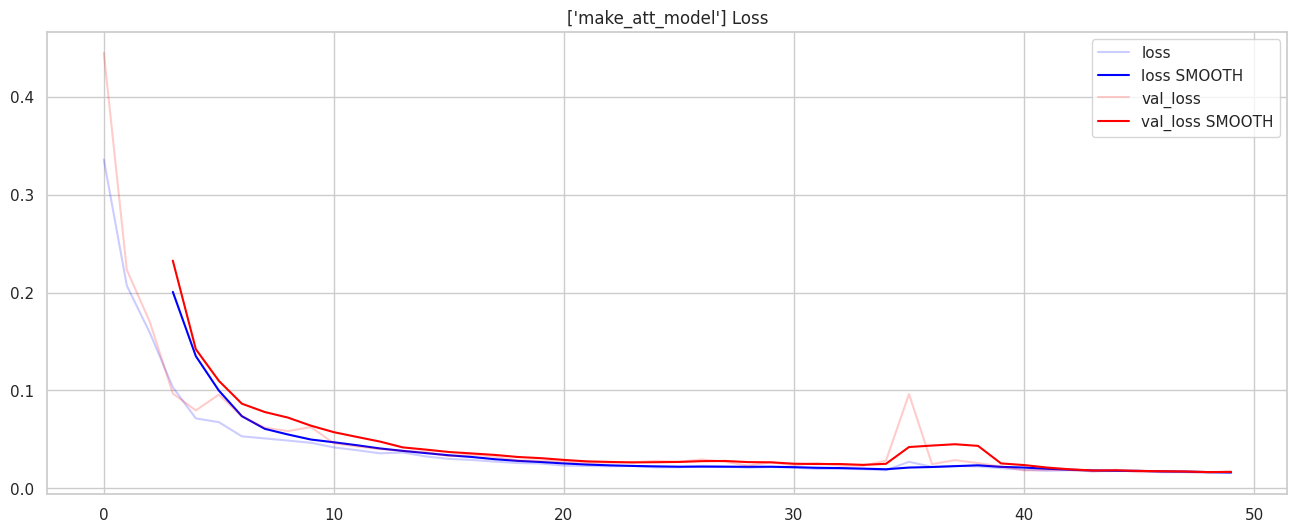

loading training log from /root/artem/analyser/training_reports/make_att_model.1.log.csv


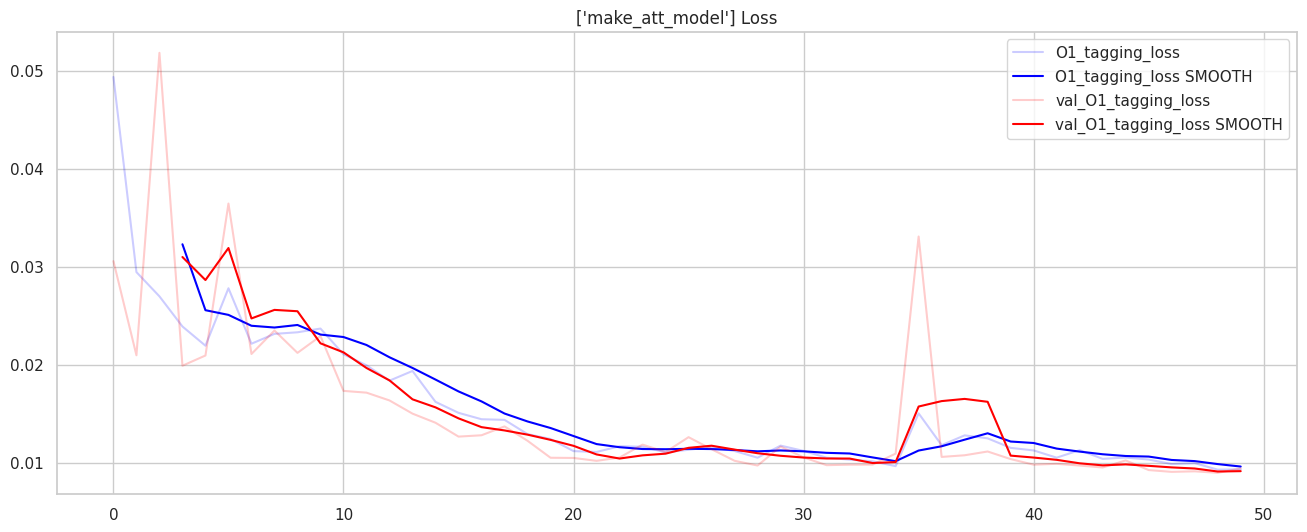

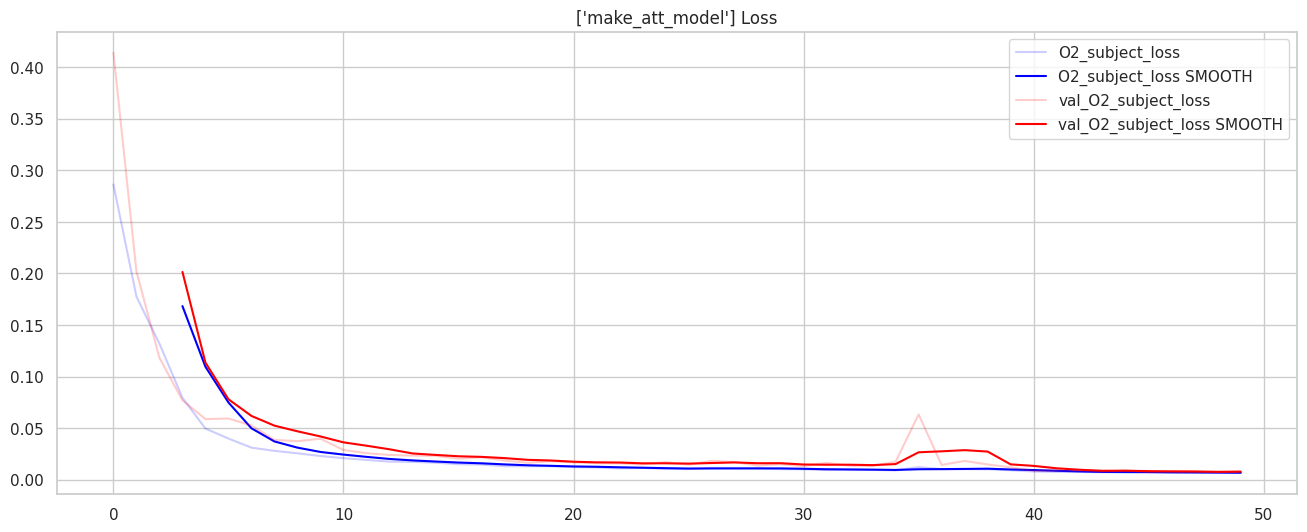

In [51]:
def plot_compare_models(
    models: [str],
    metrics, 
    title="metric/epoch",
    image_save_path = umtm.reports_dir):
    
  _metrics = [m for m in metrics if not m.startswith('val_')]

  for i, m in enumerate(models):

    data: pd.DataFrame = ctx.get_log(m)

    if data is not None:
      data.set_index('epoch')

      for metric in _metrics:
        plt.figure(figsize=(16, 6))
        plt.grid(True)
        plt.title(f'{metric} [{m}]')
        for metric_variant in ['', 'val_']:
          key = metric_variant + metric
          if key in data:

            x = data['epoch'][-100:]
            y = data[key][-100:]


            c = 'red'  # plt.cm.jet_r(i * colorstep)
            if metric_variant == '':
              c = 'blue'
            plt.plot(x, y, label=f'{key}', alpha=0.2, color=c)

            y = y.rolling(4, win_type='gaussian').mean(std=4)
            plt.plot(x, y, label=f'{key} SMOOTH', color=c)

            plt.legend(loc='upper right')

        
        plt.title(f'{[m]} {title}')
        plt.grid(True)
        img_path = os.path.join(image_save_path, f'{m}-{metric}.png')
        
        plt.savefig(img_path, bbox_inches='tight')        
        plt.show()
    else:
      logger.error('cannot plot')
    

models = list(ctx.trained_models.keys())


plot_compare_models(models, ['loss'], 'Loss')

# plot_compare_models(models, ['O1_tagging_kullback_leibler_divergence'], 'TAGS: Kullback Leibler divergence')
# plot_compare_models(models, ['O1_tagging_mse'], 'TAGS: MSE')
# plot_compare_models(models, ['O2_subject_kullback_leibler_divergence'], 'Subj: Kullback Leibler divergence')
# plot_compare_models(models, ['O2_subject_mse'],  'Subjects: MSE')

plot_compare_models(models, ['O1_tagging_loss', 'O2_subject_loss'], 'Loss')



## Contract subj Confusion matrices

In [52]:
# umtm.stats
# semantic_map_keys_contract


5edbc62eda3678279fbcadf3


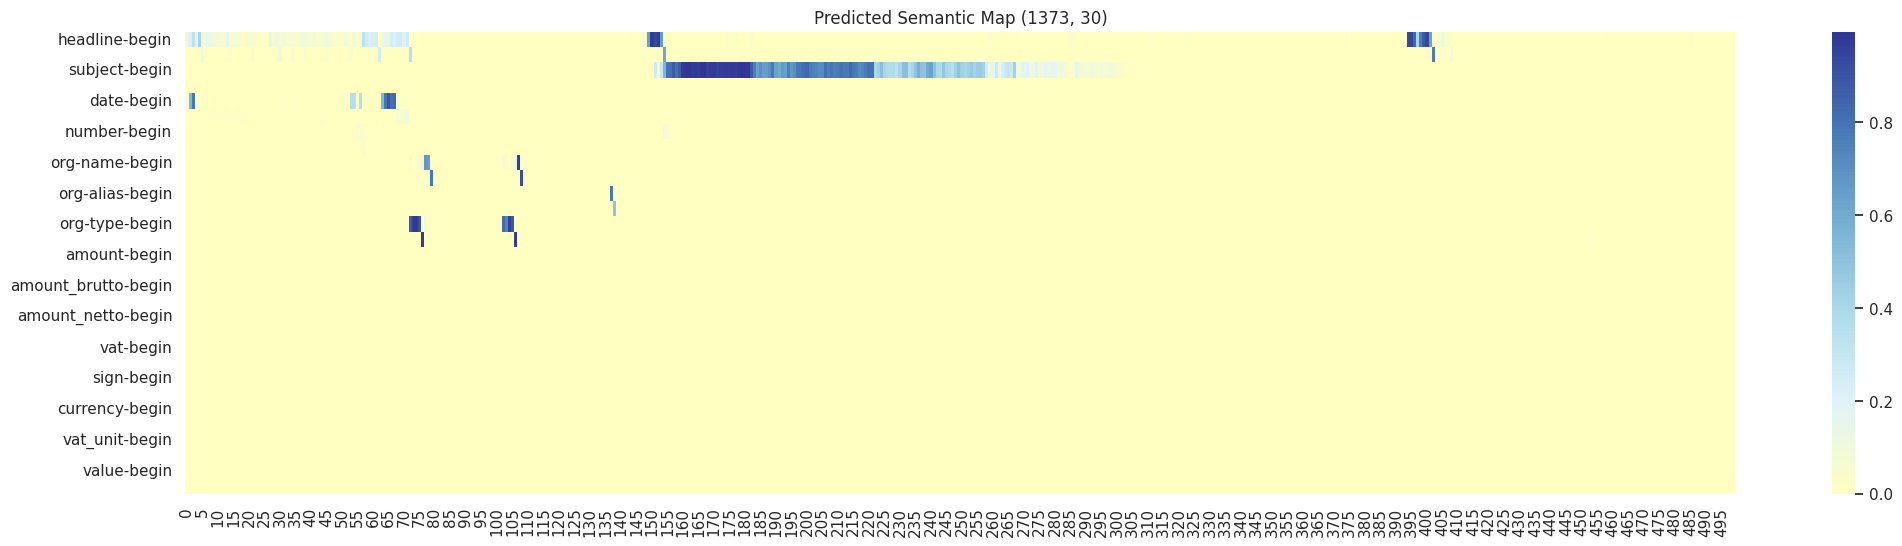

In [53]:
from tf_support.super_contract_model import make_xyw

sample_index = umtm.stats [umtm.stats['value']>0].index[2]
print(sample_index)

x, y, _ = make_xyw(sample_index, umtm.stats)

prediction = umodel.predict(x=[np.expand_dims(x[0], axis=0), np.expand_dims(x[1], axis=0)], batch_size=1)

tagsmap = pd.DataFrame(prediction[0][0], columns=semantic_map_keys_contract)
# .T
plot_embedding(tagsmap[:500], f'Predicted Semantic Map {tagsmap.shape}')

In [54]:
from analyser.contract_parser import nn_get_tag_values

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [55]:

agent_tags = ['org-1-name',
              'org-1-type',
              'org-1-alias',
              'org-2-name',
              'org-2-type',
              'org-2-alias']
solo_tags = [
  'date',
  'number',
  'sign_value_currency/value',
  'sign_value_currency/currency',
  'sign_value_currency/sign'
]

# seq_labels_contract[-3:]

tagnames = solo_tags + agent_tags


from pandas import DataFrame

from analyser.contract_agents import ContractAgent, normalize_contract_agent
from analyser.documents import TextMap
from analyser.ml_tools import SemanticTag
from analyser.persistence import DbJsonDoc
from analyser.text_tools import find_top_spans
# from tf_support.super_contract_model import seq_labels_contract
from tf_support.tf_subject_model import decode_subj_prediction

from analyser.contract_parser import nn_find_org_names, nn_get_tag_value




def fetch_tags_from_predicted_semantic_map(_id: str, tagsmap: DataFrame):
  jdoc = get_doc(_id)
  _map = jdoc.get_tokens_map_unchaged()

  results = {}
  for key in tagnames:
    t = nn_get_tag_value(key, _map, tagsmap )
    results[key] = t
    # print(t)

#   ca = ContractAgent()
#   ca.name =  results['org-1-name'] #TODO: check for NONE
#   ca.type =  results['org-1-type']
#   ca.alias = results['org-1-alias']
   

#   ca2 = ContractAgent()
#   ca2.name =  results['org-2-name'] #TODO: check for NONE
#   ca2.type =  results['org-2-type']
#   ca2.alias = results['org-2-alias']
#   try:
#     normalize_contract_agent(ca)
#     normalize_contract_agent(ca2)
#   except Exception as e:
#         # TODO:
#     logger.error(f'{_id} {e}')

  if results['number'] is not None:
    results['number'].value = results['number'].value.strip().lstrip('№').lstrip('N ').lstrip()

  return results, jdoc


def put_results_into_df(id_, results, df, jdoc: DbJsonDoc):
  org_atribs = ['name', 'alias', 'type']

  def v(x):
    if results[x] is not None:
      return results[x].value

  def swap(a, b):
    ab = [a, b]
    try:
      ab = sorted(ab)
    except:
      pass
    return ab

  def s(a, b):
    ab = swap(v(a), v(b))
    df.at[id_, f'p-{a}'] = ab[0]
    df.at[id_, f'p-{b}'] = ab[1]
    return ab

  for key in org_atribs:
    arr = s(f'org-1-{key}', f'org-2-{key}')

  def p(key):
    df.at[id_, f'p-{key}'] = v(key)

  p('sign_value_currency/value')
  p('sign_value_currency/currency')
  p('sign_value_currency/sign')

  p('date')
  p('number')

  # get_expected values
  for key in solo_tags:
    t = jdoc.get_attribute_value(key)
    df.at[id_, f'{key}'] = t

  for key in org_atribs:
    orgs = swap(jdoc.get_attribute_value(f'org-1-{key}'), jdoc.get_attribute_value(f'org-2-{key}'))
    df.at[id_, f'org-1-{key}'] = orgs[0]
    df.at[id_, f'org-2-{key}'] = orgs[1]



ImportError: cannot import name 'nn_get_tag_value' from 'analyser.contract_parser' (/root/artem/analyser/analyser/contract_parser.py)

In [ ]:
def make_subj_predictions(umodel, indices):
  ev = umtm.stats.copy()
  tags = pd.DataFrame()
  for t in tagnames:
    tags['p-' + t] = ''
    tags[t] = ''

  errors_report = pd.DataFrame()
  errors_report['expected'] = ''
  errors_report['predicted'] = ''

  for i, _id in enumerate(indices):
    logger.debug(f'validating {_id} {i} of {len(indices)}')
    
    x, y, _ = make_xyw(_id, umtm.stats)

    prediction = umodel.predict(x=[np.expand_dims(x[0], axis=0), np.expand_dims(x[1], axis=0)], batch_size=1)

    tagsmap = pd.DataFrame(prediction[0][0], columns=seq_labels_contract)
  
    r, jdoc = fetch_tags_from_predicted_semantic_map(_id, tagsmap)
    put_results_into_df(_id, r, tags, jdoc)
    

    subj_1hot = prediction[1][0]

    expected = decode_subj_prediction(y[1])[0]
    predicted = decode_subj_prediction(subj_1hot)[0]

    ev.at[_id, 'expected_subj'] = expected.name
    ev.at[_id, 'predicted_subj'] = predicted.name

    ev.at[_id, 'wrong'] = False
    if expected != predicted:
      ev.at[_id, 'wrong'] = True

  return ev, tags

ev, tags = make_subj_predictions(umodel, [sample_index])
tags

In [ ]:
%%time




# def fetch_tag_value(tagname: str, textmap: TextMap, tagging: DataFrame, threshold=0.3) -> SemanticTag or None:
#   att = tagging[tagname].values
#   slices = find_top_spans(att, threshold=threshold, limit=1) #TODO: estimate per-tag thresholds
  
#   if len(slices) > 0:
#     span = slices[0].start, slices[0].stop
#     value = textmap.text_range(span)
#     tag = SemanticTag(tagname, value, span)
#     tag.confidence = att[slices[0]].mean()
#     return tag
#   return None










subset = umtm.stats #umtm.stats[~pd.isna(umtm.stats['user_correction_date'])].sort_values('analyze_date')
_indices =  subset.index
ev, tags = make_subj_predictions(umodel, _indices)
tags.to_csv('all_contracts_predicstions.csv')

In [ ]:
# subset = umtm.stats[~pd.isna(umtm.stats['user_correction_date'])]
# pd.isna(umtm.stats['user_correction_date'])
ev 

In [ ]:
# _cols = [  'wrong' ]
# _tmp = ev[cols]
# errors_report = _tmp[ _tmp.wrong == True] #.sort_values('subject')
# print(len(errors_report), 'wrong subjects of', len(tags))
# errors_report 

ev['predicted_subj']
subj_df = ev[['predicted_subj', 'expected_subj']].copy()

In [ ]:
subj_df

In [ ]:
def make_report(umodel, ev):
  plot_cm(ev['expected_subj'], ev['predicted_subj'])
  
  img_path = os.path.join(umtm.work_dir, f'subjects-confusion-matrix-{umodel.name}.png')
  plt.savefig(img_path, bbox_inches='tight')

  report = classification_report(ev['expected_subj'], ev['predicted_subj'], digits=3)
  print(umodel.name)
  print(report)
  
  with open(os.path.join(umtm.work_dir, f'subjects-classification_report-{umodel.name}.txt'), "w") as text_file:
    text_file.write(report)


subj_df = ev[['predicted_subj', 'expected_subj']].copy() #ev[~pd.isna(ev['predicted_subj'])]
make_report(umodel, subj_df)

# Evaluate tags detection

In [ ]:
tags.fillna('-', inplace=True)
tags

In [ ]:
def save_csv(d, f):
    fn = os.path.join(umtm.work_dir, f)
    d.to_csv(fn)

### Contract number validation

In [ ]:
wrong_numbers = tags [ tags['number'] != tags['p-number']].sort_values('number')
print( f'Contract numbers: {len(wrong_numbers)} of {len(tags)}  ({100. * len(wrong_numbers) / len(tags) :0.1f}%) were detected wronggly')

save_csv( wrong_numbers[['p-number', 'number']], 'wrong_numbers.csv')

# wrong_numbers[['p-number', 'number']].tail(10)

In [ ]:
tags ['sign_value_currency/currency'].head(100)

In [ ]:
def conv(x):
    if type(x) is str:
        v = x.replace(',','.').replace(' ','')
    else: 
        v=x
    try:
        v=float(v)
    except:
        v=np.nan
    return v 

tags['n-p-sign_value_currency/value'] = pd.to_numeric( tags['p-sign_value_currency/value'].apply(conv) )
tags['n-sign_value_currency/value']   = pd.to_numeric( tags['sign_value_currency/value'].apply(conv) )

In [ ]:
wrong_values = tags [  tags['n-p-sign_value_currency/value']  != tags['n-sign_value_currency/value']]
cols = ['n-p-sign_value_currency/value', 'n-sign_value_currency/value']
wrong_values = wrong_values[cols]

wrong_values ['val_err'] = \
    np.log1p( np.abs(wrong_values['n-p-sign_value_currency/value'] - wrong_values['n-sign_value_currency/value']))
wrong_values = wrong_values.sort_values('val_err', ascending=False)

print(len(wrong_values))
wrong_values.tail(24)

### Contract Org-1 validation

In [ ]:


wrong_orgs1 = tags [ (tags['org-1-name'] != tags['p-org-1-name']) | (tags['org-2-name'] != tags['p-org-2-name']) ]
print( f'Org-1 name: {len(wrong_orgs1)} of {len(tags)}  ({100. * len(wrong_orgs1) / len(tags):0.1f}%) were detected incorrectly')

cols=['p-org-1-name', 'org-1-name', 'p-org-2-name', 'org-2-name']
save_csv( wrong_orgs1[cols], 'wrong_orgs1.csv')

wrong_orgs1[cols].head(20)

In [ ]:
wrong_aliases = tags [ (tags['org-1-alias'] != tags['p-org-1-alias']) | (tags['org-2-alias'] != tags['p-org-2-alias']) ]
print( f'Aliases: {len(wrong_aliases)} of {len(tags)}  ({100. * len(wrong_aliases) / len(tags) : 0.1f}%) were detected incorrectly')

cols=['p-org-1-alias', 'org-1-alias', 'p-org-2-alias', 'org-2-alias']
save_csv( wrong_aliases[cols], 'wrong_aliases.csv')
# wrong_aliases[cols].head(10)

In [ ]:
wrong_types = tags [ (tags['org-1-type'] != tags['p-org-1-type']) | (tags['org-2-type'] != tags['p-org-2-type'])]
print( f'Types: {len(wrong_types)} of {len(tags)}  ({100. * len(wrong_types) / len(tags) : 0.1f}%) were detected incorrectly')
cols=['p-org-1-type', 'p-org-2-type', 'org-1-type', 'org-2-type']
save_csv( wrong_types[cols], 'wrong_types.csv')
wrong_types[cols].head(10)

In [ ]:
from collections import Counter
arrays = [ wrong_orgs1, wrong_types, wrong_numbers, wrong_aliases]
counter = Counter()
for a in arrays:
  for i in a.index:
   counter[i]+=1
 

print('Самый сложный документ: ', counter.most_common()[0][0])
print("Всего недочетов:", len(counter))

In [ ]:
umtm.stats['errors'] = 0
for c in counter:
  umtm.stats.at[c, 'errors'] = counter[c]


calculate_samples_weights(umtm)
umtm._save_stats()
umtm.stats

## Single doc eval

In [ ]:
if IN_COLAB:
  !wget https://raw.githubusercontent.com/nemoware/analyser/uber-models/tests/contract_db_1.json

  with open('contract_db_1.json', 'rb') as handle:    
    jdata = json.load(handle, object_hook=json_util.object_hook)

  jdoc = DbJsonDoc(jdata)

else:
  from integration.db import get_mongodb_connection
  from bson.objectid import ObjectId

  def get_doc(objid):
    logger.debug(f'fetching {objid}')
    db = get_mongodb_connection()
    documents_collection = db['documents']
    jdata =  documents_collection.find_one({'_id': ObjectId(objid)})
    return DbJsonDoc(jdata)

  SAMPLE_DOC_ID = counter.most_common()[0][0] #umtm.stats.index[10]
    
    
    
  SAMPLE_DOC_ID = '5eea27adc28b75807f3dae66'
  print('SAMPLE_DOC_ID:', SAMPLE_DOC_ID)
  dp = umtm.make_xyw(SAMPLE_DOC_ID)
  (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp

  jdoc = get_doc(SAMPLE_DOC_ID)

In [ ]:
from analyser.legal_docs import embedd_tokens

if IN_COLAB:
  embedder = ElmoEmbedder.get_instance('elmo')  # lazy init
  emb = embedd_tokens(jdoc.get_tokens_for_embedding(),
                             embedder,
                             verbosity=2,
                             log_key='tmp')

  tok_f = get_tokens_features(jdoc.get_tokens_map_unchaged().tokens)

In [ ]:
###############
prediction = umodel.predict(   x=[  np.expand_dims(emb, axis=0), np.expand_dims(tok_f, axis=0)] , batch_size=1)
##############
print(len(prediction), umodel.name)
subj_1hot = prediction[1][0]
print('Subject:', decode_subj_prediction(subj_1hot))


tagging = pd.DataFrame( prediction[0][0], columns=seq_labels_contract)
plot_embedding(tagging, title = f'Predictions of {umodel.name}')

In [ ]:
def render_slices(slices, tokens, attention_v, ht='') -> str:
  ht += '<ol>'
  for _s in slices:
    ht += '<li>'
    t = tokens[_s]
    l = attention_v[_s]
    ht += to_color_text(t, l, _range=(0, 1.2))
    ht += '<br><hr>'
    ht += '</li>'
  ht += '</ol>'

  return ht

for t in seq_labels_contract:
  spans = list( find_top_spans( tagging[t].values, threshold=0.3))  
  display(HTML(render_slices(spans, jdoc.get_tokens_map_unchaged().tokens, tagging[t].values)))


In [ ]:

# mean_ = tagging.values.max(-1)*0.5
# print (mean_.shape)
# display(HTML( to_color_text (jdoc.get_tokens_map_unchaged().tokens[:24000],  mean_[:24000])))

In [ ]:
ids = '5edbadd7da3678279fbcaabf
5edbc660da3678279fbcaeac
5edbc668da3678279fbcaf6e
5edbc65dda3678279fbcae56
5edbc66bda3678279fbcafe6
5edbc615da3678279fbcadc9'